# Solar Event Detection

## Data Loading

In [140]:
!pip install torch torchvision scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

DATASET_ROOT = "/mnt/elice/dataset"  # 데이터 셋의 루트 디렉토리
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"
# DATASET_ROOT/train/labels: 학습 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/train/images: 학습 데이터의 이미지 파일이 있는 디렉토리
# DATASET_ROOT/test/labels: 테스트 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/test/images: 테스트 데이터의 이미지 파일이 있는 디렉토리

IMAGE_SIZE = 1024
BATCH = 64
EPOCH = 70

### Training Data

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
df_train.head()

100%|██████████| 14867/14867 [00:08<00:00, 1700.31it/s]


id  \
0  081248653ac94bd0bc3558d801fbe03c   
1  7925f228ca6147b69f9eee6eb4575b56   
2  86cde8e0b0074f1d9210af8a2740c156   
3  1c7ca27850874e88b9fc942c3938202b   
4  fd660572631c492d9c4937a4c68c3414   

                                          image_path  \
0  /mnt/elice/dataset/train/images/081248653ac94b...   
1  /mnt/elice/dataset/train/images/7925f228ca6147...   
2  /mnt/elice/dataset/train/images/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/images/1c7ca27850874e...   
4  /mnt/elice/dataset/train/images/fd660572631c49...   

                                          label_path  \
0  /mnt/elice/dataset/train/labels/081248653ac94b...   
1  /mnt/elice/dataset/train/labels/7925f228ca6147...   
2  /mnt/elice/dataset/train/labels/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/labels/1c7ca27850874e...   
4  /mnt/elice/dataset/train/labels/fd660572631c49...   

                                              labels  
0  [{'class_id': 0, 'x': 0.3247527480125427, 'y':...  
1  [{'class_id': 0, 'x': 0.5499619841575623, 'y':...  
2  [{'class_id': 0, 'x': 0.749954879283905, 'y': ...  
3                                                 []  
4  [{'class_id': 0, 'x': 0.6441617608070374, 'y':...

### Augmentation

In [3]:
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd

# 현재 작업 디렉토리에 증강 이미지를 저장하도록 설정
augmented_image_dir = os.path.join(os.getcwd(), "augmented_images")
augmented_label_dir = os.path.join(os.getcwd(), "augmented_labels")
os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_label_dir, exist_ok=True)

# 이미지를 반전하고 라벨을 변환하는 함수
def flip_image_and_labels(image, labels, flip_type):
    if flip_type == 'tb':  # 상하 반전
        flipped_image = image.transpose(method=Image.FLIP_TOP_BOTTOM)
        flipped_labels = [{'class_id': label['class_id'], 'x': label['x'], 'y': 1 - label['y'], 'w': label['w'], 'h': label['h']} for label in labels]
    elif flip_type == 'lr':  # 좌우 반전
        flipped_image = image.transpose(method=Image.FLIP_LEFT_RIGHT)
        flipped_labels = [{'class_id': label['class_id'], 'x': 1 - label['x'], 'y': label['y'], 'w': label['w'], 'h': label['h']} for label in labels]
    elif flip_type == 'tb_lr':  # 상하 및 좌우 반전
        flipped_image = image.transpose(method=Image.FLIP_TOP_BOTTOM).transpose(method=Image.FLIP_LEFT_RIGHT)
        flipped_labels = [{'class_id': label['class_id'], 'x': 1 - label['x'], 'y': 1 - label['y'], 'w': label['w'], 'h': label['h']} for label in labels]
    else:
        flipped_image = image
        flipped_labels = labels
    
    return flipped_image, flipped_labels

# 반전된 이미지와 라벨을 저장하는 함수
def save_augmented_data(image_path, labels, output_image_path, output_label_path, flip_type):
    # 이미지 열기
    image = Image.open(image_path)
    
    # 이미지와 라벨을 반전
    flipped_image, flipped_labels = flip_image_and_labels(image, labels, flip_type)

    # 반전된 이미지 저장
    flipped_image.save(output_image_path)

    # 반전된 라벨 저장
    with open(output_label_path, 'w') as f:
        for label in flipped_labels:
            f.write(f"{label['class_id']} {label['x']} {label['y']} {label['w']} {label['h']}\n")

# 기존 데이터셋을 순회하며 증강
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    image_id = row['id']
    image_path = row['image_path']
    label_path = row['label_path']

    # 원본 라벨 불러오기
    labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            class_id, x, y, w, h = map(float, line.strip().split())
            labels.append({'class_id': class_id, 'x': x, 'y': y, 'w': w, 'h': h})

    # 증강된 이미지와 라벨을 저장하기 위한 각 반전 타입별 파일명과 경로
    flip_types = ['', 'tb', 'lr']
    for flip_type in flip_types:
        new_image_id = f"{image_id}_aug_{flip_type}" if flip_type else f"{image_id}_aug"
        output_image_path = os.path.join(augmented_image_dir, f"{new_image_id}.jpg")
        output_label_path = os.path.join(augmented_label_dir, f"{new_image_id}.txt")

        # 증강 데이터 저장
        save_augmented_data(image_path, labels, output_image_path, output_label_path, flip_type)

        # 새로운 데이터프레임 행 추가
        new_row = pd.DataFrame([{
            'id': new_image_id,
            'image_path': output_image_path,
            'label_path': output_label_path,
            'labels': labels
        }])

        # 기존 데이터프레임에 증강된 데이터 추가
        df_train = pd.concat([df_train, new_row], ignore_index=True)


100%|██████████| 14867/14867 [11:36<00:00, 21.34it/s]


In [4]:
df_train['class'] = df_train['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
df_train['class'] = df_train['class'].apply(lambda x: int(x[0]) if x else None)
df_train['class'] = df_train['class'].apply(lambda x: int(x) if pd.notna(x) else -1)
df_train['class'].value_counts()

class
 0    20504
 2    16876
 1    16444
-1     5644
Name: count, dtype: int64

In [5]:
df_train.head()

id  \
0  081248653ac94bd0bc3558d801fbe03c   
1  7925f228ca6147b69f9eee6eb4575b56   
2  86cde8e0b0074f1d9210af8a2740c156   
3  1c7ca27850874e88b9fc942c3938202b   
4  fd660572631c492d9c4937a4c68c3414   

                                          image_path  \
0  /mnt/elice/dataset/train/images/081248653ac94b...   
1  /mnt/elice/dataset/train/images/7925f228ca6147...   
2  /mnt/elice/dataset/train/images/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/images/1c7ca27850874e...   
4  /mnt/elice/dataset/train/images/fd660572631c49...   

                                          label_path  \
0  /mnt/elice/dataset/train/labels/081248653ac94b...   
1  /mnt/elice/dataset/train/labels/7925f228ca6147...   
2  /mnt/elice/dataset/train/labels/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/labels/1c7ca27850874e...   
4  /mnt/elice/dataset/train/labels/fd660572631c49...   

                                              labels  class  
0  [{'class_id': 0, 'x': 0.3247527480125427, 'y':...      0  
1  [{'class_id': 0, 'x': 0.5499619841575623, 'y':...      0  
2  [{'class_id': 0, 'x': 0.749954879283905, 'y': ...      0  
3                                                 []     -1  
4  [{'class_id': 0, 'x': 0.6441617608070374, 'y':...      0

In [6]:
df_train_noneNaN = df_train[df_train['class'] != -1]
df_train_NaN = df_train[df_train['class'] == -1]
df_train_NaN.head()

id  \
3   1c7ca27850874e88b9fc942c3938202b   
5   7ebe47341db24cc0ac785c60165eb278   
8   3d722ed0f4d8433a8f02def10b57b2c3   
9   8432fe12520748e1b6ee66b9457b6d0a   
10  a3f56577d5194d428c8c50244ded72db   

                                           image_path  \
3   /mnt/elice/dataset/train/images/1c7ca27850874e...   
5   /mnt/elice/dataset/train/images/7ebe47341db24c...   
8   /mnt/elice/dataset/train/images/3d722ed0f4d843...   
9   /mnt/elice/dataset/train/images/8432fe12520748...   
10  /mnt/elice/dataset/train/images/a3f56577d5194d...   

                                           label_path labels  class  
3   /mnt/elice/dataset/train/labels/1c7ca27850874e...     []     -1  
5   /mnt/elice/dataset/train/labels/7ebe47341db24c...     []     -1  
8   /mnt/elice/dataset/train/labels/3d722ed0f4d843...     []     -1  
9   /mnt/elice/dataset/train/labels/8432fe12520748...     []     -1  
10  /mnt/elice/dataset/train/labels/a3f56577d5194d...     []     -1

## Visulaize Sample Data

### Sample image

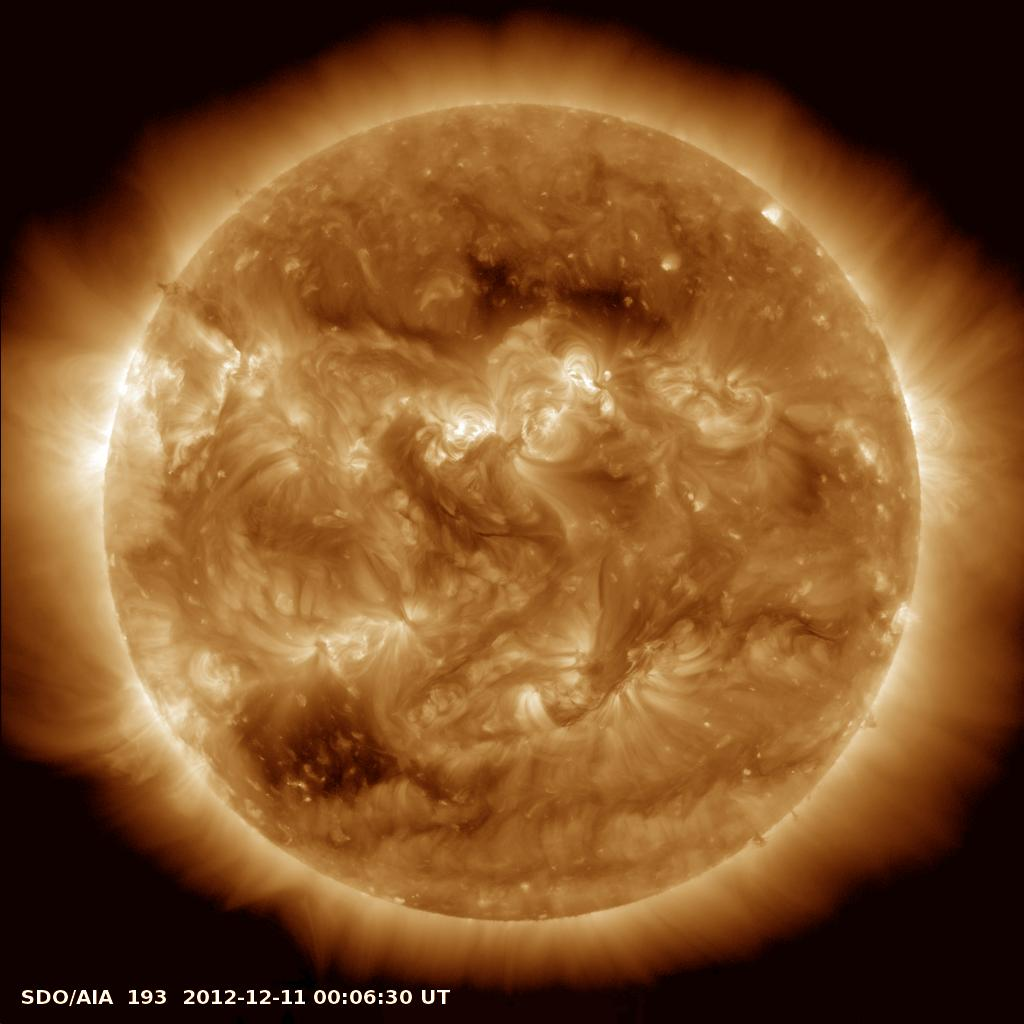

In [7]:
sample = df_train.iloc[0]

# 이미지 읽기
image_sample = Image.open(sample["image_path"])
image_sample

### Sample image's label

YOLO format

YOLO format
`<object-class> <x> <y> <width> <height>`
- object-class: class of object
- x, y: BBox's center (0~1)
- width, height: BBox's width and heigth(0~1)

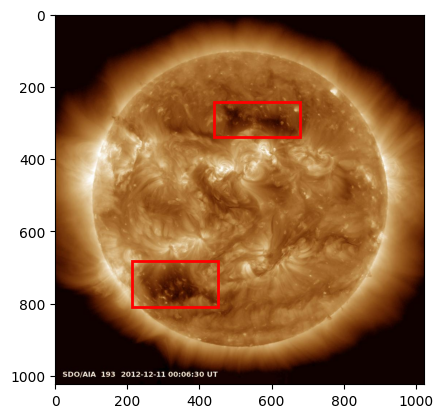

In [ ]:
sample = df_train.iloc[0]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])

# 이미지 표시
ax.imshow(img)

# 박스 그리기
for label in sample["labels"]:
    # 좌표 변환
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    w = label["w"] * img.width
    h = label["h"] * img.height

    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)

fig.show()

# Classification

In [9]:
image_size = (256, 256)
batch_size = 32
num_classes = df_train['class'].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [10]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (image_size[0]//8) * (image_size[1]//8), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (image_size[0]//8) * (image_size[1]//8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# # 커스텀 데이터셋 클래스 정의
# class ImageDataset(Dataset):
#     def __init__(self, df, transform=None):
#         self.df = df
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = self.df.iloc[idx]['image_path']
#         image = Image.open(img_path).convert('RGB')
#         label = int(self.df.iloc[idx]['class'])

#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [ ]:
# # 데이터셋 생성
# train_df, valid_df = train_test_split(df_train_noneNaN, test_size=0.2, random_state=42)
# train_dataset = ImageDataset(train_df, transform=transform)
# valid_dataset = ImageDataset(valid_df, transform=transform)

# # 데이터 로더 생성
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# # 모델 인스턴스 생성
# model = SimpleCNN(num_classes=num_classes)

# # 손실 함수와 옵티마이저 설정
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 학습 함수 정의
# def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# # 검증 함수 정의
# def validate_model(model, valid_loader, criterion):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in valid_loader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     print(f'Validation Accuracy: {100 * correct / total:.2f}%')
    
# # 모델 학습
# train_model(model, train_loader, criterion, optimizer, num_epochs=4)

# # 모델 검증
# validate_model(model, valid_loader, criterion)

# # 모델 저장
# torch.save(model.state_dict(), 'simple_cnn.pth')

"\n# 커스텀 데이터셋 클래스 정의\nclass ImageDataset(Dataset):\n    def __init__(self, df, transform=None):\n        self.df = df\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.df)\n\n    def __getitem__(self, idx):\n        img_path = self.df.iloc[idx]['image_path']\n        image = Image.open(img_path).convert('RGB')\n        label = int(self.df.iloc[idx]['class'])\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, label\n        \n# 데이터셋 생성\ntrain_df, valid_df = train_test_split(df_train_noneNaN, test_size=0.2, random_state=42)\ntrain_dataset = ImageDataset(train_df, transform=transform)\nvalid_dataset = ImageDataset(valid_df, transform=transform)\n\n# 데이터 로더 생성\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nvalid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)\n\n# 모델 인스턴스 생성\nmodel = SimpleCNN(num_classes=num_classes)\n\n# 손실 함수와 옵티마이저 설정\ncriterion 

In [12]:
#모델 로드
# 모델 클래스 인스턴스화
model = SimpleCNN(num_classes=num_classes)

# 저장된 가중치 로드
model.load_state_dict(torch.load('simple_cnn.pth'))

# 모델을 평가 모드로 설정
model.eval()

/tmp/ipykernel_61/1699682167.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('simple_cnn.pth'))


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### NaN(-1) class image re-classification

In [13]:
df_train_NaN.head(5)

id  \
3   1c7ca27850874e88b9fc942c3938202b   
5   7ebe47341db24cc0ac785c60165eb278   
8   3d722ed0f4d8433a8f02def10b57b2c3   
9   8432fe12520748e1b6ee66b9457b6d0a   
10  a3f56577d5194d428c8c50244ded72db   

                                           image_path  \
3   /mnt/elice/dataset/train/images/1c7ca27850874e...   
5   /mnt/elice/dataset/train/images/7ebe47341db24c...   
8   /mnt/elice/dataset/train/images/3d722ed0f4d843...   
9   /mnt/elice/dataset/train/images/8432fe12520748...   
10  /mnt/elice/dataset/train/images/a3f56577d5194d...   

                                           label_path labels  class  
3   /mnt/elice/dataset/train/labels/1c7ca27850874e...     []     -1  
5   /mnt/elice/dataset/train/labels/7ebe47341db24c...     []     -1  
8   /mnt/elice/dataset/train/labels/3d722ed0f4d843...     []     -1  
9   /mnt/elice/dataset/train/labels/8432fe12520748...     []     -1  
10  /mnt/elice/dataset/train/labels/a3f56577d5194d...     []     -1

In [14]:
# 테스트 데이터셋 클래스 정의
class NaNDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# 테스트 데이터셋 및 데이터 로더 생성
NaN_dataset = NaNDataset(df_train_NaN, transform=transform)
NaN_loader = DataLoader(NaN_dataset, batch_size=batch_size, shuffle=False)

# 예측 결과 저장
predictions_NaN = []

with torch.no_grad():
    for images in NaN_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions_NaN.extend(predicted.cpu().numpy())

# df_test에 예측 결과 추가
df_train_NaN['class'] = predictions_NaN

/tmp/ipykernel_61/748722216.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_NaN['class'] = predictions_NaN


In [ ]:
df_train_NaN.head(5)

id  \
3   1c7ca27850874e88b9fc942c3938202b   
5   7ebe47341db24cc0ac785c60165eb278   
8   3d722ed0f4d8433a8f02def10b57b2c3   
9   8432fe12520748e1b6ee66b9457b6d0a   
10  a3f56577d5194d428c8c50244ded72db   

                                           image_path  \
3   /mnt/elice/dataset/train/images/1c7ca27850874e...   
5   /mnt/elice/dataset/train/images/7ebe47341db24c...   
8   /mnt/elice/dataset/train/images/3d722ed0f4d843...   
9   /mnt/elice/dataset/train/images/8432fe12520748...   
10  /mnt/elice/dataset/train/images/a3f56577d5194d...   

                                           label_path labels  class  
3   /mnt/elice/dataset/train/labels/1c7ca27850874e...     []      0  
5   /mnt/elice/dataset/train/labels/7ebe47341db24c...     []      2  
8   /mnt/elice/dataset/train/labels/3d722ed0f4d843...     []      2  
9   /mnt/elice/dataset/train/labels/8432fe12520748...     []      1  
10  /mnt/elice/dataset/train/labels/a3f56577d5194d...     []      2

In [16]:
df_train_NaN['class'].value_counts()

class
2    4404
0     692
1     548
Name: count, dtype: int64

In [17]:
df_train_class = pd.concat([df_train_noneNaN,df_train_NaN]).sort_index()
df_train_class.head()

id  \
0  081248653ac94bd0bc3558d801fbe03c   
1  7925f228ca6147b69f9eee6eb4575b56   
2  86cde8e0b0074f1d9210af8a2740c156   
3  1c7ca27850874e88b9fc942c3938202b   
4  fd660572631c492d9c4937a4c68c3414   

                                          image_path  \
0  /mnt/elice/dataset/train/images/081248653ac94b...   
1  /mnt/elice/dataset/train/images/7925f228ca6147...   
2  /mnt/elice/dataset/train/images/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/images/1c7ca27850874e...   
4  /mnt/elice/dataset/train/images/fd660572631c49...   

                                          label_path  \
0  /mnt/elice/dataset/train/labels/081248653ac94b...   
1  /mnt/elice/dataset/train/labels/7925f228ca6147...   
2  /mnt/elice/dataset/train/labels/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/labels/1c7ca27850874e...   
4  /mnt/elice/dataset/train/labels/fd660572631c49...   

                                              labels  class  
0  [{'class_id': 0, 'x': 0.3247527480125427, 'y':...      0  
1  [{'class_id': 0, 'x': 0.5499619841575623, 'y':...      0  
2  [{'class_id': 0, 'x': 0.749954879283905, 'y': ...      0  
3                                                 []      0  
4  [{'class_id': 0, 'x': 0.6441617608070374, 'y':...      0

### class-wise df separation

In [18]:
df_train_coronalHole = df_train_class[df_train_class['class'] == 0]
df_train_sunspot = df_train_class[df_train_class['class'] == 1]
df_train_prominence = df_train_class[df_train_class['class'] == 2]

In [19]:
df_train_sunspot

id  \
9             8432fe12520748e1b6ee66b9457b6d0a   
12            117f20b34e6b4b99b02b1576a72176b0   
14            b33e6cc0ff5040d7b82c61120335a73c   
17            18a585175ad04513ae89a1cbb7829ca0   
19            c6abab311c624a359ddaf963cd190136   
...                                        ...   
59454  0712c16239db4d76acb9dec9377c4799_aug_tb   
59455  0712c16239db4d76acb9dec9377c4799_aug_lr   
59459     9f25b8bacf16478487dbeefad9144286_aug   
59460  9f25b8bacf16478487dbeefad9144286_aug_tb   
59461  9f25b8bacf16478487dbeefad9144286_aug_lr   

                                              image_path  \
9      /mnt/elice/dataset/train/images/8432fe12520748...   
12     /mnt/elice/dataset/train/images/117f20b34e6b4b...   
14     /mnt/elice/dataset/train/images/b33e6cc0ff5040...   
17     /mnt/elice/dataset/train/images/18a585175ad045...   
19     /mnt/elice/dataset/train/images/c6abab311c624a...   
...                                                  ...   
59454  /home/elicer/augmented_images/0712c16239db4d76...   
59455  /home/elicer/augmented_images/0712c16239db4d76...   
59459  /home/elicer/augmented_images/9f25b8bacf164784...   
59460  /home/elicer/augmented_images/9f25b8bacf164784...   
59461  /home/elicer/augmented_images/9f25b8bacf164784...   

                                              label_path  \
9      /mnt/elice/dataset/train/labels/8432fe12520748...   
12     /mnt/elice/dataset/train/labels/117f20b34e6b4b...   
14     /mnt/elice/dataset/train/labels/b33e6cc0ff5040...   
17     /mnt/elice/dataset/train/labels/18a585175ad045...   
19     /mnt/elice/dataset/train/labels/c6abab311c624a...   
...                                                  ...   
59454  /home/elicer/augmented_labels/0712c16239db4d76...   
59455  /home/elicer/augmented_labels/0712c16239db4d76...   
59459  /home/elicer/augmented_labels/9f25b8bacf164784...   
59460  /home/elicer/augmented_labels/9f25b8bacf164784...   
59461  /home/elicer/augmented_labels/9f25b8bacf164784...   

                                                  labels  class  
9                                                     []      1  
12     [{'class_id': 1, 'x': 0.41546809673309326, 'y'...      1  
14     [{'class_id': 1, 'x': 0.34275510907173157, 'y'...      1  
17     [{'class_id': 1, 'x': 0.6765461564064026, 'y':...      1  
19     [{'class_id': 1, 'x': 0.5776177644729614, 'y':...      1  
...                                                  ...    ...  
59454  [{'class_id': 1.0, 'x': 0.6611584546896847, 'y...      1  
59455  [{'class_id': 1.0, 'x': 0.6611584546896847, 'y...      1  
59459  [{'class_id': 1.0, 'x': 0.4369772970676422, 'y...      1  
59460  [{'class_id': 1.0, 'x': 0.4369772970676422, 'y...      1  
59461  [{'class_id': 1.0, 'x': 0.4369772970676422, 'y...      1  

[16992 rows x 5 columns]

# coronalHole

In [28]:
df_train_coronalHole.head()

id  \
0  081248653ac94bd0bc3558d801fbe03c   
1  7925f228ca6147b69f9eee6eb4575b56   
2  86cde8e0b0074f1d9210af8a2740c156   
3  1c7ca27850874e88b9fc942c3938202b   
4  fd660572631c492d9c4937a4c68c3414   

                                          image_path  \
0  /mnt/elice/dataset/train/images/081248653ac94b...   
1  /mnt/elice/dataset/train/images/7925f228ca6147...   
2  /mnt/elice/dataset/train/images/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/images/1c7ca27850874e...   
4  /mnt/elice/dataset/train/images/fd660572631c49...   

                                          label_path  \
0  /mnt/elice/dataset/train/labels/081248653ac94b...   
1  /mnt/elice/dataset/train/labels/7925f228ca6147...   
2  /mnt/elice/dataset/train/labels/86cde8e0b0074f...   
3  /mnt/elice/dataset/train/labels/1c7ca27850874e...   
4  /mnt/elice/dataset/train/labels/fd660572631c49...   

                                              labels  class  
0  [{'class_id': 0, 'x': 0.3247527480125427, 'y':...      0  
1  [{'class_id': 0, 'x': 0.5499619841575623, 'y':...      0  
2  [{'class_id': 0, 'x': 0.749954879283905, 'y': ...      0  
3                                                 []      0  
4  [{'class_id': 0, 'x': 0.6441617608070374, 'y':...      0

## Data Preprocessing

### Data Split

In [29]:
df_train_coronalHole_set = df_train_coronalHole.sample(frac=0.8, random_state=0)
df_valid_coronalHole_set = df_train_coronalHole.drop(df_train_coronalHole_set.index)

df_train_coronalHole_set.to_csv("train_coronalHole_set.csv", index=False)
df_valid_coronalHole_set.to_csv("valid_coronalHole_set.csv", index=False)

new_train_coronalHole_path = os.path.abspath("train_coronalHole")
new_valid_coronalHole_path = os.path.abspath("valid_coronalHole")

os.makedirs(new_train_coronalHole_path, exist_ok=True)
os.makedirs(os.path.join(new_train_coronalHole_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_coronalHole_path, LABELS_DIR), exist_ok=True)

os.makedirs(new_valid_coronalHole_path, exist_ok=True)
os.makedirs(os.path.join(new_valid_coronalHole_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_valid_coronalHole_path, LABELS_DIR), exist_ok=True)

### Data preprocessing and copy

Resize and copy into each folder

YOLO model uses relative coordinate, so label resizing is not needed.

Resizing the label might be needed depends on your model.

In [30]:
for i, row in tqdm(df_train_coronalHole_set.iterrows(), total=len(df_train_coronalHole_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_coronalHole_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_train_coronalHole_path}/{LABELS_DIR}/{row['id']}.txt")

for i, row in tqdm(df_valid_coronalHole_set.iterrows(), total=len(df_valid_coronalHole_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_coronalHole_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_valid_coronalHole_path}/{LABELS_DIR}/{row['id']}.txt")

100%|██████████| 4239/4239 [00:36<00:00, 116.80it/s]


## Model Training

### Model import

External model import

- Model download
- Model dependency

In [31]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [32]:
# YOLOv5 클론 및 설치 
!git clone https://github.com/ultralytics/yolov5.git 
!pip install --quiet -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [33]:
# !pip install ultralytics

### Model Training

In [34]:
dataset = {
    "path": os.path.abspath("."),
    "train": "train_coronalHole",
    "val": "valid_coronalHole",
    "nc": 1,
    "names": ["coronal_hole"],
}

YAML_PATH = os.path.abspath("coronalHole.yaml")
RESULT_PATH = os.path.abspath("result6_coronalHole")
os.makedirs(RESULT_PATH, exist_ok=True)

with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [35]:
!PYTHONWARNINGS="ignore::FutureWarning" python yolov5/train.py --img {IMAGE_SIZE} --batch {BATCH} --epoch {EPOCH} --data {YAML_PATH} --cfg yolov5s.yaml --exist-ok --weights "" --name coronalHole --project {RESULT_PATH}

train: weights=, cfg=yolov5s.yaml, data=/home/elicer/coronalHole.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=64, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/elicer/result6_coronalHole, name=coronalHole, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

hyperparameters: lr0=0.01, lrf

                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.884      0.882      0.949      0.677

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/69      29.2G    0.02799    0.01951          0        174       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.893      0.868      0.945       0.67

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/69      29.2G    0.02769    0.01963          0        198       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660        0.9      0.878      0.952      0.689

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/69      29.2G    0.02748    0.01917          0        213       1024: 1
          

      33/69      32.7G    0.02384    0.01738          0        184       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.936      0.942      0.982       0.78

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/69      32.7G    0.02371    0.01725          0        200       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.936      0.943      0.982      0.784

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/69      32.7G    0.02364    0.01698          0        181       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.932       0.95      0.983      0.784

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/6

      58/69      32.7G    0.02069      0.015          0        167       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.961      0.968       0.99      0.822

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/69      32.7G    0.02061    0.01504          0        189       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.962      0.969       0.99      0.823

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      60/69      32.7G    0.02036    0.01494          0        185       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5920      12660      0.963      0.969       0.99      0.824

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      61/6

## Model Evaluation

### Valida Data Inference

In [36]:
!python yolov5/detect.py --source {os.path.join(new_valid_coronalHole_path, IMAGE_DIR)} --weights {RESULT_PATH}/coronalHole/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/valid

detect: weights=['/home/elicer/result6_coronalHole/coronalHole/weights/best.pt'], source=/home/elicer/valid_coronalHole/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/elicer/result6_coronalHole/valid1, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/5920 /home/elicer/valid_coronalHole/images/0034b6e95fed400c8e9d99ed66d1359b.jpg: 640x640 4 coronal_holes, 5.1ms
image 2/5920 /home/elicer/valid_coronalHole/images/0034b6e95fed400c8e9d99

image 63/5920 /home/elicer/valid_coronalHole/images/02854ad577914f8d8be251d5f57274f9_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 64/5920 /home/elicer/valid_coronalHole/images/029836a2cd444444be07d4c808d3cdd7.jpg: 640x640 2 coronal_holes, 5.1ms
image 65/5920 /home/elicer/valid_coronalHole/images/02c8b75128724e69ba9df1463563b9c9.jpg: 640x640 2 coronal_holes, 5.0ms
image 66/5920 /home/elicer/valid_coronalHole/images/02c8b75128724e69ba9df1463563b9c9_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 67/5920 /home/elicer/valid_coronalHole/images/02c8b75128724e69ba9df1463563b9c9_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 68/5920 /home/elicer/valid_coronalHole/images/02caf95a8d07465b944c40f341ecf2a2_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 69/5920 /home/elicer/valid_coronalHole/images/02f2c8915da449e695112aac43668f51_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 70/5920 /home/elicer/valid_coronalHole/images/03145e019bd548969c924605698a44ad.jpg: 640x640 3 coronal_holes, 5.1ms
ima

image 131/5920 /home/elicer/valid_coronalHole/images/06133787024b48ce84a4c7fcb5667696_aug_lr.jpg: 640x640 3 coronal_holes, 5.3ms
image 132/5920 /home/elicer/valid_coronalHole/images/06133787024b48ce84a4c7fcb5667696_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 133/5920 /home/elicer/valid_coronalHole/images/062066043f554ab4a9bb380bdd831943_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 134/5920 /home/elicer/valid_coronalHole/images/063bbc5e8174413fa4a2fbe2c25900e4_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 135/5920 /home/elicer/valid_coronalHole/images/063bbc5e8174413fa4a2fbe2c25900e4_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 136/5920 /home/elicer/valid_coronalHole/images/0648f8fa130b417197f4162e85a7ee29_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 137/5920 /home/elicer/valid_coronalHole/images/064ad567c11b4bf0aa51879a5fd66268_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 138/5920 /home/elicer/valid_coronalHole/images/064ad567c11b4bf0aa51879a5fd66268_aug_lr.jpg: 640x640 3

image 198/5920 /home/elicer/valid_coronalHole/images/08a6aa39c1d34a73af2140870ea2e129.jpg: 640x640 2 coronal_holes, 5.2ms
image 199/5920 /home/elicer/valid_coronalHole/images/08a6aa39c1d34a73af2140870ea2e129_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 200/5920 /home/elicer/valid_coronalHole/images/08a6aa39c1d34a73af2140870ea2e129_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 201/5920 /home/elicer/valid_coronalHole/images/08a6aa39c1d34a73af2140870ea2e129_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 202/5920 /home/elicer/valid_coronalHole/images/08b51ebe8e994365a32a8534e454970a.jpg: 640x640 (no detections), 5.0ms
image 203/5920 /home/elicer/valid_coronalHole/images/08b55922a8704968898cb43433d18c7e_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 204/5920 /home/elicer/valid_coronalHole/images/08d282ad3d78429798073cc803d2bd8f_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 205/5920 /home/elicer/valid_coronalHole/images/08d282ad3d78429798073cc803d2bd8f_aug_tb.jpg: 640x640 2 coronal_hole

image 265/5920 /home/elicer/valid_coronalHole/images/0b3f2e4d010d4d8d9cec7b6b7119e238_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 266/5920 /home/elicer/valid_coronalHole/images/0b4e0a431acd44249db5017991f31787_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 267/5920 /home/elicer/valid_coronalHole/images/0b4e0a431acd44249db5017991f31787_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 268/5920 /home/elicer/valid_coronalHole/images/0b4ff786751e4bb59b8d2024697bcdb4_aug.jpg: 640x640 1 coronal_hole, 5.2ms
image 269/5920 /home/elicer/valid_coronalHole/images/0b52110ca04549fe80e35503642cd3d4.jpg: 640x640 4 coronal_holes, 5.1ms
image 270/5920 /home/elicer/valid_coronalHole/images/0b52110ca04549fe80e35503642cd3d4_aug.jpg: 640x640 4 coronal_holes, 5.1ms
image 271/5920 /home/elicer/valid_coronalHole/images/0bcce1f2ad084d3293095e886fc94524_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 272/5920 /home/elicer/valid_coronalHole/images/0bf3ae59e74044c98e3c419d8872213f.jpg: 640x640 2 coronal_holes, 5

image 333/5920 /home/elicer/valid_coronalHole/images/0e1671875721471fa2651804b1af75dd_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 334/5920 /home/elicer/valid_coronalHole/images/0e1671875721471fa2651804b1af75dd_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 335/5920 /home/elicer/valid_coronalHole/images/0e1bbc173dee4adba02d92097ff7dbc6_aug.jpg: 640x640 (no detections), 5.0ms
image 336/5920 /home/elicer/valid_coronalHole/images/0e1bbc173dee4adba02d92097ff7dbc6_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 337/5920 /home/elicer/valid_coronalHole/images/0e20089a8fd5415d85139c9e7d6015aa.jpg: 640x640 4 coronal_holes, 5.0ms
image 338/5920 /home/elicer/valid_coronalHole/images/0e241cdcd1194282b8394d12ebf40d58_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 339/5920 /home/elicer/valid_coronalHole/images/0e30c96d1c56437e94fe677beb510530_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 340/5920 /home/elicer/valid_coronalHole/images/0e30c96d1c56437e94fe677beb510530_aug_tb.jpg: 640x640 2 coronal_

image 398/5920 /home/elicer/valid_coronalHole/images/10edc28c3353421eba30c04dd10be6da.jpg: 640x640 1 coronal_hole, 5.0ms
image 399/5920 /home/elicer/valid_coronalHole/images/10edc28c3353421eba30c04dd10be6da_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 400/5920 /home/elicer/valid_coronalHole/images/10edc28c3353421eba30c04dd10be6da_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 401/5920 /home/elicer/valid_coronalHole/images/10f992da97f04040ac2604e079b9a457_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 402/5920 /home/elicer/valid_coronalHole/images/10f9a3181ef845f299326f93f0ac4f91_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 403/5920 /home/elicer/valid_coronalHole/images/1100243d2fd74c4390f79ea5cb691aa5_aug_lr.jpg: 640x640 1 coronal_hole, 5.2ms
image 404/5920 /home/elicer/valid_coronalHole/images/110a628aab284b9e8cd6c0151374d8fb.jpg: 640x640 (no detections), 5.0ms
image 405/5920 /home/elicer/valid_coronalHole/images/110c3a49e9be44d4ac64e432d7e5d966.jpg: 640x640 2 coronal_holes

image 466/5920 /home/elicer/valid_coronalHole/images/13fb0e4eb661427a863d1ba389cb8406_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 467/5920 /home/elicer/valid_coronalHole/images/1407478bcfee4b0ba6e13353fb552ebf.jpg: 640x640 2 coronal_holes, 5.0ms
image 468/5920 /home/elicer/valid_coronalHole/images/1407478bcfee4b0ba6e13353fb552ebf_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 469/5920 /home/elicer/valid_coronalHole/images/1410cb6272004af9af6974b648897960_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 470/5920 /home/elicer/valid_coronalHole/images/147b42775f02421e98893c6502246dec_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 471/5920 /home/elicer/valid_coronalHole/images/148b7076382a4fe793bb9980ce50d6ef_aug.jpg: 640x640 3 coronal_holes, 5.2ms
image 472/5920 /home/elicer/valid_coronalHole/images/148b7076382a4fe793bb9980ce50d6ef_aug_lr.jpg: 640x640 4 coronal_holes, 5.0ms
image 473/5920 /home/elicer/valid_coronalHole/images/149dcf6a1df94c87ad0a6a2889e439f0.jpg: 640x640 3 coronal_holes, 5

image 533/5920 /home/elicer/valid_coronalHole/images/170164769f274b639f14eeae228b1df3.jpg: 640x640 4 coronal_holes, 5.1ms
image 534/5920 /home/elicer/valid_coronalHole/images/170164769f274b639f14eeae228b1df3_aug_lr.jpg: 640x640 4 coronal_holes, 5.0ms
image 535/5920 /home/elicer/valid_coronalHole/images/17050862eee54fa1a19562af3046b23a.jpg: 640x640 1 coronal_hole, 5.0ms
image 536/5920 /home/elicer/valid_coronalHole/images/17050862eee54fa1a19562af3046b23a_aug.jpg: 640x640 1 coronal_hole, 5.2ms
image 537/5920 /home/elicer/valid_coronalHole/images/172d24fa235349b3925927a1c18eb74a.jpg: 640x640 3 coronal_holes, 5.0ms
image 538/5920 /home/elicer/valid_coronalHole/images/172d24fa235349b3925927a1c18eb74a_aug_lr.jpg: 640x640 3 coronal_holes, 5.4ms
image 539/5920 /home/elicer/valid_coronalHole/images/17378dba2fe04d9d91c3ee93a2d4cc35.jpg: 640x640 2 coronal_holes, 5.1ms
image 540/5920 /home/elicer/valid_coronalHole/images/17378dba2fe04d9d91c3ee93a2d4cc35_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
im

image 599/5920 /home/elicer/valid_coronalHole/images/1982a04ab65648b798f80adbee25f418.jpg: 640x640 1 coronal_hole, 5.0ms
image 600/5920 /home/elicer/valid_coronalHole/images/1982a04ab65648b798f80adbee25f418_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 601/5920 /home/elicer/valid_coronalHole/images/199287f688684b469eaeb52dfbe89bbc.jpg: 640x640 3 coronal_holes, 5.0ms
image 602/5920 /home/elicer/valid_coronalHole/images/199287f688684b469eaeb52dfbe89bbc_aug_lr.jpg: 640x640 3 coronal_holes, 5.3ms
image 603/5920 /home/elicer/valid_coronalHole/images/19a82602185e47bbbb3457404d35ee07.jpg: 640x640 1 coronal_hole, 5.1ms
image 604/5920 /home/elicer/valid_coronalHole/images/19aee53f2f6448c6a1b30b23ddf6bb26_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 605/5920 /home/elicer/valid_coronalHole/images/19b2cdf5f6c545338faaf8c7115059fe.jpg: 640x640 3 coronal_holes, 5.1ms
image 606/5920 /home/elicer/valid_coronalHole/images/19b2cdf5f6c545338faaf8c7115059fe_aug.jpg: 640x640 3 coronal_holes, 5.0ms
im

image 667/5920 /home/elicer/valid_coronalHole/images/1c0232d50535417aabcc94e7809ab84d_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
image 668/5920 /home/elicer/valid_coronalHole/images/1c0d86d89b9b4b3fa829ddd76eadf15a_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 669/5920 /home/elicer/valid_coronalHole/images/1c138baef74e44fabe965b8d28b9b475.jpg: 640x640 3 coronal_holes, 5.0ms
image 670/5920 /home/elicer/valid_coronalHole/images/1c138baef74e44fabe965b8d28b9b475_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 671/5920 /home/elicer/valid_coronalHole/images/1c16ee91d5f84f169a5d6a9cd181b1e4.jpg: 640x640 1 coronal_hole, 5.0ms
image 672/5920 /home/elicer/valid_coronalHole/images/1c16ee91d5f84f169a5d6a9cd181b1e4_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 673/5920 /home/elicer/valid_coronalHole/images/1c16ee91d5f84f169a5d6a9cd181b1e4_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
image 674/5920 /home/elicer/valid_coronalHole/images/1c267759243c49eda3a35cf1506e2f1a.jpg: 640x640 2 coronal_holes, 5.1ms
im

image 735/5920 /home/elicer/valid_coronalHole/images/1f4af8cb44054b7ba1a54594a7f1e9a7.jpg: 640x640 2 coronal_holes, 5.1ms
image 736/5920 /home/elicer/valid_coronalHole/images/1f4af8cb44054b7ba1a54594a7f1e9a7_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 737/5920 /home/elicer/valid_coronalHole/images/1f6163a3d1da48d194d5afb5cbbc2b7a_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 738/5920 /home/elicer/valid_coronalHole/images/1f71c0a7138f4257b4e6cef8ad65cea6.jpg: 640x640 1 coronal_hole, 5.4ms
image 739/5920 /home/elicer/valid_coronalHole/images/1f71c0a7138f4257b4e6cef8ad65cea6_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms
image 740/5920 /home/elicer/valid_coronalHole/images/1f8300e558ef42f09a5985a6bc69639e.jpg: 640x640 (no detections), 5.1ms
image 741/5920 /home/elicer/valid_coronalHole/images/1fa107ab6e6c44bc9cba1503ec8247a1_aug_tb.jpg: 640x640 5 coronal_holes, 5.3ms
image 742/5920 /home/elicer/valid_coronalHole/images/1fac19cdda3f422ea3f43b411bafbb8b_aug.jpg: 640x640 1 coronal_hole, 5.0m

image 803/5920 /home/elicer/valid_coronalHole/images/21fc5df12f4540ebbb7f73fb33bc2005.jpg: 640x640 3 coronal_holes, 5.3ms
image 804/5920 /home/elicer/valid_coronalHole/images/21fc5df12f4540ebbb7f73fb33bc2005_aug.jpg: 640x640 3 coronal_holes, 5.2ms
image 805/5920 /home/elicer/valid_coronalHole/images/21fc5df12f4540ebbb7f73fb33bc2005_aug_tb.jpg: 640x640 3 coronal_holes, 5.2ms
image 806/5920 /home/elicer/valid_coronalHole/images/22061ea4db634c258352d65be1376aef.jpg: 640x640 1 coronal_hole, 5.2ms
image 807/5920 /home/elicer/valid_coronalHole/images/22061ea4db634c258352d65be1376aef_aug_lr.jpg: 640x640 1 coronal_hole, 5.4ms
image 808/5920 /home/elicer/valid_coronalHole/images/22295f4ea9dc476589a49daef213cfaf.jpg: 640x640 3 coronal_holes, 5.3ms
image 809/5920 /home/elicer/valid_coronalHole/images/22295f4ea9dc476589a49daef213cfaf_aug.jpg: 640x640 3 coronal_holes, 5.4ms
image 810/5920 /home/elicer/valid_coronalHole/images/22295f4ea9dc476589a49daef213cfaf_aug_lr.jpg: 640x640 3 coronal_holes, 5.3

image 870/5920 /home/elicer/valid_coronalHole/images/25937dee5f9d42d69b9cb6b3c4b8ff2a_aug.jpg: 640x640 3 coronal_holes, 5.2ms
image 871/5920 /home/elicer/valid_coronalHole/images/25b7e4a03db34ff2af058ea30db6bd26.jpg: 640x640 1 coronal_hole, 5.0ms
image 872/5920 /home/elicer/valid_coronalHole/images/25b7e4a03db34ff2af058ea30db6bd26_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms
image 873/5920 /home/elicer/valid_coronalHole/images/25b828eb870847efabc805eeddf1146b.jpg: 640x640 2 coronal_holes, 5.1ms
image 874/5920 /home/elicer/valid_coronalHole/images/25b828eb870847efabc805eeddf1146b_aug_tb.jpg: 640x640 3 coronal_holes, 5.2ms
image 875/5920 /home/elicer/valid_coronalHole/images/25dc025875f34075b924dc6255c7b381.jpg: 640x640 1 coronal_hole, 5.1ms
image 876/5920 /home/elicer/valid_coronalHole/images/25dc025875f34075b924dc6255c7b381_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 877/5920 /home/elicer/valid_coronalHole/images/25dc025875f34075b924dc6255c7b381_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms


image 937/5920 /home/elicer/valid_coronalHole/images/28671d220d764d41839544dced56aa6e.jpg: 640x640 2 coronal_holes, 5.2ms
image 938/5920 /home/elicer/valid_coronalHole/images/28685879bcaa4517bdc4e8eb54347e8c_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 939/5920 /home/elicer/valid_coronalHole/images/2876695750734f2c9d1afbe59d228aeb.jpg: 640x640 3 coronal_holes, 5.1ms
image 940/5920 /home/elicer/valid_coronalHole/images/287d38c6ec244c83927c424a088b4e49_aug_tb.jpg: 640x640 4 coronal_holes, 5.3ms
image 941/5920 /home/elicer/valid_coronalHole/images/288b53b5d3a9435a8f13256c70663d62.jpg: 640x640 1 coronal_hole, 5.1ms
image 942/5920 /home/elicer/valid_coronalHole/images/288b53b5d3a9435a8f13256c70663d62_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 943/5920 /home/elicer/valid_coronalHole/images/288b53b5d3a9435a8f13256c70663d62_aug_lr.jpg: 640x640 1 coronal_hole, 5.2ms
image 944/5920 /home/elicer/valid_coronalHole/images/288b53b5d3a9435a8f13256c70663d62_aug_tb.jpg: 640x640 1 coronal_hole, 5.

image 1005/5920 /home/elicer/valid_coronalHole/images/2bb11ac3bd6b46e589570aab649d0c12.jpg: 640x640 2 coronal_holes, 5.0ms
image 1006/5920 /home/elicer/valid_coronalHole/images/2bb11ac3bd6b46e589570aab649d0c12_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1007/5920 /home/elicer/valid_coronalHole/images/2bb11ac3bd6b46e589570aab649d0c12_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1008/5920 /home/elicer/valid_coronalHole/images/2bd3eb0d371b4d09a63961adccac2f10.jpg: 640x640 3 coronal_holes, 5.0ms
image 1009/5920 /home/elicer/valid_coronalHole/images/2bd3eb0d371b4d09a63961adccac2f10_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 1010/5920 /home/elicer/valid_coronalHole/images/2bd74caf88424f769fae2e0b4641c4ff_aug_tb.jpg: 640x640 2 coronal_holes, 5.2ms
image 1011/5920 /home/elicer/valid_coronalHole/images/2be3767802ba4403a28e76a6a8809df0.jpg: 640x640 2 coronal_holes, 5.0ms
image 1012/5920 /home/elicer/valid_coronalHole/images/2be3767802ba4403a28e76a6a8809df0_aug_tb.jpg: 640x640 2 coronal_

image 1072/5920 /home/elicer/valid_coronalHole/images/2f000a490d5e43e9b229dd2e91b90dd1.jpg: 640x640 4 coronal_holes, 5.0ms
image 1073/5920 /home/elicer/valid_coronalHole/images/2f000a490d5e43e9b229dd2e91b90dd1_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 1074/5920 /home/elicer/valid_coronalHole/images/2f048cc97bee49f1983fc2dab130a85b_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 1075/5920 /home/elicer/valid_coronalHole/images/2f048cc97bee49f1983fc2dab130a85b_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 1076/5920 /home/elicer/valid_coronalHole/images/2f048cc97bee49f1983fc2dab130a85b_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 1077/5920 /home/elicer/valid_coronalHole/images/2f4faccbd35b43dc91af74b0053f68f5.jpg: 640x640 3 coronal_holes, 5.2ms
image 1078/5920 /home/elicer/valid_coronalHole/images/2f63cbc56cf647f5a587a5eb9062c51b_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 1079/5920 /home/elicer/valid_coronalHole/images/2f6a8c9cc8f1454390fb40a1a99401ac.jpg: 640x640 1 coron

image 1139/5920 /home/elicer/valid_coronalHole/images/31a921e0a48943d9803c74af24d227c6_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1140/5920 /home/elicer/valid_coronalHole/images/31b2b250ddf64c81ac5a0446638bc091.jpg: 640x640 3 coronal_holes, 5.1ms
image 1141/5920 /home/elicer/valid_coronalHole/images/31b2b250ddf64c81ac5a0446638bc091_aug_tb.jpg: 640x640 3 coronal_holes, 5.1ms
image 1142/5920 /home/elicer/valid_coronalHole/images/31b96cbb1daf477799fda344cf8bbfdf_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 1143/5920 /home/elicer/valid_coronalHole/images/31e5f448ed49445bb9f1a5a84c83faef_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1144/5920 /home/elicer/valid_coronalHole/images/31e622b0af5148498046eb67c374d3a7_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 1145/5920 /home/elicer/valid_coronalHole/images/31f9fccd09be41eba193d8135b868fe7.jpg: 640x640 1 coronal_hole, 5.0ms
image 1146/5920 /home/elicer/valid_coronalHole/images/31f9fccd09be41eba193d8135b868fe7_aug_lr.jpg: 640x640 2 

image 1205/5920 /home/elicer/valid_coronalHole/images/34a09453de294f148e36a19ce2420c64_aug_lr.jpg: 640x640 1 coronal_hole, 5.3ms
image 1206/5920 /home/elicer/valid_coronalHole/images/34aad3cf61184698b60df80be1c747c0_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 1207/5920 /home/elicer/valid_coronalHole/images/34ad41f6acb74a66b6bae6eaaf421805.jpg: 640x640 2 coronal_holes, 5.0ms
image 1208/5920 /home/elicer/valid_coronalHole/images/34b4f69463454bd480ec964c091ee86f.jpg: 640x640 1 coronal_hole, 5.1ms
image 1209/5920 /home/elicer/valid_coronalHole/images/34b4f69463454bd480ec964c091ee86f_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 1210/5920 /home/elicer/valid_coronalHole/images/34d4baf2f62a43ecac3df03f90b66527.jpg: 640x640 4 coronal_holes, 5.0ms
image 1211/5920 /home/elicer/valid_coronalHole/images/34d4baf2f62a43ecac3df03f90b66527_aug.jpg: 640x640 4 coronal_holes, 5.1ms
image 1212/5920 /home/elicer/valid_coronalHole/images/34d4baf2f62a43ecac3df03f90b66527_aug_tb.jpg: 640x640 4 coronal_holes, 

image 1272/5920 /home/elicer/valid_coronalHole/images/36c470324f284506bae773d01dd63985_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 1273/5920 /home/elicer/valid_coronalHole/images/36c470324f284506bae773d01dd63985_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 1274/5920 /home/elicer/valid_coronalHole/images/36c470324f284506bae773d01dd63985_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
image 1275/5920 /home/elicer/valid_coronalHole/images/36cb145f36ef48d588e059627c34c406_aug.jpg: 640x640 1 coronal_hole, 5.3ms
image 1276/5920 /home/elicer/valid_coronalHole/images/36cf4532a0de4ad485df64dc48a48bc5_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1277/5920 /home/elicer/valid_coronalHole/images/36cf4532a0de4ad485df64dc48a48bc5_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 1278/5920 /home/elicer/valid_coronalHole/images/36cf4532a0de4ad485df64dc48a48bc5_aug_tb.jpg: 640x640 3 coronal_holes, 5.1ms
image 1279/5920 /home/elicer/valid_coronalHole/images/36e8602b66384a8c9dd4b96d86a46f42_aug.jpg: 640x640

image 1339/5920 /home/elicer/valid_coronalHole/images/39933fd0ad6945a8a6a40a2c7300bf7d_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1340/5920 /home/elicer/valid_coronalHole/images/399f5f5d8c4e404896063c9941b66bd4.jpg: 640x640 3 coronal_holes, 5.1ms
image 1341/5920 /home/elicer/valid_coronalHole/images/39afc69c94644a04bee8203dad84d254_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 1342/5920 /home/elicer/valid_coronalHole/images/39afc69c94644a04bee8203dad84d254_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 1343/5920 /home/elicer/valid_coronalHole/images/39de9e91151a4fbf9e0464d2d2627177_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 1344/5920 /home/elicer/valid_coronalHole/images/39e5762b87954c729c4fb6d18498212b.jpg: 640x640 1 coronal_hole, 5.0ms
image 1345/5920 /home/elicer/valid_coronalHole/images/39e5762b87954c729c4fb6d18498212b_aug.jpg: 640x640 1 coronal_hole, 5.2ms
image 1346/5920 /home/elicer/valid_coronalHole/images/39e5762b87954c729c4fb6d18498212b_aug_lr.jpg: 640x640 1 coronal_h

image 1406/5920 /home/elicer/valid_coronalHole/images/3c6ab80e13ec49c2ba4952ad618a0aac.jpg: 640x640 2 coronal_holes, 5.0ms
image 1407/5920 /home/elicer/valid_coronalHole/images/3c6ab80e13ec49c2ba4952ad618a0aac_aug.jpg: 640x640 2 coronal_holes, 5.2ms
image 1408/5920 /home/elicer/valid_coronalHole/images/3c6ab80e13ec49c2ba4952ad618a0aac_aug_tb.jpg: 640x640 2 coronal_holes, 5.2ms
image 1409/5920 /home/elicer/valid_coronalHole/images/3c7686090ee448d38299db6bb5ba8bf0.jpg: 640x640 2 coronal_holes, 5.1ms
image 1410/5920 /home/elicer/valid_coronalHole/images/3c7686090ee448d38299db6bb5ba8bf0_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1411/5920 /home/elicer/valid_coronalHole/images/3c7686090ee448d38299db6bb5ba8bf0_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 1412/5920 /home/elicer/valid_coronalHole/images/3c7686090ee448d38299db6bb5ba8bf0_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1413/5920 /home/elicer/valid_coronalHole/images/3c7b0fd888bb4a9c8e8fb87263c9888c_aug.jpg: 640x640 (no de

image 1471/5920 /home/elicer/valid_coronalHole/images/3f141b8933a9494daa443a4d419b6c5e.jpg: 640x640 (no detections), 5.1ms
image 1472/5920 /home/elicer/valid_coronalHole/images/3f141b8933a9494daa443a4d419b6c5e_aug.jpg: 640x640 (no detections), 5.0ms
image 1473/5920 /home/elicer/valid_coronalHole/images/3f141b8933a9494daa443a4d419b6c5e_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1474/5920 /home/elicer/valid_coronalHole/images/3f486541e6404d6e8348e1e59279ec4a_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 1475/5920 /home/elicer/valid_coronalHole/images/3f486541e6404d6e8348e1e59279ec4a_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1476/5920 /home/elicer/valid_coronalHole/images/3f4bad5ceeca40a090b6e4d80077b922_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 1477/5920 /home/elicer/valid_coronalHole/images/3f5a890e5195476e869a58ae20cc5509.jpg: 640x640 3 coronal_holes, 5.0ms
image 1478/5920 /home/elicer/valid_coronalHole/images/3f5a890e5195476e869a58ae20cc5509_aug.jpg: 640x640 3 coron

image 1536/5920 /home/elicer/valid_coronalHole/images/4197c0f720974b80bdc799c84cbf07cb_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1537/5920 /home/elicer/valid_coronalHole/images/419fc2c256ea41b1b2a02b618c840597.jpg: 640x640 2 coronal_holes, 5.1ms
image 1538/5920 /home/elicer/valid_coronalHole/images/419fc2c256ea41b1b2a02b618c840597_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1539/5920 /home/elicer/valid_coronalHole/images/419fc2c256ea41b1b2a02b618c840597_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 1540/5920 /home/elicer/valid_coronalHole/images/41b276d0d6164c8fb2ab94a6347d1c99_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1541/5920 /home/elicer/valid_coronalHole/images/41b276d0d6164c8fb2ab94a6347d1c99_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 1542/5920 /home/elicer/valid_coronalHole/images/41d594f0a66a451aa1dbf75e8063fe2b.jpg: 640x640 3 coronal_holes, 5.0ms
image 1543/5920 /home/elicer/valid_coronalHole/images/41e7175bc9b74f3881e725cf9f149814_aug_tb.jpg: 640x640 (no de

image 1602/5920 /home/elicer/valid_coronalHole/images/44ee9574d474401a807a863730338beb_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 1603/5920 /home/elicer/valid_coronalHole/images/450c4733de3143a480e3f110a8593fb7.jpg: 640x640 3 coronal_holes, 5.0ms
image 1604/5920 /home/elicer/valid_coronalHole/images/450c4733de3143a480e3f110a8593fb7_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1605/5920 /home/elicer/valid_coronalHole/images/450d23b694ef48ecb04793a9c1e51a3a_aug.jpg: 640x640 4 coronal_holes, 5.1ms
image 1606/5920 /home/elicer/valid_coronalHole/images/45150400570144e082cba4e3f2fee4c2_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 1607/5920 /home/elicer/valid_coronalHole/images/4526296e03234afab7252046f9d8b8d0.jpg: 640x640 2 coronal_holes, 5.0ms
image 1608/5920 /home/elicer/valid_coronalHole/images/4536257ae840439d824b5a378579edd6_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 1609/5920 /home/elicer/valid_coronalHole/images/4536257ae840439d824b5a378579edd6_aug_lr.jpg: 640x640 3 coronal

image 1667/5920 /home/elicer/valid_coronalHole/images/470873dd8008455faf8fd36fcaa26728_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 1668/5920 /home/elicer/valid_coronalHole/images/470fedc596884c2cb350d7a9f64b4e18.jpg: 640x640 2 coronal_holes, 5.1ms
image 1669/5920 /home/elicer/valid_coronalHole/images/47169e537969473785652762be747df7.jpg: 640x640 2 coronal_holes, 5.1ms
image 1670/5920 /home/elicer/valid_coronalHole/images/47341c2e6cf7443f9028f351c7466c84.jpg: 640x640 2 coronal_holes, 5.1ms
image 1671/5920 /home/elicer/valid_coronalHole/images/47341c2e6cf7443f9028f351c7466c84_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 1672/5920 /home/elicer/valid_coronalHole/images/475626da99d24c49bef50a0076096202.jpg: 640x640 3 coronal_holes, 5.1ms
image 1673/5920 /home/elicer/valid_coronalHole/images/475626da99d24c49bef50a0076096202_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1674/5920 /home/elicer/valid_coronalHole/images/47629bc6b1c74af7988efe27d6f68a99.jpg: 640x640 (no detections), 5.1ms
im

image 1733/5920 /home/elicer/valid_coronalHole/images/49cc3a37943b4732a01373f1176096e4_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 1734/5920 /home/elicer/valid_coronalHole/images/49cf0468788c4a21ae6d8349a9eb0618.jpg: 640x640 2 coronal_holes, 5.1ms
image 1735/5920 /home/elicer/valid_coronalHole/images/49cf0468788c4a21ae6d8349a9eb0618_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1736/5920 /home/elicer/valid_coronalHole/images/49cf0468788c4a21ae6d8349a9eb0618_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 1737/5920 /home/elicer/valid_coronalHole/images/4a3bd049967b424b8485e72eca86ba4b.jpg: 640x640 1 coronal_hole, 5.1ms
image 1738/5920 /home/elicer/valid_coronalHole/images/4a3bd049967b424b8485e72eca86ba4b_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms
image 1739/5920 /home/elicer/valid_coronalHole/images/4a42ecf7c5914617826e59a1f5c7e3f2.jpg: 640x640 1 coronal_hole, 5.0ms
image 1740/5920 /home/elicer/valid_coronalHole/images/4a6d08f20f554678b2a91da87ff2b232_aug.jpg: 640x640 1 coronal_hole, 5

image 1798/5920 /home/elicer/valid_coronalHole/images/4d08030d486a4b45ba7578cb36c823de.jpg: 640x640 3 coronal_holes, 5.0ms
image 1799/5920 /home/elicer/valid_coronalHole/images/4d08030d486a4b45ba7578cb36c823de_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1800/5920 /home/elicer/valid_coronalHole/images/4d2868e98e574e6e87f31a389fd8963a_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1801/5920 /home/elicer/valid_coronalHole/images/4d2f19bba50a4a6d99d665c84e1e8629.jpg: 640x640 (no detections), 5.0ms
image 1802/5920 /home/elicer/valid_coronalHole/images/4d2f19bba50a4a6d99d665c84e1e8629_aug.jpg: 640x640 (no detections), 5.0ms
image 1803/5920 /home/elicer/valid_coronalHole/images/4d2f19bba50a4a6d99d665c84e1e8629_aug_tb.jpg: 640x640 (no detections), 5.1ms
image 1804/5920 /home/elicer/valid_coronalHole/images/4d35877146f044f8865e8504a832f014.jpg: 640x640 3 coronal_holes, 5.2ms
image 1805/5920 /home/elicer/valid_coronalHole/images/4d35877146f044f8865e8504a832f014_aug.jpg: 640x640 3 coronal_holes,

image 1865/5920 /home/elicer/valid_coronalHole/images/4fe4d415902644efb99900453133642c_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 1866/5920 /home/elicer/valid_coronalHole/images/4ffbe3d927ab49bfa38cbca35ca9dea9.jpg: 640x640 2 coronal_holes, 5.2ms
image 1867/5920 /home/elicer/valid_coronalHole/images/4ffbe3d927ab49bfa38cbca35ca9dea9_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1868/5920 /home/elicer/valid_coronalHole/images/5016f6895bac47f1893c754d85b6c53d.jpg: 640x640 2 coronal_holes, 5.1ms
image 1869/5920 /home/elicer/valid_coronalHole/images/5016f6895bac47f1893c754d85b6c53d_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1870/5920 /home/elicer/valid_coronalHole/images/5016f6895bac47f1893c754d85b6c53d_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1871/5920 /home/elicer/valid_coronalHole/images/502b38cff381458aa1eb4e156b7dba6f_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 1872/5920 /home/elicer/valid_coronalHole/images/50594b7e308b46c4ac9919e9f5612442_aug.jpg: 640x640 2 coronal

image 1931/5920 /home/elicer/valid_coronalHole/images/531bdae4006940dab10a0efd1898301b.jpg: 640x640 1 coronal_hole, 5.2ms
image 1932/5920 /home/elicer/valid_coronalHole/images/531beb7211124543b156a8c7d65ccc2d.jpg: 640x640 3 coronal_holes, 5.1ms
image 1933/5920 /home/elicer/valid_coronalHole/images/533684ef0a30450fa006a843b796a6b0_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 1934/5920 /home/elicer/valid_coronalHole/images/533d961cf3174ab09127db674ea8d204_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 1935/5920 /home/elicer/valid_coronalHole/images/533eb55eb0b44f3a953de290ae9927b6_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 1936/5920 /home/elicer/valid_coronalHole/images/5354ae7a26674afca6439d404e6ec9a5.jpg: 640x640 4 coronal_holes, 5.0ms
image 1937/5920 /home/elicer/valid_coronalHole/images/537ce875564e4d558876a2c7861ec952_aug.jpg: 640x640 1 coronal_hole, 5.2ms
image 1938/5920 /home/elicer/valid_coronalHole/images/5385abb3de1e462589abb67c43ffbb43_aug.jpg: 640x640 1 coronal_hole, 5.2ms

image 1996/5920 /home/elicer/valid_coronalHole/images/55af531df7ea4cf9b0bdd201610ec704_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 1997/5920 /home/elicer/valid_coronalHole/images/55b27f65aec343f4a5a5cec537ded645_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 1998/5920 /home/elicer/valid_coronalHole/images/55bd75884f4f42569a80875d59e7dc45.jpg: 640x640 2 coronal_holes, 5.0ms
image 1999/5920 /home/elicer/valid_coronalHole/images/55bd75884f4f42569a80875d59e7dc45_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2000/5920 /home/elicer/valid_coronalHole/images/55c0196866924ff0b7907685135a23e2_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 2001/5920 /home/elicer/valid_coronalHole/images/55ca647fd2724d7192c7373d2d1d78e6.jpg: 640x640 3 coronal_holes, 5.2ms
image 2002/5920 /home/elicer/valid_coronalHole/images/55ccf08914544bfb877acb701b255137_aug.jpg: 640x640 3 coronal_holes, 5.2ms
image 2003/5920 /home/elicer/valid_coronalHole/images/55ccf08914544bfb877acb701b255137_aug_tb.jpg: 640x640 3 c

image 2061/5920 /home/elicer/valid_coronalHole/images/57fd709b921342ca9a501398b6ed7e62_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2062/5920 /home/elicer/valid_coronalHole/images/57fe9fdcb5034e8f9848234ce554cb80_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 2063/5920 /home/elicer/valid_coronalHole/images/57fe9fdcb5034e8f9848234ce554cb80_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 2064/5920 /home/elicer/valid_coronalHole/images/57fee1010bb545dd829930263906f78a_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 2065/5920 /home/elicer/valid_coronalHole/images/57fee1010bb545dd829930263906f78a_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 2066/5920 /home/elicer/valid_coronalHole/images/5801f84499ea46abb2b6c3349252086c_aug.jpg: 640x640 4 coronal_holes, 5.1ms
image 2067/5920 /home/elicer/valid_coronalHole/images/580c9502a18b4d1e8e31c0a770a5b91d_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 2068/5920 /home/elicer/valid_coronalHole/images/580c9502a18b4d1e8e31c0a770a5b91d_aug_lr.jpg: 640

image 2127/5920 /home/elicer/valid_coronalHole/images/5af923488a134bcfa573f739f282c360_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
image 2128/5920 /home/elicer/valid_coronalHole/images/5b0696ad7bfb401e8567711c0fa478a7.jpg: 640x640 1 coronal_hole, 5.1ms
image 2129/5920 /home/elicer/valid_coronalHole/images/5b0696ad7bfb401e8567711c0fa478a7_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 2130/5920 /home/elicer/valid_coronalHole/images/5b0696ad7bfb401e8567711c0fa478a7_aug_tb.jpg: 640x640 1 coronal_hole, 5.1ms
image 2131/5920 /home/elicer/valid_coronalHole/images/5b1cac3608b64ff8b9fb30cbcf74707e.jpg: 640x640 1 coronal_hole, 5.0ms
image 2132/5920 /home/elicer/valid_coronalHole/images/5b1cac3608b64ff8b9fb30cbcf74707e_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 2133/5920 /home/elicer/valid_coronalHole/images/5b1efdbecc91472282bd518200cddd7f_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 2134/5920 /home/elicer/valid_coronalHole/images/5b28ccb1afb2484288f23b89d5fc6675_aug.jpg: 640x640 3 coronal_ho

image 2192/5920 /home/elicer/valid_coronalHole/images/5d3bcf2759c841338636e0073f330c60_aug.jpg: 640x640 2 coronal_holes, 5.2ms
image 2193/5920 /home/elicer/valid_coronalHole/images/5d68c7d4304c422aa71c233291a0a4ee_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 2194/5920 /home/elicer/valid_coronalHole/images/5d69aeda123c4bd8a8f3f91b9a90dad0_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 2195/5920 /home/elicer/valid_coronalHole/images/5d71404a5bc04c4b8778c900a6dabd48.jpg: 640x640 4 coronal_holes, 5.1ms
image 2196/5920 /home/elicer/valid_coronalHole/images/5d8ee8b8582347b0bb4428251036e566_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 2197/5920 /home/elicer/valid_coronalHole/images/5d97203cd6fc401597db9d0c86913e19_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2198/5920 /home/elicer/valid_coronalHole/images/5d9baa600ecc40e89f05ea752829d3c0.jpg: 640x640 1 coronal_hole, 5.2ms
image 2199/5920 /home/elicer/valid_coronalHole/images/5d9baa600ecc40e89f05ea752829d3c0_aug.jpg: 640x640 1 coronal_hole, 

image 2258/5920 /home/elicer/valid_coronalHole/images/60b4dee687d74545bded3bee9f6c8c31_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2259/5920 /home/elicer/valid_coronalHole/images/60b4dee687d74545bded3bee9f6c8c31_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2260/5920 /home/elicer/valid_coronalHole/images/60c1cbddddd947048aeb6969e60a7cbd_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2261/5920 /home/elicer/valid_coronalHole/images/60ce4bb38440498bbf0f5aa4c685354c.jpg: 640x640 5 coronal_holes, 5.1ms
image 2262/5920 /home/elicer/valid_coronalHole/images/60ce4bb38440498bbf0f5aa4c685354c_aug.jpg: 640x640 5 coronal_holes, 5.1ms
image 2263/5920 /home/elicer/valid_coronalHole/images/60d37bece8ca496f9b8ba2c76dc76827.jpg: 640x640 4 coronal_holes, 5.0ms
image 2264/5920 /home/elicer/valid_coronalHole/images/60d37bece8ca496f9b8ba2c76dc76827_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 2265/5920 /home/elicer/valid_coronalHole/images/610b4aa0178a4f228c5eb064d490cf6f.jpg: 640x640 2 coronal_hol

image 2323/5920 /home/elicer/valid_coronalHole/images/638c5200cbf54d66ad5c961fadf769aa.jpg: 640x640 3 coronal_holes, 5.0ms
image 2324/5920 /home/elicer/valid_coronalHole/images/638db683a27f4cf3bd8a52b000af06dd_aug_tb.jpg: 640x640 4 coronal_holes, 5.2ms
image 2325/5920 /home/elicer/valid_coronalHole/images/6393661d81864d4594bafb2b91e18878_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms
image 2326/5920 /home/elicer/valid_coronalHole/images/63aa95c209b143f0b820cfc64d60bba0.jpg: 640x640 3 coronal_holes, 5.0ms
image 2327/5920 /home/elicer/valid_coronalHole/images/63c5f10fd40149c7b376cedc3852080d_aug_lr.jpg: 640x640 2 coronal_holes, 5.2ms
image 2328/5920 /home/elicer/valid_coronalHole/images/63e35388bf2144ddbe59a5069d36b4da_aug_lr.jpg: 640x640 1 coronal_hole, 5.1ms
image 2329/5920 /home/elicer/valid_coronalHole/images/63e911ba38aa45b2ab3159517a8b4579.jpg: 640x640 2 coronal_holes, 5.1ms
image 2330/5920 /home/elicer/valid_coronalHole/images/63fddc2b8767440d907e7938969912c2_aug_lr.jpg: 640x640 2 coro

image 2389/5920 /home/elicer/valid_coronalHole/images/65bbecd503c74746974d04a7b63a6da1_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 2390/5920 /home/elicer/valid_coronalHole/images/65c5cfb8a4bc479da860ee6292159098.jpg: 640x640 1 coronal_hole, 5.0ms
image 2391/5920 /home/elicer/valid_coronalHole/images/65c5cfb8a4bc479da860ee6292159098_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 2392/5920 /home/elicer/valid_coronalHole/images/65c6aece37844673b333bce452604c88_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2393/5920 /home/elicer/valid_coronalHole/images/65c6aece37844673b333bce452604c88_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2394/5920 /home/elicer/valid_coronalHole/images/65d7d46d776d4f1dab4df691eb1fbbf6_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 2395/5920 /home/elicer/valid_coronalHole/images/65db1342009448ffbab77632be9972d5_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2396/5920 /home/elicer/valid_coronalHole/images/6600e4d1b36c422abe292cef432ce4c7_aug.jpg: 640x640 (n

image 2455/5920 /home/elicer/valid_coronalHole/images/68625425d680441a81d7410b00de76f8_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2456/5920 /home/elicer/valid_coronalHole/images/68625425d680441a81d7410b00de76f8_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2457/5920 /home/elicer/valid_coronalHole/images/687efbe3827b4f03871ee6855db75cda_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 2458/5920 /home/elicer/valid_coronalHole/images/687efbe3827b4f03871ee6855db75cda_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 2459/5920 /home/elicer/valid_coronalHole/images/68891946de17452fb52bd76ca66737b0_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2460/5920 /home/elicer/valid_coronalHole/images/6894e3a84cdf4d51aaf5a8672f1c7c9f.jpg: 640x640 1 coronal_hole, 5.0ms
image 2461/5920 /home/elicer/valid_coronalHole/images/6899b6a135e241098ed7eddc3d15cbee.jpg: 640x640 2 coronal_holes, 5.0ms
image 2462/5920 /home/elicer/valid_coronalHole/images/6899b6a135e241098ed7eddc3d15cbee_aug_lr.jpg: 640x640 2

image 2520/5920 /home/elicer/valid_coronalHole/images/6b8d3b3428404cb58f75a7197aed396c_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 2521/5920 /home/elicer/valid_coronalHole/images/6bae64c7dc5e48ddbc19fc47677522c0.jpg: 640x640 3 coronal_holes, 5.0ms
image 2522/5920 /home/elicer/valid_coronalHole/images/6bae64c7dc5e48ddbc19fc47677522c0_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 2523/5920 /home/elicer/valid_coronalHole/images/6bb4b2bef1c140608c53d6b61696c9d5.jpg: 640x640 2 coronal_holes, 5.0ms
image 2524/5920 /home/elicer/valid_coronalHole/images/6bbc42ba08be4f44bf341d7792d7bb0c_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2525/5920 /home/elicer/valid_coronalHole/images/6bbc42ba08be4f44bf341d7792d7bb0c_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2526/5920 /home/elicer/valid_coronalHole/images/6bbe9600b7a24ee6af4403e9dd304f6f.jpg: 640x640 3 coronal_holes, 5.0ms
image 2527/5920 /home/elicer/valid_coronalHole/images/6bbe9600b7a24ee6af4403e9dd304f6f_aug.jpg: 640x640 3 coronal_

image 2586/5920 /home/elicer/valid_coronalHole/images/6df8a37a8ea84552a676541c1f8110d1_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2587/5920 /home/elicer/valid_coronalHole/images/6e3b3f792cc448d798a15d7751f2872b_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 2588/5920 /home/elicer/valid_coronalHole/images/6e42c2cd42f340b3adb96e1f0201dd7c_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2589/5920 /home/elicer/valid_coronalHole/images/6e50f50fffad4aea86816d5c63b69d84_aug.jpg: 640x640 5 coronal_holes, 5.0ms
image 2590/5920 /home/elicer/valid_coronalHole/images/6e5237a1760f4befb1560419695e6b6d_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2591/5920 /home/elicer/valid_coronalHole/images/6e5237a1760f4befb1560419695e6b6d_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2592/5920 /home/elicer/valid_coronalHole/images/6e558c7d08984314970fdbde8aa7969f_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 2593/5920 /home/elicer/valid_coronalHole/images/6e558c7d08984314970fdbde8aa7969f_aug_lr.jpg: 640x640

image 2651/5920 /home/elicer/valid_coronalHole/images/71709380fe0a460f87467b67147c5593.jpg: 640x640 1 coronal_hole, 5.0ms
image 2652/5920 /home/elicer/valid_coronalHole/images/71709380fe0a460f87467b67147c5593_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 2653/5920 /home/elicer/valid_coronalHole/images/71825a37797c457a804a49c9d8bb6cc6_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2654/5920 /home/elicer/valid_coronalHole/images/719906b3d49b49b6a4a55cd336593cf8_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2655/5920 /home/elicer/valid_coronalHole/images/719c5f99300c4da8977483206a7ee550.jpg: 640x640 2 coronal_holes, 5.0ms
image 2656/5920 /home/elicer/valid_coronalHole/images/719c5f99300c4da8977483206a7ee550_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2657/5920 /home/elicer/valid_coronalHole/images/71b613afac2b47d887f1004aedcc9c46_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2658/5920 /home/elicer/valid_coronalHole/images/71b623316acf47c89c03054d9a9f511a_aug_lr.jpg: 640x640 2 cor

image 2718/5920 /home/elicer/valid_coronalHole/images/748b174dcfb04fb2a3b63db53ce04223_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 2719/5920 /home/elicer/valid_coronalHole/images/748cebfa82dc42b68bf9e28b56a080b1_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2720/5920 /home/elicer/valid_coronalHole/images/749f6ad414784300b90dddcd43ec5d14_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2721/5920 /home/elicer/valid_coronalHole/images/749f6ad414784300b90dddcd43ec5d14_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2722/5920 /home/elicer/valid_coronalHole/images/74abb3ff9cde4aa6805e566899556517.jpg: 640x640 (no detections), 5.0ms
image 2723/5920 /home/elicer/valid_coronalHole/images/74d92efd662e4be8b3e461e39e2c20d0_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 2724/5920 /home/elicer/valid_coronalHole/images/74d92efd662e4be8b3e461e39e2c20d0_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 2725/5920 /home/elicer/valid_coronalHole/images/74d92efd662e4be8b3e461e39e2c20d0_aug_tb.jpg: 640x640 

image 2784/5920 /home/elicer/valid_coronalHole/images/780895a6c16f4c2597de3f57c45b1a46_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 2785/5920 /home/elicer/valid_coronalHole/images/780895a6c16f4c2597de3f57c45b1a46_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 2786/5920 /home/elicer/valid_coronalHole/images/7812a6aec0fc49289b8cc841de678733_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 2787/5920 /home/elicer/valid_coronalHole/images/7826826a2bee4060a8e90be540484645.jpg: 640x640 2 coronal_holes, 5.0ms
image 2788/5920 /home/elicer/valid_coronalHole/images/7828585f7836480e80785a5122d48850_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 2789/5920 /home/elicer/valid_coronalHole/images/7828585f7836480e80785a5122d48850_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 2790/5920 /home/elicer/valid_coronalHole/images/78675cdfe7c04eeab3135e301b987845_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2791/5920 /home/elicer/valid_coronalHole/images/78675cdfe7c04eeab3135e301b987845_aug_tb.jpg: 640x640

image 2850/5920 /home/elicer/valid_coronalHole/images/7a60c985f4254a5f9d2f9079e98fae4f_aug.jpg: 640x640 2 coronal_holes, 4.9ms
image 2851/5920 /home/elicer/valid_coronalHole/images/7a60c985f4254a5f9d2f9079e98fae4f_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 2852/5920 /home/elicer/valid_coronalHole/images/7a66844bf3f14109bf1f4f33bdb89c59.jpg: 640x640 2 coronal_holes, 5.1ms
image 2853/5920 /home/elicer/valid_coronalHole/images/7a66844bf3f14109bf1f4f33bdb89c59_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 2854/5920 /home/elicer/valid_coronalHole/images/7a6c0f77eca347c397d36c0722b46076.jpg: 640x640 2 coronal_holes, 5.0ms
image 2855/5920 /home/elicer/valid_coronalHole/images/7a6c0f77eca347c397d36c0722b46076_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 2856/5920 /home/elicer/valid_coronalHole/images/7a8aa0e377f14c94ab9b2dcdb126aecf_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 2857/5920 /home/elicer/valid_coronalHole/images/7a95d5f363c04e64b975b0300c33a1cd.jpg: 640x640 3 coronal_

image 2915/5920 /home/elicer/valid_coronalHole/images/7c839db74d54409d8e6c259326db4641_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 2916/5920 /home/elicer/valid_coronalHole/images/7c839db74d54409d8e6c259326db4641_aug_tb.jpg: 640x640 3 coronal_holes, 5.1ms
image 2917/5920 /home/elicer/valid_coronalHole/images/7c8fe0bd93d14afdbe89ae6294c2b0f5_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 2918/5920 /home/elicer/valid_coronalHole/images/7c8fe0bd93d14afdbe89ae6294c2b0f5_aug_tb.jpg: 640x640 2 coronal_holes, 4.9ms
image 2919/5920 /home/elicer/valid_coronalHole/images/7c90c6f1013e4bfa87937973f0237033_aug.jpg: 640x640 3 coronal_holes, 5.2ms
image 2920/5920 /home/elicer/valid_coronalHole/images/7c991cfba32e4833851f5dad414b0729_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 2921/5920 /home/elicer/valid_coronalHole/images/7cd738c9fb9f4c7bb9fa67ea4f1eac8a_aug.jpg: 640x640 4 coronal_holes, 5.1ms
image 2922/5920 /home/elicer/valid_coronalHole/images/7cda879bad5c4d74b3cff09badc63c3b_aug.jpg: 640x64

image 2981/5920 /home/elicer/valid_coronalHole/images/7faa52fe6ac345cd865fe95711980cc5.jpg: 640x640 2 coronal_holes, 5.1ms
image 2982/5920 /home/elicer/valid_coronalHole/images/7fb0fe91d08846d98c214634d14a953c.jpg: 640x640 3 coronal_holes, 5.1ms
image 2983/5920 /home/elicer/valid_coronalHole/images/7fb0fe91d08846d98c214634d14a953c_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 2984/5920 /home/elicer/valid_coronalHole/images/7fb0fe91d08846d98c214634d14a953c_aug_tb.jpg: 640x640 3 coronal_holes, 4.9ms
image 2985/5920 /home/elicer/valid_coronalHole/images/7fbc6238c126427a84ac1782d4ddb024.jpg: 640x640 2 coronal_holes, 4.9ms
image 2986/5920 /home/elicer/valid_coronalHole/images/7fbdbed2f9a04166ac4c93b4f1ca6fb5.jpg: 640x640 2 coronal_holes, 4.9ms
image 2987/5920 /home/elicer/valid_coronalHole/images/7fdaa1aaf21a4bba88867c50a49707ac.jpg: 640x640 4 coronal_holes, 5.0ms
image 2988/5920 /home/elicer/valid_coronalHole/images/7fdfbef0d45a40cea2292f395ecfee00_aug_lr.jpg: 640x640 2 coronal_holes, 4.9m

image 3049/5920 /home/elicer/valid_coronalHole/images/82f09a54f69b421c95068b2da8f0d3fa_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 3050/5920 /home/elicer/valid_coronalHole/images/82f6ec2eb32442b3ab633fef08c23e07.jpg: 640x640 2 coronal_holes, 5.0ms
image 3051/5920 /home/elicer/valid_coronalHole/images/8302ad9c05304bc9836fc35349cd5e62_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 3052/5920 /home/elicer/valid_coronalHole/images/83153d1462e348ee8e78c3d121bcf6c2.jpg: 640x640 3 coronal_holes, 5.0ms
image 3053/5920 /home/elicer/valid_coronalHole/images/83153d1462e348ee8e78c3d121bcf6c2_aug_tb.jpg: 640x640 3 coronal_holes, 4.9ms
image 3054/5920 /home/elicer/valid_coronalHole/images/8322a0a27b884e37879bbadb4fca711a.jpg: 640x640 2 coronal_holes, 5.0ms
image 3055/5920 /home/elicer/valid_coronalHole/images/832fc28cebac44c3948e3daef549ef30_aug_tb.jpg: 640x640 2 coronal_holes, 4.9ms
image 3056/5920 /home/elicer/valid_coronalHole/images/8347bb1e8c9e4d41a8b12a01af9e1bcc.jpg: 640x640 (no detections), 

image 3115/5920 /home/elicer/valid_coronalHole/images/8545b516c14f457d83eaf8f5b6227d13_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 3116/5920 /home/elicer/valid_coronalHole/images/857b6b91c79e47d999bb140abc1f637e_aug.jpg: 640x640 4 coronal_holes, 4.9ms
image 3117/5920 /home/elicer/valid_coronalHole/images/857f7ce61f444082a85e297484545ec2_aug.jpg: 640x640 1 coronal_hole, 4.9ms
image 3118/5920 /home/elicer/valid_coronalHole/images/857f7ce61f444082a85e297484545ec2_aug_tb.jpg: 640x640 1 coronal_hole, 5.2ms
image 3119/5920 /home/elicer/valid_coronalHole/images/8582db8bc6414c7d862aaaed8df0f814_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 3120/5920 /home/elicer/valid_coronalHole/images/858455f9f3d44fa49aac249ddc527978_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 3121/5920 /home/elicer/valid_coronalHole/images/85951e6517f64ad29bec9bc356a613a3.jpg: 640x640 1 coronal_hole, 5.0ms
image 3122/5920 /home/elicer/valid_coronalHole/images/85951e6517f64ad29bec9bc356a613a3_aug.jpg: 640x640 1 coro

image 3181/5920 /home/elicer/valid_coronalHole/images/88526a35e8c3457690fea1149635ef0e_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 3182/5920 /home/elicer/valid_coronalHole/images/8863760b7e3b48eead4858081fac45bd.jpg: 640x640 2 coronal_holes, 5.0ms
image 3183/5920 /home/elicer/valid_coronalHole/images/8872843cc2ea42feb8e659ef96449019.jpg: 640x640 1 coronal_hole, 4.9ms
image 3184/5920 /home/elicer/valid_coronalHole/images/8876e8f606944cd38211a1342dfbf8d8.jpg: 640x640 1 coronal_hole, 4.9ms
image 3185/5920 /home/elicer/valid_coronalHole/images/8876e8f606944cd38211a1342dfbf8d8_aug.jpg: 640x640 1 coronal_hole, 4.9ms
image 3186/5920 /home/elicer/valid_coronalHole/images/8899638c315c4dd18b15437ab5230b7e.jpg: 640x640 3 coronal_holes, 4.9ms
image 3187/5920 /home/elicer/valid_coronalHole/images/88ba4bff761b45a986e9b3a663e17730_aug.jpg: 640x640 1 coronal_hole, 4.9ms
image 3188/5920 /home/elicer/valid_coronalHole/images/88cda16a9ac54854a2daa1e03192c815_aug.jpg: 640x640 2 coronal_holes, 5.1ms
i

image 3246/5920 /home/elicer/valid_coronalHole/images/8ac8e1b4db304a739df964dcc20d6e3a_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 3247/5920 /home/elicer/valid_coronalHole/images/8adbb4ef1a85470982594aefa12547c6_aug_lr.jpg: 640x640 3 coronal_holes, 5.1ms
image 3248/5920 /home/elicer/valid_coronalHole/images/8aebdf423d6844ba85a1c150a25df794.jpg: 640x640 2 coronal_holes, 5.1ms
image 3249/5920 /home/elicer/valid_coronalHole/images/8af4c5a21a894e5b85e140fbc6fcfdc9.jpg: 640x640 2 coronal_holes, 5.0ms
image 3250/5920 /home/elicer/valid_coronalHole/images/8b08973164c64ec8a449c2465a6ceedf_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3251/5920 /home/elicer/valid_coronalHole/images/8b08973164c64ec8a449c2465a6ceedf_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3252/5920 /home/elicer/valid_coronalHole/images/8b0a1ce89a7b4721ac7de63279069294_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 3253/5920 /home/elicer/valid_coronalHole/images/8b0a1ce89a7b4721ac7de63279069294_aug_tb.jpg: 640x640 3 c

image 3313/5920 /home/elicer/valid_coronalHole/images/8d5b1017191d418084230ddacb93c0c9_aug.jpg: 640x640 2 coronal_holes, 4.9ms
image 3314/5920 /home/elicer/valid_coronalHole/images/8d8be139e5844248ba2dd560f7adfa6e.jpg: 640x640 2 coronal_holes, 4.9ms
image 3315/5920 /home/elicer/valid_coronalHole/images/8d8be139e5844248ba2dd560f7adfa6e_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 3316/5920 /home/elicer/valid_coronalHole/images/8d8be139e5844248ba2dd560f7adfa6e_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3317/5920 /home/elicer/valid_coronalHole/images/8d8d8d8fe6ac42eeb45073d0912f40a6.jpg: 640x640 2 coronal_holes, 5.0ms
image 3318/5920 /home/elicer/valid_coronalHole/images/8d8d8d8fe6ac42eeb45073d0912f40a6_aug.jpg: 640x640 2 coronal_holes, 5.2ms
image 3319/5920 /home/elicer/valid_coronalHole/images/8d928707fca04d08bd4533f6d4425d9b.jpg: 640x640 3 coronal_holes, 5.1ms
image 3320/5920 /home/elicer/valid_coronalHole/images/8da974f162e6496ab88ad6612d66864a.jpg: 640x640 2 coronal_holes, 

image 3379/5920 /home/elicer/valid_coronalHole/images/900520493a1c4482a025d1dfcbef8d4a_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 3380/5920 /home/elicer/valid_coronalHole/images/900a73fd9b8841089a3a77ac0d6b3e82_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 3381/5920 /home/elicer/valid_coronalHole/images/900a8ecf892b45f0a8bffcd70a3f2020_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 3382/5920 /home/elicer/valid_coronalHole/images/9012494e631e46fb94de7dd028b63552_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 3383/5920 /home/elicer/valid_coronalHole/images/9013984ce56c4905b21a8ef259f0f4fb.jpg: 640x640 3 coronal_holes, 5.0ms
image 3384/5920 /home/elicer/valid_coronalHole/images/9013984ce56c4905b21a8ef259f0f4fb_aug_lr.jpg: 640x640 3 coronal_holes, 4.9ms
image 3385/5920 /home/elicer/valid_coronalHole/images/90167d3dedaa44d08a101dffa5b54755.jpg: 640x640 2 coronal_holes, 5.0ms
image 3386/5920 /home/elicer/valid_coronalHole/images/9028cee8144440cab4d14186ce44bc67.jpg: 640x640 (no detection

image 3446/5920 /home/elicer/valid_coronalHole/images/926a8bbc94ae479893e9c85d63a5a4bb.jpg: 640x640 1 coronal_hole, 5.0ms
image 3447/5920 /home/elicer/valid_coronalHole/images/9290cb3eafb14f18b1d701f6f24f5fe6_aug.jpg: 640x640 1 coronal_hole, 4.9ms
image 3448/5920 /home/elicer/valid_coronalHole/images/9290cb3eafb14f18b1d701f6f24f5fe6_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 3449/5920 /home/elicer/valid_coronalHole/images/929ebbd3dab4449bbdef3c0d890aca33_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3450/5920 /home/elicer/valid_coronalHole/images/92a3a43464f44ba4b0b6e2e239e6a95d.jpg: 640x640 4 coronal_holes, 5.0ms
image 3451/5920 /home/elicer/valid_coronalHole/images/92a3a43464f44ba4b0b6e2e239e6a95d_aug_lr.jpg: 640x640 4 coronal_holes, 5.0ms
image 3452/5920 /home/elicer/valid_coronalHole/images/92af1e966dee418e83859c9d580bd2e3.jpg: 640x640 2 coronal_holes, 5.0ms
image 3453/5920 /home/elicer/valid_coronalHole/images/92af1e966dee418e83859c9d580bd2e3_aug_tb.jpg: 640x640 2 coronal_hol

image 3512/5920 /home/elicer/valid_coronalHole/images/953c37bea25f43d280bac03d27b1fb2c_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 3513/5920 /home/elicer/valid_coronalHole/images/953f1e94d31446fd8da3607f202b6526_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 3514/5920 /home/elicer/valid_coronalHole/images/9540e9cb293943fdae29d2c87b6ab778_aug.jpg: 640x640 2 coronal_holes, 4.9ms
image 3515/5920 /home/elicer/valid_coronalHole/images/958363a68214481db367fa64005fd243.jpg: 640x640 2 coronal_holes, 4.9ms
image 3516/5920 /home/elicer/valid_coronalHole/images/9596d91fe0b74603abfdd4af6b3f85e5.jpg: 640x640 2 coronal_holes, 5.0ms
image 3517/5920 /home/elicer/valid_coronalHole/images/9596d91fe0b74603abfdd4af6b3f85e5_aug.jpg: 640x640 2 coronal_holes, 4.9ms
image 3518/5920 /home/elicer/valid_coronalHole/images/9596d91fe0b74603abfdd4af6b3f85e5_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 3519/5920 /home/elicer/valid_coronalHole/images/95a6c3be69be46efaefcb923185ee579_aug.jpg: 640x640 2 coronal_hole

image 3577/5920 /home/elicer/valid_coronalHole/images/97dd168cc38f43fd9fd5f716540f86f1.jpg: 640x640 2 coronal_holes, 5.0ms
image 3578/5920 /home/elicer/valid_coronalHole/images/97dd168cc38f43fd9fd5f716540f86f1_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3579/5920 /home/elicer/valid_coronalHole/images/97eb181bc55743e793a30259fe890c1e_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3580/5920 /home/elicer/valid_coronalHole/images/97ef6c48171643218d6bf6d2490b0c0c.jpg: 640x640 1 coronal_hole, 5.0ms
image 3581/5920 /home/elicer/valid_coronalHole/images/9801b9c8d39c4c4399f2f63fd1ae6537.jpg: 640x640 2 coronal_holes, 5.0ms
image 3582/5920 /home/elicer/valid_coronalHole/images/9801b9c8d39c4c4399f2f63fd1ae6537_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3583/5920 /home/elicer/valid_coronalHole/images/98188b12c4ac4299bfcb8d251fd65e6a.jpg: 640x640 1 coronal_hole, 5.2ms
image 3584/5920 /home/elicer/valid_coronalHole/images/98188b12c4ac4299bfcb8d251fd65e6a_aug.jpg: 640x640 1 coronal_hole, 5.1ms


image 3643/5920 /home/elicer/valid_coronalHole/images/9af0c7bb832e4737b6a3746e9f3fa485.jpg: 640x640 3 coronal_holes, 5.1ms
image 3644/5920 /home/elicer/valid_coronalHole/images/9af572fa13b84f9c81c84334518b2601.jpg: 640x640 1 coronal_hole, 5.1ms
image 3645/5920 /home/elicer/valid_coronalHole/images/9af78ef232874470a75571491c4d79de.jpg: 640x640 3 coronal_holes, 5.0ms
image 3646/5920 /home/elicer/valid_coronalHole/images/9af78ef232874470a75571491c4d79de_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 3647/5920 /home/elicer/valid_coronalHole/images/9af78ef232874470a75571491c4d79de_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 3648/5920 /home/elicer/valid_coronalHole/images/9af8ac5bb45a47ecb0ede542da94b0e1.jpg: 640x640 2 coronal_holes, 5.1ms
image 3649/5920 /home/elicer/valid_coronalHole/images/9b13cdb0028b470aa2651b73c4c90f1d.jpg: 640x640 2 coronal_holes, 5.0ms
image 3650/5920 /home/elicer/valid_coronalHole/images/9b13cdb0028b470aa2651b73c4c90f1d_aug.jpg: 640x640 2 coronal_holes, 5.0ms
im

image 3709/5920 /home/elicer/valid_coronalHole/images/9e0386edef7641a1a2f563b2a8916fa9.jpg: 640x640 4 coronal_holes, 5.0ms
image 3710/5920 /home/elicer/valid_coronalHole/images/9e1914bcfe0b40878baa69e7d01f8564_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3711/5920 /home/elicer/valid_coronalHole/images/9e1914bcfe0b40878baa69e7d01f8564_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3712/5920 /home/elicer/valid_coronalHole/images/9e211064bd3c4e7fb483ce9ca991c999.jpg: 640x640 1 coronal_hole, 5.0ms
image 3713/5920 /home/elicer/valid_coronalHole/images/9e211064bd3c4e7fb483ce9ca991c999_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 3714/5920 /home/elicer/valid_coronalHole/images/9e21b0e267b543a89f72864af3715000_aug.jpg: 640x640 5 coronal_holes, 5.0ms
image 3715/5920 /home/elicer/valid_coronalHole/images/9e2ad402f8d44310a87c33d8b2f85cfa.jpg: 640x640 1 coronal_hole, 5.2ms
image 3716/5920 /home/elicer/valid_coronalHole/images/9e3b1358dab94f6f96fca3a223d6d8c8.jpg: 640x640 1 coronal_hole, 5.1m

image 3776/5920 /home/elicer/valid_coronalHole/images/a0292f8b086e4e2e83819b9428c5999e_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3777/5920 /home/elicer/valid_coronalHole/images/a030b83921004d7d9de669f4c29e73a0_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3778/5920 /home/elicer/valid_coronalHole/images/a046b1381ae24c6a8888b2823feeb808.jpg: 640x640 3 coronal_holes, 5.1ms
image 3779/5920 /home/elicer/valid_coronalHole/images/a046b1381ae24c6a8888b2823feeb808_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 3780/5920 /home/elicer/valid_coronalHole/images/a0472d1c33d24a7dacda777f0a6c3f88_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3781/5920 /home/elicer/valid_coronalHole/images/a0472d1c33d24a7dacda777f0a6c3f88_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3782/5920 /home/elicer/valid_coronalHole/images/a0621dcc19c3458e993a4a528b29b540.jpg: 640x640 2 coronal_holes, 5.0ms
image 3783/5920 /home/elicer/valid_coronalHole/images/a071824c185846ee819f41d5dcf9310d_aug_tb.jpg: 640x640 4 coro

image 3842/5920 /home/elicer/valid_coronalHole/images/a322d01ee5f54cc58c90dfca780bfdf6.jpg: 640x640 2 coronal_holes, 5.1ms
image 3843/5920 /home/elicer/valid_coronalHole/images/a322d01ee5f54cc58c90dfca780bfdf6_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3844/5920 /home/elicer/valid_coronalHole/images/a322d01ee5f54cc58c90dfca780bfdf6_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 3845/5920 /home/elicer/valid_coronalHole/images/a324b383db914284ae02a62e43d9249c.jpg: 640x640 2 coronal_holes, 5.0ms
image 3846/5920 /home/elicer/valid_coronalHole/images/a324b383db914284ae02a62e43d9249c_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 3847/5920 /home/elicer/valid_coronalHole/images/a324b383db914284ae02a62e43d9249c_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3848/5920 /home/elicer/valid_coronalHole/images/a34793e34662484ca9bbe272f74015d2_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 3849/5920 /home/elicer/valid_coronalHole/images/a36357026c59422d96655ebf8b063435.jpg: 640x640 2 coronal_hol

image 3907/5920 /home/elicer/valid_coronalHole/images/a69cd4f2d77c4be18d2c60e96095b517_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 3908/5920 /home/elicer/valid_coronalHole/images/a6da41d62aa041b28aee49f4a50beaa9.jpg: 640x640 1 coronal_hole, 5.0ms
image 3909/5920 /home/elicer/valid_coronalHole/images/a6da41d62aa041b28aee49f4a50beaa9_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 3910/5920 /home/elicer/valid_coronalHole/images/a6ddc822df2042f29bf25fa6e47b7755.jpg: 640x640 2 coronal_holes, 5.0ms
image 3911/5920 /home/elicer/valid_coronalHole/images/a725bf06098c4810a9d1d8d6ff8cd1ae_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3912/5920 /home/elicer/valid_coronalHole/images/a72e577788ea440ab634a2f3c42f43c8_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 3913/5920 /home/elicer/valid_coronalHole/images/a737dab3bde84773bb52d17b3e2e1698_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 3914/5920 /home/elicer/valid_coronalHole/images/a7389104aad84677bef0dc424c47971c.jpg: 640x640 (no detections)

image 3973/5920 /home/elicer/valid_coronalHole/images/aa67c6d5cab64106864d6c8a1d66d419_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 3974/5920 /home/elicer/valid_coronalHole/images/aa76dbdb995f45c5a670f7d3c2843be8_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 3975/5920 /home/elicer/valid_coronalHole/images/aa7df76442604b5daea82c8bd7c40c27.jpg: 640x640 3 coronal_holes, 5.0ms
image 3976/5920 /home/elicer/valid_coronalHole/images/aa7df76442604b5daea82c8bd7c40c27_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 3977/5920 /home/elicer/valid_coronalHole/images/aa811939b5a543f8841ff6522580ae12_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 3978/5920 /home/elicer/valid_coronalHole/images/aa96b93d8bb44d549262ac0284e38c50.jpg: 640x640 3 coronal_holes, 5.0ms
image 3979/5920 /home/elicer/valid_coronalHole/images/aa96b93d8bb44d549262ac0284e38c50_aug_tb.jpg: 640x640 3 coronal_holes, 5.1ms
image 3980/5920 /home/elicer/valid_coronalHole/images/aabcd7a608c44f16ad91cd9c2b9df981_aug_lr.jpg: 640x640 2 coro

image 4039/5920 /home/elicer/valid_coronalHole/images/ae3a904611344830b1d260cefe659f8f_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4040/5920 /home/elicer/valid_coronalHole/images/ae3cb245fc994405b0eabe0d3a6751a6_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 4041/5920 /home/elicer/valid_coronalHole/images/ae40047654b449709035c54d977c89c2.jpg: 640x640 1 coronal_hole, 5.0ms
image 4042/5920 /home/elicer/valid_coronalHole/images/ae4bb982b6374be2828239004a9a7ce7_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4043/5920 /home/elicer/valid_coronalHole/images/ae539f5998b44870b8b02815cfeb1e98_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4044/5920 /home/elicer/valid_coronalHole/images/ae539f5998b44870b8b02815cfeb1e98_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 4045/5920 /home/elicer/valid_coronalHole/images/ae5c900d783f44b0a68036997e522045_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4046/5920 /home/elicer/valid_coronalHole/images/ae63105445914edcabf246b870ecf353_aug_lr.jpg: 640x640 1 c

image 4104/5920 /home/elicer/valid_coronalHole/images/b0e7387b493245a1a65435db8cd950f2.jpg: 640x640 1 coronal_hole, 5.0ms
image 4105/5920 /home/elicer/valid_coronalHole/images/b0f9a781f3bf4959b9c84eb2a4aa5c8c.jpg: 640x640 4 coronal_holes, 5.0ms
image 4106/5920 /home/elicer/valid_coronalHole/images/b1057f7dfa184bd3aef819167c0083f6_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 4107/5920 /home/elicer/valid_coronalHole/images/b11e2dfb8abd4074a8df1478f2ba1efb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4108/5920 /home/elicer/valid_coronalHole/images/b11e2dfb8abd4074a8df1478f2ba1efb_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4109/5920 /home/elicer/valid_coronalHole/images/b11e2dfb8abd4074a8df1478f2ba1efb_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 4110/5920 /home/elicer/valid_coronalHole/images/b11e2dfb8abd4074a8df1478f2ba1efb_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4111/5920 /home/elicer/valid_coronalHole/images/b135068f6ff94e2d8f35a2c3638bae96.jpg: 640x640 2 coronal_holes, 5.

image 4169/5920 /home/elicer/valid_coronalHole/images/b39d8bae6c1c46c6b34fe9dec3fb570e_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4170/5920 /home/elicer/valid_coronalHole/images/b39f5ca7f2b54602b4ae1236e601598c.jpg: 640x640 4 coronal_holes, 5.0ms
image 4171/5920 /home/elicer/valid_coronalHole/images/b3ae206aafa84b8296dd830672b6d7da.jpg: 640x640 2 coronal_holes, 5.0ms
image 4172/5920 /home/elicer/valid_coronalHole/images/b3ae206aafa84b8296dd830672b6d7da_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4173/5920 /home/elicer/valid_coronalHole/images/b3b2d13b9dee445eb0062f4ebf0764a6_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 4174/5920 /home/elicer/valid_coronalHole/images/b3bad5ada57b447da47abbaacb4726ab_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 4175/5920 /home/elicer/valid_coronalHole/images/b3c73b99520d43ddbcd5450096713b01_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4176/5920 /home/elicer/valid_coronalHole/images/b3cd539ace9c4cca90f2b337a02e1c7e_aug_tb.jpg: 640x640 2

image 4235/5920 /home/elicer/valid_coronalHole/images/b59f3ff857c245efbc4ad9d50f14983e_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4236/5920 /home/elicer/valid_coronalHole/images/b5acca856c274cc0ba438a730dc5dc73_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4237/5920 /home/elicer/valid_coronalHole/images/b5ae1f5d10e84d4abfd0abdf9105f19c.jpg: 640x640 2 coronal_holes, 5.0ms
image 4238/5920 /home/elicer/valid_coronalHole/images/b5ae1f5d10e84d4abfd0abdf9105f19c_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4239/5920 /home/elicer/valid_coronalHole/images/b5c7a05b841748748802d73ebafa56fe.jpg: 640x640 3 coronal_holes, 5.0ms
image 4240/5920 /home/elicer/valid_coronalHole/images/b5c7a05b841748748802d73ebafa56fe_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4241/5920 /home/elicer/valid_coronalHole/images/b5cfc4a6cdfb4408b6974d9a3a875b4d.jpg: 640x640 2 coronal_holes, 5.0ms
image 4242/5920 /home/elicer/valid_coronalHole/images/b5cfc4a6cdfb4408b6974d9a3a875b4d_aug.jpg: 640x640 2 coronal_

image 4301/5920 /home/elicer/valid_coronalHole/images/b823b1647e014ad589a6b43a3b749af7.jpg: 640x640 2 coronal_holes, 5.1ms
image 4302/5920 /home/elicer/valid_coronalHole/images/b835a55f04914fea9e62ad10067b3d5d_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4303/5920 /home/elicer/valid_coronalHole/images/b835a55f04914fea9e62ad10067b3d5d_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4304/5920 /home/elicer/valid_coronalHole/images/b835a55f04914fea9e62ad10067b3d5d_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4305/5920 /home/elicer/valid_coronalHole/images/b86395122f37493d96f577bf12d95063.jpg: 640x640 1 coronal_hole, 5.0ms
image 4306/5920 /home/elicer/valid_coronalHole/images/b86395122f37493d96f577bf12d95063_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 4307/5920 /home/elicer/valid_coronalHole/images/b86395122f37493d96f577bf12d95063_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4308/5920 /home/elicer/valid_coronalHole/images/b880cbd3a460402fa01e71bc511c665f.jpg: 640x640 2 coronal

image 4367/5920 /home/elicer/valid_coronalHole/images/bad762317347462183307e09fb3d6b82_aug_lr.jpg: 640x640 5 coronal_holes, 5.0ms
image 4368/5920 /home/elicer/valid_coronalHole/images/baed170165724e69a519d4dee984bf9d_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4369/5920 /home/elicer/valid_coronalHole/images/baed170165724e69a519d4dee984bf9d_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 4370/5920 /home/elicer/valid_coronalHole/images/baf55671f77042cc93cb946e6ad73af0.jpg: 640x640 2 coronal_holes, 5.0ms
image 4371/5920 /home/elicer/valid_coronalHole/images/baf55671f77042cc93cb946e6ad73af0_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4372/5920 /home/elicer/valid_coronalHole/images/bb093dc57c2b404089d3c0c0de8b1e9e.jpg: 640x640 2 coronal_holes, 5.0ms
image 4373/5920 /home/elicer/valid_coronalHole/images/bb29001e685c4d37b1cbd236b0353ff7_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4374/5920 /home/elicer/valid_coronalHole/images/bb29001e685c4d37b1cbd236b0353ff7_aug_lr.jpg: 640x640 3 c

image 4432/5920 /home/elicer/valid_coronalHole/images/be3e8bc894d94797877f49848fea22dc_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 4433/5920 /home/elicer/valid_coronalHole/images/be4d5efd6f18434c9c92da8aac2bcc5c.jpg: 640x640 3 coronal_holes, 5.0ms
image 4434/5920 /home/elicer/valid_coronalHole/images/be588505f76f4172bb8396111f16317d_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4435/5920 /home/elicer/valid_coronalHole/images/be9a13c06b5f45daa72e22f87ab71c5a.jpg: 640x640 2 coronal_holes, 5.0ms
image 4436/5920 /home/elicer/valid_coronalHole/images/be9a13c06b5f45daa72e22f87ab71c5a_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4437/5920 /home/elicer/valid_coronalHole/images/bea46b04afde48529c3ebf917de21cde.jpg: 640x640 2 coronal_holes, 5.0ms
image 4438/5920 /home/elicer/valid_coronalHole/images/bea46b04afde48529c3ebf917de21cde_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4439/5920 /home/elicer/valid_coronalHole/images/bea46b04afde48529c3ebf917de21cde_aug_tb.jpg: 640x640 2 coronal_

image 4499/5920 /home/elicer/valid_coronalHole/images/c134f6070c2b4ecca15a4c98888eab53.jpg: 640x640 2 coronal_holes, 5.1ms
image 4500/5920 /home/elicer/valid_coronalHole/images/c13a9ddb1f304bf08d57d57309302c4d.jpg: 640x640 (no detections), 5.1ms
image 4501/5920 /home/elicer/valid_coronalHole/images/c13a9ddb1f304bf08d57d57309302c4d_aug.jpg: 640x640 (no detections), 5.0ms
image 4502/5920 /home/elicer/valid_coronalHole/images/c13a9ddb1f304bf08d57d57309302c4d_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 4503/5920 /home/elicer/valid_coronalHole/images/c13b6002308a4aecb96c6daba1c774a0_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4504/5920 /home/elicer/valid_coronalHole/images/c140e627d3f1474da1634b16cde06348.jpg: 640x640 3 coronal_holes, 5.0ms
image 4505/5920 /home/elicer/valid_coronalHole/images/c140e627d3f1474da1634b16cde06348_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 4506/5920 /home/elicer/valid_coronalHole/images/c15c77cb3b084639bdfc82f38605910f.jpg: 640x640 1 coronal_hole

image 4564/5920 /home/elicer/valid_coronalHole/images/c352811d4223425c808d7e6b4a9b0f77.jpg: 640x640 2 coronal_holes, 5.0ms
image 4565/5920 /home/elicer/valid_coronalHole/images/c36632cceb124d6d9b4454f40c677aea_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4566/5920 /home/elicer/valid_coronalHole/images/c36ede4ceeb344959885aa6fa46d636f.jpg: 640x640 2 coronal_holes, 5.0ms
image 4567/5920 /home/elicer/valid_coronalHole/images/c39a582568e94b75a260676d88535765_aug_lr.jpg: 640x640 4 coronal_holes, 5.0ms
image 4568/5920 /home/elicer/valid_coronalHole/images/c39def2b39d747a5b1cbb3fad891a9b9.jpg: 640x640 2 coronal_holes, 5.0ms
image 4569/5920 /home/elicer/valid_coronalHole/images/c3a19e7a1ed04034bffa975bdb848794_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4570/5920 /home/elicer/valid_coronalHole/images/c3a19e7a1ed04034bffa975bdb848794_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4571/5920 /home/elicer/valid_coronalHole/images/c3c60c41561342e581bbc3544f40d39a_aug.jpg: 640x640 1 coronal_hol

image 4630/5920 /home/elicer/valid_coronalHole/images/c6b620c7c8be45728eadf58b8a086427_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4631/5920 /home/elicer/valid_coronalHole/images/c6cc674ccf114df788a5728d19017998.jpg: 640x640 2 coronal_holes, 5.0ms
image 4632/5920 /home/elicer/valid_coronalHole/images/c6cc721b371b4cdb97b67ab3d71675e2.jpg: 640x640 3 coronal_holes, 5.0ms
image 4633/5920 /home/elicer/valid_coronalHole/images/c6d0d45094524006ba97c5db42ff24ff.jpg: 640x640 5 coronal_holes, 5.0ms
image 4634/5920 /home/elicer/valid_coronalHole/images/c6d93205a9a547879584470968840d86_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4635/5920 /home/elicer/valid_coronalHole/images/c6d93205a9a547879584470968840d86_aug_lr.jpg: 640x640 3 coronal_holes, 5.2ms
image 4636/5920 /home/elicer/valid_coronalHole/images/c6de3adbb3c644b7829ef4902a5404b4_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 4637/5920 /home/elicer/valid_coronalHole/images/c6de3adbb3c644b7829ef4902a5404b4_aug_tb.jpg: 640x640 2 coronal_hol

image 4696/5920 /home/elicer/valid_coronalHole/images/c94907eb51ee49eeafe351406b9cabc8_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 4697/5920 /home/elicer/valid_coronalHole/images/c99caeafd14945b9be2b93c9e5a37d00_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4698/5920 /home/elicer/valid_coronalHole/images/c9a7385abd014524b1ed1905a2b03228_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4699/5920 /home/elicer/valid_coronalHole/images/c9c4ff9a6772475998e0732eab81b0e5_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 4700/5920 /home/elicer/valid_coronalHole/images/c9c4ff9a6772475998e0732eab81b0e5_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 4701/5920 /home/elicer/valid_coronalHole/images/c9c4ff9a6772475998e0732eab81b0e5_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 4702/5920 /home/elicer/valid_coronalHole/images/c9cae3278af44cbfa08a296a81546232_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4703/5920 /home/elicer/valid_coronalHole/images/c9cae3278af44cbfa08a296a81546232_aug_tb.jpg: 640x6

image 4761/5920 /home/elicer/valid_coronalHole/images/cb86b0b659ed4c07a302b38a352b18fc.jpg: 640x640 2 coronal_holes, 5.0ms
image 4762/5920 /home/elicer/valid_coronalHole/images/cb9a6b19d5264150a3b335ce5898cde9_aug.jpg: 640x640 4 coronal_holes, 5.2ms
image 4763/5920 /home/elicer/valid_coronalHole/images/cb9a6b19d5264150a3b335ce5898cde9_aug_lr.jpg: 640x640 4 coronal_holes, 5.1ms
image 4764/5920 /home/elicer/valid_coronalHole/images/cb9b76897a9b4f3386702a75fe6c95af_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 4765/5920 /home/elicer/valid_coronalHole/images/cba4cad509d74efb8c3e194d4b1d0850_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 4766/5920 /home/elicer/valid_coronalHole/images/cba5e1bee18e41589fbfd1e3c34e9223.jpg: 640x640 3 coronal_holes, 5.0ms
image 4767/5920 /home/elicer/valid_coronalHole/images/cbc2763974ab4d2cab19b6fc8578d1af.jpg: 640x640 2 coronal_holes, 5.0ms
image 4768/5920 /home/elicer/valid_coronalHole/images/cbc2763974ab4d2cab19b6fc8578d1af_aug.jpg: 640x640 2 coronal_hol

image 4826/5920 /home/elicer/valid_coronalHole/images/ce49a82f0d7a495e90f34db382a0d879_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4827/5920 /home/elicer/valid_coronalHole/images/ce4f070e43154b88a3dec3ab36c87e3e_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 4828/5920 /home/elicer/valid_coronalHole/images/ce4f070e43154b88a3dec3ab36c87e3e_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4829/5920 /home/elicer/valid_coronalHole/images/ce73902cc3db4e42ae5547fa76ee25ff_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 4830/5920 /home/elicer/valid_coronalHole/images/ce782f6105b7406793924b2dc73d5706.jpg: 640x640 (no detections), 5.0ms
image 4831/5920 /home/elicer/valid_coronalHole/images/ce782f6105b7406793924b2dc73d5706_aug.jpg: 640x640 (no detections), 5.0ms
image 4832/5920 /home/elicer/valid_coronalHole/images/ceb48e90cfde49eea9d57238d774a024_aug.jpg: 640x640 2 coronal_holes, 4.9ms
image 4833/5920 /home/elicer/valid_coronalHole/images/ceb48e90cfde49eea9d57238d774a024_aug_tb.jpg: 640x640 2 coro

image 4892/5920 /home/elicer/valid_coronalHole/images/d17ad0ce52c84828ae428f74258a93a1_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 4893/5920 /home/elicer/valid_coronalHole/images/d17ad0ce52c84828ae428f74258a93a1_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4894/5920 /home/elicer/valid_coronalHole/images/d185147809c643a5ae146b34b8090228.jpg: 640x640 2 coronal_holes, 5.0ms
image 4895/5920 /home/elicer/valid_coronalHole/images/d185147809c643a5ae146b34b8090228_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4896/5920 /home/elicer/valid_coronalHole/images/d19469fad0ef48d9aee0c7e79e229a6f.jpg: 640x640 2 coronal_holes, 5.1ms
image 4897/5920 /home/elicer/valid_coronalHole/images/d1c98835c0d04429bf9391120422a133.jpg: 640x640 1 coronal_hole, 5.1ms
image 4898/5920 /home/elicer/valid_coronalHole/images/d1d341888fec44839c4a9a70dae18bfb.jpg: 640x640 1 coronal_hole, 5.0ms
image 4899/5920 /home/elicer/valid_coronalHole/images/d1d341888fec44839c4a9a70dae18bfb_aug.jpg: 640x640 1 coronal_hole, 

image 4957/5920 /home/elicer/valid_coronalHole/images/d453b0adaa4b48a8934b108e8e231c22_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 4958/5920 /home/elicer/valid_coronalHole/images/d45fef4f7fb141d09c9382a85986fbc5_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 4959/5920 /home/elicer/valid_coronalHole/images/d46ecd20d5db4f8bb6064def93186944.jpg: 640x640 4 coronal_holes, 5.1ms
image 4960/5920 /home/elicer/valid_coronalHole/images/d4786ec1027f4782b2c252b3f879626a.jpg: 640x640 4 coronal_holes, 5.0ms
image 4961/5920 /home/elicer/valid_coronalHole/images/d4786ec1027f4782b2c252b3f879626a_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image 4962/5920 /home/elicer/valid_coronalHole/images/d49fe44777d147e29c3a70c36e7097b8_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 4963/5920 /home/elicer/valid_coronalHole/images/d49fe44777d147e29c3a70c36e7097b8_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 4964/5920 /home/elicer/valid_coronalHole/images/d4a429e263384de5ac7aee2973b09315_aug.jpg: 640x640 2 coronal_

image 5022/5920 /home/elicer/valid_coronalHole/images/d68a2af09ec546a0a634c02f7368ea7e.jpg: 640x640 3 coronal_holes, 5.0ms
image 5023/5920 /home/elicer/valid_coronalHole/images/d68a2af09ec546a0a634c02f7368ea7e_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5024/5920 /home/elicer/valid_coronalHole/images/d68a2af09ec546a0a634c02f7368ea7e_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 5025/5920 /home/elicer/valid_coronalHole/images/d692268244d447259ba9563259250586.jpg: 640x640 1 coronal_hole, 5.0ms
image 5026/5920 /home/elicer/valid_coronalHole/images/d692268244d447259ba9563259250586_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5027/5920 /home/elicer/valid_coronalHole/images/d6930b64c99c4e8d943e204f2ffd4dbd.jpg: 640x640 2 coronal_holes, 5.0ms
image 5028/5920 /home/elicer/valid_coronalHole/images/d6a5d80cdfcd43eeb221b6b4c6567f27.jpg: 640x640 2 coronal_holes, 5.1ms
image 5029/5920 /home/elicer/valid_coronalHole/images/d6b3dd7325a749c1adeb1e679b2ebac9.jpg: 640x640 4 coronal_holes, 5.1ms
ima

image 5088/5920 /home/elicer/valid_coronalHole/images/d8bb76738d944c26b8aaa2e319b587e7.jpg: 640x640 2 coronal_holes, 5.0ms
image 5089/5920 /home/elicer/valid_coronalHole/images/d8bb76738d944c26b8aaa2e319b587e7_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5090/5920 /home/elicer/valid_coronalHole/images/d8bb76738d944c26b8aaa2e319b587e7_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 5091/5920 /home/elicer/valid_coronalHole/images/d8c4a25628224375b217616ffbd36d45_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 5092/5920 /home/elicer/valid_coronalHole/images/d8c7a08a423c40c49ee185a5bd94595e.jpg: 640x640 4 coronal_holes, 5.1ms
image 5093/5920 /home/elicer/valid_coronalHole/images/d8c7a08a423c40c49ee185a5bd94595e_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5094/5920 /home/elicer/valid_coronalHole/images/d8c7a08a423c40c49ee185a5bd94595e_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 5095/5920 /home/elicer/valid_coronalHole/images/d8cd9cada7a84557ac841a565a0e588e.jpg: 640x640 3 coronal_

image 5153/5920 /home/elicer/valid_coronalHole/images/dbf5b3eb8f214f05bd1bc234e2b7e1f9_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5154/5920 /home/elicer/valid_coronalHole/images/dbfe1db8c57f4763acc64cb356ccb61a_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 5155/5920 /home/elicer/valid_coronalHole/images/dbfe1db8c57f4763acc64cb356ccb61a_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 5156/5920 /home/elicer/valid_coronalHole/images/dc28e48868b448fe88e51e72a087eac9_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5157/5920 /home/elicer/valid_coronalHole/images/dc32878c23504d4c990ed1d064113c49.jpg: 640x640 2 coronal_holes, 5.0ms
image 5158/5920 /home/elicer/valid_coronalHole/images/dc3a316d3b51448fb22fc8b1205d207d.jpg: 640x640 2 coronal_holes, 5.0ms
image 5159/5920 /home/elicer/valid_coronalHole/images/dc3a316d3b51448fb22fc8b1205d207d_aug.jpg: 640x640 2 coronal_holes, 5.6ms
image 5160/5920 /home/elicer/valid_coronalHole/images/dc45c31266924d949b842716424a0dcf_aug.jpg: 640x640 2 coronal_hole

image 5218/5920 /home/elicer/valid_coronalHole/images/de16badbe3b54e5eaeaabdbc711574ef_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 5219/5920 /home/elicer/valid_coronalHole/images/de1aa2c5d40f493a919ad1219446c334.jpg: 640x640 3 coronal_holes, 5.0ms
image 5220/5920 /home/elicer/valid_coronalHole/images/de1aad829b4c49029822882d2d63b8fd.jpg: 640x640 4 coronal_holes, 5.0ms
image 5221/5920 /home/elicer/valid_coronalHole/images/de1efacf420e439588b89b8fe2780d7f_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5222/5920 /home/elicer/valid_coronalHole/images/de36f7ce9c634593b758c2a6a9bc6f09_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 5223/5920 /home/elicer/valid_coronalHole/images/de3cb15f246849f9a849ce723e93cda6_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5224/5920 /home/elicer/valid_coronalHole/images/de4012d68b7b41fbb760e01f84abd1b7.jpg: 640x640 1 coronal_hole, 5.0ms
image 5225/5920 /home/elicer/valid_coronalHole/images/de4012d68b7b41fbb760e01f84abd1b7_aug.jpg: 640x640 1 coronal_hole, 5

image 5284/5920 /home/elicer/valid_coronalHole/images/e1a6bbeb575044918ce090582b904b7b.jpg: 640x640 2 coronal_holes, 5.0ms
image 5285/5920 /home/elicer/valid_coronalHole/images/e1a6bbeb575044918ce090582b904b7b_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5286/5920 /home/elicer/valid_coronalHole/images/e1a6bbeb575044918ce090582b904b7b_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 5287/5920 /home/elicer/valid_coronalHole/images/e1a6bbeb575044918ce090582b904b7b_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 5288/5920 /home/elicer/valid_coronalHole/images/e1a81a88c6964dfa93812d9820c385c9.jpg: 640x640 1 coronal_hole, 5.1ms
image 5289/5920 /home/elicer/valid_coronalHole/images/e1d4fe6f8ea24691ab8949c596af89d2_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5290/5920 /home/elicer/valid_coronalHole/images/e1d4fe6f8ea24691ab8949c596af89d2_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 5291/5920 /home/elicer/valid_coronalHole/images/e1e45cdf02ae4250934ac0302550f496.jpg: 640x640 2 coronal_h

image 5349/5920 /home/elicer/valid_coronalHole/images/e514767651294b829608ee4302042a49_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 5350/5920 /home/elicer/valid_coronalHole/images/e53aa0cb0ec64fba8f80da059fb6a74c_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5351/5920 /home/elicer/valid_coronalHole/images/e53aa0cb0ec64fba8f80da059fb6a74c_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 5352/5920 /home/elicer/valid_coronalHole/images/e55b8445be9c48c39d800941c53ee046.jpg: 640x640 2 coronal_holes, 5.0ms
image 5353/5920 /home/elicer/valid_coronalHole/images/e55e16754c4e4a539c34bbeda9e3183b.jpg: 640x640 3 coronal_holes, 5.0ms
image 5354/5920 /home/elicer/valid_coronalHole/images/e55e16754c4e4a539c34bbeda9e3183b_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5355/5920 /home/elicer/valid_coronalHole/images/e57b2709bb3b4fefb4da77037a9ddf10.jpg: 640x640 3 coronal_holes, 5.0ms
image 5356/5920 /home/elicer/valid_coronalHole/images/e57b2709bb3b4fefb4da77037a9ddf10_aug.jpg: 640x640 3 coronal_holes,

image 5415/5920 /home/elicer/valid_coronalHole/images/e82356dbfdcd4cb3a4946cde781582f7_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5416/5920 /home/elicer/valid_coronalHole/images/e82b0b29443c4f9e9e883037d55aca4b_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5417/5920 /home/elicer/valid_coronalHole/images/e83c061c6207464b80e15354fea46f50.jpg: 640x640 1 coronal_hole, 5.0ms
image 5418/5920 /home/elicer/valid_coronalHole/images/e83cd043fb5e42ce8f6e2028b1696b76_aug.jpg: 640x640 5 coronal_holes, 5.0ms
image 5419/5920 /home/elicer/valid_coronalHole/images/e83e7c15c9144e74a83c30a516376a87_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 5420/5920 /home/elicer/valid_coronalHole/images/e849c4a381c44f76a2cb125ac59ec0e8.jpg: 640x640 1 coronal_hole, 5.0ms
image 5421/5920 /home/elicer/valid_coronalHole/images/e849c4a381c44f76a2cb125ac59ec0e8_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 5422/5920 /home/elicer/valid_coronalHole/images/e849c4a381c44f76a2cb125ac59ec0e8_aug_lr.jpg: 640x640 2 coronal

image 5480/5920 /home/elicer/valid_coronalHole/images/eb1c5782ff9a476fbad0833009555af3_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5481/5920 /home/elicer/valid_coronalHole/images/eb1c5782ff9a476fbad0833009555af3_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 5482/5920 /home/elicer/valid_coronalHole/images/eb1d567330fe42bc90279634504d98a0_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5483/5920 /home/elicer/valid_coronalHole/images/eb1d567330fe42bc90279634504d98a0_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5484/5920 /home/elicer/valid_coronalHole/images/eb3dbdcf7d3d4ceb8d828299f33e42da.jpg: 640x640 1 coronal_hole, 5.0ms
image 5485/5920 /home/elicer/valid_coronalHole/images/eb4c803414e24a9696888d5f3fc19529.jpg: 640x640 (no detections), 5.0ms
image 5486/5920 /home/elicer/valid_coronalHole/images/eb4c803414e24a9696888d5f3fc19529_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 5487/5920 /home/elicer/valid_coronalHole/images/eb62d6de782648fbb58d1f67d62aa058.jpg: 640x640 5 coronal_h

image 5546/5920 /home/elicer/valid_coronalHole/images/ed795b0cea3a420c80789dad1ae5dcf0.jpg: 640x640 1 coronal_hole, 5.0ms
image 5547/5920 /home/elicer/valid_coronalHole/images/ed7bcf8798f04d728c466c354dd214ec.jpg: 640x640 1 coronal_hole, 5.1ms
image 5548/5920 /home/elicer/valid_coronalHole/images/ed810de1a73a403aa03d02c9a9f7c9ca_aug.jpg: 640x640 2 coronal_holes, 5.0ms
image 5549/5920 /home/elicer/valid_coronalHole/images/edafe89114134989aa10082e045d4ddb.jpg: 640x640 4 coronal_holes, 5.1ms
image 5550/5920 /home/elicer/valid_coronalHole/images/edb7c62728644875ad808bebdd7d59dd.jpg: 640x640 1 coronal_hole, 5.1ms
image 5551/5920 /home/elicer/valid_coronalHole/images/edb7c62728644875ad808bebdd7d59dd_aug_lr.jpg: 640x640 1 coronal_hole, 5.0ms
image 5552/5920 /home/elicer/valid_coronalHole/images/ede0c96fe1894b8c97864e818e468626.jpg: 640x640 4 coronal_holes, 5.0ms
image 5553/5920 /home/elicer/valid_coronalHole/images/ede0c96fe1894b8c97864e818e468626_aug.jpg: 640x640 4 coronal_holes, 5.0ms
image

image 5612/5920 /home/elicer/valid_coronalHole/images/f0d09b0399144297838a3e9fbe9ec51a_aug_tb.jpg: 640x640 3 coronal_holes, 5.1ms
image 5613/5920 /home/elicer/valid_coronalHole/images/f0dd5f8b729c4f909e400e6ff9f262a6_aug.jpg: 640x640 1 coronal_hole, 5.1ms
image 5614/5920 /home/elicer/valid_coronalHole/images/f0ee9b8643d845be86ff31e1e57377e1.jpg: 640x640 2 coronal_holes, 5.0ms
image 5615/5920 /home/elicer/valid_coronalHole/images/f10c93390ff045759707e5d4865d1708.jpg: 640x640 1 coronal_hole, 5.0ms
image 5616/5920 /home/elicer/valid_coronalHole/images/f10c93390ff045759707e5d4865d1708_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5617/5920 /home/elicer/valid_coronalHole/images/f12d53c215ca49ccbbbf2a0e84efad6f.jpg: 640x640 (no detections), 5.0ms
image 5618/5920 /home/elicer/valid_coronalHole/images/f12d53c215ca49ccbbbf2a0e84efad6f_aug.jpg: 640x640 (no detections), 5.0ms
image 5619/5920 /home/elicer/valid_coronalHole/images/f12dfe6bc07a42c99e51552db7756119_aug.jpg: 640x640 2 coronal_holes, 5.

image 5678/5920 /home/elicer/valid_coronalHole/images/f3363c44beb54cfcb2ad2fbf36181747_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 5679/5920 /home/elicer/valid_coronalHole/images/f34060160fe2422f81369317226e6a62.jpg: 640x640 3 coronal_holes, 5.1ms
image 5680/5920 /home/elicer/valid_coronalHole/images/f34060160fe2422f81369317226e6a62_aug.jpg: 640x640 3 coronal_holes, 5.1ms
image 5681/5920 /home/elicer/valid_coronalHole/images/f3411dd29252467b937b36c1bf49afdd.jpg: 640x640 3 coronal_holes, 5.0ms
image 5682/5920 /home/elicer/valid_coronalHole/images/f3411dd29252467b937b36c1bf49afdd_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5683/5920 /home/elicer/valid_coronalHole/images/f3497c7a5d9143b5b157fa631e161a16_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5684/5920 /home/elicer/valid_coronalHole/images/f35d06d681984d8399e63eca60ef60d6.jpg: 640x640 (no detections), 5.0ms
image 5685/5920 /home/elicer/valid_coronalHole/images/f35d06d681984d8399e63eca60ef60d6_aug_lr.jpg: 640x640 1 coronal_hole

image 5745/5920 /home/elicer/valid_coronalHole/images/f641600b0f704dbba483d2cc6763fdda_aug_tb.jpg: 640x640 1 coronal_hole, 5.0ms
image 5746/5920 /home/elicer/valid_coronalHole/images/f64782e4751445dfb04db9fb881cc1cf.jpg: 640x640 1 coronal_hole, 5.0ms
image 5747/5920 /home/elicer/valid_coronalHole/images/f64782e4751445dfb04db9fb881cc1cf_aug.jpg: 640x640 1 coronal_hole, 5.0ms
image 5748/5920 /home/elicer/valid_coronalHole/images/f64aa08b9d674c839c5520b9a072e116_aug_lr.jpg: 640x640 2 coronal_holes, 5.0ms
image 5749/5920 /home/elicer/valid_coronalHole/images/f65e956a20f04a028ed1dbc28eee1875.jpg: 640x640 2 coronal_holes, 5.0ms
image 5750/5920 /home/elicer/valid_coronalHole/images/f65e956a20f04a028ed1dbc28eee1875_aug.jpg: 640x640 2 coronal_holes, 5.1ms
image 5751/5920 /home/elicer/valid_coronalHole/images/f65e956a20f04a028ed1dbc28eee1875_aug_lr.jpg: 640x640 2 coronal_holes, 5.1ms
image 5752/5920 /home/elicer/valid_coronalHole/images/f66f84cbe69a4358a61aa20a42e385b3_aug_lr.jpg: 640x640 3 coro

image 5811/5920 /home/elicer/valid_coronalHole/images/fa1f3c5de14d4bb8b845e3f6eede4fa0_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5812/5920 /home/elicer/valid_coronalHole/images/fa1f3c5de14d4bb8b845e3f6eede4fa0_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5813/5920 /home/elicer/valid_coronalHole/images/fa20fffe40e1425ab9fb89fed24c7c95_aug.jpg: 640x640 (no detections), 5.1ms
image 5814/5920 /home/elicer/valid_coronalHole/images/fa20fffe40e1425ab9fb89fed24c7c95_aug_lr.jpg: 640x640 (no detections), 5.1ms
image 5815/5920 /home/elicer/valid_coronalHole/images/fa299493adb74c9e8c8fbba86907f0da.jpg: 640x640 3 coronal_holes, 5.0ms
image 5816/5920 /home/elicer/valid_coronalHole/images/fa299493adb74c9e8c8fbba86907f0da_aug_lr.jpg: 640x640 3 coronal_holes, 5.0ms
image 5817/5920 /home/elicer/valid_coronalHole/images/fa2d68eae8c84dd1991e501e2961ce2c.jpg: 640x640 3 coronal_holes, 5.0ms
image 5818/5920 /home/elicer/valid_coronalHole/images/fa2d68eae8c84dd1991e501e2961ce2c_aug.jpg: 640x640 3 coro

image 5876/5920 /home/elicer/valid_coronalHole/images/fd2a4688b7f74ae79dd42c2e269b0c68_aug_tb.jpg: 640x640 2 coronal_holes, 5.1ms
image 5877/5920 /home/elicer/valid_coronalHole/images/fd4a810f8a1a4377bef05991bd74fd84_aug_tb.jpg: 640x640 2 coronal_holes, 5.0ms
image 5878/5920 /home/elicer/valid_coronalHole/images/fd660572631c492d9c4937a4c68c3414_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5879/5920 /home/elicer/valid_coronalHole/images/fd660572631c492d9c4937a4c68c3414_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 5880/5920 /home/elicer/valid_coronalHole/images/fd6a6eb9d28f4befbcaabb7e84aa2de0.jpg: 640x640 4 coronal_holes, 5.0ms
image 5881/5920 /home/elicer/valid_coronalHole/images/fd6af9ebfade4f29a349bb668f1e771d_aug.jpg: 640x640 3 coronal_holes, 5.0ms
image 5882/5920 /home/elicer/valid_coronalHole/images/fd6af9ebfade4f29a349bb668f1e771d_aug_tb.jpg: 640x640 3 coronal_holes, 5.0ms
image 5883/5920 /home/elicer/valid_coronalHole/images/fda24ef3614b4924ac7d8942abd56b4f_aug_lr.jpg: 640x

### Prediction result Visualization

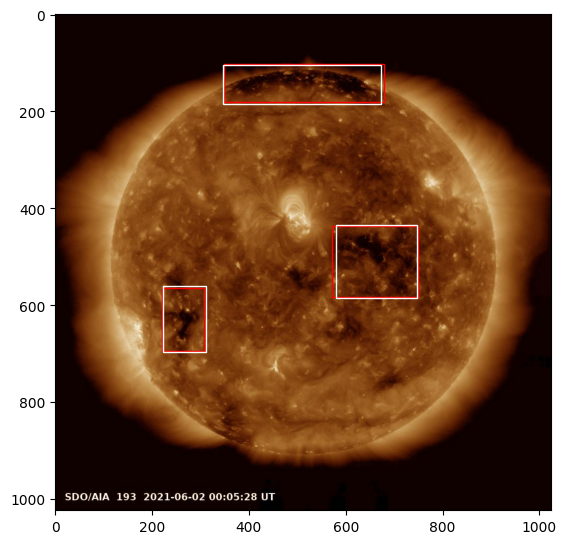

In [46]:
sample = df_valid_coronalHole_set.iloc[150]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "exp", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

# sunspot

In [47]:
df_train_sunspot.head()

id  \
9   8432fe12520748e1b6ee66b9457b6d0a   
12  117f20b34e6b4b99b02b1576a72176b0   
14  b33e6cc0ff5040d7b82c61120335a73c   
17  18a585175ad04513ae89a1cbb7829ca0   
19  c6abab311c624a359ddaf963cd190136   

                                           image_path  \
9   /mnt/elice/dataset/train/images/8432fe12520748...   
12  /mnt/elice/dataset/train/images/117f20b34e6b4b...   
14  /mnt/elice/dataset/train/images/b33e6cc0ff5040...   
17  /mnt/elice/dataset/train/images/18a585175ad045...   
19  /mnt/elice/dataset/train/images/c6abab311c624a...   

                                           label_path  \
9   /mnt/elice/dataset/train/labels/8432fe12520748...   
12  /mnt/elice/dataset/train/labels/117f20b34e6b4b...   
14  /mnt/elice/dataset/train/labels/b33e6cc0ff5040...   
17  /mnt/elice/dataset/train/labels/18a585175ad045...   
19  /mnt/elice/dataset/train/labels/c6abab311c624a...   

                                               labels  class  
9                                                  []      1  
12  [{'class_id': 1, 'x': 0.41546809673309326, 'y'...      1  
14  [{'class_id': 1, 'x': 0.34275510907173157, 'y'...      1  
17  [{'class_id': 1, 'x': 0.6765461564064026, 'y':...      1  
19  [{'class_id': 1, 'x': 0.5776177644729614, 'y':...      1

In [48]:
'''
def update_class_id(labels):
    for label in labels:
        label['class_id'] = 0
    return labels

df_train_sunspot['labels'] = df_train_sunspot['labels'].apply(update_class_id)
'''

"\ndef update_class_id(labels):\n    for label in labels:\n        label['class_id'] = 0\n    return labels\n\ndf_train_sunspot['labels'] = df_train_sunspot['labels'].apply(update_class_id)\n"

## Data Preprocessing

### Data Split

In [49]:
df_train_sunspot_set = df_train_sunspot.sample(frac=0.8, random_state=0)
df_valid_sunspot_set = df_train_sunspot.drop(df_train_sunspot_set.index)

df_train_sunspot_set.to_csv("train_sunspot_set.csv", index=False)
df_valid_sunspot_set.to_csv("valid_sunspot_set.csv", index=False)

new_train_sunspot_path = os.path.abspath("train_sunspot")
new_valid_sunspot_path = os.path.abspath("valid_sunspot")

os.makedirs(new_train_sunspot_path, exist_ok=True)
os.makedirs(os.path.join(new_train_sunspot_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_sunspot_path, LABELS_DIR), exist_ok=True)

os.makedirs(new_valid_sunspot_path, exist_ok=True)
os.makedirs(os.path.join(new_valid_sunspot_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_valid_sunspot_path, LABELS_DIR), exist_ok=True)

### Data preprocessing and copy

Resize and copy into each folder

YOLO model uses relative coordinate, so label resizing is not needed.

Resizing the label might be needed depends on your model.

In [50]:
for i, row in tqdm(df_train_sunspot_set.iterrows(), total=len(df_train_sunspot_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_sunspot_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_train_sunspot_path}/{LABELS_DIR}/{row['id']}.txt")

for i, row in tqdm(df_valid_sunspot_set.iterrows(), total=len(df_valid_sunspot_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_sunspot_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_valid_sunspot_path}/{LABELS_DIR}/{row['id']}.txt")

100%|██████████| 3398/3398 [00:30<00:00, 110.19it/s]


## Model Training

### Training

In [51]:
dataset = {
    "path": os.path.abspath("."),
    "train": "train_sunspot",
    "val": "valid_sunspot",
    "nc": 2,
    "names": ["none", "sunspot"],
}

YAML_PATH = os.path.abspath("sunspot.yaml")
RESULT_PATH = os.path.abspath("result6_sunspot")
os.makedirs(RESULT_PATH, exist_ok=True)

with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [52]:
!PYTHONWARNINGS="ignore::FutureWarning" python yolov5/train.py --img {IMAGE_SIZE} --batch {BATCH} --epoch {EPOCH} --data {YAML_PATH} --cfg yolov5s.yaml --exist-ok --weights "" --name sunspot --project {RESULT_PATH}

train: weights=, cfg=yolov5s.yaml, data=/home/elicer/sunspot.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=64, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/elicer/result6_sunspot, name=sunspot, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

hyperparameters: lr0=0.01, lrf=0.01, momen


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/69      29.2G    0.03368    0.03011  0.0001396         53       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.911      0.915      0.961      0.581

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/69      29.2G    0.03339    0.02939  0.0001272         54       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.909      0.912      0.961      0.576

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/69      29.2G    0.03323    0.02955  0.0001205        106       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.911      0.917      0.963      0.572

      Epo


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/69      29.2G    0.02976    0.02747  5.137e-05         85       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.948      0.955      0.985      0.623

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/69      29.2G    0.02964    0.02719  5.035e-05         61       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.951      0.955      0.985      0.631

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/69      29.2G    0.02959    0.02725  4.932e-05         55       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.953      0.956      0.985      0.633

      Epo


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/69      29.2G    0.02695    0.02566  2.781e-05         73       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.969      0.973      0.991      0.684

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      60/69      29.2G    0.02685    0.02526  2.728e-05         78       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.969      0.973      0.991      0.685

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      61/69      29.2G    0.02664    0.02547  2.694e-05         81       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       4854      18801      0.969      0.974      0.991      0.687

      Epo

## Model Validation

### Valid Data Inference

In [53]:
!python yolov5/detect.py --source {os.path.join(new_valid_sunspot_path, IMAGE_DIR)} --weights {RESULT_PATH}/sunspot/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/valid

detect: weights=['/home/elicer/result6_sunspot/sunspot/weights/best.pt'], source=/home/elicer/valid_sunspot/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/elicer/result6_sunspot/valid, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/4854 /home/elicer/valid_sunspot/images/0002e2b5a306447db3895d735c2c118d.jpg: 640x640 7 sunspots, 5.1ms
image 2/4854 /home/elicer/valid_sunspot/images/0007225a5a614d11b4163f1c8a690485_aug.jpg: 640x640 3 sunspots, 5.4ms
image 3/4854 /home/elicer/

image 68/4854 /home/elicer/valid_sunspot/images/03716201dcb8456387c7aaf8c5b983ba_aug.jpg: 640x640 2 sunspots, 5.1ms
image 69/4854 /home/elicer/valid_sunspot/images/03716201dcb8456387c7aaf8c5b983ba_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 70/4854 /home/elicer/valid_sunspot/images/03f0a1d1a2054799a1343d59279ed87e.jpg: 640x640 6 sunspots, 5.0ms
image 71/4854 /home/elicer/valid_sunspot/images/04117c55e27b4a67a0f95a2adbf80636.jpg: 640x640 3 sunspots, 5.0ms
image 72/4854 /home/elicer/valid_sunspot/images/042072fc838c4b199ce51bb3b20b2d48_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 73/4854 /home/elicer/valid_sunspot/images/0464261923384e9bb306c2411ec74c3c.jpg: 640x640 4 sunspots, 5.0ms
image 74/4854 /home/elicer/valid_sunspot/images/0464261923384e9bb306c2411ec74c3c_aug.jpg: 640x640 4 sunspots, 5.1ms
image 75/4854 /home/elicer/valid_sunspot/images/0464261923384e9bb306c2411ec74c3c_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 76/4854 /home/elicer/valid_sunspot/images/049c075899df433797cdc5f5365

image 141/4854 /home/elicer/valid_sunspot/images/07ee1992384d4b319d5b14e6f3058b8c_aug.jpg: 640x640 2 sunspots, 5.0ms
image 142/4854 /home/elicer/valid_sunspot/images/08012bbf3e884947831c7bc651b4cd26_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 143/4854 /home/elicer/valid_sunspot/images/08484826cca647cc9c9a5608b1d67732.jpg: 640x640 4 sunspots, 5.0ms
image 144/4854 /home/elicer/valid_sunspot/images/08484826cca647cc9c9a5608b1d67732_aug_lr.jpg: 640x640 4 sunspots, 5.2ms
image 145/4854 /home/elicer/valid_sunspot/images/084d2f13092b4f6084b4f0e7c91fdfb3_aug.jpg: 640x640 2 sunspots, 5.1ms
image 146/4854 /home/elicer/valid_sunspot/images/084d2f13092b4f6084b4f0e7c91fdfb3_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 147/4854 /home/elicer/valid_sunspot/images/086cec6115e94ac4b5635f4b9cd9baa8.jpg: 640x640 4 sunspots, 5.0ms
image 148/4854 /home/elicer/valid_sunspot/images/086cec6115e94ac4b5635f4b9cd9baa8_aug.jpg: 640x640 4 sunspots, 5.0ms
image 149/4854 /home/elicer/valid_sunspot/images/086cec6115e94a

image 213/4854 /home/elicer/valid_sunspot/images/0c1a40d3a36449d9858b0f27f578f237_aug.jpg: 640x640 1 sunspot, 5.2ms
image 214/4854 /home/elicer/valid_sunspot/images/0c1b7578f6db42bab65814fbf303fc1b.jpg: 640x640 2 sunspots, 5.1ms
image 215/4854 /home/elicer/valid_sunspot/images/0c1b7578f6db42bab65814fbf303fc1b_aug.jpg: 640x640 2 sunspots, 5.0ms
image 216/4854 /home/elicer/valid_sunspot/images/0c1b7578f6db42bab65814fbf303fc1b_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 217/4854 /home/elicer/valid_sunspot/images/0c31f091b9194bf19cf536a12509637d_aug.jpg: 640x640 6 sunspots, 5.0ms
image 218/4854 /home/elicer/valid_sunspot/images/0c31f091b9194bf19cf536a12509637d_aug_tb.jpg: 640x640 6 sunspots, 5.0ms
image 219/4854 /home/elicer/valid_sunspot/images/0c45667adec94322aee2db3e40efec2b_aug.jpg: 640x640 5 sunspots, 5.0ms
image 220/4854 /home/elicer/valid_sunspot/images/0c48d779142341cebcfcc5875edb0b17.jpg: 640x640 5 sunspots, 5.1ms
image 221/4854 /home/elicer/valid_sunspot/images/0c54653c842c41d29b

image 285/4854 /home/elicer/valid_sunspot/images/0f9f4f61a6d747f5b6371ff850f10f68_aug_lr.jpg: 640x640 8 sunspots, 5.0ms
image 286/4854 /home/elicer/valid_sunspot/images/0fababc200e54a4a8538308e0a3e4c1e_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 287/4854 /home/elicer/valid_sunspot/images/0fbbe788b5194cec90883833afd76205_aug.jpg: 640x640 5 sunspots, 5.0ms
image 288/4854 /home/elicer/valid_sunspot/images/100f5f89a7d945e6aff7f5e6971bf0a6_aug.jpg: 640x640 7 sunspots, 5.1ms
image 289/4854 /home/elicer/valid_sunspot/images/103551bce0554b819bcab842a7e09996_aug.jpg: 640x640 3 sunspots, 5.0ms
image 290/4854 /home/elicer/valid_sunspot/images/103551bce0554b819bcab842a7e09996_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 291/4854 /home/elicer/valid_sunspot/images/1038ff4eee894a77bfe2930e7b989852.jpg: 640x640 (no detections), 5.0ms
image 292/4854 /home/elicer/valid_sunspot/images/1038ff4eee894a77bfe2930e7b989852_aug.jpg: 640x640 (no detections), 5.0ms
image 293/4854 /home/elicer/valid_sunspot/images/

image 356/4854 /home/elicer/valid_sunspot/images/12b6ddee489f466296a9d43add36cd58.jpg: 640x640 6 sunspots, 5.1ms
image 357/4854 /home/elicer/valid_sunspot/images/12bda79c9159451dbcc7d4b7309e3826_aug.jpg: 640x640 7 sunspots, 5.0ms
image 358/4854 /home/elicer/valid_sunspot/images/12f862def18c470786ef75fa2a4b4961.jpg: 640x640 1 sunspot, 5.0ms
image 359/4854 /home/elicer/valid_sunspot/images/131427f90f8e496c83dbc089e5d12b9d.jpg: 640x640 3 sunspots, 5.0ms
image 360/4854 /home/elicer/valid_sunspot/images/131427f90f8e496c83dbc089e5d12b9d_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 361/4854 /home/elicer/valid_sunspot/images/131427f90f8e496c83dbc089e5d12b9d_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 362/4854 /home/elicer/valid_sunspot/images/1355a09bcebe4cd08b14d9ee16fd45fe_aug_lr.jpg: 640x640 3 sunspots, 5.2ms
image 363/4854 /home/elicer/valid_sunspot/images/135bc07f459c42169ada13acb30b0c2f.jpg: 640x640 7 sunspots, 5.1ms
image 364/4854 /home/elicer/valid_sunspot/images/135bc07f459c42169ada13a

image 427/4854 /home/elicer/valid_sunspot/images/16bff64851314db0825530cf1c040ff2_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 428/4854 /home/elicer/valid_sunspot/images/16ca6cd68b454c42aa3f4c0c1c7c2771_aug.jpg: 640x640 4 sunspots, 5.0ms
image 429/4854 /home/elicer/valid_sunspot/images/16d5d6dcfd3245ecb2b2972d1514bfc4_aug.jpg: 640x640 7 sunspots, 5.0ms
image 430/4854 /home/elicer/valid_sunspot/images/16e4a29e350d43108c6a97f0cc3aa4d5.jpg: 640x640 4 sunspots, 5.0ms
image 431/4854 /home/elicer/valid_sunspot/images/16e4a29e350d43108c6a97f0cc3aa4d5_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 432/4854 /home/elicer/valid_sunspot/images/16e4def278ce4150bad26d5d5f92c8b8.jpg: 640x640 5 sunspots, 5.0ms
image 433/4854 /home/elicer/valid_sunspot/images/16e4def278ce4150bad26d5d5f92c8b8_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 434/4854 /home/elicer/valid_sunspot/images/16f6c7d6757443f0bd31e099f96804b9.jpg: 640x640 6 sunspots, 5.0ms
image 435/4854 /home/elicer/valid_sunspot/images/17014a94a58f4ebbb95

image 498/4854 /home/elicer/valid_sunspot/images/19a419b8d1ef4146ae418f1d62b84653_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 499/4854 /home/elicer/valid_sunspot/images/19c0c1e65ba04c5db32f00c10311618d_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 500/4854 /home/elicer/valid_sunspot/images/19e2b2c09b274ad5b048927f7b257fd5.jpg: 640x640 1 sunspot, 5.0ms
image 501/4854 /home/elicer/valid_sunspot/images/19e4da3f9ed242d6a5fca75b740cca34_aug.jpg: 640x640 5 sunspots, 5.1ms
image 502/4854 /home/elicer/valid_sunspot/images/19e4da3f9ed242d6a5fca75b740cca34_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 503/4854 /home/elicer/valid_sunspot/images/1a1fa9e185304f32b4e1cfa1838a3b84.jpg: 640x640 2 sunspots, 5.0ms
image 504/4854 /home/elicer/valid_sunspot/images/1a1fa9e185304f32b4e1cfa1838a3b84_aug.jpg: 640x640 2 sunspots, 5.0ms
image 505/4854 /home/elicer/valid_sunspot/images/1a256655cece4cb486150f5108e637d7_aug.jpg: 640x640 7 sunspots, 5.0ms
image 506/4854 /home/elicer/valid_sunspot/images/1a318ff07471431d

image 570/4854 /home/elicer/valid_sunspot/images/1dd883f21f864158a434671ce0eed1de.jpg: 640x640 3 sunspots, 5.1ms
image 571/4854 /home/elicer/valid_sunspot/images/1e0072faafa8458e9d64e769b78ba673.jpg: 640x640 6 sunspots, 5.0ms
image 572/4854 /home/elicer/valid_sunspot/images/1e0072faafa8458e9d64e769b78ba673_aug_lr.jpg: 640x640 6 sunspots, 5.0ms
image 573/4854 /home/elicer/valid_sunspot/images/1e05e9f8bc744fd69415bc2ba97b8f57.jpg: 640x640 4 sunspots, 5.0ms
image 574/4854 /home/elicer/valid_sunspot/images/1e089eb729574beb938790bab01368c3.jpg: 640x640 7 sunspots, 5.0ms
image 575/4854 /home/elicer/valid_sunspot/images/1e1955ad7ee94b6ab9fc74391513925c_aug.jpg: 640x640 9 sunspots, 5.1ms
image 576/4854 /home/elicer/valid_sunspot/images/1e2c8e1988aa42bc9b94809f16dff420_aug.jpg: 640x640 4 sunspots, 5.2ms
image 577/4854 /home/elicer/valid_sunspot/images/1e36e82122964b2b8e40b5169a7e867d.jpg: 640x640 2 sunspots, 5.0ms
image 578/4854 /home/elicer/valid_sunspot/images/1e36e82122964b2b8e40b5169a7e867d

image 642/4854 /home/elicer/valid_sunspot/images/20eaecbfc7194492925e7e2164afaea4_aug.jpg: 640x640 2 sunspots, 5.0ms
image 643/4854 /home/elicer/valid_sunspot/images/20f73e7050da4a71a117d25055dab154.jpg: 640x640 1 sunspot, 5.0ms
image 644/4854 /home/elicer/valid_sunspot/images/20f73e7050da4a71a117d25055dab154_aug.jpg: 640x640 1 sunspot, 5.0ms
image 645/4854 /home/elicer/valid_sunspot/images/20f9ecf50d0a451bb0f35d0b818115f6.jpg: 640x640 2 sunspots, 5.0ms
image 646/4854 /home/elicer/valid_sunspot/images/20f9ecf50d0a451bb0f35d0b818115f6_aug.jpg: 640x640 2 sunspots, 5.0ms
image 647/4854 /home/elicer/valid_sunspot/images/20f9ecf50d0a451bb0f35d0b818115f6_aug_tb.jpg: 640x640 2 sunspots, 5.1ms
image 648/4854 /home/elicer/valid_sunspot/images/20fc1820f8a849d8ac685fb4a065ced6_aug.jpg: 640x640 8 sunspots, 5.0ms
image 649/4854 /home/elicer/valid_sunspot/images/211777e4bd4c47beb173be790dd5737d.jpg: 640x640 4 sunspots, 5.1ms
image 650/4854 /home/elicer/valid_sunspot/images/211777e4bd4c47beb173be790d

image 714/4854 /home/elicer/valid_sunspot/images/250ffc1afffa4cf0a7c5d4d77f62c272_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 715/4854 /home/elicer/valid_sunspot/images/2519b303c0dc4262bacd8541c64b5afd.jpg: 640x640 1 sunspot, 5.1ms
image 716/4854 /home/elicer/valid_sunspot/images/2519b303c0dc4262bacd8541c64b5afd_aug.jpg: 640x640 1 sunspot, 5.0ms
image 717/4854 /home/elicer/valid_sunspot/images/251d33c138e4482a9fcc7c8bb8b7d624.jpg: 640x640 3 sunspots, 5.0ms
image 718/4854 /home/elicer/valid_sunspot/images/251d33c138e4482a9fcc7c8bb8b7d624_aug.jpg: 640x640 3 sunspots, 5.0ms
image 719/4854 /home/elicer/valid_sunspot/images/251d33c138e4482a9fcc7c8bb8b7d624_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 720/4854 /home/elicer/valid_sunspot/images/251f5c6b61f94056a173fe65b4665264.jpg: 640x640 4 sunspots, 5.0ms
image 721/4854 /home/elicer/valid_sunspot/images/251f5c6b61f94056a173fe65b4665264_aug.jpg: 640x640 4 sunspots, 5.0ms
image 722/4854 /home/elicer/valid_sunspot/images/252230de43304627bdcaf12

image 786/4854 /home/elicer/valid_sunspot/images/292ee60fb06a487fa9d25b6d510c674f_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 787/4854 /home/elicer/valid_sunspot/images/2948a77da6c647b89a148a5bcf12aa58.jpg: 640x640 6 sunspots, 5.2ms
image 788/4854 /home/elicer/valid_sunspot/images/29618faae0d74a5c9adbcb4fc4005ddf.jpg: 640x640 2 sunspots, 5.1ms
image 789/4854 /home/elicer/valid_sunspot/images/297784a19a1a4d3c9ba2bf13e42d60ad_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 790/4854 /home/elicer/valid_sunspot/images/2978d9629456429d9128f7c4299e4bac.jpg: 640x640 3 sunspots, 5.0ms
image 791/4854 /home/elicer/valid_sunspot/images/2978d9629456429d9128f7c4299e4bac_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 792/4854 /home/elicer/valid_sunspot/images/297aeba9114243e1a26580d0a3917db3_aug.jpg: 640x640 7 sunspots, 5.0ms
image 793/4854 /home/elicer/valid_sunspot/images/29859808c470450bbf6d12bebc8525ca_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 794/4854 /home/elicer/valid_sunspot/images/2999d0bc3910452

image 857/4854 /home/elicer/valid_sunspot/images/2c00b621bfba44bab1dd3dc01ee85931_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 858/4854 /home/elicer/valid_sunspot/images/2c36930d36af42c191db56b3c6d9e3b5.jpg: 640x640 3 sunspots, 5.0ms
image 859/4854 /home/elicer/valid_sunspot/images/2c36930d36af42c191db56b3c6d9e3b5_aug.jpg: 640x640 3 sunspots, 5.0ms
image 860/4854 /home/elicer/valid_sunspot/images/2c419c4cb72944258f64795514eaa6c2.jpg: 640x640 4 sunspots, 5.0ms
image 861/4854 /home/elicer/valid_sunspot/images/2c419c4cb72944258f64795514eaa6c2_aug.jpg: 640x640 4 sunspots, 5.2ms
image 862/4854 /home/elicer/valid_sunspot/images/2c503c5ee3614ab6bed4ab2b0e5a8bf3.jpg: 640x640 5 sunspots, 5.1ms
image 863/4854 /home/elicer/valid_sunspot/images/2c503c5ee3614ab6bed4ab2b0e5a8bf3_aug.jpg: 640x640 5 sunspots, 5.1ms
image 864/4854 /home/elicer/valid_sunspot/images/2c82ca2fbdc5451eb12890ea1fbcfd7f.jpg: 640x640 3 sunspots, 5.0ms
image 865/4854 /home/elicer/valid_sunspot/images/2c82ca2fbdc5451eb12890ea1fbcf

image 928/4854 /home/elicer/valid_sunspot/images/301f37839ab14ea5bb06f531bb9013f0.jpg: 640x640 5 sunspots, 5.1ms
image 929/4854 /home/elicer/valid_sunspot/images/302053e1b5434aadab917e0d8594c011_aug.jpg: 640x640 1 sunspot, 5.1ms
image 930/4854 /home/elicer/valid_sunspot/images/302053e1b5434aadab917e0d8594c011_aug_tb.jpg: 640x640 1 sunspot, 5.1ms
image 931/4854 /home/elicer/valid_sunspot/images/302cd5574f18498f8e64840e0042bc48.jpg: 640x640 1 sunspot, 5.0ms
image 932/4854 /home/elicer/valid_sunspot/images/302d764c676d4154b193f6b4c1c0d892.jpg: 640x640 4 sunspots, 5.0ms
image 933/4854 /home/elicer/valid_sunspot/images/302d764c676d4154b193f6b4c1c0d892_aug.jpg: 640x640 4 sunspots, 5.0ms
image 934/4854 /home/elicer/valid_sunspot/images/302d9381fc7e4f19b30fc52a7fdc7318_aug.jpg: 640x640 6 sunspots, 5.0ms
image 935/4854 /home/elicer/valid_sunspot/images/304584fe344046e2a7d19de9b787f8ba_aug_tb.jpg: 640x640 (no detections), 5.2ms
image 936/4854 /home/elicer/valid_sunspot/images/3048394e65e14a72bc7

image 1001/4854 /home/elicer/valid_sunspot/images/3307107a30aa45f0bceb954ebdc627be.jpg: 640x640 3 sunspots, 5.1ms
image 1002/4854 /home/elicer/valid_sunspot/images/3307107a30aa45f0bceb954ebdc627be_aug.jpg: 640x640 3 sunspots, 5.1ms
image 1003/4854 /home/elicer/valid_sunspot/images/33214ba914d54a66bfc293bdf338ae8b_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 1004/4854 /home/elicer/valid_sunspot/images/336d3b3e47bf4b45b87edf98317c1d85_aug.jpg: 640x640 6 sunspots, 5.0ms
image 1005/4854 /home/elicer/valid_sunspot/images/3381caeb88744da59a9711635a2ba721_aug.jpg: 640x640 8 sunspots, 5.0ms
image 1006/4854 /home/elicer/valid_sunspot/images/3385a2c4a0bf4571b12ca9b063a92aea.jpg: 640x640 5 sunspots, 5.0ms
image 1007/4854 /home/elicer/valid_sunspot/images/3385a2c4a0bf4571b12ca9b063a92aea_aug.jpg: 640x640 4 sunspots, 5.0ms
image 1008/4854 /home/elicer/valid_sunspot/images/3385a2c4a0bf4571b12ca9b063a92aea_aug_lr.jpg: 640x640 4 sunspots, 5.2ms
image 1009/4854 /home/elicer/valid_sunspot/images/33a2dc32

image 1072/4854 /home/elicer/valid_sunspot/images/379422e54dac41f3beaa6d372b9d9212_aug_tb.jpg: 640x640 2 sunspots, 5.2ms
image 1073/4854 /home/elicer/valid_sunspot/images/37a208aea02b4e29b6035335af043afc_aug.jpg: 640x640 2 sunspots, 5.2ms
image 1074/4854 /home/elicer/valid_sunspot/images/37a208aea02b4e29b6035335af043afc_aug_lr.jpg: 640x640 2 sunspots, 5.6ms
image 1075/4854 /home/elicer/valid_sunspot/images/37d938b9fa5b439ca8882b0897c36e87.jpg: 640x640 6 sunspots, 5.3ms
image 1076/4854 /home/elicer/valid_sunspot/images/37d938b9fa5b439ca8882b0897c36e87_aug.jpg: 640x640 6 sunspots, 5.4ms
image 1077/4854 /home/elicer/valid_sunspot/images/37d938b9fa5b439ca8882b0897c36e87_aug_tb.jpg: 640x640 6 sunspots, 5.2ms
image 1078/4854 /home/elicer/valid_sunspot/images/37e82edab082410eb596a7b51d8b4332_aug.jpg: 640x640 (no detections), 5.3ms
image 1079/4854 /home/elicer/valid_sunspot/images/37e94ac5e46345f4803127b308e5476d_aug_tb.jpg: 640x640 5 sunspots, 5.3ms
image 1080/4854 /home/elicer/valid_sunspot/

image 1142/4854 /home/elicer/valid_sunspot/images/3b54738162b5494a9f4fc9f3024a0591_aug.jpg: 640x640 5 sunspots, 5.5ms
image 1143/4854 /home/elicer/valid_sunspot/images/3b6d0f5e86564115abefd5b240c2c113_aug.jpg: 640x640 3 sunspots, 5.2ms
image 1144/4854 /home/elicer/valid_sunspot/images/3b6d0f5e86564115abefd5b240c2c113_aug_lr.jpg: 640x640 3 sunspots, 5.3ms
image 1145/4854 /home/elicer/valid_sunspot/images/3b6d0f5e86564115abefd5b240c2c113_aug_tb.jpg: 640x640 3 sunspots, 5.5ms
image 1146/4854 /home/elicer/valid_sunspot/images/3b7bfc6ee801483b9f89ca19143d0921_aug.jpg: 640x640 6 sunspots, 5.4ms
image 1147/4854 /home/elicer/valid_sunspot/images/3b7bfc6ee801483b9f89ca19143d0921_aug_lr.jpg: 640x640 6 sunspots, 5.6ms
image 1148/4854 /home/elicer/valid_sunspot/images/3b845d72f3b44e4dba8222d5f415ec83.jpg: 640x640 4 sunspots, 5.6ms
image 1149/4854 /home/elicer/valid_sunspot/images/3b845d72f3b44e4dba8222d5f415ec83_aug.jpg: 640x640 4 sunspots, 5.3ms
image 1150/4854 /home/elicer/valid_sunspot/images/3

image 1214/4854 /home/elicer/valid_sunspot/images/3ef83fc7d86841b699f4733c697cbb28.jpg: 640x640 2 sunspots, 5.0ms
image 1215/4854 /home/elicer/valid_sunspot/images/3ef83fc7d86841b699f4733c697cbb28_aug.jpg: 640x640 2 sunspots, 5.0ms
image 1216/4854 /home/elicer/valid_sunspot/images/3eff690ff5ea4fa48fdc8919693b3a64_aug.jpg: 640x640 2 sunspots, 5.0ms
image 1217/4854 /home/elicer/valid_sunspot/images/3f011c7f2f4143b9ba61726dc4822eff_aug.jpg: 640x640 4 sunspots, 5.0ms
image 1218/4854 /home/elicer/valid_sunspot/images/3f07b789e3a54b50816ed7818ef84ec9.jpg: 640x640 3 sunspots, 5.0ms
image 1219/4854 /home/elicer/valid_sunspot/images/3f07b789e3a54b50816ed7818ef84ec9_aug.jpg: 640x640 3 sunspots, 5.2ms
image 1220/4854 /home/elicer/valid_sunspot/images/3f13afe02bf64e599d96522a83b059e3_aug.jpg: 640x640 1 sunspot, 5.1ms
image 1221/4854 /home/elicer/valid_sunspot/images/3f1ab2c444c742d9b4a123ea84b44486_aug.jpg: 640x640 3 sunspots, 5.1ms
image 1222/4854 /home/elicer/valid_sunspot/images/3f377779eec747b

image 1284/4854 /home/elicer/valid_sunspot/images/42db5d13777a41c1888ffa7e59985311.jpg: 640x640 1 sunspot, 5.0ms
image 1285/4854 /home/elicer/valid_sunspot/images/42db5d13777a41c1888ffa7e59985311_aug.jpg: 640x640 1 sunspot, 5.0ms
image 1286/4854 /home/elicer/valid_sunspot/images/42db9718017c42cc8c98a0b1a9a55087_aug.jpg: 640x640 4 sunspots, 5.2ms
image 1287/4854 /home/elicer/valid_sunspot/images/42e49a1d06174394b03ab1ef042e40d4_aug_tb.jpg: 640x640 2 sunspots, 5.1ms
image 1288/4854 /home/elicer/valid_sunspot/images/42f1289f305a4cefb2d775ff2694f83b_aug.jpg: 640x640 3 sunspots, 5.1ms
image 1289/4854 /home/elicer/valid_sunspot/images/42f7ebb5d65d40569e7e1c3e958a03df.jpg: 640x640 3 sunspots, 5.0ms
image 1290/4854 /home/elicer/valid_sunspot/images/42fc51b33f4b406398996f16658d61e9_aug_lr.jpg: 640x640 9 sunspots, 5.0ms
image 1291/4854 /home/elicer/valid_sunspot/images/432a66acf96c4d88b8fa147092abae08.jpg: 640x640 6 sunspots, 5.0ms
image 1292/4854 /home/elicer/valid_sunspot/images/4342324dac5747

image 1354/4854 /home/elicer/valid_sunspot/images/46a6f80c5dfa42b7a09243ffc0349dea_aug.jpg: 640x640 2 sunspots, 5.2ms
image 1355/4854 /home/elicer/valid_sunspot/images/46a6f80c5dfa42b7a09243ffc0349dea_aug_tb.jpg: 640x640 2 sunspots, 5.1ms
image 1356/4854 /home/elicer/valid_sunspot/images/46b854e257ee42f4bf5aaf75fff0087f_aug.jpg: 640x640 (no detections), 5.1ms
image 1357/4854 /home/elicer/valid_sunspot/images/46c36bf5a5824cf48251329de8b835b5_aug_lr.jpg: 640x640 9 sunspots, 5.1ms
image 1358/4854 /home/elicer/valid_sunspot/images/46cf77e9d4e042c7b035dadd4e8b7296_aug.jpg: 640x640 8 sunspots, 5.2ms
image 1359/4854 /home/elicer/valid_sunspot/images/46f2314b6e6f4234859e2afa3e821072.jpg: 640x640 6 sunspots, 5.1ms
image 1360/4854 /home/elicer/valid_sunspot/images/46f2314b6e6f4234859e2afa3e821072_aug.jpg: 640x640 6 sunspots, 5.1ms
image 1361/4854 /home/elicer/valid_sunspot/images/46f4b6a0292d4f76b8fcb024398c1fe2.jpg: 640x640 4 sunspots, 5.1ms
image 1362/4854 /home/elicer/valid_sunspot/images/470

image 1426/4854 /home/elicer/valid_sunspot/images/4a254db68c704e32a412a50b4add2ef4.jpg: 640x640 3 sunspots, 5.1ms
image 1427/4854 /home/elicer/valid_sunspot/images/4a30be9b7a58441393c4a33ab632c382.jpg: 640x640 4 sunspots, 5.1ms
image 1428/4854 /home/elicer/valid_sunspot/images/4a41284db97640b3bff6394aa87d6918.jpg: 640x640 5 sunspots, 5.1ms
image 1429/4854 /home/elicer/valid_sunspot/images/4a41284db97640b3bff6394aa87d6918_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 1430/4854 /home/elicer/valid_sunspot/images/4a9f18aa4be042fbbabad974d2fad6a4_aug_lr.jpg: 640x640 8 sunspots, 5.0ms
image 1431/4854 /home/elicer/valid_sunspot/images/4ac0b448832e464d9f555ac8ad163594.jpg: 640x640 3 sunspots, 5.0ms
image 1432/4854 /home/elicer/valid_sunspot/images/4ac0b448832e464d9f555ac8ad163594_aug.jpg: 640x640 4 sunspots, 5.0ms
image 1433/4854 /home/elicer/valid_sunspot/images/4ac0b448832e464d9f555ac8ad163594_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 1434/4854 /home/elicer/valid_sunspot/images/4ad643709e634

image 1498/4854 /home/elicer/valid_sunspot/images/4d5e6cf979714ce7be68fb7b8813f4ab_aug_lr.jpg: 640x640 6 sunspots, 5.0ms
image 1499/4854 /home/elicer/valid_sunspot/images/4d5e6cf979714ce7be68fb7b8813f4ab_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 1500/4854 /home/elicer/valid_sunspot/images/4d6fafc3481f41aeae9549b65a924ff2.jpg: 640x640 1 sunspot, 5.1ms
image 1501/4854 /home/elicer/valid_sunspot/images/4d6fafc3481f41aeae9549b65a924ff2_aug.jpg: 640x640 1 sunspot, 5.1ms
image 1502/4854 /home/elicer/valid_sunspot/images/4d6fcb7f4d584262a1a4060377604b63_aug.jpg: 640x640 10 sunspots, 5.0ms
image 1503/4854 /home/elicer/valid_sunspot/images/4d99b27124ae4829a336873c3763521b_aug.jpg: 640x640 (no detections), 5.0ms
image 1504/4854 /home/elicer/valid_sunspot/images/4da01acf610c4165812554f95ece461f.jpg: 640x640 2 sunspots, 5.0ms
image 1505/4854 /home/elicer/valid_sunspot/images/4da01acf610c4165812554f95ece461f_aug.jpg: 640x640 2 sunspots, 5.0ms
image 1506/4854 /home/elicer/valid_sunspot/images/4db9

image 1568/4854 /home/elicer/valid_sunspot/images/502647a1ed464704a9dfc65dca99c156_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 1569/4854 /home/elicer/valid_sunspot/images/5039bb84bc6a4339be27f188cd75bda4_aug.jpg: 640x640 2 sunspots, 5.0ms
image 1570/4854 /home/elicer/valid_sunspot/images/506df8621658491b85879754c256bf8e_aug.jpg: 640x640 7 sunspots, 5.0ms
image 1571/4854 /home/elicer/valid_sunspot/images/50842f2c436b48639d671c8085cdb7a9_aug.jpg: 640x640 3 sunspots, 5.0ms
image 1572/4854 /home/elicer/valid_sunspot/images/50842f2c436b48639d671c8085cdb7a9_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 1573/4854 /home/elicer/valid_sunspot/images/50842f2c436b48639d671c8085cdb7a9_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 1574/4854 /home/elicer/valid_sunspot/images/5093d60d412d4498b8abc81aead2b1af.jpg: 640x640 5 sunspots, 5.0ms
image 1575/4854 /home/elicer/valid_sunspot/images/509a16eb59164e71a788e2f758030c48.jpg: 640x640 6 sunspots, 5.1ms
image 1576/4854 /home/elicer/valid_sunspot/images/50c3c

image 1639/4854 /home/elicer/valid_sunspot/images/539aa3f2de224aa996e2815647fec9ee_aug.jpg: 640x640 4 sunspots, 5.0ms
image 1640/4854 /home/elicer/valid_sunspot/images/539aa3f2de224aa996e2815647fec9ee_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 1641/4854 /home/elicer/valid_sunspot/images/539f49f1a0e4478f875a9f59784aa931.jpg: 640x640 6 sunspots, 5.0ms
image 1642/4854 /home/elicer/valid_sunspot/images/53af5ef974ba4f7a8448f5248e26adbd.jpg: 640x640 6 sunspots, 5.0ms
image 1643/4854 /home/elicer/valid_sunspot/images/53af5ef974ba4f7a8448f5248e26adbd_aug_tb.jpg: 640x640 6 sunspots, 5.1ms
image 1644/4854 /home/elicer/valid_sunspot/images/53b27e709bf7470bbbe1b9aec1384caf.jpg: 640x640 9 sunspots, 5.0ms
image 1645/4854 /home/elicer/valid_sunspot/images/53cbced07f904b6dbf7ae1d86a9c0237_aug_lr.jpg: 640x640 6 sunspots, 5.0ms
image 1646/4854 /home/elicer/valid_sunspot/images/53d7ab00af2f4aa98345252c889c5235.jpg: 640x640 9 sunspots, 5.0ms
image 1647/4854 /home/elicer/valid_sunspot/images/53d7ab00af2f4

image 1709/4854 /home/elicer/valid_sunspot/images/56c169c35e0a43a9aa21ae9afa70b5bf_aug.jpg: 640x640 4 sunspots, 5.0ms
image 1710/4854 /home/elicer/valid_sunspot/images/572b9bd735b245398641f86a6d789f46_aug.jpg: 640x640 (no detections), 5.0ms
image 1711/4854 /home/elicer/valid_sunspot/images/572b9bd735b245398641f86a6d789f46_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1712/4854 /home/elicer/valid_sunspot/images/572ccf2f69e744a68a31b37730c7f6c4.jpg: 640x640 3 sunspots, 5.0ms
image 1713/4854 /home/elicer/valid_sunspot/images/572ccf2f69e744a68a31b37730c7f6c4_aug_lr.jpg: 640x640 3 sunspots, 5.1ms
image 1714/4854 /home/elicer/valid_sunspot/images/5744b2f2fcec4b64893bc241b6587330.jpg: 640x640 5 sunspots, 5.0ms
image 1715/4854 /home/elicer/valid_sunspot/images/5744b2f2fcec4b64893bc241b6587330_aug.jpg: 640x640 5 sunspots, 5.0ms
image 1716/4854 /home/elicer/valid_sunspot/images/574fa2427de5495daeb22ad7c5df9e80_aug.jpg: 640x640 1 sunspot, 5.0ms
image 1717/4854 /home/elicer/valid_sunspot/images

image 1780/4854 /home/elicer/valid_sunspot/images/5b075ff2927242f8a925edadfc1bf35d_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 1781/4854 /home/elicer/valid_sunspot/images/5b0dc76353a94f52a338a0814243a869.jpg: 640x640 10 sunspots, 5.1ms
image 1782/4854 /home/elicer/valid_sunspot/images/5b0dc76353a94f52a338a0814243a869_aug_tb.jpg: 640x640 10 sunspots, 5.0ms
image 1783/4854 /home/elicer/valid_sunspot/images/5b2c8961e76d4120b7ddf267892ee646.jpg: 640x640 7 sunspots, 5.0ms
image 1784/4854 /home/elicer/valid_sunspot/images/5b30013b503046e580f88f23d6463ef3_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 1785/4854 /home/elicer/valid_sunspot/images/5b71133370034c50a3619456d2fa0394_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 1786/4854 /home/elicer/valid_sunspot/images/5b7672f1f4a541519134df814252aef0_aug.jpg: 640x640 6 sunspots, 5.1ms
image 1787/4854 /home/elicer/valid_sunspot/images/5b7672f1f4a541519134df814252aef0_aug_tb.jpg: 640x640 6 sunspots, 5.1ms
image 1788/4854 /home/elicer/valid_sunspot/images

image 1850/4854 /home/elicer/valid_sunspot/images/5e17e31800774680a541400561e49c07.jpg: 640x640 1 sunspot, 5.0ms
image 1851/4854 /home/elicer/valid_sunspot/images/5e5879626cb44611a1b706ba2b7b1c89.jpg: 640x640 7 sunspots, 5.0ms
image 1852/4854 /home/elicer/valid_sunspot/images/5e5879626cb44611a1b706ba2b7b1c89_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 1853/4854 /home/elicer/valid_sunspot/images/5e6d8a326a0f481f919b3556f31caf31_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 1854/4854 /home/elicer/valid_sunspot/images/5e7eac0eddb943b780e5dda52a555401.jpg: 640x640 4 sunspots, 5.0ms
image 1855/4854 /home/elicer/valid_sunspot/images/5e7f36fa52274c9892d6b4ea992aef0a_aug.jpg: 640x640 1 sunspot, 5.0ms
image 1856/4854 /home/elicer/valid_sunspot/images/5e7f36fa52274c9892d6b4ea992aef0a_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 1857/4854 /home/elicer/valid_sunspot/images/5e87fa0b48ac43c4bfd915fee13bdcea_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 1858/4854 /home/elicer/valid_sunspot/images/5eadcb3104

image 1921/4854 /home/elicer/valid_sunspot/images/612c1b6b2d304bd08bf4c4e46033b9db_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 1922/4854 /home/elicer/valid_sunspot/images/613cf80b416a4b6c8656b5b7c93d3055_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 1923/4854 /home/elicer/valid_sunspot/images/6167f26b2f23430f8e4bcbad53f42aa3_aug.jpg: 640x640 2 sunspots, 5.0ms
image 1924/4854 /home/elicer/valid_sunspot/images/61d2f7ee545141efa2dfd6b021c9b9d2.jpg: 640x640 1 sunspot, 5.0ms
image 1925/4854 /home/elicer/valid_sunspot/images/6201f4fbe8da451b9aa32993c5591c5d.jpg: 640x640 3 sunspots, 5.0ms
image 1926/4854 /home/elicer/valid_sunspot/images/6201f4fbe8da451b9aa32993c5591c5d_aug.jpg: 640x640 3 sunspots, 5.1ms
image 1927/4854 /home/elicer/valid_sunspot/images/62224430772a4726b7547241f764ec06.jpg: 640x640 1 sunspot, 5.0ms
image 1928/4854 /home/elicer/valid_sunspot/images/62240a63ab2042c4966fd9a7d9633777.jpg: 640x640 2 sunspots, 5.0ms
image 1929/4854 /home/elicer/valid_sunspot/images/62240a63ab2042c496

image 1992/4854 /home/elicer/valid_sunspot/images/6608e3911cc5436a92799acfe294be19_aug_tb.jpg: 640x640 3 sunspots, 5.1ms
image 1993/4854 /home/elicer/valid_sunspot/images/660ba4de3f734a2e9af3a07054757a3a.jpg: 640x640 5 sunspots, 5.1ms
image 1994/4854 /home/elicer/valid_sunspot/images/660ba4de3f734a2e9af3a07054757a3a_aug.jpg: 640x640 5 sunspots, 5.0ms
image 1995/4854 /home/elicer/valid_sunspot/images/660ba4de3f734a2e9af3a07054757a3a_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 1996/4854 /home/elicer/valid_sunspot/images/660f237dc7c442dcb9ce8af3032f83fd.jpg: 640x640 4 sunspots, 5.0ms
image 1997/4854 /home/elicer/valid_sunspot/images/6626833e3eeb4fe7a61a3e9e96aa94bf.jpg: 640x640 (no detections), 5.0ms
image 1998/4854 /home/elicer/valid_sunspot/images/6626833e3eeb4fe7a61a3e9e96aa94bf_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 1999/4854 /home/elicer/valid_sunspot/images/662e5c1faea6408698b2e1a7e4f31ad8.jpg: 640x640 5 sunspots, 5.1ms
image 2000/4854 /home/elicer/valid_sunspot/images/665

image 2062/4854 /home/elicer/valid_sunspot/images/6a14f7d5d37c4127b8abc3da80f4e8b4.jpg: 640x640 2 sunspots, 5.0ms
image 2063/4854 /home/elicer/valid_sunspot/images/6a14f7d5d37c4127b8abc3da80f4e8b4_aug.jpg: 640x640 2 sunspots, 5.0ms
image 2064/4854 /home/elicer/valid_sunspot/images/6a1dc2aa75ea4009b77c82573f759b00_aug.jpg: 640x640 2 sunspots, 5.0ms
image 2065/4854 /home/elicer/valid_sunspot/images/6a1dc2aa75ea4009b77c82573f759b00_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 2066/4854 /home/elicer/valid_sunspot/images/6a3348136ef2492ba8ba2aeb155b486e_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 2067/4854 /home/elicer/valid_sunspot/images/6a40347c9f9a4bebae66607c294b8711_aug.jpg: 640x640 6 sunspots, 5.1ms
image 2068/4854 /home/elicer/valid_sunspot/images/6a4a8cae741e4546aed13d922cac2401.jpg: 640x640 1 sunspot, 5.1ms
image 2069/4854 /home/elicer/valid_sunspot/images/6a70c5772ca34a5ca9cf27c55274e039.jpg: 640x640 2 sunspots, 5.1ms
image 2070/4854 /home/elicer/valid_sunspot/images/6a7a0cb1d4404

image 2134/4854 /home/elicer/valid_sunspot/images/6d75af8213a2480d92c855416123d2c9_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2135/4854 /home/elicer/valid_sunspot/images/6d77df450d3a457eb4baa07146e9b47c_aug.jpg: 640x640 6 sunspots, 5.0ms
image 2136/4854 /home/elicer/valid_sunspot/images/6d7d0e323fda45b984ae56848d25fe7e.jpg: 640x640 1 sunspot, 5.0ms
image 2137/4854 /home/elicer/valid_sunspot/images/6d7e514c18e94860be89bf655c18bf95_aug.jpg: 640x640 6 sunspots, 5.1ms
image 2138/4854 /home/elicer/valid_sunspot/images/6d7e514c18e94860be89bf655c18bf95_aug_tb.jpg: 640x640 6 sunspots, 5.1ms
image 2139/4854 /home/elicer/valid_sunspot/images/6d9a1fd059c94758aa66e507f5b276f7.jpg: 640x640 5 sunspots, 5.1ms
image 2140/4854 /home/elicer/valid_sunspot/images/6d9afd58dbff487fbf7e4d6085654aba_aug.jpg: 640x640 2 sunspots, 5.1ms
image 2141/4854 /home/elicer/valid_sunspot/images/6dae4cf99c2148caac66fcbe1c9cd3b4.jpg: 640x640 6 sunspots, 5.0ms
image 2142/4854 /home/elicer/valid_sunspot/images/6dae4cf9

image 2205/4854 /home/elicer/valid_sunspot/images/70351c1a8f404456ba6481d80607d670_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 2206/4854 /home/elicer/valid_sunspot/images/7037f6b676344e0bad60ff160470b025.jpg: 640x640 7 sunspots, 5.1ms
image 2207/4854 /home/elicer/valid_sunspot/images/7037f6b676344e0bad60ff160470b025_aug.jpg: 640x640 7 sunspots, 5.0ms
image 2208/4854 /home/elicer/valid_sunspot/images/7037f6b676344e0bad60ff160470b025_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 2209/4854 /home/elicer/valid_sunspot/images/703aaf371922478cbc324a4dbb402ab4_aug.jpg: 640x640 4 sunspots, 5.0ms
image 2210/4854 /home/elicer/valid_sunspot/images/7059b70dda074dc5addb21835b57dd93.jpg: 640x640 3 sunspots, 5.0ms
image 2211/4854 /home/elicer/valid_sunspot/images/7059b70dda074dc5addb21835b57dd93_aug.jpg: 640x640 3 sunspots, 5.2ms
image 2212/4854 /home/elicer/valid_sunspot/images/7064353f53a6479386bcb8180c4e6e90.jpg: 640x640 2 sunspots, 5.1ms
image 2213/4854 /home/elicer/valid_sunspot/images/7064353f53a6

image 2277/4854 /home/elicer/valid_sunspot/images/734ffe7532e242d19a6edd864665e2e8_aug.jpg: 640x640 4 sunspots, 5.0ms
image 2278/4854 /home/elicer/valid_sunspot/images/734ffe7532e242d19a6edd864665e2e8_aug_tb.jpg: 640x640 4 sunspots, 5.1ms
image 2279/4854 /home/elicer/valid_sunspot/images/73582545da7f45e1809fad894ef56214.jpg: 640x640 2 sunspots, 5.1ms
image 2280/4854 /home/elicer/valid_sunspot/images/73582545da7f45e1809fad894ef56214_aug.jpg: 640x640 2 sunspots, 5.1ms
image 2281/4854 /home/elicer/valid_sunspot/images/73582545da7f45e1809fad894ef56214_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 2282/4854 /home/elicer/valid_sunspot/images/7374539508584c379259621f8a4afbc5.jpg: 640x640 6 sunspots, 5.1ms
image 2283/4854 /home/elicer/valid_sunspot/images/7374539508584c379259621f8a4afbc5_aug.jpg: 640x640 6 sunspots, 5.1ms
image 2284/4854 /home/elicer/valid_sunspot/images/7380e1f02d8d40a693f9c445eac79f31_aug.jpg: 640x640 5 sunspots, 5.1ms
image 2285/4854 /home/elicer/valid_sunspot/images/7399e1a3

image 2348/4854 /home/elicer/valid_sunspot/images/772bbd8a64a14a379135a21bf5268fe5_aug_lr.jpg: 640x640 2 sunspots, 5.1ms
image 2349/4854 /home/elicer/valid_sunspot/images/772eb311050a4e918436323941ab7927_aug_tb.jpg: 640x640 4 sunspots, 5.1ms
image 2350/4854 /home/elicer/valid_sunspot/images/7730f343468c48f6991e15aded2d6f34_aug_lr.jpg: 640x640 1 sunspot, 5.1ms
image 2351/4854 /home/elicer/valid_sunspot/images/774445078acb4491bb6c2689962ddf13_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 2352/4854 /home/elicer/valid_sunspot/images/77540f9f10774bf88adf2cc3401287d3.jpg: 640x640 6 sunspots, 5.0ms
image 2353/4854 /home/elicer/valid_sunspot/images/77592813f3814d0db38e3e06cb783027_aug.jpg: 640x640 5 sunspots, 5.0ms
image 2354/4854 /home/elicer/valid_sunspot/images/776185b1fda944cd9009d9dd8768caac.jpg: 640x640 3 sunspots, 5.0ms
image 2355/4854 /home/elicer/valid_sunspot/images/776185b1fda944cd9009d9dd8768caac_aug_tb.jpg: 640x640 3 sunspots, 5.1ms
image 2356/4854 /home/elicer/valid_sunspot/images/

image 2418/4854 /home/elicer/valid_sunspot/images/7ac2e41aa09e473f8d4ed0529bb4bca8.jpg: 640x640 1 sunspot, 5.1ms
image 2419/4854 /home/elicer/valid_sunspot/images/7aff95b0f6ea4bba8a0d7fd25fd9aaf2.jpg: 640x640 2 sunspots, 5.0ms
image 2420/4854 /home/elicer/valid_sunspot/images/7aff95b0f6ea4bba8a0d7fd25fd9aaf2_aug.jpg: 640x640 2 sunspots, 5.0ms
image 2421/4854 /home/elicer/valid_sunspot/images/7aff95b0f6ea4bba8a0d7fd25fd9aaf2_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 2422/4854 /home/elicer/valid_sunspot/images/7b01fb3d93e441929f2e0fd2f35142c1_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 2423/4854 /home/elicer/valid_sunspot/images/7b3193bfb38146aa9607bc82de83ca55.jpg: 640x640 3 sunspots, 5.0ms
image 2424/4854 /home/elicer/valid_sunspot/images/7b3193bfb38146aa9607bc82de83ca55_aug.jpg: 640x640 3 sunspots, 5.0ms
image 2425/4854 /home/elicer/valid_sunspot/images/7b3193bfb38146aa9607bc82de83ca55_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 2426/4854 /home/elicer/valid_sunspot/images/7b44ab1ba98

image 2489/4854 /home/elicer/valid_sunspot/images/7ea53d3db8df4328ba65b36afc4da15d_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 2490/4854 /home/elicer/valid_sunspot/images/7ea552f62ce845c49f4f71ab5473cbe8_aug.jpg: 640x640 (no detections), 5.0ms
image 2491/4854 /home/elicer/valid_sunspot/images/7ea552f62ce845c49f4f71ab5473cbe8_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2492/4854 /home/elicer/valid_sunspot/images/7eb3b8da94664d9ebc956b6ea2ffbd33_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 2493/4854 /home/elicer/valid_sunspot/images/7ebcb648218249588737c7bb0ffc1c0e_aug_tb.jpg: 640x640 2 sunspots, 5.1ms
image 2494/4854 /home/elicer/valid_sunspot/images/7edcb696525546b594433dbf0e9fef33.jpg: 640x640 7 sunspots, 5.0ms
image 2495/4854 /home/elicer/valid_sunspot/images/7edcb696525546b594433dbf0e9fef33_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 2496/4854 /home/elicer/valid_sunspot/images/7ef6d86d9bc34753b764112761e36f13_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 2497/4854 /home/elicer/val

image 2559/4854 /home/elicer/valid_sunspot/images/81db2b6968284114ae734b44856f03a5.jpg: 640x640 7 sunspots, 5.0ms
image 2560/4854 /home/elicer/valid_sunspot/images/81db2b6968284114ae734b44856f03a5_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 2561/4854 /home/elicer/valid_sunspot/images/81db2b6968284114ae734b44856f03a5_aug_tb.jpg: 640x640 6 sunspots, 5.0ms
image 2562/4854 /home/elicer/valid_sunspot/images/823f266af3114be9a7e1fe5625769716_aug.jpg: 640x640 4 sunspots, 5.0ms
image 2563/4854 /home/elicer/valid_sunspot/images/82421f4ca53e4ec5a1a5e228c01f0864.jpg: 640x640 4 sunspots, 5.2ms
image 2564/4854 /home/elicer/valid_sunspot/images/82421f4ca53e4ec5a1a5e228c01f0864_aug.jpg: 640x640 4 sunspots, 5.2ms
image 2565/4854 /home/elicer/valid_sunspot/images/82421f4ca53e4ec5a1a5e228c01f0864_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 2566/4854 /home/elicer/valid_sunspot/images/82421f4ca53e4ec5a1a5e228c01f0864_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 2567/4854 /home/elicer/valid_sunspot/images/82

image 2630/4854 /home/elicer/valid_sunspot/images/8589a0dcf0db42f295f2d8a198ec80cc_aug.jpg: 640x640 1 sunspot, 6.1ms
image 2631/4854 /home/elicer/valid_sunspot/images/8589a0dcf0db42f295f2d8a198ec80cc_aug_tb.jpg: 640x640 1 sunspot, 5.1ms
image 2632/4854 /home/elicer/valid_sunspot/images/85a0c6806ee8424bbfe6933c07abbd25.jpg: 640x640 8 sunspots, 5.0ms
image 2633/4854 /home/elicer/valid_sunspot/images/85a3a2f233a04a9f8378eaa743457973.jpg: 640x640 2 sunspots, 5.1ms
image 2634/4854 /home/elicer/valid_sunspot/images/85abbb6e5bea42cfb95e10d389fcb43b.jpg: 640x640 2 sunspots, 5.0ms
image 2635/4854 /home/elicer/valid_sunspot/images/85abbb6e5bea42cfb95e10d389fcb43b_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 2636/4854 /home/elicer/valid_sunspot/images/85bdf80abe7b4c83a15cd039b31a3aaa_aug_lr.jpg: 640x640 6 sunspots, 5.0ms
image 2637/4854 /home/elicer/valid_sunspot/images/85d6af8bdf734eb6a8cbf4bb236b9344_aug.jpg: 640x640 6 sunspots, 5.0ms
image 2638/4854 /home/elicer/valid_sunspot/images/85d6d5f8f31

image 2700/4854 /home/elicer/valid_sunspot/images/8a1465fb20dd4fff8e908ff6a8a0f8f9_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 2701/4854 /home/elicer/valid_sunspot/images/8a6693c585e94272abd77eb31c794ee1_aug.jpg: 640x640 8 sunspots, 5.0ms
image 2702/4854 /home/elicer/valid_sunspot/images/8a6a254d5b0842f7aa9e438b23490fd0.jpg: 640x640 3 sunspots, 5.0ms
image 2703/4854 /home/elicer/valid_sunspot/images/8a6a254d5b0842f7aa9e438b23490fd0_aug.jpg: 640x640 3 sunspots, 5.0ms
image 2704/4854 /home/elicer/valid_sunspot/images/8a85d842b1e04faeafb5dafebbcae0ba_aug_tb.jpg: 640x640 1 sunspot, 5.1ms
image 2705/4854 /home/elicer/valid_sunspot/images/8a882f27444a4b3c899d5cdd99bf7d35.jpg: 640x640 4 sunspots, 6.0ms
image 2706/4854 /home/elicer/valid_sunspot/images/8a882f27444a4b3c899d5cdd99bf7d35_aug.jpg: 640x640 4 sunspots, 5.0ms
image 2707/4854 /home/elicer/valid_sunspot/images/8ab222a1cd664dbd90353dfe2961db92.jpg: 640x640 5 sunspots, 5.0ms
image 2708/4854 /home/elicer/valid_sunspot/images/8ab222a1cd664d

image 2772/4854 /home/elicer/valid_sunspot/images/8ea64a0838c14910ab846b5ecc15541c_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 2773/4854 /home/elicer/valid_sunspot/images/8ebd8b1e3615472a8e85baf446a72bc2.jpg: 640x640 2 sunspots, 5.1ms
image 2774/4854 /home/elicer/valid_sunspot/images/8ec21516035d402d93c7170022728541.jpg: 640x640 5 sunspots, 5.1ms
image 2775/4854 /home/elicer/valid_sunspot/images/8ec21516035d402d93c7170022728541_aug_lr.jpg: 640x640 5 sunspots, 6.0ms
image 2776/4854 /home/elicer/valid_sunspot/images/8ec21516035d402d93c7170022728541_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 2777/4854 /home/elicer/valid_sunspot/images/8ec627a2d304435cb38e68db4a12de18.jpg: 640x640 2 sunspots, 5.0ms
image 2778/4854 /home/elicer/valid_sunspot/images/8ed210a130a7497a9cc9447c1eedc4a5_aug_lr.jpg: 640x640 3 sunspots, 5.1ms
image 2779/4854 /home/elicer/valid_sunspot/images/8ee7b3713d7a45c38aec777ea8617269.jpg: 640x640 3 sunspots, 5.0ms
image 2780/4854 /home/elicer/valid_sunspot/images/8ee7b3713d

image 2842/4854 /home/elicer/valid_sunspot/images/91ebe7c1c49f40fc8f3a5a36681a89c5_aug.jpg: 640x640 9 sunspots, 5.1ms
image 2843/4854 /home/elicer/valid_sunspot/images/91ee75ec0b5a466593685fa088b3d776.jpg: 640x640 1 sunspot, 5.1ms
image 2844/4854 /home/elicer/valid_sunspot/images/91ee75ec0b5a466593685fa088b3d776_aug_tb.jpg: 640x640 1 sunspot, 5.1ms
image 2845/4854 /home/elicer/valid_sunspot/images/91f634c717334508a9553277c87bb0f4_aug.jpg: 640x640 7 sunspots, 5.0ms
image 2846/4854 /home/elicer/valid_sunspot/images/91faf0c26d7d46b58b6c0a5770456c36.jpg: 640x640 1 sunspot, 5.0ms
image 2847/4854 /home/elicer/valid_sunspot/images/9211298f7a1e497699e102a72c6bf174.jpg: 640x640 1 sunspot, 5.9ms
image 2848/4854 /home/elicer/valid_sunspot/images/9214e901c4624be8be5eaac95024f0db_aug.jpg: 640x640 2 sunspots, 5.0ms
image 2849/4854 /home/elicer/valid_sunspot/images/923189d94b3d44a98bb57ca198f9a087.jpg: 640x640 5 sunspots, 5.1ms
image 2850/4854 /home/elicer/valid_sunspot/images/923189d94b3d44a98bb57ca

image 2912/4854 /home/elicer/valid_sunspot/images/958e8645688c48c3a3bd344f2213f76a_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 2913/4854 /home/elicer/valid_sunspot/images/9593f3b4a59e4a23a4b0f03d20561365_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 2914/4854 /home/elicer/valid_sunspot/images/959455df984840699444308db86725e4_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 2915/4854 /home/elicer/valid_sunspot/images/959488d4fa704f58b497f285f2a34ef2.jpg: 640x640 2 sunspots, 5.1ms
image 2916/4854 /home/elicer/valid_sunspot/images/959488d4fa704f58b497f285f2a34ef2_aug.jpg: 640x640 2 sunspots, 5.0ms
image 2917/4854 /home/elicer/valid_sunspot/images/95a5eacf9b9b4660954fe142ad9e8490.jpg: 640x640 5 sunspots, 5.7ms
image 2918/4854 /home/elicer/valid_sunspot/images/95a5eacf9b9b4660954fe142ad9e8490_aug.jpg: 640x640 5 sunspots, 5.0ms
image 2919/4854 /home/elicer/valid_sunspot/images/95a5eacf9b9b4660954fe142ad9e8490_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 2920/4854 /home/elicer/valid_sunspot/images/95b

image 2982/4854 /home/elicer/valid_sunspot/images/99362b654b674376b33ead7bac964225_aug_tb.jpg: 640x640 6 sunspots, 5.0ms
image 2983/4854 /home/elicer/valid_sunspot/images/994cd83db95d470bac31630ce4486c6f_aug.jpg: 640x640 5 sunspots, 5.0ms
image 2984/4854 /home/elicer/valid_sunspot/images/9968b3b422e049eb94adfc59e8a71cd1.jpg: 640x640 6 sunspots, 5.0ms
image 2985/4854 /home/elicer/valid_sunspot/images/9968b3b422e049eb94adfc59e8a71cd1_aug_lr.jpg: 640x640 6 sunspots, 5.1ms
image 2986/4854 /home/elicer/valid_sunspot/images/997004a7029f438cb6bb242bbb2ca977_aug.jpg: 640x640 7 sunspots, 5.1ms
image 2987/4854 /home/elicer/valid_sunspot/images/997004a7029f438cb6bb242bbb2ca977_aug_tb.jpg: 640x640 7 sunspots, 5.1ms
image 2988/4854 /home/elicer/valid_sunspot/images/99755ee8c31541f0a51f5cfee8b54465_aug_lr.jpg: 640x640 4 sunspots, 5.1ms
image 2989/4854 /home/elicer/valid_sunspot/images/9979a8d3deef43ea82390b315d9ef31a_aug_lr.jpg: 640x640 6 sunspots, 5.0ms
image 2990/4854 /home/elicer/valid_sunspot/im

image 3052/4854 /home/elicer/valid_sunspot/images/9be2cdf5ad4346b6aa168aeb64ba1ffe.jpg: 640x640 6 sunspots, 5.2ms
image 3053/4854 /home/elicer/valid_sunspot/images/9be2cdf5ad4346b6aa168aeb64ba1ffe_aug_lr.jpg: 640x640 6 sunspots, 5.1ms
image 3054/4854 /home/elicer/valid_sunspot/images/9beb49d015eb4b81b34ed0257fa3680b_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 3055/4854 /home/elicer/valid_sunspot/images/9bec62e06a0942a88ce47b9e0eff8421_aug_lr.jpg: 640x640 5 sunspots, 5.9ms
image 3056/4854 /home/elicer/valid_sunspot/images/9bf2ae2fd690479c8141dacf153f5f69_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 3057/4854 /home/elicer/valid_sunspot/images/9c175c48e35644eeb93c6108b7691035.jpg: 640x640 5 sunspots, 5.0ms
image 3058/4854 /home/elicer/valid_sunspot/images/9c6f3874445246b0a1ed3d4c1822ff28.jpg: 640x640 1 sunspot, 5.0ms
image 3059/4854 /home/elicer/valid_sunspot/images/9c6f3874445246b0a1ed3d4c1822ff28_aug.jpg: 640x640 1 sunspot, 5.0ms
image 3060/4854 /home/elicer/valid_sunspot/images/9c73ac06

image 3122/4854 /home/elicer/valid_sunspot/images/a069aa558beb4466b95c0bc8b41825d6_aug.jpg: 640x640 3 sunspots, 5.0ms
image 3123/4854 /home/elicer/valid_sunspot/images/a088f9c5fcb8458fb51797a534db44e1.jpg: 640x640 7 sunspots, 5.0ms
image 3124/4854 /home/elicer/valid_sunspot/images/a0de6a8177c740a19a025961efc534a6.jpg: 640x640 2 sunspots, 5.0ms
image 3125/4854 /home/elicer/valid_sunspot/images/a0de6a8177c740a19a025961efc534a6_aug.jpg: 640x640 2 sunspots, 5.7ms
image 3126/4854 /home/elicer/valid_sunspot/images/a0de6a8177c740a19a025961efc534a6_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 3127/4854 /home/elicer/valid_sunspot/images/a0eb8720bf154f7daa5ed4ff591606e4.jpg: 640x640 3 sunspots, 5.1ms
image 3128/4854 /home/elicer/valid_sunspot/images/a0eb8720bf154f7daa5ed4ff591606e4_aug.jpg: 640x640 3 sunspots, 5.1ms
image 3129/4854 /home/elicer/valid_sunspot/images/a0eedcdfc7e045eda9d0af0b89a7ca8e_aug.jpg: 640x640 4 sunspots, 5.1ms
image 3130/4854 /home/elicer/valid_sunspot/images/a0feb7cffaaa4ff

image 3193/4854 /home/elicer/valid_sunspot/images/a484792d677040e28052069feb80788c_aug_tb.jpg: 640x640 6 sunspots, 5.6ms
image 3194/4854 /home/elicer/valid_sunspot/images/a4954c0424ee4421a7a5111f72fc9587_aug.jpg: 640x640 2 sunspots, 5.0ms
image 3195/4854 /home/elicer/valid_sunspot/images/a4a412caa0124285a2b3ab8d7c18b306.jpg: 640x640 6 sunspots, 5.0ms
image 3196/4854 /home/elicer/valid_sunspot/images/a4a412caa0124285a2b3ab8d7c18b306_aug.jpg: 640x640 6 sunspots, 5.1ms
image 3197/4854 /home/elicer/valid_sunspot/images/a4a412caa0124285a2b3ab8d7c18b306_aug_lr.jpg: 640x640 6 sunspots, 5.1ms
image 3198/4854 /home/elicer/valid_sunspot/images/a4c8640a635f41e1adca998a50100d4b_aug.jpg: 640x640 7 sunspots, 5.9ms
image 3199/4854 /home/elicer/valid_sunspot/images/a4cd9d3edcb8457da6fb10d10d04baaa.jpg: 640x640 4 sunspots, 5.1ms
image 3200/4854 /home/elicer/valid_sunspot/images/a4cd9d3edcb8457da6fb10d10d04baaa_aug_lr.jpg: 640x640 4 sunspots, 5.1ms
image 3201/4854 /home/elicer/valid_sunspot/images/a4e61

image 3264/4854 /home/elicer/valid_sunspot/images/a8420d08eca44fdb88b9d3d710155981_aug.jpg: 640x640 3 sunspots, 5.1ms
image 3265/4854 /home/elicer/valid_sunspot/images/a8420d08eca44fdb88b9d3d710155981_aug_tb.jpg: 640x640 3 sunspots, 5.1ms
image 3266/4854 /home/elicer/valid_sunspot/images/a8db842e837842f5a2fd56e1b37d0c22_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 3267/4854 /home/elicer/valid_sunspot/images/a8f55f359f22465bab9b238746e5c795_aug_tb.jpg: 640x640 4 sunspots, 5.9ms
image 3268/4854 /home/elicer/valid_sunspot/images/a90994a2085a4f54bee283711a5ae166_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 3269/4854 /home/elicer/valid_sunspot/images/a90b1edb797141c1a4546dc9ecc7faca_aug.jpg: 640x640 5 sunspots, 5.0ms
image 3270/4854 /home/elicer/valid_sunspot/images/a9219adefed2424ba444674feb5688aa_aug.jpg: 640x640 5 sunspots, 5.1ms
image 3271/4854 /home/elicer/valid_sunspot/images/a938b8cb5e2943f8ae8429beeaeae11b_aug_tb.jpg: 640x640 6 sunspots, 5.1ms
image 3272/4854 /home/elicer/valid_sunspo

image 3336/4854 /home/elicer/valid_sunspot/images/ac496342200e42a6a8b98c00199488e1_aug.jpg: 640x640 1 sunspot, 5.1ms
image 3337/4854 /home/elicer/valid_sunspot/images/ac4aa963f947490394424a6549eb8f41_aug.jpg: 640x640 3 sunspots, 5.0ms
image 3338/4854 /home/elicer/valid_sunspot/images/ac4b48b14a744825bc07f0b916839bba.jpg: 640x640 6 sunspots, 5.0ms
image 3339/4854 /home/elicer/valid_sunspot/images/ac7553c950e741f08f114df4de85b766.jpg: 640x640 2 sunspots, 5.1ms
image 3340/4854 /home/elicer/valid_sunspot/images/acad9c19ba8c43e094f5ec6b24814fa8_aug.jpg: 640x640 4 sunspots, 5.1ms
image 3341/4854 /home/elicer/valid_sunspot/images/acc68a32afed4db2a35d77dc8411718a.jpg: 640x640 2 sunspots, 6.0ms
image 3342/4854 /home/elicer/valid_sunspot/images/ad2206c642be422c922b18e9f5366ce1_aug.jpg: 640x640 4 sunspots, 5.0ms
image 3343/4854 /home/elicer/valid_sunspot/images/ad2e44d8b4d448be9b3a52a98330073c_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 3344/4854 /home/elicer/valid_sunspot/images/ad314d4db9554997

image 3407/4854 /home/elicer/valid_sunspot/images/b0e16381bcc24517b5f7b53f660f674c_aug.jpg: 640x640 3 sunspots, 5.9ms
image 3408/4854 /home/elicer/valid_sunspot/images/b0ef16713cd94d1fa6388b235f82ca7d.jpg: 640x640 4 sunspots, 5.1ms
image 3409/4854 /home/elicer/valid_sunspot/images/b0ef16713cd94d1fa6388b235f82ca7d_aug_tb.jpg: 640x640 4 sunspots, 5.1ms
image 3410/4854 /home/elicer/valid_sunspot/images/b0f649837f964e1b852b52a0db830a9c_aug_tb.jpg: 640x640 4 sunspots, 5.2ms
image 3411/4854 /home/elicer/valid_sunspot/images/b0f90fd4975642328ab72ca760d9ee6a.jpg: 640x640 2 sunspots, 5.3ms
image 3412/4854 /home/elicer/valid_sunspot/images/b0f90fd4975642328ab72ca760d9ee6a_aug.jpg: 640x640 2 sunspots, 5.3ms
image 3413/4854 /home/elicer/valid_sunspot/images/b104a89666de41fcb248cb24c7ff2d07.jpg: 640x640 4 sunspots, 5.2ms
image 3414/4854 /home/elicer/valid_sunspot/images/b11ab16828e04ba0a99381c1d4b6edb5.jpg: 640x640 2 sunspots, 5.1ms
image 3415/4854 /home/elicer/valid_sunspot/images/b1329d2bb902436a

image 3480/4854 /home/elicer/valid_sunspot/images/b4655fd24fdc43748a86ebb9d6874e0a_aug_tb.jpg: 640x640 2 sunspots, 6.0ms
image 3481/4854 /home/elicer/valid_sunspot/images/b48504f95c8d4e6d9a679e2e6d7625c4.jpg: 640x640 4 sunspots, 5.0ms
image 3482/4854 /home/elicer/valid_sunspot/images/b486be3cf7cb4f3a8fb9c9d20aaedd6a_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 3483/4854 /home/elicer/valid_sunspot/images/b486be3cf7cb4f3a8fb9c9d20aaedd6a_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 3484/4854 /home/elicer/valid_sunspot/images/b4a4c1dd924a438ba303138128e30faf_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 3485/4854 /home/elicer/valid_sunspot/images/b4bab67ad67d4f78a426b80f2c51945c.jpg: 640x640 3 sunspots, 5.0ms
image 3486/4854 /home/elicer/valid_sunspot/images/b4d2fe317a7b4e29a721cf0d20d5f047.jpg: 640x640 3 sunspots, 5.1ms
image 3487/4854 /home/elicer/valid_sunspot/images/b4d6bcf2d26249728fb0f06554ed2afe.jpg: 640x640 6 sunspots, 5.1ms
image 3488/4854 /home/elicer/valid_sunspot/images/b4edccb9de

image 3551/4854 /home/elicer/valid_sunspot/images/b8f867e85e5c49b582af464f7812723e.jpg: 640x640 4 sunspots, 5.0ms
image 3552/4854 /home/elicer/valid_sunspot/images/b8f867e85e5c49b582af464f7812723e_aug.jpg: 640x640 4 sunspots, 5.0ms
image 3553/4854 /home/elicer/valid_sunspot/images/b9122df7fa974e0f8e8f8ff7fce673bb.jpg: 640x640 1 sunspot, 5.0ms
image 3554/4854 /home/elicer/valid_sunspot/images/b9122df7fa974e0f8e8f8ff7fce673bb_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 3555/4854 /home/elicer/valid_sunspot/images/b94eccb7df024ed4a1163563af1d34b4.jpg: 640x640 3 sunspots, 5.0ms
image 3556/4854 /home/elicer/valid_sunspot/images/b96d97b631e24223a52e4f37e80737f3.jpg: 640x640 4 sunspots, 5.0ms
image 3557/4854 /home/elicer/valid_sunspot/images/b96d97b631e24223a52e4f37e80737f3_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 3558/4854 /home/elicer/valid_sunspot/images/b9d6b302182949f58cd4bfd5be22a21c_aug.jpg: 640x640 2 sunspots, 5.0ms
image 3559/4854 /home/elicer/valid_sunspot/images/b9dcb55ca90c4747bb

image 3621/4854 /home/elicer/valid_sunspot/images/bc790cc2bc6e4ddd94210cc157a19a36.jpg: 640x640 2 sunspots, 5.0ms
image 3622/4854 /home/elicer/valid_sunspot/images/bc7f7e6c8807423d8a8e173fe34ddbd6_aug.jpg: 640x640 (no detections), 5.0ms
image 3623/4854 /home/elicer/valid_sunspot/images/bc7f7e6c8807423d8a8e173fe34ddbd6_aug_tb.jpg: 640x640 (no detections), 5.2ms
image 3624/4854 /home/elicer/valid_sunspot/images/bc91d56773924197bf53c63024ea9b80.jpg: 640x640 3 sunspots, 5.0ms
image 3625/4854 /home/elicer/valid_sunspot/images/bc91d56773924197bf53c63024ea9b80_aug_tb.jpg: 640x640 3 sunspots, 5.1ms
image 3626/4854 /home/elicer/valid_sunspot/images/bca151ccc3ad48008b7101ad6d9101ff_aug_tb.jpg: 640x640 5 sunspots, 5.1ms
image 3627/4854 /home/elicer/valid_sunspot/images/bca9a3248c014be0b79254dd9b012dab_aug_tb.jpg: 640x640 1 sunspot, 5.5ms
image 3628/4854 /home/elicer/valid_sunspot/images/bcb188c4be904246a4510b5ce95a5da4.jpg: 640x640 7 sunspots, 5.0ms
image 3629/4854 /home/elicer/valid_sunspot/imag

image 3692/4854 /home/elicer/valid_sunspot/images/c06cf67a99834989951c355dce2e71f4_aug.jpg: 640x640 4 sunspots, 5.0ms
image 3693/4854 /home/elicer/valid_sunspot/images/c06cf67a99834989951c355dce2e71f4_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 3694/4854 /home/elicer/valid_sunspot/images/c07479f3b23244468146b71c90e7cf48.jpg: 640x640 5 sunspots, 5.0ms
image 3695/4854 /home/elicer/valid_sunspot/images/c07479f3b23244468146b71c90e7cf48_aug.jpg: 640x640 5 sunspots, 5.0ms
image 3696/4854 /home/elicer/valid_sunspot/images/c07479f3b23244468146b71c90e7cf48_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 3697/4854 /home/elicer/valid_sunspot/images/c08b5b51b979465f8a448b51c4f57293_aug.jpg: 640x640 7 sunspots, 5.0ms
image 3698/4854 /home/elicer/valid_sunspot/images/c08b5b51b979465f8a448b51c4f57293_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 3699/4854 /home/elicer/valid_sunspot/images/c09b9a682c31496c8abda9b3ba959afe_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 3700/4854 /home/elicer/valid_sunspot/images

image 3762/4854 /home/elicer/valid_sunspot/images/c4ddbf82490e453591e66eb7f15ea36b.jpg: 640x640 5 sunspots, 5.1ms
image 3763/4854 /home/elicer/valid_sunspot/images/c4ddbf82490e453591e66eb7f15ea36b_aug.jpg: 640x640 5 sunspots, 5.0ms
image 3764/4854 /home/elicer/valid_sunspot/images/c4ddbf82490e453591e66eb7f15ea36b_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 3765/4854 /home/elicer/valid_sunspot/images/c4ddbf82490e453591e66eb7f15ea36b_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 3766/4854 /home/elicer/valid_sunspot/images/c4e1cbb7c5174ae69382108f7673fd40_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 3767/4854 /home/elicer/valid_sunspot/images/c4e221f19d65478480c2d4ddf0e2941f_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3768/4854 /home/elicer/valid_sunspot/images/c4f0cc38f12444188036cda453301749.jpg: 640x640 4 sunspots, 5.0ms
image 3769/4854 /home/elicer/valid_sunspot/images/c4f0cc38f12444188036cda453301749_aug.jpg: 640x640 4 sunspots, 5.0ms
image 3770/4854 /home/elicer/valid_sunspot/imag

image 3834/4854 /home/elicer/valid_sunspot/images/c8ef95e1c07e4eea8c93fcfc6695d0cf_aug.jpg: 640x640 3 sunspots, 5.0ms
image 3835/4854 /home/elicer/valid_sunspot/images/c90bb06d9f664e758b08089188130f11_aug_tb.jpg: 640x640 9 sunspots, 5.0ms
image 3836/4854 /home/elicer/valid_sunspot/images/c90dd08f1a2141a6bc251c77f5ac278c_aug_lr.jpg: 640x640 8 sunspots, 5.0ms
image 3837/4854 /home/elicer/valid_sunspot/images/c95e437f2f784a609991855dbd651fe5.jpg: 640x640 5 sunspots, 5.0ms
image 3838/4854 /home/elicer/valid_sunspot/images/c9b6f093ad4e4f20b78b4a5a10485f34_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 3839/4854 /home/elicer/valid_sunspot/images/c9b89c44e4594183b4787f11565aac73_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 3840/4854 /home/elicer/valid_sunspot/images/ca27c7a257354e63a4437f3ddb578977_aug_lr.jpg: 640x640 3 sunspots, 5.1ms
image 3841/4854 /home/elicer/valid_sunspot/images/ca27c7a257354e63a4437f3ddb578977_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 3842/4854 /home/elicer/valid_sunspot/

image 3904/4854 /home/elicer/valid_sunspot/images/cdc3038fbcc9481b9ee25a0090ec9583_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 3905/4854 /home/elicer/valid_sunspot/images/cdc3038fbcc9481b9ee25a0090ec9583_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 3906/4854 /home/elicer/valid_sunspot/images/cdca9955e6914dd2801c02cfd7c3d911_aug_tb.jpg: 640x640 6 sunspots, 5.0ms
image 3907/4854 /home/elicer/valid_sunspot/images/cdd3edfb815e4d50b99e35e059d982aa_aug.jpg: 640x640 2 sunspots, 5.0ms
image 3908/4854 /home/elicer/valid_sunspot/images/cde2876203ec436dacf1de9b64c54c7f_aug.jpg: 640x640 1 sunspot, 5.3ms
image 3909/4854 /home/elicer/valid_sunspot/images/ce04dd2eb6964e3c8b490ec14371e87d.jpg: 640x640 5 sunspots, 5.0ms
image 3910/4854 /home/elicer/valid_sunspot/images/ce04dd2eb6964e3c8b490ec14371e87d_aug.jpg: 640x640 5 sunspots, 5.1ms
image 3911/4854 /home/elicer/valid_sunspot/images/ce1b5dec871849fa87fdae4659941e5b.jpg: 640x640 1 sunspot, 5.1ms
image 3912/4854 /home/elicer/valid_sunspot/images/ce1b5de

image 3975/4854 /home/elicer/valid_sunspot/images/d12b71dc8a7e4960b9f0b213e5d8abb8_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 3976/4854 /home/elicer/valid_sunspot/images/d13b4bacf99643ce89151b2d0a6446e9.jpg: 640x640 3 sunspots, 5.0ms
image 3977/4854 /home/elicer/valid_sunspot/images/d13b4bacf99643ce89151b2d0a6446e9_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 3978/4854 /home/elicer/valid_sunspot/images/d1576340416c4a53a6e1a8a00b3f9409_aug.jpg: 640x640 7 sunspots, 5.0ms
image 3979/4854 /home/elicer/valid_sunspot/images/d1576340416c4a53a6e1a8a00b3f9409_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 3980/4854 /home/elicer/valid_sunspot/images/d16cf1caf29544b091f2afe771309536.jpg: 640x640 (no detections), 5.1ms
image 3981/4854 /home/elicer/valid_sunspot/images/d16d739b892248ba96b17da99af7e3a0.jpg: 640x640 2 sunspots, 5.0ms
image 3982/4854 /home/elicer/valid_sunspot/images/d18b24710e8b4f81a941b3988622bca6.jpg: 640x640 5 sunspots, 5.0ms
image 3983/4854 /home/elicer/valid_sunspot/images/d18b2471

image 4045/4854 /home/elicer/valid_sunspot/images/d398727d648e44bc9bfeb561ec8c84c2_aug.jpg: 640x640 1 sunspot, 5.0ms
image 4046/4854 /home/elicer/valid_sunspot/images/d3a116f132184c049df83fcc018aae21_aug.jpg: 640x640 3 sunspots, 5.0ms
image 4047/4854 /home/elicer/valid_sunspot/images/d3a116f132184c049df83fcc018aae21_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 4048/4854 /home/elicer/valid_sunspot/images/d3d4f03ef6aa4dd5bb30d6d049c24bc9.jpg: 640x640 8 sunspots, 5.0ms
image 4049/4854 /home/elicer/valid_sunspot/images/d3dde811f0674bc8a04bf768007c8114_aug.jpg: 640x640 2 sunspots, 5.0ms
image 4050/4854 /home/elicer/valid_sunspot/images/d4254e118be94670971aad006cd63798_aug.jpg: 640x640 3 sunspots, 5.0ms
image 4051/4854 /home/elicer/valid_sunspot/images/d4254e118be94670971aad006cd63798_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 4052/4854 /home/elicer/valid_sunspot/images/d4294d44c7b64dc5b4b7b6565ae193f7.jpg: 640x640 2 sunspots, 5.0ms
image 4053/4854 /home/elicer/valid_sunspot/images/d4294d44c

image 4116/4854 /home/elicer/valid_sunspot/images/d789fd19966242fda9c620809a19145c_aug_tb.jpg: 640x640 8 sunspots, 5.0ms
image 4117/4854 /home/elicer/valid_sunspot/images/d799804fd54c476dbfa5cd8ee8518374_aug.jpg: 640x640 6 sunspots, 5.3ms
image 4118/4854 /home/elicer/valid_sunspot/images/d7b39cc140ef4e6d9315269ebee57b1b.jpg: 640x640 6 sunspots, 5.2ms
image 4119/4854 /home/elicer/valid_sunspot/images/d7ba12981bc740ec933e0af754e6c8ba_aug_tb.jpg: 640x640 8 sunspots, 5.2ms
image 4120/4854 /home/elicer/valid_sunspot/images/d7c7afbc38254550a1e767bee1785cc1_aug.jpg: 640x640 6 sunspots, 5.5ms
image 4121/4854 /home/elicer/valid_sunspot/images/d7cbedb19f1142f2a6a68417739ac532.jpg: 640x640 6 sunspots, 5.9ms
image 4122/4854 /home/elicer/valid_sunspot/images/d7d3c8f4657f4a5b88b95aded6a2d433.jpg: 640x640 (no detections), 5.9ms
image 4123/4854 /home/elicer/valid_sunspot/images/d7d95485ddd74e9cb39b6ec03b905eb8_aug.jpg: 640x640 3 sunspots, 5.5ms
image 4124/4854 /home/elicer/valid_sunspot/images/d7ebb87

image 4187/4854 /home/elicer/valid_sunspot/images/dbc1ea5489114f2ea04d36d5fa2ea8fc_aug_lr.jpg: 640x640 4 sunspots, 5.7ms
image 4188/4854 /home/elicer/valid_sunspot/images/dbd45c672d6d4e98b284aeeb09e8ea07_aug.jpg: 640x640 (no detections), 5.7ms
image 4189/4854 /home/elicer/valid_sunspot/images/dbda8419ce5040a3892a0c8847335683.jpg: 640x640 3 sunspots, 5.3ms
image 4190/4854 /home/elicer/valid_sunspot/images/dbed83f225e144fa90d5217427318948_aug.jpg: 640x640 8 sunspots, 5.2ms
image 4191/4854 /home/elicer/valid_sunspot/images/dbed83f225e144fa90d5217427318948_aug_lr.jpg: 640x640 8 sunspots, 5.8ms
image 4192/4854 /home/elicer/valid_sunspot/images/dbed83f225e144fa90d5217427318948_aug_tb.jpg: 640x640 7 sunspots, 6.0ms
image 4193/4854 /home/elicer/valid_sunspot/images/dbee8922fafa419c9a484d90c7446284_aug.jpg: 640x640 2 sunspots, 5.5ms
image 4194/4854 /home/elicer/valid_sunspot/images/dbee8922fafa419c9a484d90c7446284_aug_lr.jpg: 640x640 2 sunspots, 5.4ms
image 4195/4854 /home/elicer/valid_sunspot/

image 4258/4854 /home/elicer/valid_sunspot/images/e055af3ff5dc45d1986df948d63ce90d_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 4259/4854 /home/elicer/valid_sunspot/images/e063361e3c3f4368bf2079966c7f044f_aug.jpg: 640x640 5 sunspots, 5.0ms
image 4260/4854 /home/elicer/valid_sunspot/images/e063361e3c3f4368bf2079966c7f044f_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 4261/4854 /home/elicer/valid_sunspot/images/e06b2bfb6e1f48d484912f701be61085_aug.jpg: 640x640 7 sunspots, 5.0ms
image 4262/4854 /home/elicer/valid_sunspot/images/e06b2bfb6e1f48d484912f701be61085_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 4263/4854 /home/elicer/valid_sunspot/images/e06b2bfb6e1f48d484912f701be61085_aug_tb.jpg: 640x640 7 sunspots, 5.0ms
image 4264/4854 /home/elicer/valid_sunspot/images/e06e2d0c3b45417cb910a3a36519192c_aug_tb.jpg: 640x640 5 sunspots, 5.2ms
image 4265/4854 /home/elicer/valid_sunspot/images/e079e096191f4723b8c9f2400123179a_aug.jpg: 640x640 4 sunspots, 5.1ms
image 4266/4854 /home/elicer/valid_sunspo

image 4328/4854 /home/elicer/valid_sunspot/images/e32c3b8ee26a4c7c9d7d5fe87bbbaa34_aug.jpg: 640x640 3 sunspots, 5.0ms
image 4329/4854 /home/elicer/valid_sunspot/images/e32c3b8ee26a4c7c9d7d5fe87bbbaa34_aug_lr.jpg: 640x640 3 sunspots, 5.1ms
image 4330/4854 /home/elicer/valid_sunspot/images/e32dde9edcfb4dad9855649916c999a2.jpg: 640x640 7 sunspots, 5.0ms
image 4331/4854 /home/elicer/valid_sunspot/images/e32dde9edcfb4dad9855649916c999a2_aug.jpg: 640x640 7 sunspots, 5.0ms
image 4332/4854 /home/elicer/valid_sunspot/images/e331aaa1be3d4343bfc109db3947cada_aug.jpg: 640x640 7 sunspots, 5.1ms
image 4333/4854 /home/elicer/valid_sunspot/images/e34cec2d0a6c488fbb4fe75564c2b462_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 4334/4854 /home/elicer/valid_sunspot/images/e34e85f5a0f542b88c31e0eb3c515025.jpg: 640x640 5 sunspots, 5.0ms
image 4335/4854 /home/elicer/valid_sunspot/images/e3560e89e02a4cf99554cca2c167b19d.jpg: 640x640 1 sunspot, 5.0ms
image 4336/4854 /home/elicer/valid_sunspot/images/e3560e89e02a4

image 4400/4854 /home/elicer/valid_sunspot/images/e69ef383bf7e4fb79a8adbceff7a6542_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 4401/4854 /home/elicer/valid_sunspot/images/e6af463c3a544d1689c0ce0b0d8ddb61.jpg: 640x640 4 sunspots, 5.0ms
image 4402/4854 /home/elicer/valid_sunspot/images/e6b2fcc2a9804a8cb147b98d67f203ff.jpg: 640x640 7 sunspots, 5.0ms
image 4403/4854 /home/elicer/valid_sunspot/images/e6b9ce30a6b94e12853457d4230acddf_aug.jpg: 640x640 5 sunspots, 5.0ms
image 4404/4854 /home/elicer/valid_sunspot/images/e6cd84d084ce44b0a5bba56a85da2c1a.jpg: 640x640 1 sunspot, 5.0ms
image 4405/4854 /home/elicer/valid_sunspot/images/e6cd84d084ce44b0a5bba56a85da2c1a_aug_lr.jpg: 640x640 1 sunspot, 5.0ms
image 4406/4854 /home/elicer/valid_sunspot/images/e6cd84d084ce44b0a5bba56a85da2c1a_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 4407/4854 /home/elicer/valid_sunspot/images/e71afd400a0041eb9d104caa171eeff9.jpg: 640x640 2 sunspots, 5.0ms
image 4408/4854 /home/elicer/valid_sunspot/images/e736300fb0f04d508

image 4471/4854 /home/elicer/valid_sunspot/images/eaef67fa949245a0bd10775afaff6c2c_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 4472/4854 /home/elicer/valid_sunspot/images/eb05eaede34b47cfbad79cd4ed71cfab_aug.jpg: 640x640 6 sunspots, 5.0ms
image 4473/4854 /home/elicer/valid_sunspot/images/eb083acee2ac49e7abc62660f467085e_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 4474/4854 /home/elicer/valid_sunspot/images/eb0e0f7ee31748dda74710854a9d6e4d.jpg: 640x640 6 sunspots, 5.0ms
image 4475/4854 /home/elicer/valid_sunspot/images/eb22fd5efa1d4eb29b3d785753521e98_aug.jpg: 640x640 3 sunspots, 5.2ms
image 4476/4854 /home/elicer/valid_sunspot/images/eb22fd5efa1d4eb29b3d785753521e98_aug_lr.jpg: 640x640 3 sunspots, 5.1ms
image 4477/4854 /home/elicer/valid_sunspot/images/eb22fd5efa1d4eb29b3d785753521e98_aug_tb.jpg: 640x640 3 sunspots, 5.1ms
image 4478/4854 /home/elicer/valid_sunspot/images/eb3ddc695eb24bb49b4f1f95eb02a585.jpg: 640x640 2 sunspots, 5.0ms
image 4479/4854 /home/elicer/valid_sunspot/images/eb

image 4541/4854 /home/elicer/valid_sunspot/images/ee70e40f72e14411bebdb66f86e1b1ca_aug_tb.jpg: 640x640 4 sunspots, 5.1ms
image 4542/4854 /home/elicer/valid_sunspot/images/ee84fa7453824a4bbd755b0d13bac700.jpg: 640x640 6 sunspots, 5.1ms
image 4543/4854 /home/elicer/valid_sunspot/images/ee84fa7453824a4bbd755b0d13bac700_aug_lr.jpg: 640x640 7 sunspots, 5.0ms
image 4544/4854 /home/elicer/valid_sunspot/images/ee87d44e1bed4251b9494de9aaf84f26.jpg: 640x640 2 sunspots, 5.0ms
image 4545/4854 /home/elicer/valid_sunspot/images/eeb90a157a054880a4a2920b2e3b70dc_aug.jpg: 640x640 1 sunspot, 5.0ms
image 4546/4854 /home/elicer/valid_sunspot/images/eeb90a157a054880a4a2920b2e3b70dc_aug_tb.jpg: 640x640 1 sunspot, 5.0ms
image 4547/4854 /home/elicer/valid_sunspot/images/eed4f665eb704094bff69ad2be5977e6.jpg: 640x640 3 sunspots, 5.0ms
image 4548/4854 /home/elicer/valid_sunspot/images/eed4f665eb704094bff69ad2be5977e6_aug_lr.jpg: 640x640 3 sunspots, 5.0ms
image 4549/4854 /home/elicer/valid_sunspot/images/eedb8bc5

image 4611/4854 /home/elicer/valid_sunspot/images/f23e5f3977b04a0eac8c8b8e0a544966_aug_lr.jpg: 640x640 2 sunspots, 5.1ms
image 4612/4854 /home/elicer/valid_sunspot/images/f2aef2f774ee4a6f9c4def3ea82dd708_aug.jpg: 640x640 6 sunspots, 5.1ms
image 4613/4854 /home/elicer/valid_sunspot/images/f2d7e8c2729844de9974e21f2a7580c9.jpg: 640x640 5 sunspots, 5.0ms
image 4614/4854 /home/elicer/valid_sunspot/images/f2d7e8c2729844de9974e21f2a7580c9_aug_tb.jpg: 640x640 5 sunspots, 5.0ms
image 4615/4854 /home/elicer/valid_sunspot/images/f309465198c7447bb37be12634d191de_aug.jpg: 640x640 1 sunspot, 5.0ms
image 4616/4854 /home/elicer/valid_sunspot/images/f30dbf434a0140259e5406cce2740196.jpg: 640x640 6 sunspots, 5.0ms
image 4617/4854 /home/elicer/valid_sunspot/images/f30dbf434a0140259e5406cce2740196_aug.jpg: 640x640 6 sunspots, 5.0ms
image 4618/4854 /home/elicer/valid_sunspot/images/f30dbf434a0140259e5406cce2740196_aug_tb.jpg: 640x640 6 sunspots, 5.0ms
image 4619/4854 /home/elicer/valid_sunspot/images/f32117

image 4682/4854 /home/elicer/valid_sunspot/images/f6be8206fa184ec3b6f634494444b770.jpg: 640x640 4 sunspots, 5.0ms
image 4683/4854 /home/elicer/valid_sunspot/images/f6be8206fa184ec3b6f634494444b770_aug.jpg: 640x640 4 sunspots, 5.0ms
image 4684/4854 /home/elicer/valid_sunspot/images/f6be8206fa184ec3b6f634494444b770_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 4685/4854 /home/elicer/valid_sunspot/images/f7393a25e10d41a5ac336d4dad49e6ab_aug.jpg: 640x640 4 sunspots, 5.0ms
image 4686/4854 /home/elicer/valid_sunspot/images/f741d611c6c441c0828f404cc17f6743.jpg: 640x640 5 sunspots, 5.0ms
image 4687/4854 /home/elicer/valid_sunspot/images/f75473cb2eef4f28a0efeef0ec4e6c4b_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 4688/4854 /home/elicer/valid_sunspot/images/f75473cb2eef4f28a0efeef0ec4e6c4b_aug_tb.jpg: 640x640 2 sunspots, 5.0ms
image 4689/4854 /home/elicer/valid_sunspot/images/f76ba3505a6644df8702d093e9ed3401.jpg: 640x640 6 sunspots, 5.0ms
image 4690/4854 /home/elicer/valid_sunspot/images/f76f5be20

image 4752/4854 /home/elicer/valid_sunspot/images/fa924910a8364920b87cf65de6a9bb24_aug_lr.jpg: 640x640 5 sunspots, 5.1ms
image 4753/4854 /home/elicer/valid_sunspot/images/faa8958a2af54b8f9c6d1e022debea51_aug.jpg: 640x640 2 sunspots, 5.1ms
image 4754/4854 /home/elicer/valid_sunspot/images/faa8958a2af54b8f9c6d1e022debea51_aug_lr.jpg: 640x640 2 sunspots, 5.0ms
image 4755/4854 /home/elicer/valid_sunspot/images/faa949b4b4864c499906f7e739371acf.jpg: 640x640 4 sunspots, 5.0ms
image 4756/4854 /home/elicer/valid_sunspot/images/faa949b4b4864c499906f7e739371acf_aug.jpg: 640x640 4 sunspots, 5.0ms
image 4757/4854 /home/elicer/valid_sunspot/images/fac1b4226af24e9fa3091cd4ab788a26.jpg: 640x640 8 sunspots, 5.0ms
image 4758/4854 /home/elicer/valid_sunspot/images/fac1b4226af24e9fa3091cd4ab788a26_aug.jpg: 640x640 8 sunspots, 5.0ms
image 4759/4854 /home/elicer/valid_sunspot/images/fac2d63e0eca43a5a87d8c7a7fe11f7b_aug_lr.jpg: 640x640 2 sunspots, 5.1ms
image 4760/4854 /home/elicer/valid_sunspot/images/fad88

image 4823/4854 /home/elicer/valid_sunspot/images/fea2bd4a4b8149c7a120b8022dcb78be.jpg: 640x640 4 sunspots, 5.0ms
image 4824/4854 /home/elicer/valid_sunspot/images/fea2bd4a4b8149c7a120b8022dcb78be_aug_lr.jpg: 640x640 4 sunspots, 5.0ms
image 4825/4854 /home/elicer/valid_sunspot/images/fea2bd4a4b8149c7a120b8022dcb78be_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 4826/4854 /home/elicer/valid_sunspot/images/fecdeaab14f7423891662277e60a6c17_aug.jpg: 640x640 1 sunspot, 5.0ms
image 4827/4854 /home/elicer/valid_sunspot/images/fed0a2e3cce14ca48624845fe50df5e7_aug_tb.jpg: 640x640 3 sunspots, 5.0ms
image 4828/4854 /home/elicer/valid_sunspot/images/fed2c6b4aec34a59b0e2d8f9426b8e43_aug_lr.jpg: 640x640 5 sunspots, 5.0ms
image 4829/4854 /home/elicer/valid_sunspot/images/fed2c6b4aec34a59b0e2d8f9426b8e43_aug_tb.jpg: 640x640 4 sunspots, 5.0ms
image 4830/4854 /home/elicer/valid_sunspot/images/fedfcad3c2bb40378f70388f560dbffc_aug_lr.jpg: 640x640 3 sunspots, 5.2ms
image 4831/4854 /home/elicer/valid_sunspot/

### Prediction Result Visualization

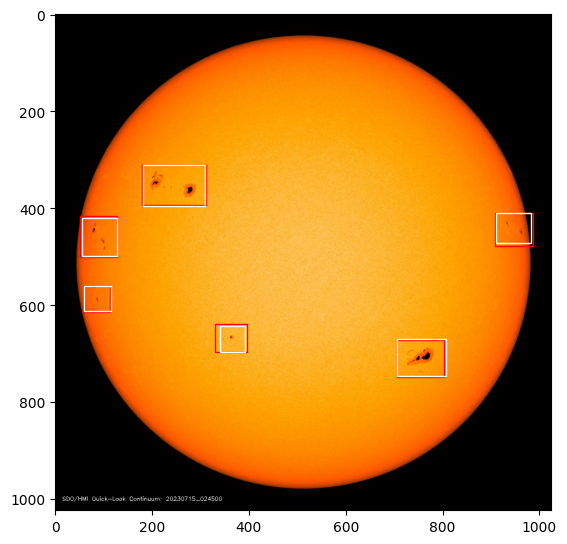

In [54]:
sample = df_valid_sunspot_set.iloc[150]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "exp", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

# prominence

## Data Preprocessing

### Data Split

In [55]:
df_train_prominence_set = df_train_prominence.sample(frac=0.8, random_state=0)
df_valid_prominence_set = df_train_prominence.drop(df_train_prominence_set.index)

df_train_prominence_set.to_csv("train_prominence_set.csv", index=False)
df_valid_prominence_set.to_csv("valid_prominence_set.csv", index=False)

new_train_prominence_path = os.path.abspath("train_prominence")
new_valid_prominence_path = os.path.abspath("valid_prominence")

os.makedirs(new_train_prominence_path, exist_ok=True)
os.makedirs(os.path.join(new_train_prominence_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_prominence_path, LABELS_DIR), exist_ok=True)

os.makedirs(new_valid_prominence_path, exist_ok=True)
os.makedirs(os.path.join(new_valid_prominence_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_valid_prominence_path, LABELS_DIR), exist_ok=True)

### Data preprocessing and copy

Resize and copy into each folder

YOLO model uses relative coordinate, so label resizing is not needed.

Resizing the label might be needed depends on your model.

In [56]:
for i, row in tqdm(df_train_prominence_set.iterrows(), total=len(df_train_prominence_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_prominence_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_train_prominence_path}/{LABELS_DIR}/{row['id']}.txt")

for i, row in tqdm(df_valid_prominence_set.iterrows(), total=len(df_valid_prominence_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_prominence_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_valid_prominence_path}/{LABELS_DIR}/{row['id']}.txt")

100%|██████████| 4256/4256 [00:39<00:00, 108.32it/s]


## Model Training

### Training

In [57]:
dataset = {
    "path": os.path.abspath("."),
    "train": "train_prominence",
    "val": "valid_prominence",
    "nc": 3,
    "names": ["none", "none", "prominence"],
}

YAML_PATH = os.path.abspath("prominence.yaml")
RESULT_PATH = os.path.abspath("result6_prominence")
os.makedirs(RESULT_PATH, exist_ok=True)

with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [58]:
!PYTHONWARNINGS="ignore::FutureWarning" python yolov5/train.py --img {IMAGE_SIZE} --batch {BATCH} --epoch {EPOCH} --data {YAML_PATH} --cfg yolov5s.yaml --exist-ok --weights "" --name prominence --project {RESULT_PATH}

train: weights=, cfg=yolov5s.yaml, data=/home/elicer/prominence.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=64, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/elicer/result6_prominence, name=prominence, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

hyperparameters: lr0=0.01, lrf=0.

                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.569      0.644       0.64      0.335

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/69      31.5G    0.03712    0.02042  0.0001279         71       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.633      0.661      0.701      0.378

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/69      31.5G    0.03675    0.02049  0.0001174         73       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.671      0.719      0.756      0.413

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/69      31.5G    0.03657    0.02032  0.0001123         65       1024: 1
          

      33/69      31.5G    0.03227    0.01863  6.098e-05         84       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.754       0.79      0.853      0.525

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/69      31.5G    0.03211    0.01866  5.962e-05         74       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.759      0.807      0.862      0.537

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/69      31.5G    0.03186    0.01843  5.862e-05         77       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881       0.77      0.804      0.868      0.542

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/6

      58/69      31.5G    0.02695    0.01595  3.533e-05         59       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881       0.83      0.864      0.919      0.619

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/69      31.5G     0.0267    0.01567   3.43e-05         69       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.836      0.866      0.921      0.623

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      60/69      31.5G    0.02649    0.01547  3.346e-05         69       1024: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       5960       9881      0.836      0.868      0.923      0.626

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      61/6

## Model Evaluation

### Valid Data Inference

In [59]:
!python yolov5/detect.py --source {os.path.join(new_valid_prominence_path, IMAGE_DIR)} --weights {RESULT_PATH}/prominence/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/valid

detect: weights=['/home/elicer/result6_prominence/prominence/weights/best.pt'], source=/home/elicer/valid_prominence/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/elicer/result6_prominence/valid, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/5960 /home/elicer/valid_prominence/images/000874f15ca147d68b71c5a1a4478a08.jpg: 640x640 (no detections), 5.1ms
image 2/5960 /home/elicer/valid_prominence/images/001c3fc0671c42acb3d5c4d94b294552_aug.jpg: 640x640 1 prominence, 6.9ms
i

image 64/5960 /home/elicer/valid_prominence/images/03186039fd7748059880cab020fb605d.jpg: 640x640 3 prominences, 5.0ms
image 65/5960 /home/elicer/valid_prominence/images/032519cbd6154d16a35fbf55260f9c47_aug.jpg: 640x640 (no detections), 5.0ms
image 66/5960 /home/elicer/valid_prominence/images/032519cbd6154d16a35fbf55260f9c47_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 67/5960 /home/elicer/valid_prominence/images/032cc995a5f9451987288f0b08521396_aug.jpg: 640x640 (no detections), 5.0ms
image 68/5960 /home/elicer/valid_prominence/images/032cc995a5f9451987288f0b08521396_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 69/5960 /home/elicer/valid_prominence/images/0336575f99ac42ebbdbb61622ba5167d_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 70/5960 /home/elicer/valid_prominence/images/034865c2f33f44dd94efa3b7ec3663e5.jpg: 640x640 (no detections), 5.0ms
image 71/5960 /home/elicer/valid_prominence/images/034865c2f33f44dd94efa3b7ec3663e5_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 72

image 132/5960 /home/elicer/valid_prominence/images/05df4c6404004d68a62d5d4871ee9a5e_aug.jpg: 640x640 1 prominence, 5.0ms
image 133/5960 /home/elicer/valid_prominence/images/05f015f5a4b64fa484f7ccbb34e90308.jpg: 640x640 (no detections), 5.0ms
image 134/5960 /home/elicer/valid_prominence/images/05f015f5a4b64fa484f7ccbb34e90308_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 135/5960 /home/elicer/valid_prominence/images/05f488531f1542bb94cd876187e16018_aug.jpg: 640x640 4 prominences, 5.0ms
image 136/5960 /home/elicer/valid_prominence/images/05f488531f1542bb94cd876187e16018_aug_tb.jpg: 640x640 4 prominences, 5.0ms
image 137/5960 /home/elicer/valid_prominence/images/0621fc90c26c4b838b2f701c67d93fae_aug.jpg: 640x640 (no detections), 5.0ms
image 138/5960 /home/elicer/valid_prominence/images/0621fc90c26c4b838b2f701c67d93fae_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 139/5960 /home/elicer/valid_prominence/images/063a43f6a32240eb95db928af687c3de_aug.jpg: 640x640 2 prominences, 5.0ms
imag

image 199/5960 /home/elicer/valid_prominence/images/08b2e6f4f39f4030aa938d3d742b1f64_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 200/5960 /home/elicer/valid_prominence/images/08c2d7fab0c44702b58cedc56423dfad_aug.jpg: 640x640 2 prominences, 5.0ms
image 201/5960 /home/elicer/valid_prominence/images/08d0d305639b4ef6936068c10017ef70_aug.jpg: 640x640 1 prominence, 5.0ms
image 202/5960 /home/elicer/valid_prominence/images/08d0d305639b4ef6936068c10017ef70_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 203/5960 /home/elicer/valid_prominence/images/08dfd8d5ae204d288f9d630d487a4633_aug.jpg: 640x640 1 prominence, 5.0ms
image 204/5960 /home/elicer/valid_prominence/images/08f744faa6da4813aee57e399362c5c2.jpg: 640x640 2 prominences, 5.0ms
image 205/5960 /home/elicer/valid_prominence/images/08f744faa6da4813aee57e399362c5c2_aug.jpg: 640x640 2 prominences, 5.0ms
image 206/5960 /home/elicer/valid_prominence/images/08f744faa6da4813aee57e399362c5c2_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 207/596

image 268/5960 /home/elicer/valid_prominence/images/0bb5c1117fe845b493ce1aacdc957a8a.jpg: 640x640 2 prominences, 5.0ms
image 269/5960 /home/elicer/valid_prominence/images/0bb5c1117fe845b493ce1aacdc957a8a_aug.jpg: 640x640 2 prominences, 5.0ms
image 270/5960 /home/elicer/valid_prominence/images/0bcebd864b514a92b96f16417f88733b.jpg: 640x640 (no detections), 5.0ms
image 271/5960 /home/elicer/valid_prominence/images/0bcebd864b514a92b96f16417f88733b_aug.jpg: 640x640 (no detections), 5.0ms
image 272/5960 /home/elicer/valid_prominence/images/0bcebd864b514a92b96f16417f88733b_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 273/5960 /home/elicer/valid_prominence/images/0bda00ce5d364d3a9b0156d336f1fde3_aug.jpg: 640x640 2 prominences, 5.0ms
image 274/5960 /home/elicer/valid_prominence/images/0be3454ec83844cbbe9b9fb8ec82c83b_aug.jpg: 640x640 3 prominences, 5.0ms
image 275/5960 /home/elicer/valid_prominence/images/0be3454ec83844cbbe9b9fb8ec82c83b_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 276/59

image 335/5960 /home/elicer/valid_prominence/images/0da29dd51ba340b2b01fdf03a7653555.jpg: 640x640 1 prominence, 5.0ms
image 336/5960 /home/elicer/valid_prominence/images/0da6a9cb6d53411c81794377f5b3850d_aug.jpg: 640x640 2 prominences, 5.0ms
image 337/5960 /home/elicer/valid_prominence/images/0daf17e1a9fc42b99c5cd8f6a512c205.jpg: 640x640 (no detections), 5.0ms
image 338/5960 /home/elicer/valid_prominence/images/0dbd8cc0cc034f21b24362fd1e2d24f9.jpg: 640x640 2 prominences, 5.0ms
image 339/5960 /home/elicer/valid_prominence/images/0dce8832934e4a048ba79164f62ccb60_aug.jpg: 640x640 (no detections), 5.0ms
image 340/5960 /home/elicer/valid_prominence/images/0dce8832934e4a048ba79164f62ccb60_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 341/5960 /home/elicer/valid_prominence/images/0dce8832934e4a048ba79164f62ccb60_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 342/5960 /home/elicer/valid_prominence/images/0dd12c9366f340ad840d97c67f8e7884_aug.jpg: 640x640 1 prominence, 5.0ms
image 343/5960 /

image 403/5960 /home/elicer/valid_prominence/images/110ffa3f9e194cd98661d43b79a1f2bf_aug.jpg: 640x640 1 prominence, 5.0ms
image 404/5960 /home/elicer/valid_prominence/images/11113e36abc34b759e64552f9fcdf02b.jpg: 640x640 2 prominences, 5.0ms
image 405/5960 /home/elicer/valid_prominence/images/1135f0f3b362459ea6380a8b30340432_aug_lr.jpg: 640x640 (no detections), 6.0ms
image 406/5960 /home/elicer/valid_prominence/images/11471821314d4fbb8d9d18b62b39ba9f_aug_tb.jpg: 640x640 1 prominence, 5.1ms
image 407/5960 /home/elicer/valid_prominence/images/1154c128c30e483d814e06c9d53d28d1_aug.jpg: 640x640 (no detections), 5.0ms
image 408/5960 /home/elicer/valid_prominence/images/1154c128c30e483d814e06c9d53d28d1_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 409/5960 /home/elicer/valid_prominence/images/115ad308eee64697b002695208a4ce47_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 410/5960 /home/elicer/valid_prominence/images/115b4f85e01242e4892909afd0872bf3_aug_tb.jpg: 640x640 (no detections), 4.9

image 471/5960 /home/elicer/valid_prominence/images/13889ccab1824f669c2e7d4e47ea32fe.jpg: 640x640 1 prominence, 5.0ms
image 472/5960 /home/elicer/valid_prominence/images/13889ccab1824f669c2e7d4e47ea32fe_aug.jpg: 640x640 1 prominence, 5.0ms
image 473/5960 /home/elicer/valid_prominence/images/1391bb21ecd045ae842091aea77d2fb0_aug.jpg: 640x640 3 prominences, 5.0ms
image 474/5960 /home/elicer/valid_prominence/images/139f4861667a4a9ebc7c259a0e772c49_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 475/5960 /home/elicer/valid_prominence/images/13b162e7accf477bab465bdb8a16ea81.jpg: 640x640 (no detections), 5.0ms
image 476/5960 /home/elicer/valid_prominence/images/13b99f63a56f4f5e9ea29d3053c942ff_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 477/5960 /home/elicer/valid_prominence/images/13b9d055c48548489fb51523d00cb02a_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 478/5960 /home/elicer/valid_prominence/images/13c88f847cd14172ac77efb23331d0e6_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 479

image 539/5960 /home/elicer/valid_prominence/images/165394fe677d410b801d18910b9d7460_aug.jpg: 640x640 1 prominence, 5.0ms
image 540/5960 /home/elicer/valid_prominence/images/165de8a9f5a345049d61a9eaad927f00_aug.jpg: 640x640 (no detections), 5.0ms
image 541/5960 /home/elicer/valid_prominence/images/1674b26d6a9e47b3a7150717be472976.jpg: 640x640 (no detections), 5.0ms
image 542/5960 /home/elicer/valid_prominence/images/168aedd6dbc4488187303eb6b3ef3b1c.jpg: 640x640 3 prominences, 5.0ms
image 543/5960 /home/elicer/valid_prominence/images/169ead56196a41f9808c2f980019a13f.jpg: 640x640 2 prominences, 5.0ms
image 544/5960 /home/elicer/valid_prominence/images/169ead56196a41f9808c2f980019a13f_aug.jpg: 640x640 1 prominence, 5.0ms
image 545/5960 /home/elicer/valid_prominence/images/16a971cef631476c8d70f03114aa8e7e.jpg: 640x640 1 prominence, 5.0ms
image 546/5960 /home/elicer/valid_prominence/images/16b41bdb4dc548c9992673022a858579_aug.jpg: 640x640 2 prominences, 5.0ms
image 547/5960 /home/elicer/val

image 608/5960 /home/elicer/valid_prominence/images/19179e089ea642ea80ecec879dbb1543_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 609/5960 /home/elicer/valid_prominence/images/194b143d859f4d2da44b3259375c5c93.jpg: 640x640 1 prominence, 5.0ms
image 610/5960 /home/elicer/valid_prominence/images/196787991d484de9ae152a4ca4ab2a08.jpg: 640x640 (no detections), 5.0ms
image 611/5960 /home/elicer/valid_prominence/images/196787991d484de9ae152a4ca4ab2a08_aug.jpg: 640x640 (no detections), 5.0ms
image 612/5960 /home/elicer/valid_prominence/images/19680b4c4f8d4ed9af9c0289aa248789_aug_tb.jpg: 640x640 2 prominences, 4.9ms
image 613/5960 /home/elicer/valid_prominence/images/1976c70738ae4033ae889839b688184d_aug.jpg: 640x640 4 prominences, 5.0ms
image 614/5960 /home/elicer/valid_prominence/images/197ab03654d241ec8f656a8a001ca185_aug.jpg: 640x640 1 prominence, 5.0ms
image 615/5960 /home/elicer/valid_prominence/images/197ab03654d241ec8f656a8a001ca185_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 616

image 676/5960 /home/elicer/valid_prominence/images/1be926616df54f79ae49f7ee42459a35_aug.jpg: 640x640 4 prominences, 5.0ms
image 677/5960 /home/elicer/valid_prominence/images/1be957d299a446978e71e41c44802352_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 678/5960 /home/elicer/valid_prominence/images/1c2751b287bf4481851aaec6fdaaaa8e_aug.jpg: 640x640 2 prominences, 5.0ms
image 679/5960 /home/elicer/valid_prominence/images/1c2751b287bf4481851aaec6fdaaaa8e_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 680/5960 /home/elicer/valid_prominence/images/1c29cded595a4ff7859d34a01fd44e93.jpg: 640x640 1 prominence, 5.0ms
image 681/5960 /home/elicer/valid_prominence/images/1c29cded595a4ff7859d34a01fd44e93_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 682/5960 /home/elicer/valid_prominence/images/1c2b6e3e7d6f4d7c95d2bec73ebca0b1.jpg: 640x640 (no detections), 4.9ms
image 683/5960 /home/elicer/valid_prominence/images/1c56f6745352434986e916ee35f6a772.jpg: 640x640 (no detections), 4.9ms
image 684/5960 /ho

image 745/5960 /home/elicer/valid_prominence/images/1e3fbe4cbfff46d59413d2f627cfd3ed_aug.jpg: 640x640 (no detections), 5.0ms
image 746/5960 /home/elicer/valid_prominence/images/1e3fbe4cbfff46d59413d2f627cfd3ed_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 747/5960 /home/elicer/valid_prominence/images/1e40df4f8a05468a9d8e8d4c3bf3cf09_aug.jpg: 640x640 2 prominences, 5.0ms
image 748/5960 /home/elicer/valid_prominence/images/1e437572709b4ddaadb4b6ad6de5b3dd.jpg: 640x640 2 prominences, 5.0ms
image 749/5960 /home/elicer/valid_prominence/images/1e437572709b4ddaadb4b6ad6de5b3dd_aug.jpg: 640x640 2 prominences, 5.0ms
image 750/5960 /home/elicer/valid_prominence/images/1e479373dffc4f2588f3dea79e36f418_aug.jpg: 640x640 3 prominences, 5.0ms
image 751/5960 /home/elicer/valid_prominence/images/1e4ecdeaeb674d7e95861c8c5d06e976_aug.jpg: 640x640 4 prominences, 5.0ms
image 752/5960 /home/elicer/valid_prominence/images/1e5773e72b364b77bf5df6d36934beb5_aug.jpg: 640x640 1 prominence, 5.0ms
image 753/5960

image 813/5960 /home/elicer/valid_prominence/images/21037818e0474909bba9d102324793c6_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 814/5960 /home/elicer/valid_prominence/images/2121965a95ac47349e84d034266251fa.jpg: 640x640 (no detections), 5.0ms
image 815/5960 /home/elicer/valid_prominence/images/2121965a95ac47349e84d034266251fa_aug.jpg: 640x640 (no detections), 4.9ms
image 816/5960 /home/elicer/valid_prominence/images/2125eb7803644580b5160f87f3f18ed2.jpg: 640x640 1 prominence, 4.9ms
image 817/5960 /home/elicer/valid_prominence/images/2125eb7803644580b5160f87f3f18ed2_aug.jpg: 640x640 1 prominence, 5.0ms
image 818/5960 /home/elicer/valid_prominence/images/2161fbfb3cb445f29c74bd27b4a114dc_aug.jpg: 640x640 (no detections), 5.0ms
image 819/5960 /home/elicer/valid_prominence/images/2179e1658430466a9c682c0d49d19d01.jpg: 640x640 3 prominences, 5.0ms
image 820/5960 /home/elicer/valid_prominence/images/2179e1658430466a9c682c0d49d19d01_aug.jpg: 640x640 3 prominences, 5.0ms
image 821/5960 /hom

image 882/5960 /home/elicer/valid_prominence/images/24d7ae2f1faf4b5a9938dc72169ac37d_aug.jpg: 640x640 4 prominences, 5.1ms
image 883/5960 /home/elicer/valid_prominence/images/24d7ae2f1faf4b5a9938dc72169ac37d_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 884/5960 /home/elicer/valid_prominence/images/2501eb847d0f49218ebbc3643520cab7.jpg: 640x640 3 prominences, 5.0ms
image 885/5960 /home/elicer/valid_prominence/images/25034498b8ff4ea9b55853123b753d9a.jpg: 640x640 (no detections), 5.0ms
image 886/5960 /home/elicer/valid_prominence/images/25034498b8ff4ea9b55853123b753d9a_aug.jpg: 640x640 (no detections), 5.0ms
image 887/5960 /home/elicer/valid_prominence/images/250bb2e3edae49d7aec4b97b39b5a227.jpg: 640x640 (no detections), 5.0ms
image 888/5960 /home/elicer/valid_prominence/images/250bb2e3edae49d7aec4b97b39b5a227_aug.jpg: 640x640 (no detections), 5.0ms
image 889/5960 /home/elicer/valid_prominence/images/2510984baa0a48fea51e7646e9ecaf72.jpg: 640x640 2 prominences, 5.0ms
image 890/5960 /home/

image 949/5960 /home/elicer/valid_prominence/images/28175029784a4437ace5c4c167176bd1_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 950/5960 /home/elicer/valid_prominence/images/284150051b184c35969076d05a779bef_aug.jpg: 640x640 (no detections), 5.0ms
image 951/5960 /home/elicer/valid_prominence/images/2869c5973d5f470490bfc24081c6916a.jpg: 640x640 3 prominences, 5.0ms
image 952/5960 /home/elicer/valid_prominence/images/2869c5973d5f470490bfc24081c6916a_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 953/5960 /home/elicer/valid_prominence/images/288f929fef00469885b147aaa295096f_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 954/5960 /home/elicer/valid_prominence/images/28c030012afc4f29b1cac4ea901bd45e.jpg: 640x640 1 prominence, 5.0ms
image 955/5960 /home/elicer/valid_prominence/images/28cd984c85c540e684f08a10e76a807c.jpg: 640x640 (no detections), 5.0ms
image 956/5960 /home/elicer/valid_prominence/images/28d30a071b654e039e18d179084397ba_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 957/59

image 1017/5960 /home/elicer/valid_prominence/images/2b6d4d2666ea4b3cad4824b57f4dfce3.jpg: 640x640 (no detections), 5.0ms
image 1018/5960 /home/elicer/valid_prominence/images/2b91589d59354cf4a93eef7e34c703c8_aug.jpg: 640x640 1 prominence, 5.0ms
image 1019/5960 /home/elicer/valid_prominence/images/2bb5b32090ce411099851821247deb71_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1020/5960 /home/elicer/valid_prominence/images/2bd1de929cb9478b984c18f4e9e860f2.jpg: 640x640 1 prominence, 5.0ms
image 1021/5960 /home/elicer/valid_prominence/images/2bd1de929cb9478b984c18f4e9e860f2_aug.jpg: 640x640 1 prominence, 5.0ms
image 1022/5960 /home/elicer/valid_prominence/images/2bd761ed778a4dc2b271f7ecc828082d.jpg: 640x640 2 prominences, 5.0ms
image 1023/5960 /home/elicer/valid_prominence/images/2bd761ed778a4dc2b271f7ecc828082d_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 1024/5960 /home/elicer/valid_prominence/images/2bd9fb49e611481fbdc4845e7df02d86_aug.jpg: 640x640 (no detections), 5.0ms
image 1025/

image 1085/5960 /home/elicer/valid_prominence/images/2da9e5c3b22e4ce1ab4a81d7e4712ad3_aug.jpg: 640x640 (no detections), 5.0ms
image 1086/5960 /home/elicer/valid_prominence/images/2da9e5c3b22e4ce1ab4a81d7e4712ad3_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1087/5960 /home/elicer/valid_prominence/images/2da9e5c3b22e4ce1ab4a81d7e4712ad3_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 1088/5960 /home/elicer/valid_prominence/images/2daf8b2d45974c36a23a92a496fb7659.jpg: 640x640 2 prominences, 5.1ms
image 1089/5960 /home/elicer/valid_prominence/images/2daf8b2d45974c36a23a92a496fb7659_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 1090/5960 /home/elicer/valid_prominence/images/2db5eef678c546f9b8ec0368a8d3d6a1.jpg: 640x640 (no detections), 5.0ms
image 1091/5960 /home/elicer/valid_prominence/images/2db5eef678c546f9b8ec0368a8d3d6a1_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 1092/5960 /home/elicer/valid_prominence/images/2dd57f9fd7a24dc2bfe68f22b5b2877d.jpg: 640x640 (no detections), 5.

image 1153/5960 /home/elicer/valid_prominence/images/2fb607101b3c451a956f66ec2ac46f5f.jpg: 640x640 2 prominences, 5.2ms
image 1154/5960 /home/elicer/valid_prominence/images/2fb607101b3c451a956f66ec2ac46f5f_aug.jpg: 640x640 2 prominences, 5.0ms
image 1155/5960 /home/elicer/valid_prominence/images/2fb607101b3c451a956f66ec2ac46f5f_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 1156/5960 /home/elicer/valid_prominence/images/2fb607101b3c451a956f66ec2ac46f5f_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 1157/5960 /home/elicer/valid_prominence/images/2fd3220440da4bd68a25e74bc4b79d1f_aug.jpg: 640x640 2 prominences, 5.0ms
image 1158/5960 /home/elicer/valid_prominence/images/2fd3220440da4bd68a25e74bc4b79d1f_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 1159/5960 /home/elicer/valid_prominence/images/2fddd4cdb69f433bb848e3b9ae57c201_aug.jpg: 640x640 (no detections), 5.0ms
image 1160/5960 /home/elicer/valid_prominence/images/2fddd4cdb69f433bb848e3b9ae57c201_aug_lr.jpg: 640x640 (no detections), 5.

image 1219/5960 /home/elicer/valid_prominence/images/32f799ab7d7f4bdd939dd25a23cb58bf_aug.jpg: 640x640 1 prominence, 5.0ms
image 1220/5960 /home/elicer/valid_prominence/images/32fa8228f60a476e874be12fdc8014ed.jpg: 640x640 1 prominence, 5.0ms
image 1221/5960 /home/elicer/valid_prominence/images/32fcf51294fc4b70927b03885f0642d4.jpg: 640x640 (no detections), 5.0ms
image 1222/5960 /home/elicer/valid_prominence/images/32fe485450c94b71925d9ddb1208ca22.jpg: 640x640 2 prominences, 5.0ms
image 1223/5960 /home/elicer/valid_prominence/images/32fe485450c94b71925d9ddb1208ca22_aug.jpg: 640x640 2 prominences, 5.0ms
image 1224/5960 /home/elicer/valid_prominence/images/32fe485450c94b71925d9ddb1208ca22_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 1225/5960 /home/elicer/valid_prominence/images/32fe485450c94b71925d9ddb1208ca22_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1226/5960 /home/elicer/valid_prominence/images/3305e6d98762496f9143c6252104d939_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 1227

image 1287/5960 /home/elicer/valid_prominence/images/35aaa97cbe754a158c29c27077032ee0_aug.jpg: 640x640 (no detections), 5.0ms
image 1288/5960 /home/elicer/valid_prominence/images/35aaa97cbe754a158c29c27077032ee0_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1289/5960 /home/elicer/valid_prominence/images/35b0a91dc1764da09c765cd2899ab343_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 1290/5960 /home/elicer/valid_prominence/images/35b1fa32ba8f4695909c83d4507ebbc9.jpg: 640x640 2 prominences, 5.2ms
image 1291/5960 /home/elicer/valid_prominence/images/35b1fa32ba8f4695909c83d4507ebbc9_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 1292/5960 /home/elicer/valid_prominence/images/35b36d614bd540d4a9b6d4178dd189b4.jpg: 640x640 4 prominences, 5.0ms
image 1293/5960 /home/elicer/valid_prominence/images/35b36d614bd540d4a9b6d4178dd189b4_aug.jpg: 640x640 4 prominences, 4.9ms
image 1294/5960 /home/elicer/valid_prominence/images/35bef929b59340688aa7fe1d3287f749_aug_tb.jpg: 640x640 (no detections), 5.

image 1355/5960 /home/elicer/valid_prominence/images/384e855080154486afe2d98422db5e56_aug.jpg: 640x640 2 prominences, 5.0ms
image 1356/5960 /home/elicer/valid_prominence/images/3866c639901141fbba39362cd3da21b3_aug.jpg: 640x640 1 prominence, 5.0ms
image 1357/5960 /home/elicer/valid_prominence/images/387989b466124bacb1376a8026f94037.jpg: 640x640 5 prominences, 5.0ms
image 1358/5960 /home/elicer/valid_prominence/images/3879a8cf4a52441c82a1456bbfacd9aa.jpg: 640x640 5 prominences, 5.0ms
image 1359/5960 /home/elicer/valid_prominence/images/3879a8cf4a52441c82a1456bbfacd9aa_aug_lr.jpg: 640x640 5 prominences, 5.0ms
image 1360/5960 /home/elicer/valid_prominence/images/38837715ad9c4af9bedfea9593487ec6_aug_tb.jpg: 640x640 (no detections), 5.1ms
image 1361/5960 /home/elicer/valid_prominence/images/3887ad74bf7241ab83bfbcfb3a0b8d69_aug.jpg: 640x640 (no detections), 5.0ms
image 1362/5960 /home/elicer/valid_prominence/images/3891b26cd2fb4de6935833541f94d415.jpg: 640x640 2 prominences, 5.0ms
image 1363/

image 1423/5960 /home/elicer/valid_prominence/images/3b1de2e4392d4b9baf73170cfeacbb7d_aug.jpg: 640x640 2 prominences, 5.1ms
image 1424/5960 /home/elicer/valid_prominence/images/3b2004a73cb9470381d5b4ef5a34f02e_aug.jpg: 640x640 1 prominence, 5.0ms
image 1425/5960 /home/elicer/valid_prominence/images/3b3650b19a5e4bf9afd037075585e1a4.jpg: 640x640 1 prominence, 5.0ms
image 1426/5960 /home/elicer/valid_prominence/images/3b3650b19a5e4bf9afd037075585e1a4_aug.jpg: 640x640 1 prominence, 5.0ms
image 1427/5960 /home/elicer/valid_prominence/images/3b3650b19a5e4bf9afd037075585e1a4_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 1428/5960 /home/elicer/valid_prominence/images/3b72ca703ac042b6b678d9b797c2a983.jpg: 640x640 1 prominence, 5.0ms
image 1429/5960 /home/elicer/valid_prominence/images/3b72ca703ac042b6b678d9b797c2a983_aug.jpg: 640x640 1 prominence, 5.0ms
image 1430/5960 /home/elicer/valid_prominence/images/3b72ca703ac042b6b678d9b797c2a983_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1431/5960 /

image 1490/5960 /home/elicer/valid_prominence/images/3dd366ebe8c04d1484efec0ef8ac12da_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1491/5960 /home/elicer/valid_prominence/images/3de27650967c4efabbeabd6f819a9341.jpg: 640x640 (no detections), 5.0ms
image 1492/5960 /home/elicer/valid_prominence/images/3de29c863a594121ac1a00cb2bdf3daf.jpg: 640x640 1 prominence, 5.0ms
image 1493/5960 /home/elicer/valid_prominence/images/3de29c863a594121ac1a00cb2bdf3daf_aug.jpg: 640x640 1 prominence, 5.0ms
image 1494/5960 /home/elicer/valid_prominence/images/3de29c863a594121ac1a00cb2bdf3daf_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 1495/5960 /home/elicer/valid_prominence/images/3dea1954fb2141df99fa885ac49f66b7_aug.jpg: 640x640 2 prominences, 5.0ms
image 1496/5960 /home/elicer/valid_prominence/images/3dea1954fb2141df99fa885ac49f66b7_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1497/5960 /home/elicer/valid_prominence/images/3deaa2c4c9d944f9879e6df8b7dce1e5_aug.jpg: 640x640 2 prominences, 5.0ms
image 1498

image 1558/5960 /home/elicer/valid_prominence/images/406ae6ed5ef14a44af342e993002453c.jpg: 640x640 (no detections), 5.2ms
image 1559/5960 /home/elicer/valid_prominence/images/408e4ffa78c14a058ec6db6e17fcb0bf.jpg: 640x640 2 prominences, 5.0ms
image 1560/5960 /home/elicer/valid_prominence/images/408e4ffa78c14a058ec6db6e17fcb0bf_aug.jpg: 640x640 2 prominences, 5.0ms
image 1561/5960 /home/elicer/valid_prominence/images/408e4ffa78c14a058ec6db6e17fcb0bf_aug_lr.jpg: 640x640 2 prominences, 5.1ms
image 1562/5960 /home/elicer/valid_prominence/images/408e4ffa78c14a058ec6db6e17fcb0bf_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 1563/5960 /home/elicer/valid_prominence/images/40919f34b97b44f391c32dae98cd3eb6_aug.jpg: 640x640 1 prominence, 5.0ms
image 1564/5960 /home/elicer/valid_prominence/images/40c4ef00340b4a8a8386f9edbd081274_aug.jpg: 640x640 (no detections), 5.0ms
image 1565/5960 /home/elicer/valid_prominence/images/40cb6261370d447a80b7864240bff179.jpg: 640x640 3 prominences, 5.0ms
image 1566/

image 1626/5960 /home/elicer/valid_prominence/images/43db4afbfef74e7697c4603cb7d0b45c_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 1627/5960 /home/elicer/valid_prominence/images/43f4ba0332194e0ba07885eb09752837.jpg: 640x640 2 prominences, 5.0ms
image 1628/5960 /home/elicer/valid_prominence/images/43f4ba0332194e0ba07885eb09752837_aug.jpg: 640x640 2 prominences, 5.0ms
image 1629/5960 /home/elicer/valid_prominence/images/43f4ba0332194e0ba07885eb09752837_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 1630/5960 /home/elicer/valid_prominence/images/43fd4976e296484bacb628313998284f_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1631/5960 /home/elicer/valid_prominence/images/440fb197c67a4643a0702b57457379d2.jpg: 640x640 (no detections), 5.2ms
image 1632/5960 /home/elicer/valid_prominence/images/440fb197c67a4643a0702b57457379d2_aug.jpg: 640x640 (no detections), 5.0ms
image 1633/5960 /home/elicer/valid_prominence/images/440fb197c67a4643a0702b57457379d2_aug_tb.jpg: 640x640 (no detections), 5.0ms

image 1694/5960 /home/elicer/valid_prominence/images/46a4d1a1f2d042c28eb214134c879fb2_aug.jpg: 640x640 2 prominences, 5.0ms
image 1695/5960 /home/elicer/valid_prominence/images/46af5b09579e4bc1aebff851677c19e2_aug.jpg: 640x640 (no detections), 5.0ms
image 1696/5960 /home/elicer/valid_prominence/images/46c2abe28dea4625988ef5cbdde4a433_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1697/5960 /home/elicer/valid_prominence/images/46eaefbe07a148e4800e28656e1987ab_aug.jpg: 640x640 1 prominence, 5.0ms
image 1698/5960 /home/elicer/valid_prominence/images/46eaefbe07a148e4800e28656e1987ab_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1699/5960 /home/elicer/valid_prominence/images/470dd0d2454e4145b9396b29504b7795.jpg: 640x640 2 prominences, 5.0ms
image 1700/5960 /home/elicer/valid_prominence/images/470dd0d2454e4145b9396b29504b7795_aug.jpg: 640x640 2 prominences, 5.0ms
image 1701/5960 /home/elicer/valid_prominence/images/47182f2dc23c4f9a9e9791afea1da33a.jpg: 640x640 1 prominence, 5.0ms
image 170

image 1762/5960 /home/elicer/valid_prominence/images/491f175c89724f719016257bae97bf3c.jpg: 640x640 2 prominences, 5.5ms
image 1763/5960 /home/elicer/valid_prominence/images/491f175c89724f719016257bae97bf3c_aug_lr.jpg: 640x640 1 prominence, 5.5ms
image 1764/5960 /home/elicer/valid_prominence/images/4940af6ae84d43bbaec798851ca47e6f_aug_lr.jpg: 640x640 3 prominences, 5.3ms
image 1765/5960 /home/elicer/valid_prominence/images/4954762fc0b649c29228a353bc13ceae_aug_tb.jpg: 640x640 3 prominences, 5.5ms
image 1766/5960 /home/elicer/valid_prominence/images/49916a712bcd4e6eaba9d7e78f326218_aug.jpg: 640x640 1 prominence, 5.5ms
image 1767/5960 /home/elicer/valid_prominence/images/49988cc842a540928652087e568a30f5.jpg: 640x640 1 prominence, 5.3ms
image 1768/5960 /home/elicer/valid_prominence/images/4999b8abbcaf4627a3d80b7f723e9b9e_aug.jpg: 640x640 (no detections), 5.3ms
image 1769/5960 /home/elicer/valid_prominence/images/49ad683c55084b88a123eedeee023c59.jpg: 640x640 (no detections), 5.1ms
image 1770

image 1831/5960 /home/elicer/valid_prominence/images/4c73411f9f344fe09da97ee63a268b1c_aug_tb.jpg: 640x640 2 prominences, 5.3ms
image 1832/5960 /home/elicer/valid_prominence/images/4c84a59709e744ea815c78e0b15b5267.jpg: 640x640 2 prominences, 5.3ms
image 1833/5960 /home/elicer/valid_prominence/images/4c89767596014df1b23e46443ba5ceb8_aug.jpg: 640x640 1 prominence, 5.8ms
image 1834/5960 /home/elicer/valid_prominence/images/4c89767596014df1b23e46443ba5ceb8_aug_lr.jpg: 640x640 1 prominence, 5.6ms
image 1835/5960 /home/elicer/valid_prominence/images/4c8b64eaa1d04dfb9f4f015c212ed5d2_aug.jpg: 640x640 (no detections), 5.4ms
image 1836/5960 /home/elicer/valid_prominence/images/4c98e00cedc4497781b54a7f4c5b4aa4_aug_tb.jpg: 640x640 2 prominences, 5.3ms
image 1837/5960 /home/elicer/valid_prominence/images/4ca2570a8e5d4378b11be8e9d8d4151d.jpg: 640x640 2 prominences, 5.3ms
image 1838/5960 /home/elicer/valid_prominence/images/4cc0a430f2c14a94a5fe787d8c634a5c_aug.jpg: 640x640 (no detections), 5.2ms
image

image 1898/5960 /home/elicer/valid_prominence/images/4f8602a1124f460495836401096e1786_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 1899/5960 /home/elicer/valid_prominence/images/4f8602a1124f460495836401096e1786_aug_tb.jpg: 640x640 4 prominences, 5.0ms
image 1900/5960 /home/elicer/valid_prominence/images/4f8fadf8d9204ed7b2b41b04cf41fc4c.jpg: 640x640 1 prominence, 5.0ms
image 1901/5960 /home/elicer/valid_prominence/images/4f8fadf8d9204ed7b2b41b04cf41fc4c_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 1902/5960 /home/elicer/valid_prominence/images/4f964f1ee8494c4191a4d96dab130786.jpg: 640x640 1 prominence, 5.0ms
image 1903/5960 /home/elicer/valid_prominence/images/4fa47a88a842481c9eac1469eb518f56_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 1904/5960 /home/elicer/valid_prominence/images/4fcefec48dde49cea0ebd9f6deebaa45_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 1905/5960 /home/elicer/valid_prominence/images/4fcefec48dde49cea0ebd9f6deebaa45_aug_tb.jpg: 640x640 3 prominences, 5.0ms

image 1966/5960 /home/elicer/valid_prominence/images/524d120a91964ff4834ea6b435a3cb57_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 1967/5960 /home/elicer/valid_prominence/images/5255794b8e08495db4c9957657fb63bc.jpg: 640x640 2 prominences, 5.0ms
image 1968/5960 /home/elicer/valid_prominence/images/52594fa052bc4c288c3f5ef849f8fc38_aug.jpg: 640x640 1 prominence, 5.0ms
image 1969/5960 /home/elicer/valid_prominence/images/52594fa052bc4c288c3f5ef849f8fc38_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 1970/5960 /home/elicer/valid_prominence/images/525fade6cc2e4e2f94610af2d01063c1_aug.jpg: 640x640 (no detections), 5.0ms
image 1971/5960 /home/elicer/valid_prominence/images/52604bc0632a4a0a99811eeee2355987_aug.jpg: 640x640 1 prominence, 5.0ms
image 1972/5960 /home/elicer/valid_prominence/images/526b1732641f465c930f78fba75c460b.jpg: 640x640 3 prominences, 5.0ms
image 1973/5960 /home/elicer/valid_prominence/images/526b1732641f465c930f78fba75c460b_aug.jpg: 640x640 3 prominences, 5.0ms
image 1974/

image 2033/5960 /home/elicer/valid_prominence/images/55aa3d6e549243caa269ae902337f3ad_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 2034/5960 /home/elicer/valid_prominence/images/55af318ea5884ab3badc7a2c06a40f5e_aug.jpg: 640x640 1 prominence, 5.0ms
image 2035/5960 /home/elicer/valid_prominence/images/55b07890b1cb40429cd00d7039b759f9_aug.jpg: 640x640 5 prominences, 5.0ms
image 2036/5960 /home/elicer/valid_prominence/images/55ea3658f7d6452a9d42a58819006716.jpg: 640x640 1 prominence, 5.0ms
image 2037/5960 /home/elicer/valid_prominence/images/55ea3658f7d6452a9d42a58819006716_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2038/5960 /home/elicer/valid_prominence/images/55ea386f796841a2bc9c4403ab7fe47c.jpg: 640x640 1 prominence, 5.0ms
image 2039/5960 /home/elicer/valid_prominence/images/55ea386f796841a2bc9c4403ab7fe47c_aug.jpg: 640x640 1 prominence, 5.0ms
image 2040/5960 /home/elicer/valid_prominence/images/55f5bbc151e3431a975af5c05c49b8ff_aug.jpg: 640x640 3 prominences, 5.0ms
image 2041/5960

image 2102/5960 /home/elicer/valid_prominence/images/5847ea538ce246ba9a0861b16448cf5c_aug_lr.jpg: 640x640 1 prominence, 4.9ms
image 2103/5960 /home/elicer/valid_prominence/images/5878ebfceac94ee1958c4baaa5fe94ce.jpg: 640x640 1 prominence, 5.0ms
image 2104/5960 /home/elicer/valid_prominence/images/587b84961c364a28a1ea6e3dedcfb42d_aug.jpg: 640x640 2 prominences, 4.9ms
image 2105/5960 /home/elicer/valid_prominence/images/587cc9e44f2940bd9ad53205052a186b.jpg: 640x640 (no detections), 5.0ms
image 2106/5960 /home/elicer/valid_prominence/images/587cc9e44f2940bd9ad53205052a186b_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2107/5960 /home/elicer/valid_prominence/images/588af8b7b3c54d9e8189b7f1bfead0af_aug.jpg: 640x640 2 prominences, 5.0ms
image 2108/5960 /home/elicer/valid_prominence/images/588c7035a55e424a8f5a21c9647eff6b.jpg: 640x640 1 prominence, 5.0ms
image 2109/5960 /home/elicer/valid_prominence/images/58ce790bcad144b8b4ecd3541b7eb95d.jpg: 640x640 2 prominences, 5.0ms
image 2110/5960 /

image 2168/5960 /home/elicer/valid_prominence/images/5b7fea22013640d48dfb356d28cd6037_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2169/5960 /home/elicer/valid_prominence/images/5b7fea22013640d48dfb356d28cd6037_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2170/5960 /home/elicer/valid_prominence/images/5b889f54cec545c9a156ffe695f4b240_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2171/5960 /home/elicer/valid_prominence/images/5b8e0aa3169241fa9fefc6d02336bae3.jpg: 640x640 1 prominence, 5.0ms
image 2172/5960 /home/elicer/valid_prominence/images/5b8e0aa3169241fa9fefc6d02336bae3_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2173/5960 /home/elicer/valid_prominence/images/5b93e59eaa9e4c79bff4645b3f0390f1.jpg: 640x640 (no detections), 5.0ms
image 2174/5960 /home/elicer/valid_prominence/images/5b93e59eaa9e4c79bff4645b3f0390f1_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2175/5960 /home/elicer/valid_prominence/images/5b943333cc664780a4b58852295bf786_aug_lr.jpg: 640x640 (no detections), 5.0

image 2234/5960 /home/elicer/valid_prominence/images/5e691c6e9ecf46f6a5a0c0b0996e4c54_aug_lr.jpg: 640x640 (no detections), 4.9ms
image 2235/5960 /home/elicer/valid_prominence/images/5e6fbc541c364e069f911354a1198f53_aug.jpg: 640x640 1 prominence, 5.0ms
image 2236/5960 /home/elicer/valid_prominence/images/5e836186c1d7438abf449cb6f0e58950.jpg: 640x640 2 prominences, 5.0ms
image 2237/5960 /home/elicer/valid_prominence/images/5e836186c1d7438abf449cb6f0e58950_aug.jpg: 640x640 2 prominences, 4.9ms
image 2238/5960 /home/elicer/valid_prominence/images/5e836186c1d7438abf449cb6f0e58950_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 2239/5960 /home/elicer/valid_prominence/images/5e8eeb2e88e140f3bc14dab835d315cd_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 2240/5960 /home/elicer/valid_prominence/images/5e8eeb2e88e140f3bc14dab835d315cd_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 2241/5960 /home/elicer/valid_prominence/images/5eb1a779335a42988710db5496544b2b_aug.jpg: 640x640 (no detections), 5.0

image 2301/5960 /home/elicer/valid_prominence/images/616d4a27696849b6bb908e1743a212a8.jpg: 640x640 3 prominences, 5.0ms
image 2302/5960 /home/elicer/valid_prominence/images/616d4a27696849b6bb908e1743a212a8_aug.jpg: 640x640 3 prominences, 5.0ms
image 2303/5960 /home/elicer/valid_prominence/images/6171e22f7ae34ab3a170b3d264cc0e9f.jpg: 640x640 1 prominence, 5.0ms
image 2304/5960 /home/elicer/valid_prominence/images/6171e22f7ae34ab3a170b3d264cc0e9f_aug.jpg: 640x640 1 prominence, 5.0ms
image 2305/5960 /home/elicer/valid_prominence/images/61731e8549fe4549a67c13180eaa5e60_aug.jpg: 640x640 1 prominence, 5.0ms
image 2306/5960 /home/elicer/valid_prominence/images/61731e8549fe4549a67c13180eaa5e60_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2307/5960 /home/elicer/valid_prominence/images/618d927ebac44061bdc7607d38c581ee_aug.jpg: 640x640 1 prominence, 5.0ms
image 2308/5960 /home/elicer/valid_prominence/images/618d927ebac44061bdc7607d38c581ee_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2309/59

image 2370/5960 /home/elicer/valid_prominence/images/63c2219339b2435eb1f5e8ac624cee7a_aug.jpg: 640x640 (no detections), 5.0ms
image 2371/5960 /home/elicer/valid_prominence/images/63c2219339b2435eb1f5e8ac624cee7a_aug_lr.jpg: 640x640 (no detections), 4.9ms
image 2372/5960 /home/elicer/valid_prominence/images/63fa2d1356e04b5c8178d6f4aba83e9b.jpg: 640x640 1 prominence, 5.0ms
image 2373/5960 /home/elicer/valid_prominence/images/6404ee6130244e0f8ae57331025b60d0.jpg: 640x640 1 prominence, 5.0ms
image 2374/5960 /home/elicer/valid_prominence/images/6404ee6130244e0f8ae57331025b60d0_aug.jpg: 640x640 1 prominence, 5.0ms
image 2375/5960 /home/elicer/valid_prominence/images/6409c1f5cd584bada3aa11340786426c.jpg: 640x640 3 prominences, 5.0ms
image 2376/5960 /home/elicer/valid_prominence/images/640b7730d7b54a9a8b0499b4e8759e65_aug.jpg: 640x640 1 prominence, 5.0ms
image 2377/5960 /home/elicer/valid_prominence/images/641049ca549445e7bf5602670bedfc17.jpg: 640x640 (no detections), 5.0ms
image 2378/5960 /ho

image 2438/5960 /home/elicer/valid_prominence/images/66963fb15ac8408abce8c8c9178ee157_aug.jpg: 640x640 (no detections), 5.0ms
image 2439/5960 /home/elicer/valid_prominence/images/66963fb15ac8408abce8c8c9178ee157_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2440/5960 /home/elicer/valid_prominence/images/66963fb15ac8408abce8c8c9178ee157_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2441/5960 /home/elicer/valid_prominence/images/66988c05c15f4bca8fd5c4bc4f0dbe24.jpg: 640x640 1 prominence, 5.0ms
image 2442/5960 /home/elicer/valid_prominence/images/66988c05c15f4bca8fd5c4bc4f0dbe24_aug.jpg: 640x640 1 prominence, 5.0ms
image 2443/5960 /home/elicer/valid_prominence/images/66988c05c15f4bca8fd5c4bc4f0dbe24_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2444/5960 /home/elicer/valid_prominence/images/669bf817a5b34adfb6137f37a6a8c9c6_aug.jpg: 640x640 2 prominences, 5.0ms
image 2445/5960 /home/elicer/valid_prominence/images/66a48d2a263d4586ab275408aed54956_aug.jpg: 640x640 1 prominence, 5.0ms
i

image 2506/5960 /home/elicer/valid_prominence/images/698c0ac8dde34df98dcf62dead154214_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2507/5960 /home/elicer/valid_prominence/images/6992f486e7294666a3b5be3b6a1b901f_aug.jpg: 640x640 1 prominence, 5.0ms
image 2508/5960 /home/elicer/valid_prominence/images/6992f486e7294666a3b5be3b6a1b901f_aug_lr.jpg: 640x640 1 prominence, 4.9ms
image 2509/5960 /home/elicer/valid_prominence/images/6999494c474549d79e9e1e34ceb932a2_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2510/5960 /home/elicer/valid_prominence/images/69b33dcdaf4a4a29b1a8744730786549_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2511/5960 /home/elicer/valid_prominence/images/69d7ac5ae44748c9b41300029a68548d.jpg: 640x640 3 prominences, 5.0ms
image 2512/5960 /home/elicer/valid_prominence/images/69eff814ed4e4fa88453eaa9565ca497.jpg: 640x640 (no detections), 5.0ms
image 2513/5960 /home/elicer/valid_prominence/images/69eff814ed4e4fa88453eaa9565ca497_aug_lr.jpg: 640x640 (no detections), 5.0ms

image 2574/5960 /home/elicer/valid_prominence/images/6d1307e7aead42e495366331b8f79ee4_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 2575/5960 /home/elicer/valid_prominence/images/6d22cc185dbc484b9fc746c19bd1f2d4.jpg: 640x640 2 prominences, 5.0ms
image 2576/5960 /home/elicer/valid_prominence/images/6d22cc185dbc484b9fc746c19bd1f2d4_aug.jpg: 640x640 2 prominences, 5.0ms
image 2577/5960 /home/elicer/valid_prominence/images/6d22cc185dbc484b9fc746c19bd1f2d4_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 2578/5960 /home/elicer/valid_prominence/images/6d22cc185dbc484b9fc746c19bd1f2d4_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 2579/5960 /home/elicer/valid_prominence/images/6d3aef1b5feb437d8fad96bf9ee000d4.jpg: 640x640 1 prominence, 5.0ms
image 2580/5960 /home/elicer/valid_prominence/images/6d3f54b7d7c54f0382b401bb234b7865_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2581/5960 /home/elicer/valid_prominence/images/6d415aaa094c4fbd8e8891a7d9eec867_aug.jpg: 640x640 4 prominences, 5.0ms
ima

image 2642/5960 /home/elicer/valid_prominence/images/703e82dbb7e147829dffe0cdb4fe6325_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2643/5960 /home/elicer/valid_prominence/images/7040ff9ff6cc4397befd217f28b17f96_aug.jpg: 640x640 1 prominence, 5.0ms
image 2644/5960 /home/elicer/valid_prominence/images/7040ff9ff6cc4397befd217f28b17f96_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 2645/5960 /home/elicer/valid_prominence/images/704399b8fad74ee3a3dbac3f0218828f.jpg: 640x640 1 prominence, 5.0ms
image 2646/5960 /home/elicer/valid_prominence/images/704399b8fad74ee3a3dbac3f0218828f_aug.jpg: 640x640 1 prominence, 5.0ms
image 2647/5960 /home/elicer/valid_prominence/images/704399b8fad74ee3a3dbac3f0218828f_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2648/5960 /home/elicer/valid_prominence/images/705f2b78b2614f6885e4705cb5de3e49.jpg: 640x640 (no detections), 5.0ms
image 2649/5960 /home/elicer/valid_prominence/images/705f2b78b2614f6885e4705cb5de3e49_aug.jpg: 640x640 (no detections), 5.0ms
image

image 2709/5960 /home/elicer/valid_prominence/images/7388d0cd74e64066adaf8a9c094c13a7.jpg: 640x640 2 prominences, 5.0ms
image 2710/5960 /home/elicer/valid_prominence/images/7388d0cd74e64066adaf8a9c094c13a7_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2711/5960 /home/elicer/valid_prominence/images/73945e9f90f34e6788eac945f0e979d0.jpg: 640x640 (no detections), 5.0ms
image 2712/5960 /home/elicer/valid_prominence/images/73945e9f90f34e6788eac945f0e979d0_aug.jpg: 640x640 (no detections), 5.0ms
image 2713/5960 /home/elicer/valid_prominence/images/739500918c4b4c1296fdcbd43a708de5.jpg: 640x640 2 prominences, 5.0ms
image 2714/5960 /home/elicer/valid_prominence/images/739500918c4b4c1296fdcbd43a708de5_aug_lr.jpg: 640x640 2 prominences, 4.9ms
image 2715/5960 /home/elicer/valid_prominence/images/739c734adccb41cc9b6f4036b61f0d35_aug.jpg: 640x640 (no detections), 5.0ms
image 2716/5960 /home/elicer/valid_prominence/images/73cf277864f441d2803a1cb4b2ceb285_aug.jpg: 640x640 4 prominences, 5.0ms
image 271

image 2777/5960 /home/elicer/valid_prominence/images/75fa27d9b32e429b96d54ac27679b4a6_aug.jpg: 640x640 2 prominences, 5.0ms
image 2778/5960 /home/elicer/valid_prominence/images/7640c65f1a4f4cb0ab2563ef29be6185.jpg: 640x640 2 prominences, 5.0ms
image 2779/5960 /home/elicer/valid_prominence/images/764996d93071456ca72d13dec96f0e63.jpg: 640x640 2 prominences, 5.0ms
image 2780/5960 /home/elicer/valid_prominence/images/764c6a42a1784c25b3647198eb1192a6_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 2781/5960 /home/elicer/valid_prominence/images/7653ce62d1ce4b649f27f13410aced0d.jpg: 640x640 (no detections), 5.0ms
image 2782/5960 /home/elicer/valid_prominence/images/7670cec690404865a8e809bc3aa27ca3_aug.jpg: 640x640 1 prominence, 5.0ms
image 2783/5960 /home/elicer/valid_prominence/images/767c55781ec2430a9f04b4b90671c3d8_aug.jpg: 640x640 1 prominence, 5.0ms
image 2784/5960 /home/elicer/valid_prominence/images/76943ac646f7405a8b0b07e10261aa3a.jpg: 640x640 (no detections), 5.0ms
image 2785/5960 /

image 2846/5960 /home/elicer/valid_prominence/images/78e32f505f174168b6620a4ff1f260df_aug.jpg: 640x640 2 prominences, 5.0ms
image 2847/5960 /home/elicer/valid_prominence/images/78e32f505f174168b6620a4ff1f260df_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 2848/5960 /home/elicer/valid_prominence/images/78e67053bad54d0db9bd330aa165283d.jpg: 640x640 (no detections), 5.0ms
image 2849/5960 /home/elicer/valid_prominence/images/79025b97ad8f4e47ba5ce98e31b0a671.jpg: 640x640 3 prominences, 5.0ms
image 2850/5960 /home/elicer/valid_prominence/images/79025b97ad8f4e47ba5ce98e31b0a671_aug.jpg: 640x640 3 prominences, 5.0ms
image 2851/5960 /home/elicer/valid_prominence/images/791900957cfb41afb68af9066583499d_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2852/5960 /home/elicer/valid_prominence/images/7925b544d61841a4b374c647ef6104b9.jpg: 640x640 2 prominences, 5.0ms
image 2853/5960 /home/elicer/valid_prominence/images/7925b544d61841a4b374c647ef6104b9_aug.jpg: 640x640 1 prominence, 5.0ms
image 2854/596

image 2915/5960 /home/elicer/valid_prominence/images/7b50590760d94cac87c6fc15a2e5a961.jpg: 640x640 (no detections), 5.0ms
image 2916/5960 /home/elicer/valid_prominence/images/7b52eed1572b486b8c7aa1c78e4ab8d0.jpg: 640x640 1 prominence, 5.0ms
image 2917/5960 /home/elicer/valid_prominence/images/7b52eed1572b486b8c7aa1c78e4ab8d0_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2918/5960 /home/elicer/valid_prominence/images/7b724e87b32440d9bec2dbca93835296.jpg: 640x640 1 prominence, 5.0ms
image 2919/5960 /home/elicer/valid_prominence/images/7b736d7875fd433680b11832c0414f52_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 2920/5960 /home/elicer/valid_prominence/images/7b81eef949e3414e9f2d65094b875292.jpg: 640x640 2 prominences, 5.0ms
image 2921/5960 /home/elicer/valid_prominence/images/7b8207854687472c91eb7bb0cf14b772_aug.jpg: 640x640 1 prominence, 5.0ms
image 2922/5960 /home/elicer/valid_prominence/images/7b8207854687472c91eb7bb0cf14b772_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 2923/5960 

image 2983/5960 /home/elicer/valid_prominence/images/7eb0576157ad489e92659af1d5c94fb2_aug.jpg: 640x640 2 prominences, 5.0ms
image 2984/5960 /home/elicer/valid_prominence/images/7eb0576157ad489e92659af1d5c94fb2_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 2985/5960 /home/elicer/valid_prominence/images/7eb1435f80584034bae0dc46495ac838_aug.jpg: 640x640 5 prominences, 5.0ms
image 2986/5960 /home/elicer/valid_prominence/images/7eb1435f80584034bae0dc46495ac838_aug_tb.jpg: 640x640 4 prominences, 5.0ms
image 2987/5960 /home/elicer/valid_prominence/images/7ebe47341db24cc0ac785c60165eb278.jpg: 640x640 (no detections), 5.0ms
image 2988/5960 /home/elicer/valid_prominence/images/7ee2974d40df4cc89a2e512daa0a4598.jpg: 640x640 1 prominence, 5.0ms
image 2989/5960 /home/elicer/valid_prominence/images/7ee2974d40df4cc89a2e512daa0a4598_aug.jpg: 640x640 1 prominence, 5.0ms
image 2990/5960 /home/elicer/valid_prominence/images/7f1b159d1dc848b999c2826036943a3f.jpg: 640x640 (no detections), 5.0ms
image 2991/59

image 3051/5960 /home/elicer/valid_prominence/images/813fe8ea828346cb8b52101ca8960e62_aug.jpg: 640x640 1 prominence, 5.0ms
image 3052/5960 /home/elicer/valid_prominence/images/8163564dddc3496187563dd6e61e367e.jpg: 640x640 1 prominence, 5.0ms
image 3053/5960 /home/elicer/valid_prominence/images/8163564dddc3496187563dd6e61e367e_aug.jpg: 640x640 1 prominence, 5.0ms
image 3054/5960 /home/elicer/valid_prominence/images/816c6e826f76420a887e342b5c2c3e37_aug.jpg: 640x640 1 prominence, 5.0ms
image 3055/5960 /home/elicer/valid_prominence/images/8172c21bad2a4a50a3e39dfe564117de.jpg: 640x640 3 prominences, 5.0ms
image 3056/5960 /home/elicer/valid_prominence/images/81775cb3dd02403db860590cc7db243f.jpg: 640x640 2 prominences, 5.0ms
image 3057/5960 /home/elicer/valid_prominence/images/8185f358832a4b6c83217a832dfd4be0_aug.jpg: 640x640 3 prominences, 5.0ms
image 3058/5960 /home/elicer/valid_prominence/images/81e4dbfe5b6d4131be414e64e88e1eb6.jpg: 640x640 2 prominences, 5.0ms
image 3059/5960 /home/elicer

image 3119/5960 /home/elicer/valid_prominence/images/842102ba34934bcbbb96b97d6e7d4f2c.jpg: 640x640 (no detections), 5.0ms
image 3120/5960 /home/elicer/valid_prominence/images/842102ba34934bcbbb96b97d6e7d4f2c_aug.jpg: 640x640 (no detections), 5.0ms
image 3121/5960 /home/elicer/valid_prominence/images/8422caebedd24294a3baada4ecfd276d.jpg: 640x640 2 prominences, 5.0ms
image 3122/5960 /home/elicer/valid_prominence/images/8422caebedd24294a3baada4ecfd276d_aug.jpg: 640x640 2 prominences, 5.0ms
image 3123/5960 /home/elicer/valid_prominence/images/8431bb727111412a9b5ffdbd51d587aa.jpg: 640x640 5 prominences, 5.0ms
image 3124/5960 /home/elicer/valid_prominence/images/8436dd4a77684bba8f9bdb90f1830240_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 3125/5960 /home/elicer/valid_prominence/images/8437e468aa7a405fb125467787099991_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 3126/5960 /home/elicer/valid_prominence/images/845a9270d6cc4588820f82f8c6a82d0a.jpg: 640x640 1 prominence, 5.0ms
image 3127/5960

image 3186/5960 /home/elicer/valid_prominence/images/86342a5f2d524b299f01c5751e989792_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 3187/5960 /home/elicer/valid_prominence/images/864f7e4ed23f483e824513da9e35e52f.jpg: 640x640 1 prominence, 5.0ms
image 3188/5960 /home/elicer/valid_prominence/images/8677a7e61ace4c47b499062b204167b4.jpg: 640x640 1 prominence, 5.0ms
image 3189/5960 /home/elicer/valid_prominence/images/8677a7e61ace4c47b499062b204167b4_aug.jpg: 640x640 1 prominence, 5.0ms
image 3190/5960 /home/elicer/valid_prominence/images/8677a7e61ace4c47b499062b204167b4_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3191/5960 /home/elicer/valid_prominence/images/86820f0bda284e8cb19d58ecf6b71b33.jpg: 640x640 3 prominences, 5.0ms
image 3192/5960 /home/elicer/valid_prominence/images/8695ddf9295a4b299db4efd7bbaf11ae.jpg: 640x640 (no detections), 5.0ms
image 3193/5960 /home/elicer/valid_prominence/images/86a58dfe54954d939fc1342f60954395_aug.jpg: 640x640 1 prominence, 5.0ms
image 3194/5960 /h

image 3255/5960 /home/elicer/valid_prominence/images/891d6f6771224ee2a6787bcd6c00d7f1_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 3256/5960 /home/elicer/valid_prominence/images/89307aeb43104dfe8bad78aafc6c6490_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3257/5960 /home/elicer/valid_prominence/images/893d9ed029bc469ab942326a3061f974.jpg: 640x640 3 prominences, 5.0ms
image 3258/5960 /home/elicer/valid_prominence/images/894120e18dd44374a0202e76b74c5cdf_aug.jpg: 640x640 1 prominence, 5.0ms
image 3259/5960 /home/elicer/valid_prominence/images/894120e18dd44374a0202e76b74c5cdf_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 3260/5960 /home/elicer/valid_prominence/images/89508157b6474ac5ba2f4f9acc84040c.jpg: 640x640 3 prominences, 5.0ms
image 3261/5960 /home/elicer/valid_prominence/images/895fe6b95f214b48be322248ad3aae40_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3262/5960 /home/elicer/valid_prominence/images/89ac0d792cc04718a2011cfa4343c3a0_aug.jpg: 640x640 3 prominences, 5.0ms
im

image 3322/5960 /home/elicer/valid_prominence/images/8c9fa4b306de4d48b9142cebe5eb8aca_aug.jpg: 640x640 2 prominences, 5.0ms
image 3323/5960 /home/elicer/valid_prominence/images/8c9fa4b306de4d48b9142cebe5eb8aca_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 3324/5960 /home/elicer/valid_prominence/images/8ca60c88a0fd4d38a1ca1b803ff95f98.jpg: 640x640 (no detections), 5.0ms
image 3325/5960 /home/elicer/valid_prominence/images/8ca60c88a0fd4d38a1ca1b803ff95f98_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3326/5960 /home/elicer/valid_prominence/images/8cb0d44f07774cb3b0f9a5a89749ec20.jpg: 640x640 2 prominences, 5.0ms
image 3327/5960 /home/elicer/valid_prominence/images/8cb0d44f07774cb3b0f9a5a89749ec20_aug.jpg: 640x640 2 prominences, 5.0ms
image 3328/5960 /home/elicer/valid_prominence/images/8cb0d44f07774cb3b0f9a5a89749ec20_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 3329/5960 /home/elicer/valid_prominence/images/8cc0114ca6a8449a9cf05348e6454578.jpg: 640x640 4 prominences, 5.0ms
image 33

image 3390/5960 /home/elicer/valid_prominence/images/8ee6aeded0184e21ac5775a5dd92a40b_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 3391/5960 /home/elicer/valid_prominence/images/8f04359523f942cbbd65f0f2c1a75f2b.jpg: 640x640 1 prominence, 5.0ms
image 3392/5960 /home/elicer/valid_prominence/images/8f04359523f942cbbd65f0f2c1a75f2b_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3393/5960 /home/elicer/valid_prominence/images/8f3c525c052a47948c7169ccaf8573ea.jpg: 640x640 2 prominences, 5.0ms
image 3394/5960 /home/elicer/valid_prominence/images/8f3c525c052a47948c7169ccaf8573ea_aug.jpg: 640x640 2 prominences, 5.0ms
image 3395/5960 /home/elicer/valid_prominence/images/8f6ea494fd5045fe9d4b7372c0cbd798_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3396/5960 /home/elicer/valid_prominence/images/8f705400acd44a8383223cd76c565fbc_aug.jpg: 640x640 (no detections), 5.0ms
image 3397/5960 /home/elicer/valid_prominence/images/8f705400acd44a8383223cd76c565fbc_aug_lr.jpg: 640x640 (no detections), 5.0

image 3457/5960 /home/elicer/valid_prominence/images/912b33ccba0446c28a1bda2529c9ac2d.jpg: 640x640 (no detections), 5.0ms
image 3458/5960 /home/elicer/valid_prominence/images/912b33ccba0446c28a1bda2529c9ac2d_aug.jpg: 640x640 (no detections), 5.0ms
image 3459/5960 /home/elicer/valid_prominence/images/914123334f9747e982e395d9890b6673_aug.jpg: 640x640 (no detections), 5.0ms
image 3460/5960 /home/elicer/valid_prominence/images/91699efc7b7f4005b081177039e90630_aug.jpg: 640x640 3 prominences, 5.0ms
image 3461/5960 /home/elicer/valid_prominence/images/91699efc7b7f4005b081177039e90630_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 3462/5960 /home/elicer/valid_prominence/images/918d63f6c508412abc71dbe72efd3f68_aug.jpg: 640x640 3 prominences, 5.0ms
image 3463/5960 /home/elicer/valid_prominence/images/91b15ad195854647a41c7d17aaf20831_aug.jpg: 640x640 2 prominences, 4.9ms
image 3464/5960 /home/elicer/valid_prominence/images/91b99a0bb4a64548ad9988adc85a7af5_aug_lr.jpg: 640x640 2 prominences, 5.0ms


image 3526/5960 /home/elicer/valid_prominence/images/9481c77f0aea4301b262de6c5c48737f_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 3527/5960 /home/elicer/valid_prominence/images/949460248582411ebb549cd60501f5b6.jpg: 640x640 1 prominence, 5.0ms
image 3528/5960 /home/elicer/valid_prominence/images/949a13e775754e6ab8f19cb8e02623a8.jpg: 640x640 3 prominences, 5.0ms
image 3529/5960 /home/elicer/valid_prominence/images/949a13e775754e6ab8f19cb8e02623a8_aug.jpg: 640x640 3 prominences, 5.0ms
image 3530/5960 /home/elicer/valid_prominence/images/949d68e6feff4a19bf5c9545d81e2bfd_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3531/5960 /home/elicer/valid_prominence/images/94cc36d3761f4451bbd46a9fbcdfb726_aug.jpg: 640x640 2 prominences, 5.0ms
image 3532/5960 /home/elicer/valid_prominence/images/94e78d991daa4bd99bdc6311b93af0bd.jpg: 640x640 (no detections), 5.0ms
image 3533/5960 /home/elicer/valid_prominence/images/94e78d991daa4bd99bdc6311b93af0bd_aug_tb.jpg: 640x640 (no detections), 4.9ms
image 

image 3593/5960 /home/elicer/valid_prominence/images/97e62a72fcb8491294e903258ac5772e_aug.jpg: 640x640 (no detections), 4.9ms
image 3594/5960 /home/elicer/valid_prominence/images/97ecbf86090d4397b23faeaf23e081dc.jpg: 640x640 1 prominence, 5.0ms
image 3595/5960 /home/elicer/valid_prominence/images/97ecbf86090d4397b23faeaf23e081dc_aug.jpg: 640x640 1 prominence, 5.0ms
image 3596/5960 /home/elicer/valid_prominence/images/97ecbf86090d4397b23faeaf23e081dc_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 3597/5960 /home/elicer/valid_prominence/images/97f49e94a5b241dbbefc8f68816cd4fc_aug.jpg: 640x640 1 prominence, 5.0ms
image 3598/5960 /home/elicer/valid_prominence/images/97f49e94a5b241dbbefc8f68816cd4fc_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3599/5960 /home/elicer/valid_prominence/images/97f586bc76ff460f87ae72a90f447873_aug.jpg: 640x640 (no detections), 5.0ms
image 3600/5960 /home/elicer/valid_prominence/images/97f586bc76ff460f87ae72a90f447873_aug_lr.jpg: 640x640 (no detections), 5.0ms

image 3660/5960 /home/elicer/valid_prominence/images/9abe43ebf6cf4175bcbab8d108589638_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 3661/5960 /home/elicer/valid_prominence/images/9ac4f4f0f8fc42ab9d2d538f7b5282ad.jpg: 640x640 4 prominences, 5.0ms
image 3662/5960 /home/elicer/valid_prominence/images/9ac5516a536d4b789a7c1aec85b3fdb3.jpg: 640x640 3 prominences, 5.0ms
image 3663/5960 /home/elicer/valid_prominence/images/9ac77520c95c43aabb479abcba4431e7.jpg: 640x640 (no detections), 5.0ms
image 3664/5960 /home/elicer/valid_prominence/images/9ac77520c95c43aabb479abcba4431e7_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3665/5960 /home/elicer/valid_prominence/images/9ae0853a30304547b962cb56103b8ec0_aug.jpg: 640x640 (no detections), 5.0ms
image 3666/5960 /home/elicer/valid_prominence/images/9aebb1301e4648f5b747539bb7bcea0c.jpg: 640x640 1 prominence, 5.0ms
image 3667/5960 /home/elicer/valid_prominence/images/9aef79bb433a4dc6bef84933b8a6fcda.jpg: 640x640 2 prominences, 5.0ms
image 3668/5960 /h

image 3727/5960 /home/elicer/valid_prominence/images/9d6040700d13453fb9a3a250290a5325_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 3728/5960 /home/elicer/valid_prominence/images/9d7c174cfd734a998b1162960add4264_aug.jpg: 640x640 1 prominence, 4.9ms
image 3729/5960 /home/elicer/valid_prominence/images/9d9b128b30e746f680fb38c3725b6bb6.jpg: 640x640 4 prominences, 5.0ms
image 3730/5960 /home/elicer/valid_prominence/images/9d9c48bf5bf84cf98f9d5dacdae06a4c_aug.jpg: 640x640 3 prominences, 5.0ms
image 3731/5960 /home/elicer/valid_prominence/images/9dac1a71455942f987f0cc819eea46db_aug.jpg: 640x640 2 prominences, 5.0ms
image 3732/5960 /home/elicer/valid_prominence/images/9db91eae3908408899d643d61676759d.jpg: 640x640 1 prominence, 5.0ms
image 3733/5960 /home/elicer/valid_prominence/images/9dc16f99923047e488377fccbeafd4bd.jpg: 640x640 4 prominences, 5.0ms
image 3734/5960 /home/elicer/valid_prominence/images/9dc16f99923047e488377fccbeafd4bd_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 3735/5960 /

image 3795/5960 /home/elicer/valid_prominence/images/9fbdd545e9fb49adacf55a9b732ff7c2.jpg: 640x640 (no detections), 5.0ms
image 3796/5960 /home/elicer/valid_prominence/images/9fd3655f7f754732b007b33049149fd1.jpg: 640x640 2 prominences, 5.0ms
image 3797/5960 /home/elicer/valid_prominence/images/9ffda1ed6a3d4919844c7c9b0edc4f33.jpg: 640x640 3 prominences, 5.0ms
image 3798/5960 /home/elicer/valid_prominence/images/a00cc315c73142d892f4fc4b6b424d2b.jpg: 640x640 (no detections), 5.0ms
image 3799/5960 /home/elicer/valid_prominence/images/a00cc315c73142d892f4fc4b6b424d2b_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 3800/5960 /home/elicer/valid_prominence/images/a014591e69f249838f9549d2ce5d0b0a_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 3801/5960 /home/elicer/valid_prominence/images/a01aaaec53aa4a2b93b38e9900156e67.jpg: 640x640 3 prominences, 5.0ms
image 3802/5960 /home/elicer/valid_prominence/images/a01aaaec53aa4a2b93b38e9900156e67_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 3803/596

image 3863/5960 /home/elicer/valid_prominence/images/a272c368cd1043b3b5c73d61e63f2a6a_aug.jpg: 640x640 1 prominence, 5.0ms
image 3864/5960 /home/elicer/valid_prominence/images/a272c368cd1043b3b5c73d61e63f2a6a_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 3865/5960 /home/elicer/valid_prominence/images/a274810d8bc84667b3b89812d93c71e3.jpg: 640x640 (no detections), 5.0ms
image 3866/5960 /home/elicer/valid_prominence/images/a274810d8bc84667b3b89812d93c71e3_aug.jpg: 640x640 (no detections), 4.9ms
image 3867/5960 /home/elicer/valid_prominence/images/a274810d8bc84667b3b89812d93c71e3_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 3868/5960 /home/elicer/valid_prominence/images/a293615dbad3400e95401af2ea286acb_aug.jpg: 640x640 2 prominences, 5.0ms
image 3869/5960 /home/elicer/valid_prominence/images/a293615dbad3400e95401af2ea286acb_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 3870/5960 /home/elicer/valid_prominence/images/a2a70c3decaf41d997ef8a6b7429c794_aug.jpg: 640x640 2 prominences, 5.0ms

image 3930/5960 /home/elicer/valid_prominence/images/a5cf5e6833db4ee7bf75a6d6429304ee_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 3931/5960 /home/elicer/valid_prominence/images/a5da292cb920451a85621f633d2ee282.jpg: 640x640 (no detections), 5.0ms
image 3932/5960 /home/elicer/valid_prominence/images/a5da292cb920451a85621f633d2ee282_aug.jpg: 640x640 (no detections), 5.6ms
image 3933/5960 /home/elicer/valid_prominence/images/a5ed7851884247dba9cdaf59d7c10e87_aug.jpg: 640x640 (no detections), 5.0ms
image 3934/5960 /home/elicer/valid_prominence/images/a5f151c7dbf14d28a1a36046b2b8577f.jpg: 640x640 2 prominences, 5.0ms
image 3935/5960 /home/elicer/valid_prominence/images/a5f151c7dbf14d28a1a36046b2b8577f_aug.jpg: 640x640 2 prominences, 5.0ms
image 3936/5960 /home/elicer/valid_prominence/images/a61610725e314ea5ab2be5a819a9a9fb_aug.jpg: 640x640 1 prominence, 5.0ms
image 3937/5960 /home/elicer/valid_prominence/images/a61610725e314ea5ab2be5a819a9a9fb_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 

image 3998/5960 /home/elicer/valid_prominence/images/a8d07980ff4a4daebe63c9851cfe1676_aug_tb.jpg: 640x640 6 prominences, 5.0ms
image 3999/5960 /home/elicer/valid_prominence/images/a8d3524a46154d24b52c73c893cf1b76_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4000/5960 /home/elicer/valid_prominence/images/a8d3524a46154d24b52c73c893cf1b76_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 4001/5960 /home/elicer/valid_prominence/images/a8e360c7ddf040beb63485cc0a53f425_aug.jpg: 640x640 (no detections), 5.0ms
image 4002/5960 /home/elicer/valid_prominence/images/a92cbdc65a994acbba0dd06ce254ec63_aug.jpg: 640x640 2 prominences, 5.0ms
image 4003/5960 /home/elicer/valid_prominence/images/a9761a1ce4214cb79b5ad955a17286c1_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 4004/5960 /home/elicer/valid_prominence/images/a98606ca35c243c8894880f111beba06_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 4005/5960 /home/elicer/valid_prominence/images/a98b8237593b49c98de72170a78d6ad9.jpg: 640x640 1 prominen

image 4066/5960 /home/elicer/valid_prominence/images/ab7ca57292694b29bd4b934289bbd7fc_aug.jpg: 640x640 4 prominences, 5.0ms
image 4067/5960 /home/elicer/valid_prominence/images/ab835ceb31f043ea8989cfe3a1f0b7d2_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4068/5960 /home/elicer/valid_prominence/images/ab8c750d19fc4f63bf48682478dff407_aug.jpg: 640x640 (no detections), 5.0ms
image 4069/5960 /home/elicer/valid_prominence/images/ab8dee6d9755413caa7f1ad466171e98.jpg: 640x640 (no detections), 5.0ms
image 4070/5960 /home/elicer/valid_prominence/images/ab8dee6d9755413caa7f1ad466171e98_aug.jpg: 640x640 (no detections), 5.0ms
image 4071/5960 /home/elicer/valid_prominence/images/abd0f8966d8749289e51a0e0d5a66616.jpg: 640x640 5 prominences, 5.0ms
image 4072/5960 /home/elicer/valid_prominence/images/abd23be98472439397282eba935a6e85_aug.jpg: 640x640 1 prominence, 5.0ms
image 4073/5960 /home/elicer/valid_prominence/images/ac04fdd1f24d4de2804b750135f7021b_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 

image 4134/5960 /home/elicer/valid_prominence/images/ae42dcc1481d4164a39ab5e711dfbe06_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4135/5960 /home/elicer/valid_prominence/images/ae49da7c7daf4fc0bc3ff69cc4bf91fe_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 4136/5960 /home/elicer/valid_prominence/images/ae51cc187bd44a7783ae1e8ccfeb489a.jpg: 640x640 5 prominences, 5.0ms
image 4137/5960 /home/elicer/valid_prominence/images/ae69573145a443fc972949126281fd69_aug.jpg: 640x640 5 prominences, 5.0ms
image 4138/5960 /home/elicer/valid_prominence/images/ae6ebba67c064375a8438a49bfe0c4c3.jpg: 640x640 (no detections), 5.0ms
image 4139/5960 /home/elicer/valid_prominence/images/ae6ebba67c064375a8438a49bfe0c4c3_aug.jpg: 640x640 (no detections), 5.0ms
image 4140/5960 /home/elicer/valid_prominence/images/ae6ebba67c064375a8438a49bfe0c4c3_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4141/5960 /home/elicer/valid_prominence/images/ae6f3ddf85d64ba5a55628b8a4e25138_aug.jpg: 640x640 1 prominence, 5.0ms


image 4203/5960 /home/elicer/valid_prominence/images/b1525a57f8ba45e29f96bb48920af4a5_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 4204/5960 /home/elicer/valid_prominence/images/b163280fa27843ca9aab2a0cd6a35348.jpg: 640x640 3 prominences, 5.4ms
image 4205/5960 /home/elicer/valid_prominence/images/b17cdcc80ef9400c9dd98a886bdfed71_aug.jpg: 640x640 2 prominences, 5.0ms
image 4206/5960 /home/elicer/valid_prominence/images/b18133a7acaf42e3956c9a1fb9321355_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 4207/5960 /home/elicer/valid_prominence/images/b1b315263e3f487f9596bacf40bf2a19.jpg: 640x640 2 prominences, 5.0ms
image 4208/5960 /home/elicer/valid_prominence/images/b1d3dd1ebfbb4d38ae906c9433534c6f_aug_tb.jpg: 640x640 5 prominences, 5.0ms
image 4209/5960 /home/elicer/valid_prominence/images/b1eb9eb0a63b40df95adad8324e88ce3.jpg: 640x640 1 prominence, 5.0ms
image 4210/5960 /home/elicer/valid_prominence/images/b1eb9eb0a63b40df95adad8324e88ce3_aug.jpg: 640x640 1 prominence, 5.0ms
image 4211/596

image 4270/5960 /home/elicer/valid_prominence/images/b44a21af2917423c9869b8e696fe9d1e_aug.jpg: 640x640 3 prominences, 5.0ms
image 4271/5960 /home/elicer/valid_prominence/images/b4593a82875e42c1ac27bfe1154bb8d6.jpg: 640x640 2 prominences, 5.0ms
image 4272/5960 /home/elicer/valid_prominence/images/b45ce8337b2241fdb098cd1f18fa29b2.jpg: 640x640 1 prominence, 5.0ms
image 4273/5960 /home/elicer/valid_prominence/images/b45ce8337b2241fdb098cd1f18fa29b2_aug.jpg: 640x640 1 prominence, 5.0ms
image 4274/5960 /home/elicer/valid_prominence/images/b463a56ede70493d8a23587dbc6ef815.jpg: 640x640 2 prominences, 5.0ms
image 4275/5960 /home/elicer/valid_prominence/images/b47950a56e044a1fb2c5bfe242ba09b5_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 4276/5960 /home/elicer/valid_prominence/images/b48388e508e74644988672c732e7a479.jpg: 640x640 1 prominence, 5.0ms
image 4277/5960 /home/elicer/valid_prominence/images/b48388e508e74644988672c732e7a479_aug.jpg: 640x640 1 prominence, 4.9ms
image 4278/5960 /home/eli

image 4337/5960 /home/elicer/valid_prominence/images/b6afca9c87bb4676ab7cb905a2598cd6_aug.jpg: 640x640 1 prominence, 5.0ms
image 4338/5960 /home/elicer/valid_prominence/images/b6b3aa71f8f44e79aa2f03ec74f39cfc_aug.jpg: 640x640 (no detections), 5.0ms
image 4339/5960 /home/elicer/valid_prominence/images/b7024c317ec44b5b9603553ee0427212.jpg: 640x640 3 prominences, 5.0ms
image 4340/5960 /home/elicer/valid_prominence/images/b73ce2225b204ffb8fd69cff587a29f0.jpg: 640x640 1 prominence, 5.0ms
image 4341/5960 /home/elicer/valid_prominence/images/b73ce2225b204ffb8fd69cff587a29f0_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 4342/5960 /home/elicer/valid_prominence/images/b73ce2225b204ffb8fd69cff587a29f0_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4343/5960 /home/elicer/valid_prominence/images/b755ab5f55874fef826b4deb76289344_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4344/5960 /home/elicer/valid_prominence/images/b75eed0b42764c22a70cebee02ac97c1.jpg: 640x640 1 prominence, 5.0ms
image 4345/5960

image 4404/5960 /home/elicer/valid_prominence/images/b9e0bdb125844198b5204e351a1e2203_aug.jpg: 640x640 3 prominences, 5.0ms
image 4405/5960 /home/elicer/valid_prominence/images/ba0d3aea07a0455f99f614ebbbec6e71.jpg: 640x640 1 prominence, 5.0ms
image 4406/5960 /home/elicer/valid_prominence/images/ba1fa4c170ec4109b2af75d94fec9a41_aug.jpg: 640x640 1 prominence, 5.0ms
image 4407/5960 /home/elicer/valid_prominence/images/ba21c54067ed4b54a0f3e11078d529d0_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 4408/5960 /home/elicer/valid_prominence/images/ba22b8747ec045a3933ed78af2c0d927.jpg: 640x640 1 prominence, 5.0ms
image 4409/5960 /home/elicer/valid_prominence/images/ba22b8747ec045a3933ed78af2c0d927_aug.jpg: 640x640 1 prominence, 5.0ms
image 4410/5960 /home/elicer/valid_prominence/images/ba22b8747ec045a3933ed78af2c0d927_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4411/5960 /home/elicer/valid_prominence/images/ba3d0fac8c384afa92320d79c9f15e98.jpg: 640x640 2 prominences, 5.0ms
image 4412/5960 /ho

image 4472/5960 /home/elicer/valid_prominence/images/bcf4a128e30f4de1850c5ee4f70e4d8a.jpg: 640x640 4 prominences, 5.0ms
image 4473/5960 /home/elicer/valid_prominence/images/bd1216bf627a4088bf7a13ab76c2b8ec.jpg: 640x640 (no detections), 5.0ms
image 4474/5960 /home/elicer/valid_prominence/images/bd2b62af8fc44724a2515ace9830a7e8_aug.jpg: 640x640 4 prominences, 5.0ms
image 4475/5960 /home/elicer/valid_prominence/images/bd3887f1df1d4c79bd068a3a199508c6.jpg: 640x640 (no detections), 5.0ms
image 4476/5960 /home/elicer/valid_prominence/images/bd3887f1df1d4c79bd068a3a199508c6_aug.jpg: 640x640 (no detections), 5.0ms
image 4477/5960 /home/elicer/valid_prominence/images/bd40bf4cdeea4decbd1b2921ac743c63.jpg: 640x640 (no detections), 5.0ms
image 4478/5960 /home/elicer/valid_prominence/images/bd46a1ec5cde458fab9c93a68188a1c5.jpg: 640x640 (no detections), 5.0ms
image 4479/5960 /home/elicer/valid_prominence/images/bd4c0b5f31ea4d88b795c473148fa37a.jpg: 640x640 1 prominence, 5.0ms
image 4480/5960 /home/e

image 4541/5960 /home/elicer/valid_prominence/images/bffe7e1beb114b5f9cd5e4fc82ff27be.jpg: 640x640 (no detections), 5.0ms
image 4542/5960 /home/elicer/valid_prominence/images/c009aa89e7c848dab4280a30cdbf1ee0_aug.jpg: 640x640 5 prominences, 5.0ms
image 4543/5960 /home/elicer/valid_prominence/images/c016eec94f294e93b6b8df32039138ef.jpg: 640x640 1 prominence, 5.0ms
image 4544/5960 /home/elicer/valid_prominence/images/c032bee28ee44bf990f6046e59cb1d05_aug.jpg: 640x640 (no detections), 5.0ms
image 4545/5960 /home/elicer/valid_prominence/images/c032bee28ee44bf990f6046e59cb1d05_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4546/5960 /home/elicer/valid_prominence/images/c0448bd4f15b4c92bb5ea7ec7cbe6800_aug.jpg: 640x640 2 prominences, 5.0ms
image 4547/5960 /home/elicer/valid_prominence/images/c0520448483e442dad94053526e718c0.jpg: 640x640 (no detections), 5.0ms
image 4548/5960 /home/elicer/valid_prominence/images/c0520448483e442dad94053526e718c0_aug_lr.jpg: 640x640 (no detections), 4.9ms
image

image 4609/5960 /home/elicer/valid_prominence/images/c2cd3f0eae734e00afe5122fe43c3d4e_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4610/5960 /home/elicer/valid_prominence/images/c2d78f230f6a47209e00abac001972f2_aug_lr.jpg: 640x640 2 prominences, 5.5ms
image 4611/5960 /home/elicer/valid_prominence/images/c2d78f230f6a47209e00abac001972f2_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 4612/5960 /home/elicer/valid_prominence/images/c30171c2479746aeadbff2b3e0ccd7c3.jpg: 640x640 1 prominence, 5.0ms
image 4613/5960 /home/elicer/valid_prominence/images/c30171c2479746aeadbff2b3e0ccd7c3_aug.jpg: 640x640 1 prominence, 5.0ms
image 4614/5960 /home/elicer/valid_prominence/images/c30171c2479746aeadbff2b3e0ccd7c3_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 4615/5960 /home/elicer/valid_prominence/images/c301ce26189742e5ba59840eb0cd23fa_aug.jpg: 640x640 1 prominence, 5.0ms
image 4616/5960 /home/elicer/valid_prominence/images/c301ce26189742e5ba59840eb0cd23fa_aug_tb.jpg: 640x640 1 prominence, 5.0ms
ima

image 4676/5960 /home/elicer/valid_prominence/images/c67555617d9f44feb38330dd1a385b5d_aug.jpg: 640x640 (no detections), 4.9ms
image 4677/5960 /home/elicer/valid_prominence/images/c67555617d9f44feb38330dd1a385b5d_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4678/5960 /home/elicer/valid_prominence/images/c67e4eca5050441f99e71437ad621418.jpg: 640x640 2 prominences, 4.9ms
image 4679/5960 /home/elicer/valid_prominence/images/c6923e96d74943fbbb1ae92734102fa7.jpg: 640x640 1 prominence, 5.0ms
image 4680/5960 /home/elicer/valid_prominence/images/c6923e96d74943fbbb1ae92734102fa7_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 4681/5960 /home/elicer/valid_prominence/images/c6cf304c93414d2e855812f86d1ba837.jpg: 640x640 (no detections), 5.0ms
image 4682/5960 /home/elicer/valid_prominence/images/c6cf304c93414d2e855812f86d1ba837_aug_lr.jpg: 640x640 (no detections), 4.9ms
image 4683/5960 /home/elicer/valid_prominence/images/c6dac850984a44ffa00e535de82f3343.jpg: 640x640 4 prominences, 4.9ms
image 468

image 4744/5960 /home/elicer/valid_prominence/images/ca0e867b2ccf413e84f7afa10d4b53fb.jpg: 640x640 1 prominence, 5.0ms
image 4745/5960 /home/elicer/valid_prominence/images/ca0ea764188441dfbf06ca17131963a9_aug.jpg: 640x640 5 prominences, 5.0ms
image 4746/5960 /home/elicer/valid_prominence/images/ca1658c181bf4183a6d46591faa7c83e_aug.jpg: 640x640 1 prominence, 5.0ms
image 4747/5960 /home/elicer/valid_prominence/images/ca3318f55f824dd5b0bb15f480fa3055.jpg: 640x640 1 prominence, 5.0ms
image 4748/5960 /home/elicer/valid_prominence/images/ca3318f55f824dd5b0bb15f480fa3055_aug.jpg: 640x640 1 prominence, 5.0ms
image 4749/5960 /home/elicer/valid_prominence/images/ca339149d5114d428812a8607428bc59_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 4750/5960 /home/elicer/valid_prominence/images/ca33a0b9c0604cc8a2a749ab2ee161c5.jpg: 640x640 (no detections), 5.0ms
image 4751/5960 /home/elicer/valid_prominence/images/ca33a0b9c0604cc8a2a749ab2ee161c5_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 4752/596

image 4812/5960 /home/elicer/valid_prominence/images/cd2f4a9579b84b39b00c60e5a89d1110_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 4813/5960 /home/elicer/valid_prominence/images/cd35796d6e08455f9ff181683381e58d.jpg: 640x640 (no detections), 5.0ms
image 4814/5960 /home/elicer/valid_prominence/images/cd3a3cb88c9748c4bae8651a2663397e_aug.jpg: 640x640 1 prominence, 4.9ms
image 4815/5960 /home/elicer/valid_prominence/images/cdb578e8ba20411a8eb72d633614077d_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 4816/5960 /home/elicer/valid_prominence/images/cdb822608ff64997869aaea3dbd6b0af.jpg: 640x640 2 prominences, 5.0ms
image 4817/5960 /home/elicer/valid_prominence/images/cdb822608ff64997869aaea3dbd6b0af_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 4818/5960 /home/elicer/valid_prominence/images/cdb96a85e1b4421194bac5554adb2da0.jpg: 640x640 (no detections), 5.0ms
image 4819/5960 /home/elicer/valid_prominence/images/cdb96a85e1b4421194bac5554adb2da0_aug_lr.jpg: 640x640 (no detections), 5.0ms
imag

image 4880/5960 /home/elicer/valid_prominence/images/d0ed16bf290a4da2ae94ff1d0ec106cc_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 4881/5960 /home/elicer/valid_prominence/images/d0f4797772524fb1bbfc8fc94a2cfe6b_aug.jpg: 640x640 (no detections), 5.0ms
image 4882/5960 /home/elicer/valid_prominence/images/d0f4797772524fb1bbfc8fc94a2cfe6b_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 4883/5960 /home/elicer/valid_prominence/images/d1062513f6464a579fcd4c8d69b4dda5_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 4884/5960 /home/elicer/valid_prominence/images/d12651592fc7424d8888478468a0150d_aug.jpg: 640x640 2 prominences, 5.0ms
image 4885/5960 /home/elicer/valid_prominence/images/d14b91685bf246899d58cee07d4d3392.jpg: 640x640 4 prominences, 5.0ms
image 4886/5960 /home/elicer/valid_prominence/images/d14b91685bf246899d58cee07d4d3392_aug_lr.jpg: 640x640 4 prominences, 5.0ms
image 4887/5960 /home/elicer/valid_prominence/images/d1509a6a34914b668a7c5f6395579a84.jpg: 640x640 (no detections), 5.0m

image 4946/5960 /home/elicer/valid_prominence/images/d31c49f7c3604259b9068b877ac7f3ee_aug.jpg: 640x640 (no detections), 5.0ms
image 4947/5960 /home/elicer/valid_prominence/images/d31e3230a75d457b85d0a3524fb86f22.jpg: 640x640 1 prominence, 5.0ms
image 4948/5960 /home/elicer/valid_prominence/images/d31ef62c314e42388117a2fe61625d96_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 4949/5960 /home/elicer/valid_prominence/images/d34ad08279ab4cc0aefe5c49107314e0.jpg: 640x640 1 prominence, 5.0ms
image 4950/5960 /home/elicer/valid_prominence/images/d34ad08279ab4cc0aefe5c49107314e0_aug.jpg: 640x640 1 prominence, 5.0ms
image 4951/5960 /home/elicer/valid_prominence/images/d34ad08279ab4cc0aefe5c49107314e0_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 4952/5960 /home/elicer/valid_prominence/images/d3a80d56876541d4b317353ad49f300e_aug.jpg: 640x640 1 prominence, 5.0ms
image 4953/5960 /home/elicer/valid_prominence/images/d3a80d56876541d4b317353ad49f300e_aug_tb.jpg: 640x640 1 prominence, 4.9ms
image 495

image 5013/5960 /home/elicer/valid_prominence/images/d6efb74250714401a454359beb20d60b_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 5014/5960 /home/elicer/valid_prominence/images/d6f45d3b840048039c81fc2291fe8cf1_aug.jpg: 640x640 2 prominences, 5.0ms
image 5015/5960 /home/elicer/valid_prominence/images/d6fbe20c0b2744f78600160a6c6c7eaa.jpg: 640x640 2 prominences, 5.0ms
image 5016/5960 /home/elicer/valid_prominence/images/d6fbe20c0b2744f78600160a6c6c7eaa_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 5017/5960 /home/elicer/valid_prominence/images/d6fbe20c0b2744f78600160a6c6c7eaa_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 5018/5960 /home/elicer/valid_prominence/images/d705529ae2ba4855ae43a8db9a748191_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 5019/5960 /home/elicer/valid_prominence/images/d71de85ac7a64cc79d0be304999a271d.jpg: 640x640 4 prominences, 5.0ms
image 5020/5960 /home/elicer/valid_prominence/images/d71de85ac7a64cc79d0be304999a271d_aug.jpg: 640x640 4 prominences, 5.0ms
imag

image 5081/5960 /home/elicer/valid_prominence/images/d9c622d1594b492bb1414ef40e161956.jpg: 640x640 2 prominences, 5.3ms
image 5082/5960 /home/elicer/valid_prominence/images/d9c9f15863ba42149692729a9f8bc848_aug.jpg: 640x640 (no detections), 5.5ms
image 5083/5960 /home/elicer/valid_prominence/images/d9ee1e70b76b4b1b993a8d674b26b61b_aug.jpg: 640x640 1 prominence, 5.4ms
image 5084/5960 /home/elicer/valid_prominence/images/d9ee1e70b76b4b1b993a8d674b26b61b_aug_lr.jpg: 640x640 1 prominence, 5.2ms
image 5085/5960 /home/elicer/valid_prominence/images/d9f01f0245e54041b77e53e947a7d6f3_aug.jpg: 640x640 1 prominence, 5.5ms
image 5086/5960 /home/elicer/valid_prominence/images/da11649161014b3a867e9e0c1499190a.jpg: 640x640 1 prominence, 5.5ms
image 5087/5960 /home/elicer/valid_prominence/images/da11649161014b3a867e9e0c1499190a_aug_tb.jpg: 640x640 1 prominence, 5.3ms
image 5088/5960 /home/elicer/valid_prominence/images/da134d905d584e8a800fb8f71ca1fc51_aug_lr.jpg: 640x640 1 prominence, 5.6ms
image 5089/

image 5148/5960 /home/elicer/valid_prominence/images/dc8a7e7122c24de8b648a340f12329de_aug_lr.jpg: 640x640 1 prominence, 5.3ms
image 5149/5960 /home/elicer/valid_prominence/images/dc929f9bbe584a27a316d2d7acc6c36a.jpg: 640x640 1 prominence, 5.6ms
image 5150/5960 /home/elicer/valid_prominence/images/dc9a41c6366445049850ca751af8af0d_aug.jpg: 640x640 4 prominences, 5.6ms
image 5151/5960 /home/elicer/valid_prominence/images/dcad7576bb56415ba3f6ee6bf3e277f2_aug.jpg: 640x640 4 prominences, 5.6ms
image 5152/5960 /home/elicer/valid_prominence/images/dcb8c86fe2e541729ae2c95e2a3f79ea_aug.jpg: 640x640 (no detections), 5.5ms
image 5153/5960 /home/elicer/valid_prominence/images/dcd2c99107ac4248b40c1b8e558a55b8_aug.jpg: 640x640 3 prominences, 5.3ms
image 5154/5960 /home/elicer/valid_prominence/images/dcdf48f4807b4df3a0b31f149630e377.jpg: 640x640 (no detections), 5.7ms
image 5155/5960 /home/elicer/valid_prominence/images/dcdf48f4807b4df3a0b31f149630e377_aug.jpg: 640x640 (no detections), 5.4ms
image 515

image 5217/5960 /home/elicer/valid_prominence/images/e00e21f05de249d6a1ae6b4bfd80b96f_aug.jpg: 640x640 1 prominence, 5.0ms
image 5218/5960 /home/elicer/valid_prominence/images/e0178b0b00e3475b951ecd816a302fe2.jpg: 640x640 1 prominence, 5.0ms
image 5219/5960 /home/elicer/valid_prominence/images/e0178b0b00e3475b951ecd816a302fe2_aug.jpg: 640x640 1 prominence, 5.0ms
image 5220/5960 /home/elicer/valid_prominence/images/e0178b0b00e3475b951ecd816a302fe2_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 5221/5960 /home/elicer/valid_prominence/images/e03c0a9bda5a40c0b31008a161be0ee4.jpg: 640x640 1 prominence, 5.0ms
image 5222/5960 /home/elicer/valid_prominence/images/e03c0a9bda5a40c0b31008a161be0ee4_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5223/5960 /home/elicer/valid_prominence/images/e0466ca9a9674eaf8e7ec43989099eee.jpg: 640x640 2 prominences, 5.0ms
image 5224/5960 /home/elicer/valid_prominence/images/e04845ba5ced4e02b889faf85deeb30f.jpg: 640x640 1 prominence, 5.0ms
image 5225/5960 /home/

image 5284/5960 /home/elicer/valid_prominence/images/e337e21bcba84e65907fb0d427b5e5df_aug_lr.jpg: 640x640 6 prominences, 5.0ms
image 5285/5960 /home/elicer/valid_prominence/images/e33b4889979b4f5bb9f9b9dd2a137d61_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5286/5960 /home/elicer/valid_prominence/images/e33b4889979b4f5bb9f9b9dd2a137d61_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 5287/5960 /home/elicer/valid_prominence/images/e3573b5889a74618b444186f043c8aac_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 5288/5960 /home/elicer/valid_prominence/images/e3595aa34e214bba8bf3f0f4f255e6ac_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 5289/5960 /home/elicer/valid_prominence/images/e3649df46bc34d26ba557d1cd5785bfc.jpg: 640x640 2 prominences, 5.0ms
image 5290/5960 /home/elicer/valid_prominence/images/e3649df46bc34d26ba557d1cd5785bfc_aug.jpg: 640x640 2 prominences, 5.0ms
image 5291/5960 /home/elicer/valid_prominence/images/e3649df46bc34d26ba557d1cd5785bfc_aug_tb.jpg: 640x640 2 prominences, 

image 5351/5960 /home/elicer/valid_prominence/images/e664e1f7ced745c0b9d0147e1b0ba841_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 5352/5960 /home/elicer/valid_prominence/images/e69226f0d93249ea975e2a508076e196.jpg: 640x640 (no detections), 5.0ms
image 5353/5960 /home/elicer/valid_prominence/images/e6b6bdda8ed943ba9bae10278fe7dd20.jpg: 640x640 2 prominences, 5.0ms
image 5354/5960 /home/elicer/valid_prominence/images/e6bfd3879de049be9c272970799758ea.jpg: 640x640 2 prominences, 5.0ms
image 5355/5960 /home/elicer/valid_prominence/images/e6c999269bd54ed593755fb5199425be_aug.jpg: 640x640 3 prominences, 5.0ms
image 5356/5960 /home/elicer/valid_prominence/images/e6d5d3bfff93467ebcdd0b40c0b55ae2.jpg: 640x640 2 prominences, 5.0ms
image 5357/5960 /home/elicer/valid_prominence/images/e6d852fdcc3d4c019ddb7bf9b50b099f_aug.jpg: 640x640 1 prominence, 5.1ms
image 5358/5960 /home/elicer/valid_prominence/images/e6d852fdcc3d4c019ddb7bf9b50b099f_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5359/5960 

image 5419/5960 /home/elicer/valid_prominence/images/e8f0e6b576414c529847e3c42a205ea3_aug.jpg: 640x640 2 prominences, 5.0ms
image 5420/5960 /home/elicer/valid_prominence/images/e8f88122e7394fd7be1deee014f2677e_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 5421/5960 /home/elicer/valid_prominence/images/e8fdef67f523451e9b6366ba8184426a_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 5422/5960 /home/elicer/valid_prominence/images/e8ff18e1e72844c4ac904be95269b215.jpg: 640x640 (no detections), 5.0ms
image 5423/5960 /home/elicer/valid_prominence/images/e8ff18e1e72844c4ac904be95269b215_aug.jpg: 640x640 (no detections), 5.0ms
image 5424/5960 /home/elicer/valid_prominence/images/e90d0dcc12c14606ac0ad31e21d3e527_aug_tb.jpg: 640x640 2 prominences, 4.9ms
image 5425/5960 /home/elicer/valid_prominence/images/e92e904fbf4742c99b4e69dc2d8796dd.jpg: 640x640 (no detections), 5.0ms
image 5426/5960 /home/elicer/valid_prominence/images/e94c8eb7684444d59b726f06ba895f3b_aug.jpg: 640x640 2 prominences, 4.9ms
im

image 5486/5960 /home/elicer/valid_prominence/images/eb32c2270cb24619a3b190e206e67b8f.jpg: 640x640 3 prominences, 5.0ms
image 5487/5960 /home/elicer/valid_prominence/images/eb32c2270cb24619a3b190e206e67b8f_aug.jpg: 640x640 3 prominences, 5.0ms
image 5488/5960 /home/elicer/valid_prominence/images/eb32c2270cb24619a3b190e206e67b8f_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 5489/5960 /home/elicer/valid_prominence/images/eb47179891ea4974a635526729d13149_aug.jpg: 640x640 2 prominences, 5.0ms
image 5490/5960 /home/elicer/valid_prominence/images/eb551f60fbd2492798305ebea3296eab.jpg: 640x640 1 prominence, 5.0ms
image 5491/5960 /home/elicer/valid_prominence/images/eb551f60fbd2492798305ebea3296eab_aug.jpg: 640x640 1 prominence, 5.0ms
image 5492/5960 /home/elicer/valid_prominence/images/eb551f60fbd2492798305ebea3296eab_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5493/5960 /home/elicer/valid_prominence/images/eb551f60fbd2492798305ebea3296eab_aug_tb.jpg: 640x640 (no detections), 5.0ms
image 54

image 5554/5960 /home/elicer/valid_prominence/images/ee0d230427414bf7b1e0e45133c59729.jpg: 640x640 2 prominences, 5.0ms
image 5555/5960 /home/elicer/valid_prominence/images/ee0d230427414bf7b1e0e45133c59729_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 5556/5960 /home/elicer/valid_prominence/images/ee1a2a37cff8490ab617fc5e3c9526ca.jpg: 640x640 (no detections), 5.0ms
image 5557/5960 /home/elicer/valid_prominence/images/ee2d654acbf04c4598f7c782c376ab39.jpg: 640x640 (no detections), 5.0ms
image 5558/5960 /home/elicer/valid_prominence/images/ee4b60f234634f5f857cc41e67a024aa_aug.jpg: 640x640 1 prominence, 5.0ms
image 5559/5960 /home/elicer/valid_prominence/images/ee587c85fae147a69ff798505c4c60f6_aug_tb.jpg: 640x640 4 prominences, 5.0ms
image 5560/5960 /home/elicer/valid_prominence/images/ee626546c11a4b9e83857a8df2188a5c_aug.jpg: 640x640 2 prominences, 5.0ms
image 5561/5960 /home/elicer/valid_prominence/images/ee626546c11a4b9e83857a8df2188a5c_aug_lr.jpg: 640x640 2 prominences, 4.9ms
image 55

image 5620/5960 /home/elicer/valid_prominence/images/f0d75102b2bb4d33a094a96cd40b254e.jpg: 640x640 4 prominences, 5.0ms
image 5621/5960 /home/elicer/valid_prominence/images/f0d75102b2bb4d33a094a96cd40b254e_aug_lr.jpg: 640x640 3 prominences, 5.0ms
image 5622/5960 /home/elicer/valid_prominence/images/f0f431e2be8548bdae75031cafdae681_aug.jpg: 640x640 4 prominences, 5.0ms
image 5623/5960 /home/elicer/valid_prominence/images/f0f431e2be8548bdae75031cafdae681_aug_tb.jpg: 640x640 1 prominence, 5.0ms
image 5624/5960 /home/elicer/valid_prominence/images/f0fee7c5e28a4c45a83aae86d908809b.jpg: 640x640 3 prominences, 5.0ms
image 5625/5960 /home/elicer/valid_prominence/images/f102ae31ab6a48ce8c911a31536f142c.jpg: 640x640 (no detections), 5.0ms
image 5626/5960 /home/elicer/valid_prominence/images/f1096f4020124f88a017ba5a78a25ebb_aug.jpg: 640x640 1 prominence, 5.0ms
image 5627/5960 /home/elicer/valid_prominence/images/f115e16dd553496586a312b546eac26a_aug_tb.jpg: 640x640 (no detections), 4.9ms
image 562

image 5688/5960 /home/elicer/valid_prominence/images/f373ba0286ac4e19bc4eb0a016360379.jpg: 640x640 1 prominence, 5.0ms
image 5689/5960 /home/elicer/valid_prominence/images/f378db2651bc411184c46d1a7f5800a7.jpg: 640x640 (no detections), 5.0ms
image 5690/5960 /home/elicer/valid_prominence/images/f385d98e90ce41a4930a2db0393d5537.jpg: 640x640 (no detections), 5.0ms
image 5691/5960 /home/elicer/valid_prominence/images/f38aaa9bdc8943ea856e308b14df3a05.jpg: 640x640 1 prominence, 4.9ms
image 5692/5960 /home/elicer/valid_prominence/images/f38aaa9bdc8943ea856e308b14df3a05_aug.jpg: 640x640 1 prominence, 5.0ms
image 5693/5960 /home/elicer/valid_prominence/images/f3a0c92d52cc455387b65a32b1c05ac1.jpg: 640x640 1 prominence, 5.0ms
image 5694/5960 /home/elicer/valid_prominence/images/f3ba1bde4b7c442f8c7e31f0c36017c7.jpg: 640x640 2 prominences, 5.0ms
image 5695/5960 /home/elicer/valid_prominence/images/f3ba1bde4b7c442f8c7e31f0c36017c7_aug.jpg: 640x640 2 prominences, 5.0ms
image 5696/5960 /home/elicer/val

image 5757/5960 /home/elicer/valid_prominence/images/f6fed096cb0a4e8dab617c334a6934b5_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5758/5960 /home/elicer/valid_prominence/images/f7076b43a7644c6eb391e42f8ae60163.jpg: 640x640 2 prominences, 5.1ms
image 5759/5960 /home/elicer/valid_prominence/images/f7076b43a7644c6eb391e42f8ae60163_aug_tb.jpg: 640x640 2 prominences, 5.0ms
image 5760/5960 /home/elicer/valid_prominence/images/f71c4a09be0048c1b205d6379c4192e1.jpg: 640x640 2 prominences, 5.0ms
image 5761/5960 /home/elicer/valid_prominence/images/f71c4a09be0048c1b205d6379c4192e1_aug.jpg: 640x640 2 prominences, 5.0ms
image 5762/5960 /home/elicer/valid_prominence/images/f71c4a09be0048c1b205d6379c4192e1_aug_tb.jpg: 640x640 3 prominences, 5.0ms
image 5763/5960 /home/elicer/valid_prominence/images/f7271d00ae154840b396f2a6739f33c1.jpg: 640x640 (no detections), 5.0ms
image 5764/5960 /home/elicer/valid_prominence/images/f7271d00ae154840b396f2a6739f33c1_aug.jpg: 640x640 (no detections), 5.0ms
image 57

image 5823/5960 /home/elicer/valid_prominence/images/fa203d93e48f4ae38104887194bb7b7f_aug_lr.jpg: 640x640 (no detections), 4.9ms
image 5824/5960 /home/elicer/valid_prominence/images/fa31130f07d94384b21115d26058f6ba_aug.jpg: 640x640 (no detections), 4.9ms
image 5825/5960 /home/elicer/valid_prominence/images/fa31130f07d94384b21115d26058f6ba_aug_lr.jpg: 640x640 (no detections), 5.0ms
image 5826/5960 /home/elicer/valid_prominence/images/fa402fa475fb4e8e8a930252147447b1.jpg: 640x640 (no detections), 5.0ms
image 5827/5960 /home/elicer/valid_prominence/images/fa402fa475fb4e8e8a930252147447b1_aug.jpg: 640x640 (no detections), 5.0ms
image 5828/5960 /home/elicer/valid_prominence/images/fa402fa475fb4e8e8a930252147447b1_aug_lr.jpg: 640x640 (no detections), 4.9ms
image 5829/5960 /home/elicer/valid_prominence/images/fa6dafb9a9b345d89d0e543bcb2f98ad_aug.jpg: 640x640 2 prominences, 5.0ms
image 5830/5960 /home/elicer/valid_prominence/images/fa6e4387fc5649f4b6a858410f8b7f14.jpg: 640x640 2 prominences, 5

image 5889/5960 /home/elicer/valid_prominence/images/fcae6481755243c29c3a84af1a8f5268_aug_lr.jpg: 640x640 2 prominences, 5.0ms
image 5890/5960 /home/elicer/valid_prominence/images/fcf9ddb50cd4473bba16a937bf231db9_aug.jpg: 640x640 1 prominence, 5.0ms
image 5891/5960 /home/elicer/valid_prominence/images/fd0f3bf716d94fe9b29f5ec45e1924ec_aug.jpg: 640x640 (no detections), 5.0ms
image 5892/5960 /home/elicer/valid_prominence/images/fd2840c4335d4cf5b0240509bc7a6dab_aug_lr.jpg: 640x640 1 prominence, 5.0ms
image 5893/5960 /home/elicer/valid_prominence/images/fd2840c4335d4cf5b0240509bc7a6dab_aug_tb.jpg: 640x640 (no detections), 4.9ms
image 5894/5960 /home/elicer/valid_prominence/images/fd2eea9bfeec417e8431fa403c1b8253.jpg: 640x640 2 prominences, 4.9ms
image 5895/5960 /home/elicer/valid_prominence/images/fd2eea9bfeec417e8431fa403c1b8253_aug.jpg: 640x640 2 prominences, 5.0ms
image 5896/5960 /home/elicer/valid_prominence/images/fd359de91b204856b62ecc211d234343_aug.jpg: 640x640 3 prominences, 5.0ms
i

image 5957/5960 /home/elicer/valid_prominence/images/ffc616d6497748efb512c6c6e7225b55.jpg: 640x640 2 prominences, 5.0ms
image 5958/5960 /home/elicer/valid_prominence/images/ffc616d6497748efb512c6c6e7225b55_aug.jpg: 640x640 2 prominences, 5.0ms
image 5959/5960 /home/elicer/valid_prominence/images/fff295779f4549abbb8aa8c3fa425f68.jpg: 640x640 (no detections), 5.0ms
image 5960/5960 /home/elicer/valid_prominence/images/fff295779f4549abbb8aa8c3fa425f68_aug.jpg: 640x640 (no detections), 5.0ms
Speed: 0.2ms pre-process, 5.0ms inference, 0.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to /home/elicer/result6_prominence/valid/exp
4218 labels saved to /home/elicer/result6_prominence/valid/exp/labels


### Prediction Data Visualization

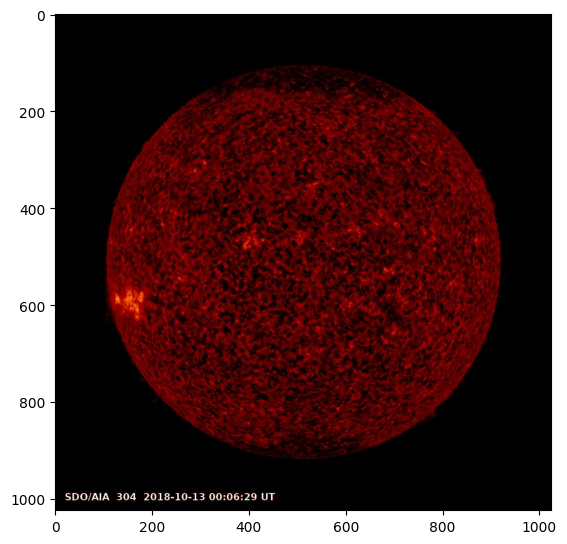

In [60]:
sample = df_valid_prominence_set.iloc[865]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "exp", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

## Submission file generation

### Test Data

In [61]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # 테스트 데이터는 라벨 파일이 없습니다.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)

100%|██████████| 6369/6369 [00:00<00:00, 288398.87it/s]


In [62]:
df_test.head(5)

id  \
0  8abb1e02042142928d5280eb2137d538   
1  e2019257735b4230b8669e8372b9b339   
2  2e31937421354646854d599dccc2c80e   
3  29da3a3a93ec4c71b5415cfaac520831   
4  4d02b3570c414445b34516800e5eef75   

                                          image_path label_path labels  
0  /mnt/elice/dataset/test/images/8abb1e020421429...                []  
1  /mnt/elice/dataset/test/images/e2019257735b423...                []  
2  /mnt/elice/dataset/test/images/2e3193742135464...                []  
3  /mnt/elice/dataset/test/images/29da3a3a93ec4c7...                []  
4  /mnt/elice/dataset/test/images/4d02b3570c41444...                []

### Test Data Image Classification

In [63]:
# 테스트 데이터셋 클래스 정의
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# 테스트 데이터셋 및 데이터 로더 생성
test_dataset = TestDataset(df_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 예측 결과 저장
predictions_test = []

with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions_test.extend(predicted.cpu().numpy())

# df_test에 예측 결과 추가
df_test['class'] = predictions_test

In [64]:
df_test.head(5)

id  \
0  8abb1e02042142928d5280eb2137d538   
1  e2019257735b4230b8669e8372b9b339   
2  2e31937421354646854d599dccc2c80e   
3  29da3a3a93ec4c71b5415cfaac520831   
4  4d02b3570c414445b34516800e5eef75   

                                          image_path label_path labels  class  
0  /mnt/elice/dataset/test/images/8abb1e020421429...                []      1  
1  /mnt/elice/dataset/test/images/e2019257735b423...                []      2  
2  /mnt/elice/dataset/test/images/2e3193742135464...                []      2  
3  /mnt/elice/dataset/test/images/29da3a3a93ec4c7...                []      1  
4  /mnt/elice/dataset/test/images/4d02b3570c41444...                []      0

In [65]:
df_test['class'].value_counts()

class
2    2281
0    2269
1    1819
Name: count, dtype: int64

In [66]:
'''
# 테스트 데이터 분류 확인
sample = df_test.iloc[0]

# 이미지 읽기
image_sample = Image.open(sample["image_path"])
image_sample
'''

'\n# 테스트 데이터 분류 확인\nsample = df_test.iloc[0]\n\n# 이미지 읽기\nimage_sample = Image.open(sample["image_path"])\nimage_sample\n'

In [67]:
df_test_coronalHole = df_test[df_test['class'] == 0]
df_test_sunspot = df_test[df_test['class'] == 1]
df_test_prominence = df_test[df_test['class'] == 2]

In [68]:
df_test_coronalHole.iloc()

# coronalHole

In [69]:
new_test_coronalHole_path = os.path.abspath("test_coronalHole")

os.makedirs(new_test_coronalHole_path, exist_ok=True)
os.makedirs(os.path.join(new_test_coronalHole_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_test_coronalHole_path, LABELS_DIR), exist_ok=True)

In [70]:
for i, row in tqdm(df_test_coronalHole.iterrows(), total=len(df_test_coronalHole)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_test_coronalHole_path}/{IMAGE_DIR}/{row['id']}.jpg")

100%|██████████| 2269/2269 [00:21<00:00, 107.36it/s]


In [71]:
!python yolov5/detect.py --source {os.path.join(new_test_coronalHole_path, IMAGE_DIR)} --weights result6_coronalHole/coronalHole/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project result6_coronalHole/test

detect: weights=['result6_coronalHole/coronalHole/weights/best.pt'], source=/home/elicer/test_coronalHole/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=result6_coronalHole/test, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/2269 /home/elicer/test_coronalHole/images/002138bcbd4343b6a6739c6f21f163d8.jpg: 640x640 2 coronal_holes, 5.1ms
image 2/2269 /home/elicer/test_coronalHole/images/002c8ed220dc477493c43d35fefb71cf.jpg: 640x640 1 coronal_hole, 5.5ms
image 3/2269 /home/elicer/t

image 66/2269 /home/elicer/test_coronalHole/images/076cb3cbd2d9403585bd4257f6d60b98.jpg: 640x640 3 coronal_holes, 5.0ms
image 67/2269 /home/elicer/test_coronalHole/images/076fb423a8944f86a2654eaca4656dd6.jpg: 640x640 1 coronal_hole, 5.0ms
image 68/2269 /home/elicer/test_coronalHole/images/078f4151a61b4c02bd3ece64f34c4b1f.jpg: 640x640 1 coronal_hole, 5.0ms
image 69/2269 /home/elicer/test_coronalHole/images/079f541e288f476894deb88bea018c53.jpg: 640x640 3 coronal_holes, 5.0ms
image 70/2269 /home/elicer/test_coronalHole/images/07b5120e23374351bc7137909834714e.jpg: 640x640 3 coronal_holes, 5.0ms
image 71/2269 /home/elicer/test_coronalHole/images/07cad47eaca74b20af0f1eb0d9ae517a.jpg: 640x640 2 coronal_holes, 5.0ms
image 72/2269 /home/elicer/test_coronalHole/images/081fa2df325d40dfa14c40ecee3e1f31.jpg: 640x640 1 coronal_hole, 5.0ms
image 73/2269 /home/elicer/test_coronalHole/images/0837042aece94023bd1e5b3224ae7c32.jpg: 640x640 4 coronal_holes, 5.0ms
image 74/2269 /home/elicer/test_coronalHole

image 135/2269 /home/elicer/test_coronalHole/images/0fc889e89eb14c6fbd36dd1e09b758e9.jpg: 640x640 1 coronal_hole, 5.0ms
image 136/2269 /home/elicer/test_coronalHole/images/0fd99d230462462b9088c95d910c2292.jpg: 640x640 2 coronal_holes, 5.0ms
image 137/2269 /home/elicer/test_coronalHole/images/0fe6fda05dbd4dfeae397730cce0c457.jpg: 640x640 2 coronal_holes, 5.0ms
image 138/2269 /home/elicer/test_coronalHole/images/0fe8683a22b643ae855ebd3c92f39d44.jpg: 640x640 3 coronal_holes, 5.0ms
image 139/2269 /home/elicer/test_coronalHole/images/0fefa4207b2343398e8f176c8d05cfb1.jpg: 640x640 1 coronal_hole, 5.0ms
image 140/2269 /home/elicer/test_coronalHole/images/0ff53e176c2847bcb0bcd925ea6a8e4d.jpg: 640x640 1 coronal_hole, 5.0ms
image 141/2269 /home/elicer/test_coronalHole/images/100142a400db4c83b71e2a6b889f1dad.jpg: 640x640 2 coronal_holes, 5.0ms
image 142/2269 /home/elicer/test_coronalHole/images/100296973f8c40f4a7ef2eab32aeb685.jpg: 640x640 1 coronal_hole, 5.0ms
image 143/2269 /home/elicer/test_cor

image 204/2269 /home/elicer/test_coronalHole/images/162357aaa051474585fe3167bffcb770.jpg: 640x640 2 coronal_holes, 5.0ms
image 205/2269 /home/elicer/test_coronalHole/images/163bb00024ba4da085c337661a5f335d.jpg: 640x640 2 coronal_holes, 5.0ms
image 206/2269 /home/elicer/test_coronalHole/images/16565ce45f654d3dbac32b0027c41862.jpg: 640x640 3 coronal_holes, 5.0ms
image 207/2269 /home/elicer/test_coronalHole/images/167b1c9878ec4f99ada5cb57c000e357.jpg: 640x640 1 coronal_hole, 5.0ms
image 208/2269 /home/elicer/test_coronalHole/images/16894e4824b244e9934f95a5c8936517.jpg: 640x640 2 coronal_holes, 5.3ms
image 209/2269 /home/elicer/test_coronalHole/images/169c42c189254298b902b4771a1e7467.jpg: 640x640 2 coronal_holes, 5.0ms
image 210/2269 /home/elicer/test_coronalHole/images/16a230bd5eb3443c8c0e73c391753f45.jpg: 640x640 1 coronal_hole, 5.0ms
image 211/2269 /home/elicer/test_coronalHole/images/16ea92263c56420eba6a298d0b65525e.jpg: 640x640 2 coronal_holes, 5.0ms
image 212/2269 /home/elicer/test_c

image 272/2269 /home/elicer/test_coronalHole/images/1d3f09455497439889d2981fdcde1d25.jpg: 640x640 2 coronal_holes, 5.0ms
image 273/2269 /home/elicer/test_coronalHole/images/1d4414188575416a9437b2a2a42a3c6c.jpg: 640x640 2 coronal_holes, 5.0ms
image 274/2269 /home/elicer/test_coronalHole/images/1d8b3b7d53fa4c3182cba8a118dccf2b.jpg: 640x640 3 coronal_holes, 5.0ms
image 275/2269 /home/elicer/test_coronalHole/images/1ddd51390fe945d192d678078abb0eb1.jpg: 640x640 2 coronal_holes, 5.0ms
image 276/2269 /home/elicer/test_coronalHole/images/1de8cfc055934931ba68d09b6d469b67.jpg: 640x640 (no detections), 5.0ms
image 277/2269 /home/elicer/test_coronalHole/images/1dfad6b88f5442f78fb0148dbfaa797e.jpg: 640x640 2 coronal_holes, 5.0ms
image 278/2269 /home/elicer/test_coronalHole/images/1e1619f3d67646ba857567a6609a6d2e.jpg: 640x640 1 coronal_hole, 5.0ms
image 279/2269 /home/elicer/test_coronalHole/images/1e4ef14951404c1fb9f33d6c51b5767a.jpg: 640x640 3 coronal_holes, 5.0ms
image 280/2269 /home/elicer/test_

image 341/2269 /home/elicer/test_coronalHole/images/25edd7786732434580a63e17b39c41db.jpg: 640x640 2 coronal_holes, 5.0ms
image 342/2269 /home/elicer/test_coronalHole/images/26272f210db04735b4f07688c7bf7614.jpg: 640x640 1 coronal_hole, 5.0ms
image 343/2269 /home/elicer/test_coronalHole/images/2639df392d6746978c38d0ebec20655b.jpg: 640x640 3 coronal_holes, 5.0ms
image 344/2269 /home/elicer/test_coronalHole/images/266c079c2f254dc6b2cb8860db203bd0.jpg: 640x640 3 coronal_holes, 5.0ms
image 345/2269 /home/elicer/test_coronalHole/images/268cdef4f3ac4d349a3d875952cc4523.jpg: 640x640 2 coronal_holes, 5.0ms
image 346/2269 /home/elicer/test_coronalHole/images/26969ea613a3435ea4ba43a82aa9c442.jpg: 640x640 4 coronal_holes, 5.0ms
image 347/2269 /home/elicer/test_coronalHole/images/26eff77ae3624601a79853a64a25aae2.jpg: 640x640 1 coronal_hole, 5.0ms
image 348/2269 /home/elicer/test_coronalHole/images/27134008bc5248778f3e8ca9bc1c15f9.jpg: 640x640 3 coronal_holes, 5.0ms
image 349/2269 /home/elicer/test_c

image 409/2269 /home/elicer/test_coronalHole/images/2e998e62af9d4e7384e17473a93e0a86.jpg: 640x640 1 coronal_hole, 5.0ms
image 410/2269 /home/elicer/test_coronalHole/images/2eae1e387da4430ebe4592d861127e85.jpg: 640x640 4 coronal_holes, 5.0ms
image 411/2269 /home/elicer/test_coronalHole/images/2eccc2f325bd43b3b3f8fb7b45c8b306.jpg: 640x640 2 coronal_holes, 5.0ms
image 412/2269 /home/elicer/test_coronalHole/images/2ef9233ef0354769ba6d4f8ec4138766.jpg: 640x640 (no detections), 5.0ms
image 413/2269 /home/elicer/test_coronalHole/images/2f2bb8e2a2a24dd58bafdaed1b816e70.jpg: 640x640 2 coronal_holes, 5.0ms
image 414/2269 /home/elicer/test_coronalHole/images/2f4ac0807b85452890b5f101a961df6d.jpg: 640x640 3 coronal_holes, 5.0ms
image 415/2269 /home/elicer/test_coronalHole/images/2f5307e263f448799450150e4ba4f528.jpg: 640x640 2 coronal_holes, 5.0ms
image 416/2269 /home/elicer/test_coronalHole/images/2f5e416cbf554c429fa119c07fe9a5b1.jpg: 640x640 2 coronal_holes, 5.0ms
image 417/2269 /home/elicer/test_

image 478/2269 /home/elicer/test_coronalHole/images/35790deffcfb4ad381e55e00b3820f29.jpg: 640x640 3 coronal_holes, 5.0ms
image 479/2269 /home/elicer/test_coronalHole/images/35bfb2adf86a4f398ba8896ce62ed8ad.jpg: 640x640 1 coronal_hole, 5.0ms
image 480/2269 /home/elicer/test_coronalHole/images/35ea66159f1d471bbe2a54ed9f8226bf.jpg: 640x640 2 coronal_holes, 5.0ms
image 481/2269 /home/elicer/test_coronalHole/images/361561e627bb41e8941e06cf202c033b.jpg: 640x640 2 coronal_holes, 5.0ms
image 482/2269 /home/elicer/test_coronalHole/images/36447c7aeb264e399ae86cd97fa9e1da.jpg: 640x640 1 coronal_hole, 5.0ms
image 483/2269 /home/elicer/test_coronalHole/images/364a35c37d2b48b09cb3a7ee8daa2813.jpg: 640x640 2 coronal_holes, 5.0ms
image 484/2269 /home/elicer/test_coronalHole/images/36555c5f4bb04996a20c92981e845b34.jpg: 640x640 2 coronal_holes, 5.0ms
image 485/2269 /home/elicer/test_coronalHole/images/367d0fe917b64b88bcb79da477fd3ab9.jpg: 640x640 1 coronal_hole, 5.0ms
image 486/2269 /home/elicer/test_co

image 548/2269 /home/elicer/test_coronalHole/images/3e1d13e6daa84e23bc48df9f52c16e84.jpg: 640x640 3 coronal_holes, 5.0ms
image 549/2269 /home/elicer/test_coronalHole/images/3e2808a3977c4bce87f2e2ac70787008.jpg: 640x640 3 coronal_holes, 5.0ms
image 550/2269 /home/elicer/test_coronalHole/images/3e3a8785317042b5adf324c9ee2c45a3.jpg: 640x640 3 coronal_holes, 5.0ms
image 551/2269 /home/elicer/test_coronalHole/images/3e900056acb44087a07dfe3619da58a6.jpg: 640x640 1 coronal_hole, 5.0ms
image 552/2269 /home/elicer/test_coronalHole/images/3e95c619d94b4c5096a04ee41f3c7b38.jpg: 640x640 2 coronal_holes, 5.0ms
image 553/2269 /home/elicer/test_coronalHole/images/3e9f664b24d64116915491f3e5427e9c.jpg: 640x640 3 coronal_holes, 5.0ms
image 554/2269 /home/elicer/test_coronalHole/images/3ed1ac6219a6461ca9c85ecd7f877d2e.jpg: 640x640 3 coronal_holes, 5.0ms
image 555/2269 /home/elicer/test_coronalHole/images/3ed4917fb9684aadb6ec8825123bd0c4.jpg: 640x640 1 coronal_hole, 5.0ms
image 556/2269 /home/elicer/test_c

image 617/2269 /home/elicer/test_coronalHole/images/44f1c113d8e147eab82bea930d07613a.jpg: 640x640 3 coronal_holes, 5.0ms
image 618/2269 /home/elicer/test_coronalHole/images/44f31a615b6d449fbf90e01859286d0a.jpg: 640x640 2 coronal_holes, 5.0ms
image 619/2269 /home/elicer/test_coronalHole/images/453cb31b1317403bb224c2083a9b22ef.jpg: 640x640 2 coronal_holes, 5.0ms
image 620/2269 /home/elicer/test_coronalHole/images/45406359df84493596bb944a18b84718.jpg: 640x640 2 coronal_holes, 5.0ms
image 621/2269 /home/elicer/test_coronalHole/images/454d28d5982c4be49c4b0f47f3a785a4.jpg: 640x640 2 coronal_holes, 5.0ms
image 622/2269 /home/elicer/test_coronalHole/images/456cfa4553e64fccb2dce0389216fdf8.jpg: 640x640 2 coronal_holes, 5.0ms
image 623/2269 /home/elicer/test_coronalHole/images/4598a570a20645ff893b5e299d889fbd.jpg: 640x640 3 coronal_holes, 5.0ms
image 624/2269 /home/elicer/test_coronalHole/images/45a3170ac28c4031a5b8e57af93ebef7.jpg: 640x640 3 coronal_holes, 5.0ms
image 625/2269 /home/elicer/test

image 687/2269 /home/elicer/test_coronalHole/images/4d7c585d67cf45dd949762bc796facb6.jpg: 640x640 4 coronal_holes, 5.0ms
image 688/2269 /home/elicer/test_coronalHole/images/4de3e985cfa44912ab63b5a4cbf00310.jpg: 640x640 1 coronal_hole, 5.0ms
image 689/2269 /home/elicer/test_coronalHole/images/4de7c5ab97594a3eb2a1f30b75d94690.jpg: 640x640 1 coronal_hole, 5.0ms
image 690/2269 /home/elicer/test_coronalHole/images/4df5892768f64495af6eb10a64c3b61b.jpg: 640x640 2 coronal_holes, 5.0ms
image 691/2269 /home/elicer/test_coronalHole/images/4dfc68c731534f6ca366c92028abb7ec.jpg: 640x640 2 coronal_holes, 5.0ms
image 692/2269 /home/elicer/test_coronalHole/images/4e365616b4bf4657b4211f7d95bf2f39.jpg: 640x640 2 coronal_holes, 5.0ms
image 693/2269 /home/elicer/test_coronalHole/images/4e9539a9f4b64052b4fe039104032fd9.jpg: 640x640 1 coronal_hole, 5.0ms
image 694/2269 /home/elicer/test_coronalHole/images/4eaa6ef571014d3e9656a2c2b4bd27c5.jpg: 640x640 3 coronal_holes, 5.0ms
image 695/2269 /home/elicer/test_co

image 755/2269 /home/elicer/test_coronalHole/images/56d58d9b5e2549a59da356bbc7e109fc.jpg: 640x640 2 coronal_holes, 5.0ms
image 756/2269 /home/elicer/test_coronalHole/images/57157bf8521647e08b740b6d5ca2dc53.jpg: 640x640 3 coronal_holes, 5.0ms
image 757/2269 /home/elicer/test_coronalHole/images/5737f489d0154c32a6df405f60e851ad.jpg: 640x640 2 coronal_holes, 5.0ms
image 758/2269 /home/elicer/test_coronalHole/images/574250756eed4065a0e5b4cdd16ae83f.jpg: 640x640 1 coronal_hole, 5.0ms
image 759/2269 /home/elicer/test_coronalHole/images/576a4fa018ae472d8e932e4df8fe1fd5.jpg: 640x640 (no detections), 5.0ms
image 760/2269 /home/elicer/test_coronalHole/images/576f808c09c949d3981d4759a04a3bba.jpg: 640x640 3 coronal_holes, 5.0ms
image 761/2269 /home/elicer/test_coronalHole/images/57abd5b0de2142178ed165ac1740752e.jpg: 640x640 2 coronal_holes, 5.0ms
image 762/2269 /home/elicer/test_coronalHole/images/57f27262eee946eba2cb6ba391f6864f.jpg: 640x640 3 coronal_holes, 5.0ms
image 763/2269 /home/elicer/test_

image 825/2269 /home/elicer/test_coronalHole/images/5dd7c85c79d04050b1419ff5eb719148.jpg: 640x640 3 coronal_holes, 5.0ms
image 826/2269 /home/elicer/test_coronalHole/images/5de7b43f6e234e128686233371430a5d.jpg: 640x640 2 coronal_holes, 5.0ms
image 827/2269 /home/elicer/test_coronalHole/images/5e239418d1cc4a4eb199375aaf2c8301.jpg: 640x640 3 coronal_holes, 5.0ms
image 828/2269 /home/elicer/test_coronalHole/images/5e40722ac3974dbcb47df6ae62d1dcb7.jpg: 640x640 3 coronal_holes, 5.5ms
image 829/2269 /home/elicer/test_coronalHole/images/5e48d66195d44520b584da02783cacb2.jpg: 640x640 2 coronal_holes, 5.0ms
image 830/2269 /home/elicer/test_coronalHole/images/5eef349f740447fa9fb5a8804f95faf9.jpg: 640x640 4 coronal_holes, 5.0ms
image 831/2269 /home/elicer/test_coronalHole/images/5f3c85ff016546e0ba7d9faeaedef93b.jpg: 640x640 2 coronal_holes, 5.0ms
image 832/2269 /home/elicer/test_coronalHole/images/5f575613b32c42ffa03ee89182e624e2.jpg: 640x640 2 coronal_holes, 5.0ms
image 833/2269 /home/elicer/test

image 895/2269 /home/elicer/test_coronalHole/images/64e339ab675a4238bf4edc00cc6a1ddf.jpg: 640x640 1 coronal_hole, 5.0ms
image 896/2269 /home/elicer/test_coronalHole/images/64e3c72773b74aa5823cda3fb41b285b.jpg: 640x640 3 coronal_holes, 5.0ms
image 897/2269 /home/elicer/test_coronalHole/images/64e5daaa690b4231a40ed9c41c9acf90.jpg: 640x640 4 coronal_holes, 5.0ms
image 898/2269 /home/elicer/test_coronalHole/images/64f09fe33b374c94b8ff1247cc9f599e.jpg: 640x640 2 coronal_holes, 5.0ms
image 899/2269 /home/elicer/test_coronalHole/images/6500d2fb7a5646df99c893284aa599c8.jpg: 640x640 2 coronal_holes, 5.0ms
image 900/2269 /home/elicer/test_coronalHole/images/650f2fdfa35345358a01f6df941dcb80.jpg: 640x640 3 coronal_holes, 5.0ms
image 901/2269 /home/elicer/test_coronalHole/images/651427b4dc374157b199fd0f6dd8c288.jpg: 640x640 4 coronal_holes, 5.0ms
image 902/2269 /home/elicer/test_coronalHole/images/655457d46d1442a8b2d1231c31078b54.jpg: 640x640 3 coronal_holes, 5.0ms
image 903/2269 /home/elicer/test_

image 965/2269 /home/elicer/test_coronalHole/images/6ae346241c8a47d590618eed4d95d3b6.jpg: 640x640 1 coronal_hole, 5.0ms
image 966/2269 /home/elicer/test_coronalHole/images/6af192998f9541bf9db8f15cd142a73f.jpg: 640x640 3 coronal_holes, 5.0ms
image 967/2269 /home/elicer/test_coronalHole/images/6afa1ec0ea474ae5aa40912e784e7a35.jpg: 640x640 2 coronal_holes, 5.0ms
image 968/2269 /home/elicer/test_coronalHole/images/6b1094386f7c440dbafcd3691aacaa27.jpg: 640x640 4 coronal_holes, 5.0ms
image 969/2269 /home/elicer/test_coronalHole/images/6b314d2e1d48458b8754e61ee29f2aab.jpg: 640x640 4 coronal_holes, 5.0ms
image 970/2269 /home/elicer/test_coronalHole/images/6b360556fa394c368321c2306b2925de.jpg: 640x640 3 coronal_holes, 5.0ms
image 971/2269 /home/elicer/test_coronalHole/images/6b37107f6b6b42c08a74c21bfcf3fd9a.jpg: 640x640 3 coronal_holes, 5.0ms
image 972/2269 /home/elicer/test_coronalHole/images/6b3e0166caf04bb5a6cd362190154a70.jpg: 640x640 4 coronal_holes, 5.0ms
image 973/2269 /home/elicer/test_

image 1035/2269 /home/elicer/test_coronalHole/images/71c6917be87342d892d9c6d98c33353a.jpg: 640x640 2 coronal_holes, 5.0ms
image 1036/2269 /home/elicer/test_coronalHole/images/71c724a488e440fea5136c6a6bff5235.jpg: 640x640 1 coronal_hole, 4.9ms
image 1037/2269 /home/elicer/test_coronalHole/images/71ea446ab30e4e38a593f0e5a390780c.jpg: 640x640 3 coronal_holes, 5.0ms
image 1038/2269 /home/elicer/test_coronalHole/images/7209fdccb10448b3a7024960e9caa63a.jpg: 640x640 2 coronal_holes, 5.0ms
image 1039/2269 /home/elicer/test_coronalHole/images/722d4e640bb146c99f99c92336fc195f.jpg: 640x640 1 coronal_hole, 5.0ms
image 1040/2269 /home/elicer/test_coronalHole/images/724dc5fe47ad4e7483639ca05979e170.jpg: 640x640 1 coronal_hole, 5.0ms
image 1041/2269 /home/elicer/test_coronalHole/images/7252a91f01ca493c81214e165ee30b85.jpg: 640x640 1 coronal_hole, 5.0ms
image 1042/2269 /home/elicer/test_coronalHole/images/725387919c7f42c88408389bb5c74da2.jpg: 640x640 2 coronal_holes, 5.0ms
image 1043/2269 /home/elicer

image 1105/2269 /home/elicer/test_coronalHole/images/78f6d5ca45d5420e986f57d6e9b7dfa8.jpg: 640x640 2 coronal_holes, 5.0ms
image 1106/2269 /home/elicer/test_coronalHole/images/78fd4858df9043eab7d5ace1c1c31cc8.jpg: 640x640 1 coronal_hole, 5.0ms
image 1107/2269 /home/elicer/test_coronalHole/images/791f95e119b44ec6b1b044eb21216bd7.jpg: 640x640 2 coronal_holes, 5.0ms
image 1108/2269 /home/elicer/test_coronalHole/images/79270e653a8f4b6cb0a92d8b3e9cf24c.jpg: 640x640 2 coronal_holes, 5.0ms
image 1109/2269 /home/elicer/test_coronalHole/images/792ab9f5125849e8851011b171e6689d.jpg: 640x640 2 coronal_holes, 5.0ms
image 1110/2269 /home/elicer/test_coronalHole/images/794a78dd4c994c4ba90934869dcc67c6.jpg: 640x640 (no detections), 5.0ms
image 1111/2269 /home/elicer/test_coronalHole/images/797c7b566c264abc9c4d1f3e579a9439.jpg: 640x640 2 coronal_holes, 5.0ms
image 1112/2269 /home/elicer/test_coronalHole/images/799509fd095945958925b90069ba6fd8.jpg: 640x640 (no detections), 5.0ms
image 1113/2269 /home/eli

image 1173/2269 /home/elicer/test_coronalHole/images/809f56520c6b4f8ea3b321ce84ee2a95.jpg: 640x640 3 coronal_holes, 5.0ms
image 1174/2269 /home/elicer/test_coronalHole/images/80ea448c54714bc2aebb8df1ed8ed96e.jpg: 640x640 3 coronal_holes, 5.0ms
image 1175/2269 /home/elicer/test_coronalHole/images/81682e8c38474e68ad0a4f0806b6fd13.jpg: 640x640 2 coronal_holes, 5.0ms
image 1176/2269 /home/elicer/test_coronalHole/images/820372b096f043a7b017d53b32051653.jpg: 640x640 1 coronal_hole, 5.0ms
image 1177/2269 /home/elicer/test_coronalHole/images/82191d1e1c08475c8e79c660cc810a72.jpg: 640x640 2 coronal_holes, 5.0ms
image 1178/2269 /home/elicer/test_coronalHole/images/82278219a2fb43c88015a80f512a8932.jpg: 640x640 2 coronal_holes, 5.0ms
image 1179/2269 /home/elicer/test_coronalHole/images/8271e5f95500411390a2b179d6fc1941.jpg: 640x640 2 coronal_holes, 5.0ms
image 1180/2269 /home/elicer/test_coronalHole/images/82c4a9171a494f19849368daec24b3e7.jpg: 640x640 3 coronal_holes, 5.0ms
image 1181/2269 /home/eli

image 1241/2269 /home/elicer/test_coronalHole/images/893dff3c088a4224ac48150232ab64ad.jpg: 640x640 2 coronal_holes, 5.0ms
image 1242/2269 /home/elicer/test_coronalHole/images/8977656749eb4f8ea5521a4585b46d51.jpg: 640x640 2 coronal_holes, 5.0ms
image 1243/2269 /home/elicer/test_coronalHole/images/89a874a07e3f4d1182a6e7f6e93031be.jpg: 640x640 1 coronal_hole, 5.0ms
image 1244/2269 /home/elicer/test_coronalHole/images/8a04e7183c5946c8a20d4afd9de7c6e4.jpg: 640x640 3 coronal_holes, 4.9ms
image 1245/2269 /home/elicer/test_coronalHole/images/8a1d50647cc545ef8fc820554734e083.jpg: 640x640 2 coronal_holes, 5.0ms
image 1246/2269 /home/elicer/test_coronalHole/images/8a1dfbf510ee4210b386d059b31b581d.jpg: 640x640 1 coronal_hole, 5.0ms
image 1247/2269 /home/elicer/test_coronalHole/images/8a255936a46e4e45b58e7ff2512f18d2.jpg: 640x640 3 coronal_holes, 5.0ms
image 1248/2269 /home/elicer/test_coronalHole/images/8a2c69705b054aaa8499ebd1312971be.jpg: 640x640 2 coronal_holes, 5.0ms
image 1249/2269 /home/elic

image 1311/2269 /home/elicer/test_coronalHole/images/90e4b8e5ef7340db9ee0358987f88522.jpg: 640x640 4 coronal_holes, 5.0ms
image 1312/2269 /home/elicer/test_coronalHole/images/910de453ce2f48efbc55559e453bc056.jpg: 640x640 1 coronal_hole, 5.0ms
image 1313/2269 /home/elicer/test_coronalHole/images/9119dcac053c445d931daaaf9c19b582.jpg: 640x640 1 coronal_hole, 5.0ms
image 1314/2269 /home/elicer/test_coronalHole/images/913bbcdedbae4329ae3a626cba40f0f5.jpg: 640x640 2 coronal_holes, 5.0ms
image 1315/2269 /home/elicer/test_coronalHole/images/91ad81d6c39046368c353e72c13d4183.jpg: 640x640 3 coronal_holes, 5.0ms
image 1316/2269 /home/elicer/test_coronalHole/images/91aefd65fa114d73aaf34f79a9d057eb.jpg: 640x640 4 coronal_holes, 5.0ms
image 1317/2269 /home/elicer/test_coronalHole/images/91c09b7567e545debb65ae53a87d0532.jpg: 640x640 1 coronal_hole, 5.0ms
image 1318/2269 /home/elicer/test_coronalHole/images/920131212af3488188726e5a46b7b284.jpg: 640x640 2 coronal_holes, 5.0ms
image 1319/2269 /home/elice

image 1381/2269 /home/elicer/test_coronalHole/images/98de166ebc6a46c38dd949fd8081452c.jpg: 640x640 5 coronal_holes, 4.9ms
image 1382/2269 /home/elicer/test_coronalHole/images/98f41e6e49514fa889694a61069a380f.jpg: 640x640 3 coronal_holes, 5.0ms
image 1383/2269 /home/elicer/test_coronalHole/images/98fca9d7157242afa172fd51f975ff43.jpg: 640x640 3 coronal_holes, 5.0ms
image 1384/2269 /home/elicer/test_coronalHole/images/98fcf1dc7c0d468b9366a650176dc714.jpg: 640x640 1 coronal_hole, 5.0ms
image 1385/2269 /home/elicer/test_coronalHole/images/9917ca37260c4e0680ef91d960ce8c4e.jpg: 640x640 (no detections), 5.0ms
image 1386/2269 /home/elicer/test_coronalHole/images/992f63df0b4a48ef806f0da841e8c25b.jpg: 640x640 2 coronal_holes, 5.0ms
image 1387/2269 /home/elicer/test_coronalHole/images/996a1010dc3346758309bf82f3e80c2f.jpg: 640x640 2 coronal_holes, 5.0ms
image 1388/2269 /home/elicer/test_coronalHole/images/9973393acf10475bb775cd5bd65e5e40.jpg: 640x640 2 coronal_holes, 5.0ms
image 1389/2269 /home/eli

image 1450/2269 /home/elicer/test_coronalHole/images/a0895095ad5a431c9d0e1cd64f72d597.jpg: 640x640 2 coronal_holes, 5.0ms
image 1451/2269 /home/elicer/test_coronalHole/images/a08b40d947df474ea33962ee6e109f95.jpg: 640x640 1 coronal_hole, 5.0ms
image 1452/2269 /home/elicer/test_coronalHole/images/a09336a713574301b2ac94dec2b1bc8a.jpg: 640x640 1 coronal_hole, 5.0ms
image 1453/2269 /home/elicer/test_coronalHole/images/a09658f2a4804e80bb3550b18d0070d6.jpg: 640x640 1 coronal_hole, 5.0ms
image 1454/2269 /home/elicer/test_coronalHole/images/a0d34aa43adb4b8f9dd272009934d6c9.jpg: 640x640 1 coronal_hole, 5.0ms
image 1455/2269 /home/elicer/test_coronalHole/images/a0e538245dac4433949f6f1016fc6973.jpg: 640x640 1 coronal_hole, 5.0ms
image 1456/2269 /home/elicer/test_coronalHole/images/a0e8df1c01d8464ea90050e8abec2701.jpg: 640x640 (no detections), 4.9ms
image 1457/2269 /home/elicer/test_coronalHole/images/a158aa3f2be140ce872bbc8bc2ca8c16.jpg: 640x640 3 coronal_holes, 5.0ms
image 1458/2269 /home/elicer/

image 1518/2269 /home/elicer/test_coronalHole/images/a90f9713deb344c3a7e8a415f7416486.jpg: 640x640 2 coronal_holes, 5.0ms
image 1519/2269 /home/elicer/test_coronalHole/images/a971287a2f394af9967824d3bccfde98.jpg: 640x640 1 coronal_hole, 4.9ms
image 1520/2269 /home/elicer/test_coronalHole/images/a97591222f3840d382b3f92af63981ea.jpg: 640x640 1 coronal_hole, 5.0ms
image 1521/2269 /home/elicer/test_coronalHole/images/a99d499fd01b431285bffa1e62080add.jpg: 640x640 2 coronal_holes, 5.0ms
image 1522/2269 /home/elicer/test_coronalHole/images/a9a904f5d82249d7b8ade27681bdb757.jpg: 640x640 1 coronal_hole, 5.0ms
image 1523/2269 /home/elicer/test_coronalHole/images/a9ad37fa20284cf29ef414df7035a194.jpg: 640x640 3 coronal_holes, 5.0ms
image 1524/2269 /home/elicer/test_coronalHole/images/aa305c3987834c0dbbad55a95e8bd53b.jpg: 640x640 3 coronal_holes, 5.0ms
image 1525/2269 /home/elicer/test_coronalHole/images/aa3534e69c474f56bd4aa11b8a275324.jpg: 640x640 4 coronal_holes, 5.0ms
image 1526/2269 /home/elice

image 1588/2269 /home/elicer/test_coronalHole/images/b099375b170545aa933e3c8cb8dfd321.jpg: 640x640 3 coronal_holes, 5.0ms
image 1589/2269 /home/elicer/test_coronalHole/images/b09e4eb306534f3296c44d5c153847a9.jpg: 640x640 2 coronal_holes, 5.0ms
image 1590/2269 /home/elicer/test_coronalHole/images/b0a9e4f023414046ab93ea67d6dc38f2.jpg: 640x640 2 coronal_holes, 5.0ms
image 1591/2269 /home/elicer/test_coronalHole/images/b0b789221d564daabdf0fb1e81b49bfc.jpg: 640x640 3 coronal_holes, 5.1ms
image 1592/2269 /home/elicer/test_coronalHole/images/b0ccc72268a54827ae1b6ab0139a0cde.jpg: 640x640 2 coronal_holes, 5.0ms
image 1593/2269 /home/elicer/test_coronalHole/images/b117d119ed65430caffeb1337adcf311.jpg: 640x640 2 coronal_holes, 5.0ms
image 1594/2269 /home/elicer/test_coronalHole/images/b16ddf38d4f740b2aa03d3ff0b82dd3b.jpg: 640x640 1 coronal_hole, 5.0ms
image 1595/2269 /home/elicer/test_coronalHole/images/b187d52fee38468d9e9911555bf4839a.jpg: 640x640 2 coronal_holes, 5.0ms
image 1596/2269 /home/eli

image 1658/2269 /home/elicer/test_coronalHole/images/b88072de8aac44f9a0a22156a879ac3c.jpg: 640x640 3 coronal_holes, 5.3ms
image 1659/2269 /home/elicer/test_coronalHole/images/b888c23902be452c95381ffc2ac1f43d.jpg: 640x640 1 coronal_hole, 5.4ms
image 1660/2269 /home/elicer/test_coronalHole/images/b8c9fd8ff3894f178ee330c4ba285a95.jpg: 640x640 3 coronal_holes, 5.4ms
image 1661/2269 /home/elicer/test_coronalHole/images/b8ca1cc9070d4a04b9cfc596b6477393.jpg: 640x640 3 coronal_holes, 5.4ms
image 1662/2269 /home/elicer/test_coronalHole/images/b8f8422f6cfb4749a1fafdcf0ffaa652.jpg: 640x640 3 coronal_holes, 5.5ms
image 1663/2269 /home/elicer/test_coronalHole/images/b8fe3f69b70847d995c1f1bf3ccf3d64.jpg: 640x640 2 coronal_holes, 5.6ms
image 1664/2269 /home/elicer/test_coronalHole/images/b93a3dbefecc45e6a289b4f7d918f460.jpg: 640x640 2 coronal_holes, 5.5ms
image 1665/2269 /home/elicer/test_coronalHole/images/b988124475394ae7a2d99b22c7a5e7be.jpg: 640x640 2 coronal_holes, 5.5ms
image 1666/2269 /home/eli

image 1728/2269 /home/elicer/test_coronalHole/images/c0f518ff1e874d67b4dec97b73ada17f.jpg: 640x640 3 coronal_holes, 5.4ms
image 1729/2269 /home/elicer/test_coronalHole/images/c105fcef0fda44b2af72606fa109b901.jpg: 640x640 1 coronal_hole, 5.6ms
image 1730/2269 /home/elicer/test_coronalHole/images/c117714a6f8d468f9194c9aeed1405b7.jpg: 640x640 2 coronal_holes, 5.6ms
image 1731/2269 /home/elicer/test_coronalHole/images/c120a56b46794b219f6f047cd8fee751.jpg: 640x640 2 coronal_holes, 5.6ms
image 1732/2269 /home/elicer/test_coronalHole/images/c13ff61fd05148b8b64d7bf042430e9b.jpg: 640x640 2 coronal_holes, 5.6ms
image 1733/2269 /home/elicer/test_coronalHole/images/c173ebbbaf9b4a79bc36594181d4b944.jpg: 640x640 1 coronal_hole, 5.6ms
image 1734/2269 /home/elicer/test_coronalHole/images/c17ce03110a54408b2e8f97888c6dbf0.jpg: 640x640 1 coronal_hole, 5.6ms
image 1735/2269 /home/elicer/test_coronalHole/images/c1a4434b062442098a2d0e375756be25.jpg: 640x640 2 coronal_holes, 5.6ms
image 1736/2269 /home/elice

image 1798/2269 /home/elicer/test_coronalHole/images/c90086f6e2c7448e9f331b5e791eb0b6.jpg: 640x640 3 coronal_holes, 5.0ms
image 1799/2269 /home/elicer/test_coronalHole/images/c9630073a8874234ae9469080ed77c69.jpg: 640x640 3 coronal_holes, 5.0ms
image 1800/2269 /home/elicer/test_coronalHole/images/c97456cefdaa4880b5684b5e0daf4a44.jpg: 640x640 4 coronal_holes, 5.0ms
image 1801/2269 /home/elicer/test_coronalHole/images/c97f7952a051416eaa3359bb6ed8fbe7.jpg: 640x640 2 coronal_holes, 5.0ms
image 1802/2269 /home/elicer/test_coronalHole/images/c9c535445a8244b99ea3ddc678b876c3.jpg: 640x640 3 coronal_holes, 5.0ms
image 1803/2269 /home/elicer/test_coronalHole/images/c9c684b28bac4c6fa93f9e9013f3b36c.jpg: 640x640 3 coronal_holes, 5.0ms
image 1804/2269 /home/elicer/test_coronalHole/images/ca0024bad5c04d2e8b5b74ca1516c3c7.jpg: 640x640 (no detections), 5.0ms
image 1805/2269 /home/elicer/test_coronalHole/images/ca0118848bc04024bd7ccf886cef9e0e.jpg: 640x640 1 coronal_hole, 5.0ms
image 1806/2269 /home/eli

image 1867/2269 /home/elicer/test_coronalHole/images/d11d1b614b364050bfafca52f1a30160.jpg: 640x640 1 coronal_hole, 5.0ms
image 1868/2269 /home/elicer/test_coronalHole/images/d1357f35b1d548d98e7fa759d6c0ce42.jpg: 640x640 2 coronal_holes, 5.0ms
image 1869/2269 /home/elicer/test_coronalHole/images/d143ded9b3c347f78046a44e4f84a8c3.jpg: 640x640 3 coronal_holes, 5.0ms
image 1870/2269 /home/elicer/test_coronalHole/images/d14d9906bc16483b8174a0bf7ab8bd9b.jpg: 640x640 2 coronal_holes, 5.0ms
image 1871/2269 /home/elicer/test_coronalHole/images/d155435280b4441f89fa7275553de102.jpg: 640x640 2 coronal_holes, 5.0ms
image 1872/2269 /home/elicer/test_coronalHole/images/d1757764312e473e8b82ca83afa87021.jpg: 640x640 3 coronal_holes, 5.0ms
image 1873/2269 /home/elicer/test_coronalHole/images/d17b9cbd8a74405480f241eeedcc27cf.jpg: 640x640 2 coronal_holes, 4.9ms
image 1874/2269 /home/elicer/test_coronalHole/images/d1c36391ba85472aa76a496d150a21ed.jpg: 640x640 1 coronal_hole, 5.0ms
image 1875/2269 /home/elic

image 1935/2269 /home/elicer/test_coronalHole/images/d93f3b76979c4fcaaef227d3bbfb1b54.jpg: 640x640 3 coronal_holes, 5.0ms
image 1936/2269 /home/elicer/test_coronalHole/images/d95a849c9b9d4926a6aa24726c436870.jpg: 640x640 2 coronal_holes, 5.0ms
image 1937/2269 /home/elicer/test_coronalHole/images/d9652970b8d34c3684b17aa1070ee405.jpg: 640x640 (no detections), 5.0ms
image 1938/2269 /home/elicer/test_coronalHole/images/d970f94bdc044f0cb24fa76d2cd7934a.jpg: 640x640 3 coronal_holes, 5.0ms
image 1939/2269 /home/elicer/test_coronalHole/images/d98124b9ea3b4b65815ccd0731feeb4b.jpg: 640x640 3 coronal_holes, 5.0ms
image 1940/2269 /home/elicer/test_coronalHole/images/d98202c03d8f49478e9d630af1bb44bc.jpg: 640x640 4 coronal_holes, 5.0ms
image 1941/2269 /home/elicer/test_coronalHole/images/d98d9429b24d41879e69b76f7da7f2cb.jpg: 640x640 1 coronal_hole, 5.0ms
image 1942/2269 /home/elicer/test_coronalHole/images/d99b25eb16444b1dbd218272ae587b65.jpg: 640x640 2 coronal_holes, 5.0ms
image 1943/2269 /home/eli

image 2004/2269 /home/elicer/test_coronalHole/images/e011000d693f40d59d3dec84c59d1efb.jpg: 640x640 1 coronal_hole, 5.0ms
image 2005/2269 /home/elicer/test_coronalHole/images/e086cd4834d24298bf8ea273e83af753.jpg: 640x640 2 coronal_holes, 5.0ms
image 2006/2269 /home/elicer/test_coronalHole/images/e08b705fd9064960b2051390cd51a873.jpg: 640x640 1 coronal_hole, 5.0ms
image 2007/2269 /home/elicer/test_coronalHole/images/e0a80170bf2e41f0a9a1901e616c90df.jpg: 640x640 4 coronal_holes, 5.0ms
image 2008/2269 /home/elicer/test_coronalHole/images/e0cd126ff38d44a6a73949b7b5c10eee.jpg: 640x640 2 coronal_holes, 5.0ms
image 2009/2269 /home/elicer/test_coronalHole/images/e116c096e8e647038dcc89bb59a6eb8f.jpg: 640x640 2 coronal_holes, 5.0ms
image 2010/2269 /home/elicer/test_coronalHole/images/e14d6b926c9549e5bbe76ae6d513ecba.jpg: 640x640 2 coronal_holes, 5.0ms
image 2011/2269 /home/elicer/test_coronalHole/images/e18828e2a0cf4f0c8b6b75b8eac5aef8.jpg: 640x640 1 coronal_hole, 5.0ms
image 2012/2269 /home/elice

image 2072/2269 /home/elicer/test_coronalHole/images/e95a1c92c7f74ca0b3a08aa837b26cc6.jpg: 640x640 3 coronal_holes, 5.0ms
image 2073/2269 /home/elicer/test_coronalHole/images/e966a36e49fe401d81fcb34711d44ed6.jpg: 640x640 2 coronal_holes, 5.0ms
image 2074/2269 /home/elicer/test_coronalHole/images/e96fa54e6fef4aceb39b4efe35055797.jpg: 640x640 3 coronal_holes, 5.0ms
image 2075/2269 /home/elicer/test_coronalHole/images/e9830bb6d83143c5a0ce6f84bdba29df.jpg: 640x640 2 coronal_holes, 4.9ms
image 2076/2269 /home/elicer/test_coronalHole/images/e98ceb4c5fd443869da86d9c68b9359b.jpg: 640x640 1 coronal_hole, 5.0ms
image 2077/2269 /home/elicer/test_coronalHole/images/e99a6f39812f4a44ba0de132f8d35e21.jpg: 640x640 3 coronal_holes, 5.0ms
image 2078/2269 /home/elicer/test_coronalHole/images/e9cd02e52ee345a58051c76901b4ba97.jpg: 640x640 3 coronal_holes, 5.0ms
image 2079/2269 /home/elicer/test_coronalHole/images/e9fadf48dadd4d6c82c3d86d2f3d7826.jpg: 640x640 2 coronal_holes, 5.0ms
image 2080/2269 /home/eli

image 2142/2269 /home/elicer/test_coronalHole/images/f19cccd3193d4c148fed10eaadb74d1e.jpg: 640x640 4 coronal_holes, 5.0ms
image 2143/2269 /home/elicer/test_coronalHole/images/f1dc222ae4284456b158de9e5b2bc86b.jpg: 640x640 2 coronal_holes, 5.0ms
image 2144/2269 /home/elicer/test_coronalHole/images/f22d61c3e4844ca0b1bf398fb3397a1f.jpg: 640x640 3 coronal_holes, 5.0ms
image 2145/2269 /home/elicer/test_coronalHole/images/f2397f6ab4ad4f39b4c8e8e59bf636e9.jpg: 640x640 2 coronal_holes, 5.0ms
image 2146/2269 /home/elicer/test_coronalHole/images/f2495a6475574e41830816d4acedd72c.jpg: 640x640 1 coronal_hole, 5.0ms
image 2147/2269 /home/elicer/test_coronalHole/images/f24f158185b04500b2ce24940d7de442.jpg: 640x640 2 coronal_holes, 5.0ms
image 2148/2269 /home/elicer/test_coronalHole/images/f29e07155a76407ca3ff6d259e2ce71d.jpg: 640x640 1 coronal_hole, 5.0ms
image 2149/2269 /home/elicer/test_coronalHole/images/f2aa6947e36c435aa555357b9c0a24de.jpg: 640x640 3 coronal_holes, 5.0ms
image 2150/2269 /home/elic

image 2212/2269 /home/elicer/test_coronalHole/images/fa77231cf4234c7fa7e7e2dea227ff02.jpg: 640x640 3 coronal_holes, 5.0ms
image 2213/2269 /home/elicer/test_coronalHole/images/fa7db69672874c7cbba3e300da3f8d80.jpg: 640x640 2 coronal_holes, 5.0ms
image 2214/2269 /home/elicer/test_coronalHole/images/fa80bc08f3164e01a2ee8e644160e7f4.jpg: 640x640 3 coronal_holes, 5.0ms
image 2215/2269 /home/elicer/test_coronalHole/images/fa831066ece74e9eb94dcd8b359096a7.jpg: 640x640 2 coronal_holes, 5.0ms
image 2216/2269 /home/elicer/test_coronalHole/images/fa89fd5bd14c4d1785ae1303eaabf9b1.jpg: 640x640 1 coronal_hole, 5.0ms
image 2217/2269 /home/elicer/test_coronalHole/images/fa9e2963771744fa8a8efe8da6a69617.jpg: 640x640 1 coronal_hole, 5.0ms
image 2218/2269 /home/elicer/test_coronalHole/images/fab126a446204f069252194ccd931785.jpg: 640x640 1 coronal_hole, 5.0ms
image 2219/2269 /home/elicer/test_coronalHole/images/fab30546bc634ccdac2220d06c22a0ff.jpg: 640x640 1 coronal_hole, 5.0ms
image 2220/2269 /home/elicer

In [72]:
for i, row in tqdm(df_test_coronalHole.iterrows(), total=len(df_test_coronalHole)):
    label_path = os.path.join("result6_coronalHole", "test", "exp", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test_coronalHole.at[i, "labels"] = labels
df_test_coronalHole

100%|██████████| 2269/2269 [00:00<00:00, 6422.48it/s]


id  \
4     4d02b3570c414445b34516800e5eef75   
5     b8c9fd8ff3894f178ee330c4ba285a95   
9     900171cc7641448bb3e546aa68ff16c3   
12    be395257cc8d4fab891d24672a6c1052   
15    1712b54ce3b645058cec2120d60cd1ea   
...                                ...   
6351  ce7ac1c429f1425c8c7ff9b0dd5c3b21   
6353  5995ea87eed64fe8b8c546720c709d1b   
6357  bca8844c96ef44a38145341e4a06cc91   
6360  face0c0796cc479db13da2e870a3a875   
6362  8dd66b4b91e54c0dbc5989fab217836f   

                                             image_path label_path  \
4     /mnt/elice/dataset/test/images/4d02b3570c41444...              
5     /mnt/elice/dataset/test/images/b8c9fd8ff3894f1...              
9     /mnt/elice/dataset/test/images/900171cc7641448...              
12    /mnt/elice/dataset/test/images/be395257cc8d4fa...              
15    /mnt/elice/dataset/test/images/1712b54ce3b6450...              
...                                                 ...        ...   
6351  /mnt/elice/dataset/test/images/ce7ac1c429f1425...              
6353  /mnt/elice/dataset/test/images/5995ea87eed64fe...              
6357  /mnt/elice/dataset/test/images/bca8844c96ef44a...              
6360  /mnt/elice/dataset/test/images/face0c0796cc479...              
6362  /mnt/elice/dataset/test/images/8dd66b4b91e54c0...              

                                                 labels  class  
4     [{'class_id': 0, 'conf': 0.911324, 'x': 0.5166...      0  
5     [{'class_id': 0, 'conf': 0.739832, 'x': 0.7851...      0  
9     [{'class_id': 0, 'conf': 0.91488, 'x': 0.56298...      0  
12    [{'class_id': 0, 'conf': 0.505566, 'x': 0.4013...      0  
15    [{'class_id': 0, 'conf': 0.885726, 'x': 0.4731...      0  
...                                                 ...    ...  
6351  [{'class_id': 0, 'conf': 0.790608, 'x': 0.4682...      0  
6353                                                 []      0  
6357  [{'class_id': 0, 'conf': 0.925147, 'x': 0.7231...      0  
6360  [{'class_id': 0, 'conf': 0.596492, 'x': 0.1967...      0  
6362  [{'class_id': 0, 'conf': 0.644995, 'x': 0.5190...      0  

[2269 rows x 5 columns]

In [73]:
df_test_coronalHole['class'] = df_test_coronalHole['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
df_test_coronalHole['class'] = df_test_coronalHole['class'].apply(lambda x: int(x[0]) if x else None)
df_test_coronalHole['class'] = df_test_coronalHole['class'].apply(lambda x: int(x) if pd.notna(x) else -1)
df_test_coronalHole['class'].value_counts()

/tmp/ipykernel_61/266834668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_coronalHole['class'] = df_test_coronalHole['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
/tmp/ipykernel_61/266834668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_coronalHole['class'] = df_test_coronalHole['class'].apply(lambda x: int(x[0]) if x else None)
/tmp/ipykernel_61/266834668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


class
 0    2192
-1      77
Name: count, dtype: int64

# sunspot

In [74]:
new_test_sunspot_path = os.path.abspath("test_sunspot")

os.makedirs(new_test_sunspot_path, exist_ok=True)
os.makedirs(os.path.join(new_test_sunspot_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_test_sunspot_path, LABELS_DIR), exist_ok=True)

In [75]:
for i, row in tqdm(df_test_sunspot.iterrows(), total=len(df_test_sunspot)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_test_sunspot_path}/{IMAGE_DIR}/{row['id']}.jpg")

100%|██████████| 1819/1819 [00:24<00:00, 73.88it/s]


In [76]:
!python yolov5/detect.py --source {os.path.join(new_test_sunspot_path, IMAGE_DIR)} --weights result6_sunspot/sunspot/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project result6_sunspot/test

detect: weights=['result6_sunspot/sunspot/weights/best.pt'], source=/home/elicer/test_sunspot/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=result6_sunspot/test, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1819 /home/elicer/test_sunspot/images/001f5cc5f47541518b712d6b0a6d18cc.jpg: 640x640 5 sunspots, 5.0ms
image 2/1819 /home/elicer/test_sunspot/images/002c625b772e431ba42baa5820d119bc.jpg: 640x640 6 sunspots, 5.4ms
image 3/1819 /home

image 68/1819 /home/elicer/test_sunspot/images/0977097170e1490dbeaa045cb8d70b40.jpg: 640x640 1 sunspot, 4.9ms
image 69/1819 /home/elicer/test_sunspot/images/09a39edce47c4d1986155972c9eb78eb.jpg: 640x640 2 sunspots, 5.6ms
image 70/1819 /home/elicer/test_sunspot/images/09b7cff82ce147b2ac3b938010fefaf0.jpg: 640x640 2 sunspots, 5.1ms
image 71/1819 /home/elicer/test_sunspot/images/09c7cfa344b2423b96e6a6b42b1536a2.jpg: 640x640 9 sunspots, 4.9ms
image 72/1819 /home/elicer/test_sunspot/images/0a0ac91d37f34a719e92e5e7587bd3bc.jpg: 640x640 8 sunspots, 4.9ms
image 73/1819 /home/elicer/test_sunspot/images/0a10ca38929146bb85dd7dd151c96771.jpg: 640x640 1 sunspot, 4.9ms
image 74/1819 /home/elicer/test_sunspot/images/0a16a8d58db14068a8ff197909faeec1.jpg: 640x640 5 sunspots, 4.9ms
image 75/1819 /home/elicer/test_sunspot/images/0a18a7c3618d4e3e9138fe4d1645eaba.jpg: 640x640 2 sunspots, 4.9ms
image 76/1819 /home/elicer/test_sunspot/images/0a1f945d15974417bf5822b1b30862c6.jpg: 640x640 5 sunspots, 4.9ms
ima

image 143/1819 /home/elicer/test_sunspot/images/1721b63a676641d8a3d523d559bcdf29.jpg: 640x640 3 sunspots, 4.9ms
image 144/1819 /home/elicer/test_sunspot/images/173c619417454815a2c0bb789635ab2d.jpg: 640x640 6 sunspots, 4.9ms
image 145/1819 /home/elicer/test_sunspot/images/17582ac7af33406395bc65d309c40d8b.jpg: 640x640 6 sunspots, 5.5ms
image 146/1819 /home/elicer/test_sunspot/images/1797ac1fba2c49d9ab74f1aef4c5799d.jpg: 640x640 5 sunspots, 4.9ms
image 147/1819 /home/elicer/test_sunspot/images/179e44a0215143bc938ee72a08a3b503.jpg: 640x640 3 sunspots, 4.9ms
image 148/1819 /home/elicer/test_sunspot/images/17ed45e871c746fa9b10d7f82a19cce5.jpg: 640x640 3 sunspots, 4.9ms
image 149/1819 /home/elicer/test_sunspot/images/181a32d4ae6b4be88ce1e8fd45008af0.jpg: 640x640 6 sunspots, 4.9ms
image 150/1819 /home/elicer/test_sunspot/images/18280794c55c4b738d3dfacf3fd41492.jpg: 640x640 3 sunspots, 4.9ms
image 151/1819 /home/elicer/test_sunspot/images/18342ac7e40f4dc69a4195f349f06aa3.jpg: 640x640 3 sunspots

image 218/1819 /home/elicer/test_sunspot/images/21f1d1c06e274629b5174b451e83365b.jpg: 640x640 6 sunspots, 4.9ms
image 219/1819 /home/elicer/test_sunspot/images/222c39ec0bef41e891c0ea39b7704c1e.jpg: 640x640 5 sunspots, 4.9ms
image 220/1819 /home/elicer/test_sunspot/images/2239e80753ef4385a71a4fb311d73103.jpg: 640x640 2 sunspots, 5.3ms
image 221/1819 /home/elicer/test_sunspot/images/226de99c5c5b4d349c616d508fd62559.jpg: 640x640 1 sunspot, 4.9ms
image 222/1819 /home/elicer/test_sunspot/images/227d8f6a177343fba75c2713be9aeaf4.jpg: 640x640 4 sunspots, 4.9ms
image 223/1819 /home/elicer/test_sunspot/images/2301cae9282749d58c328d8da64f8a8a.jpg: 640x640 5 sunspots, 4.9ms
image 224/1819 /home/elicer/test_sunspot/images/2371662fdc2c431ba42e4daa7e3fe637.jpg: 640x640 1 sunspot, 4.9ms
image 225/1819 /home/elicer/test_sunspot/images/237d4021af4545b09b92bf304c7641c0.jpg: 640x640 5 sunspots, 4.9ms
image 226/1819 /home/elicer/test_sunspot/images/238be6c2248547c8b64101a63e28ebee.jpg: 640x640 2 sunspots, 

image 292/1819 /home/elicer/test_sunspot/images/2dcf3dac4310483aade9da298a4fe098.jpg: 640x640 4 sunspots, 4.9ms
image 293/1819 /home/elicer/test_sunspot/images/2e24958d1d8645a0a0271bf4513f182f.jpg: 640x640 6 sunspots, 4.9ms
image 294/1819 /home/elicer/test_sunspot/images/2e35afe4c3cb47a6bee095c53b49b0b7.jpg: 640x640 8 sunspots, 8.1ms
image 295/1819 /home/elicer/test_sunspot/images/2e3e0d03cf6b4ebeb1d2a235cf41f0ee.jpg: 640x640 6 sunspots, 4.9ms
image 296/1819 /home/elicer/test_sunspot/images/2e732917d80f4176a9aa2822d427d456.jpg: 640x640 3 sunspots, 4.9ms
image 297/1819 /home/elicer/test_sunspot/images/2e9025a09ea74c3aa3b3953c0f3b1945.jpg: 640x640 (no detections), 4.9ms
image 298/1819 /home/elicer/test_sunspot/images/2ea3cabcc81642d7adbfa25ded7c61d5.jpg: 640x640 (no detections), 4.9ms
image 299/1819 /home/elicer/test_sunspot/images/2eb58c7f782843e692a47d791ce0ce16.jpg: 640x640 5 sunspots, 4.9ms
image 300/1819 /home/elicer/test_sunspot/images/2ebf9081bfa540d4b051545a7110e770.jpg: 640x640 

image 366/1819 /home/elicer/test_sunspot/images/37bb82186e0744d7b494e1737169e27f.jpg: 640x640 6 sunspots, 4.9ms
image 367/1819 /home/elicer/test_sunspot/images/37c01aaa87694865abbdf7b424975e3c.jpg: 640x640 4 sunspots, 4.9ms
image 368/1819 /home/elicer/test_sunspot/images/37e32bd677984d7380b71f519462df3a.jpg: 640x640 4 sunspots, 4.9ms
image 369/1819 /home/elicer/test_sunspot/images/37e38bf844ed4cacb4413e8a7a3d5f07.jpg: 640x640 6 sunspots, 4.9ms
image 370/1819 /home/elicer/test_sunspot/images/37edf77a6af54774a01550cef27d252a.jpg: 640x640 2 sunspots, 5.5ms
image 371/1819 /home/elicer/test_sunspot/images/37f23b73a2f146d695bdb57a0928b3e5.jpg: 640x640 6 sunspots, 4.9ms
image 372/1819 /home/elicer/test_sunspot/images/380f6f668ec54207b02a6879fc4dd3a8.jpg: 640x640 1 sunspot, 4.9ms
image 373/1819 /home/elicer/test_sunspot/images/3827b6ac6baa4e96839ff461f1b8fe8b.jpg: 640x640 3 sunspots, 4.9ms
image 374/1819 /home/elicer/test_sunspot/images/383d31ab8d504eb5961f9ecbf0163519.jpg: 640x640 4 sunspots,

image 439/1819 /home/elicer/test_sunspot/images/3fb899f2958f4bc6942ab2a382df963e.jpg: 640x640 1 sunspot, 4.9ms
image 440/1819 /home/elicer/test_sunspot/images/3fd99d42fa17474580a58b0dabf47baa.jpg: 640x640 4 sunspots, 4.9ms
image 441/1819 /home/elicer/test_sunspot/images/3fe0cb98ad404c7b90a369380764a273.jpg: 640x640 4 sunspots, 4.9ms
image 442/1819 /home/elicer/test_sunspot/images/4030be181a1946339e3fc37da7b08de7.jpg: 640x640 7 sunspots, 4.9ms
image 443/1819 /home/elicer/test_sunspot/images/4049b6ec40084db0b5ec8107e3f0518e.jpg: 640x640 1 sunspot, 4.9ms
image 444/1819 /home/elicer/test_sunspot/images/406d01196b774109b209efe148781351.jpg: 640x640 5 sunspots, 4.9ms
image 445/1819 /home/elicer/test_sunspot/images/4089d580fecc4042ad28ef1bc66e4dc1.jpg: 640x640 4 sunspots, 5.0ms
image 446/1819 /home/elicer/test_sunspot/images/40aabcabbed44155acba9b5de9654761.jpg: 640x640 1 sunspot, 5.0ms
image 447/1819 /home/elicer/test_sunspot/images/40aed02972b547dd9dee781d73dacc89.jpg: 640x640 5 sunspots, 4

image 515/1819 /home/elicer/test_sunspot/images/4b0364e3da49403dbb882744efc0bccd.jpg: 640x640 7 sunspots, 4.9ms
image 516/1819 /home/elicer/test_sunspot/images/4b1b7fbb9f1f4aad910730e94ea2dda5.jpg: 640x640 4 sunspots, 4.9ms
image 517/1819 /home/elicer/test_sunspot/images/4b1eddd26cd748748a9c9b80d72fd485.jpg: 640x640 2 sunspots, 4.9ms
image 518/1819 /home/elicer/test_sunspot/images/4b2eda0d206049de83fa4b45f93832c7.jpg: 640x640 3 sunspots, 5.0ms
image 519/1819 /home/elicer/test_sunspot/images/4b45de3b383a4ce8869ef552b374fe1b.jpg: 640x640 9 sunspots, 4.9ms
image 520/1819 /home/elicer/test_sunspot/images/4b7a676b15c842ba909650c3c482e6f8.jpg: 640x640 4 sunspots, 4.9ms
image 521/1819 /home/elicer/test_sunspot/images/4b7ae94baa6744d0897ca9a97f5632e0.jpg: 640x640 3 sunspots, 4.9ms
image 522/1819 /home/elicer/test_sunspot/images/4b7c2c4d227e4d4abf13121503f764d4.jpg: 640x640 1 sunspot, 4.9ms
image 523/1819 /home/elicer/test_sunspot/images/4b7fb907be58420b81a364e84ff51a44.jpg: 640x640 3 sunspots,

image 591/1819 /home/elicer/test_sunspot/images/54265e39d0ec4ab3823cf453c07b0218.jpg: 640x640 2 sunspots, 4.9ms
image 592/1819 /home/elicer/test_sunspot/images/5430e57157ee497f9e8ecc7388727d1e.jpg: 640x640 5 sunspots, 4.9ms
image 593/1819 /home/elicer/test_sunspot/images/54731fa3b8944573a5232ab1b83d3b53.jpg: 640x640 1 sunspot, 4.9ms
image 594/1819 /home/elicer/test_sunspot/images/5480f2b2ed6a46e2bc5bdf20f5724af8.jpg: 640x640 4 sunspots, 4.9ms
image 595/1819 /home/elicer/test_sunspot/images/54c36d96984a40beaeebb60eecee084a.jpg: 640x640 1 sunspot, 4.9ms
image 596/1819 /home/elicer/test_sunspot/images/54e9b53ecce845bb86deb756859f4a1d.jpg: 640x640 2 sunspots, 4.9ms
image 597/1819 /home/elicer/test_sunspot/images/54fd649f37e24979a2d64644fd0cf78a.jpg: 640x640 2 sunspots, 4.9ms
image 598/1819 /home/elicer/test_sunspot/images/5521d9867da84c8fbf26bea1a6fcc15e.jpg: 640x640 7 sunspots, 4.9ms
image 599/1819 /home/elicer/test_sunspot/images/553a88d4a95948ff8e499e7b4ffc2edd.jpg: 640x640 4 sunspots, 

image 666/1819 /home/elicer/test_sunspot/images/5ee8ec5523d34453a48169ff0dd79ad0.jpg: 640x640 2 sunspots, 4.9ms
image 667/1819 /home/elicer/test_sunspot/images/5eec425179244132a606e03ac915e34c.jpg: 640x640 2 sunspots, 4.9ms
image 668/1819 /home/elicer/test_sunspot/images/5ef08605732743139c33f1507d42dab1.jpg: 640x640 8 sunspots, 4.9ms
image 669/1819 /home/elicer/test_sunspot/images/5f2472d7bfca4860915845751c53863e.jpg: 640x640 4 sunspots, 4.9ms
image 670/1819 /home/elicer/test_sunspot/images/5f3a0f78f41349b09828a4a51b308a17.jpg: 640x640 2 sunspots, 4.9ms
image 671/1819 /home/elicer/test_sunspot/images/5f76ea0c3bee408dadd80b3e89f5e124.jpg: 640x640 3 sunspots, 4.9ms
image 672/1819 /home/elicer/test_sunspot/images/5f8e2969ce654e1caac83dfed83c9b0e.jpg: 640x640 4 sunspots, 4.9ms
image 673/1819 /home/elicer/test_sunspot/images/5f916bf49c9240989863c2278762742c.jpg: 640x640 4 sunspots, 4.9ms
image 674/1819 /home/elicer/test_sunspot/images/5fa1967eb26b40e7a399fdfa43932840.jpg: 640x640 1 sunspot,

image 742/1819 /home/elicer/test_sunspot/images/685fccf68e9c4a188d4c6b7ea05cd212.jpg: 640x640 4 sunspots, 4.9ms
image 743/1819 /home/elicer/test_sunspot/images/6866dfe7de3e443c842e05ffee79ee69.jpg: 640x640 4 sunspots, 5.6ms
image 744/1819 /home/elicer/test_sunspot/images/688b8ef4dbde41b1bb3ab4f61ff6dc67.jpg: 640x640 3 sunspots, 4.9ms
image 745/1819 /home/elicer/test_sunspot/images/6893c9e0edf5406e9702fc8de4900c00.jpg: 640x640 4 sunspots, 4.9ms
image 746/1819 /home/elicer/test_sunspot/images/68e245c33780408d906998b97a65faaa.jpg: 640x640 1 sunspot, 4.9ms
image 747/1819 /home/elicer/test_sunspot/images/68e6f829dbfc4eb48ad0699e41828309.jpg: 640x640 2 sunspots, 4.9ms
image 748/1819 /home/elicer/test_sunspot/images/68e71f1f4afc49e88b969e9d2fa6a861.jpg: 640x640 (no detections), 4.9ms
image 749/1819 /home/elicer/test_sunspot/images/68f837483c474b8e8ce09d87992b4a5f.jpg: 640x640 7 sunspots, 4.9ms
image 750/1819 /home/elicer/test_sunspot/images/68fe6f81498f437aa83dffa6f23cf97d.jpg: 640x640 8 suns

image 816/1819 /home/elicer/test_sunspot/images/7333651964f04437a5c6afe1b023aebc.jpg: 640x640 7 sunspots, 5.2ms
image 817/1819 /home/elicer/test_sunspot/images/734efb74708a4fdea7dd0356090f7056.jpg: 640x640 6 sunspots, 5.2ms
image 818/1819 /home/elicer/test_sunspot/images/7379c65cef594d6a901ca0c8d1a8039a.jpg: 640x640 6 sunspots, 5.1ms
image 819/1819 /home/elicer/test_sunspot/images/7399bac8f3514c72bcc7d06d4bb351c3.jpg: 640x640 5 sunspots, 5.2ms
image 820/1819 /home/elicer/test_sunspot/images/73fef7b3b9854b7989883b5652f7c079.jpg: 640x640 1 sunspot, 5.3ms
image 821/1819 /home/elicer/test_sunspot/images/742846cb8d9a4b068f2e4a34f6086c4b.jpg: 640x640 2 sunspots, 5.1ms
image 822/1819 /home/elicer/test_sunspot/images/745a6cb6c3b3423ebd00103a9f6477eb.jpg: 640x640 2 sunspots, 5.1ms
image 823/1819 /home/elicer/test_sunspot/images/746fa6375ed34740877231995654e766.jpg: 640x640 6 sunspots, 5.0ms
image 824/1819 /home/elicer/test_sunspot/images/748abdaa105b4e9180822f4ed34d2c40.jpg: 640x640 7 sunspots,

image 890/1819 /home/elicer/test_sunspot/images/7c00506b5ce34531936a15d84019d609.jpg: 640x640 2 sunspots, 5.5ms
image 891/1819 /home/elicer/test_sunspot/images/7c1b99f66b4f4b89ab5fbf70a1cde545.jpg: 640x640 8 sunspots, 5.6ms
image 892/1819 /home/elicer/test_sunspot/images/7c6fd4acd6044fdfa8a721905f273db6.jpg: 640x640 2 sunspots, 5.5ms
image 893/1819 /home/elicer/test_sunspot/images/7c9624102af14a8d91b4daf2facc0fd4.jpg: 640x640 6 sunspots, 5.5ms
image 894/1819 /home/elicer/test_sunspot/images/7cd0becc30fa4b5a8b3089379c35bfd4.jpg: 640x640 3 sunspots, 5.2ms
image 895/1819 /home/elicer/test_sunspot/images/7d0f393cce124517b13726d2e6240db3.jpg: 640x640 4 sunspots, 5.2ms
image 896/1819 /home/elicer/test_sunspot/images/7d10463ea0244b89bbd121f7be8ae6a2.jpg: 640x640 2 sunspots, 5.4ms
image 897/1819 /home/elicer/test_sunspot/images/7d3ae74fb0c54f02afbdf99baa3f5192.jpg: 640x640 5 sunspots, 5.2ms
image 898/1819 /home/elicer/test_sunspot/images/7d42e78a0ae04f01a354300ca3a49eef.jpg: 640x640 2 sunspots

image 964/1819 /home/elicer/test_sunspot/images/86348cd238794a49a2ff7b61f379fc8c.jpg: 640x640 5 sunspots, 4.9ms
image 965/1819 /home/elicer/test_sunspot/images/8659aa57c03f4a4bbbed182b341e62b7.jpg: 640x640 5 sunspots, 4.9ms
image 966/1819 /home/elicer/test_sunspot/images/867472b7f4104255b2c1652db1f728ed.jpg: 640x640 4 sunspots, 4.9ms
image 967/1819 /home/elicer/test_sunspot/images/86ccfe0f46e5428fb7bdf10b655ec406.jpg: 640x640 (no detections), 4.9ms
image 968/1819 /home/elicer/test_sunspot/images/86ff20c810c443f6a11c73e6540efee2.jpg: 640x640 3 sunspots, 4.9ms
image 969/1819 /home/elicer/test_sunspot/images/8702e1011c204b31a0c7b1fb49477aae.jpg: 640x640 9 sunspots, 4.9ms
image 970/1819 /home/elicer/test_sunspot/images/8711b08bf7f941fa84d6ddefc2957e75.jpg: 640x640 3 sunspots, 4.9ms
image 971/1819 /home/elicer/test_sunspot/images/8712caccd1a74d5abc0146697b7619c8.jpg: 640x640 1 sunspot, 4.9ms
image 972/1819 /home/elicer/test_sunspot/images/8728b63bbd894854ab79563d9f0fad3e.jpg: 640x640 2 suns

image 1037/1819 /home/elicer/test_sunspot/images/908a5b10a1ef4bfaae445aa86933715a.jpg: 640x640 5 sunspots, 4.9ms
image 1038/1819 /home/elicer/test_sunspot/images/90ccdb97ad674b14ba43597b38650d2a.jpg: 640x640 3 sunspots, 4.9ms
image 1039/1819 /home/elicer/test_sunspot/images/90d0bccef64d4ef99580aeb5aa0e5d10.jpg: 640x640 3 sunspots, 4.9ms
image 1040/1819 /home/elicer/test_sunspot/images/90ffa67fa3084dd18851b35c6636d3a9.jpg: 640x640 3 sunspots, 4.9ms
image 1041/1819 /home/elicer/test_sunspot/images/91528d0924e44b0ba5c9a8eedac67d45.jpg: 640x640 8 sunspots, 4.9ms
image 1042/1819 /home/elicer/test_sunspot/images/915f612d786d4eb0bb1908b987416d4c.jpg: 640x640 1 sunspot, 4.9ms
image 1043/1819 /home/elicer/test_sunspot/images/9189cd68750b4cfca74dc259aacb6287.jpg: 640x640 8 sunspots, 4.9ms
image 1044/1819 /home/elicer/test_sunspot/images/918deeeb707f4872aca17da252e032e8.jpg: 640x640 2 sunspots, 4.9ms
image 1045/1819 /home/elicer/test_sunspot/images/91a22eb7327843a589eec544574a9214.jpg: 640x640 1 

image 1111/1819 /home/elicer/test_sunspot/images/9d28356f3d8948d18f9bf6b0608c028f.jpg: 640x640 4 sunspots, 4.9ms
image 1112/1819 /home/elicer/test_sunspot/images/9d4536b80cfc42bd81dd34a1a4f698b5.jpg: 640x640 2 sunspots, 4.9ms
image 1113/1819 /home/elicer/test_sunspot/images/9d62fe10a4324fa2881c6eaaaf05d9fe.jpg: 640x640 4 sunspots, 4.9ms
image 1114/1819 /home/elicer/test_sunspot/images/9d6ce1e383894b189df1317238bff3e9.jpg: 640x640 6 sunspots, 4.9ms
image 1115/1819 /home/elicer/test_sunspot/images/9d741b57e04d4fcebe7bab0fed3d23fe.jpg: 640x640 4 sunspots, 4.9ms
image 1116/1819 /home/elicer/test_sunspot/images/9da70dbeb4ae4d2aa382f239888da85f.jpg: 640x640 7 sunspots, 4.9ms
image 1117/1819 /home/elicer/test_sunspot/images/9db23bf58ed849d0a6bee688afbcd8d3.jpg: 640x640 3 sunspots, 4.9ms
image 1118/1819 /home/elicer/test_sunspot/images/9e097df165054217a09d71d4d9674251.jpg: 640x640 4 sunspots, 4.9ms
image 1119/1819 /home/elicer/test_sunspot/images/9e264fc1361b4cf8905aa6579b427e5c.jpg: 640x640 3

image 1184/1819 /home/elicer/test_sunspot/images/a7dcc95bfd2143a299870a6bcb67fb7b.jpg: 640x640 3 sunspots, 4.9ms
image 1185/1819 /home/elicer/test_sunspot/images/a82678b710d042d1830efda59db86363.jpg: 640x640 7 sunspots, 4.9ms
image 1186/1819 /home/elicer/test_sunspot/images/a86f8851c02d4617939ddc169101a87c.jpg: 640x640 6 sunspots, 4.9ms
image 1187/1819 /home/elicer/test_sunspot/images/a8758597deaf40ab98228f69926fe0b3.jpg: 640x640 4 sunspots, 4.9ms
image 1188/1819 /home/elicer/test_sunspot/images/a8bbcf4ac2db46b78e00ebdbd7d6f770.jpg: 640x640 2 sunspots, 4.9ms
image 1189/1819 /home/elicer/test_sunspot/images/a8c5cdccb5ee40ca898c1f08d198032e.jpg: 640x640 1 sunspot, 4.9ms
image 1190/1819 /home/elicer/test_sunspot/images/a8dd9388c5604df6810373b4f71ccab3.jpg: 640x640 7 sunspots, 4.9ms
image 1191/1819 /home/elicer/test_sunspot/images/a8e42e43fccd450d8b6b2cc7f84582fe.jpg: 640x640 6 sunspots, 4.9ms
image 1192/1819 /home/elicer/test_sunspot/images/a9298fc9d1394a4f8217a161d5b88cc3.jpg: 640x640 6 

image 1257/1819 /home/elicer/test_sunspot/images/b0bb81fd38834ff487db802e69faaf70.jpg: 640x640 1 sunspot, 4.9ms
image 1258/1819 /home/elicer/test_sunspot/images/b0cc6a18cefd414d80323cc3208e979f.jpg: 640x640 4 sunspots, 4.9ms
image 1259/1819 /home/elicer/test_sunspot/images/b0ec5859d7844b02a324012c865b8c5b.jpg: 640x640 9 sunspots, 4.9ms
image 1260/1819 /home/elicer/test_sunspot/images/b0fcdbad4bd543968d27bdd81a017c6f.jpg: 640x640 2 sunspots, 4.9ms
image 1261/1819 /home/elicer/test_sunspot/images/b0ff1a4015bc4c73a31fb0d5ec2f9b5a.jpg: 640x640 2 sunspots, 4.9ms
image 1262/1819 /home/elicer/test_sunspot/images/b11c042318614f89a9600a19ecc3be40.jpg: 640x640 9 sunspots, 4.9ms
image 1263/1819 /home/elicer/test_sunspot/images/b121ecf785c84b099603eeaa1ddf3fc3.jpg: 640x640 3 sunspots, 4.9ms
image 1264/1819 /home/elicer/test_sunspot/images/b14ac6c7da7c4972b5e41ea8241c33ea.jpg: 640x640 2 sunspots, 4.9ms
image 1265/1819 /home/elicer/test_sunspot/images/b1e492485bc145679fc16b1356daa9b3.jpg: 640x640 8 

image 1332/1819 /home/elicer/test_sunspot/images/b8023d85df0d4772b205c95dadbcc10b.jpg: 640x640 4 sunspots, 4.9ms
image 1333/1819 /home/elicer/test_sunspot/images/b8127506b0b349798540c12c250b766a.jpg: 640x640 5 sunspots, 4.9ms
image 1334/1819 /home/elicer/test_sunspot/images/b8621192d31c4bddafb18cba2ebb03dc.jpg: 640x640 3 sunspots, 4.9ms
image 1335/1819 /home/elicer/test_sunspot/images/b863480d90fb40eb9a8d0470502d2b59.jpg: 640x640 3 sunspots, 4.9ms
image 1336/1819 /home/elicer/test_sunspot/images/b885c3c8133c45bc9cf79c4b5253a6d0.jpg: 640x640 5 sunspots, 4.9ms
image 1337/1819 /home/elicer/test_sunspot/images/b8cdba4ad3c84b6a8095c28235ca676e.jpg: 640x640 6 sunspots, 4.9ms
image 1338/1819 /home/elicer/test_sunspot/images/b8d1dbe21343467ab3c5f1f210e968fc.jpg: 640x640 7 sunspots, 4.9ms
image 1339/1819 /home/elicer/test_sunspot/images/b8d77f50bf91411cb5ee2c1793613877.jpg: 640x640 3 sunspots, 4.9ms
image 1340/1819 /home/elicer/test_sunspot/images/b8ffd4c4070f4dc7979d324e7d2a9980.jpg: 640x640 2

image 1405/1819 /home/elicer/test_sunspot/images/c245308fda7845db9175ad99a16c5edf.jpg: 640x640 3 sunspots, 4.9ms
image 1406/1819 /home/elicer/test_sunspot/images/c275d4ec302a4b7fa5f9f17155c7b570.jpg: 640x640 1 sunspot, 4.9ms
image 1407/1819 /home/elicer/test_sunspot/images/c2801784a6334581b401dea40e9ea317.jpg: 640x640 1 sunspot, 4.9ms
image 1408/1819 /home/elicer/test_sunspot/images/c2bca3cf8edd428298752c37d6f016ff.jpg: 640x640 4 sunspots, 4.9ms
image 1409/1819 /home/elicer/test_sunspot/images/c2dd7715c0a34e28a6ce6cf6ef56e02a.jpg: 640x640 2 sunspots, 4.9ms
image 1410/1819 /home/elicer/test_sunspot/images/c2fca657726c4c3199d2b85321d4643b.jpg: 640x640 2 sunspots, 4.9ms
image 1411/1819 /home/elicer/test_sunspot/images/c3072588cf8247ac807c1b88761e0836.jpg: 640x640 2 sunspots, 4.9ms
image 1412/1819 /home/elicer/test_sunspot/images/c3096ac2065142db9c63a8ae7e0d361b.jpg: 640x640 (no detections), 4.9ms
image 1413/1819 /home/elicer/test_sunspot/images/c332cd9f5225428d956262212ac86969.jpg: 640x64

image 1480/1819 /home/elicer/test_sunspot/images/cbfd64d68c0c4440a45b51e0dc560257.jpg: 640x640 6 sunspots, 4.9ms
image 1481/1819 /home/elicer/test_sunspot/images/cc064ed5d5c64a4fb9a846593d7e1c42.jpg: 640x640 7 sunspots, 4.9ms
image 1482/1819 /home/elicer/test_sunspot/images/cc2506d17cc14ff8b7261ecba2bb0cbc.jpg: 640x640 4 sunspots, 4.9ms
image 1483/1819 /home/elicer/test_sunspot/images/cc51fd66ba8c4b7ebb32bc0c4727964c.jpg: 640x640 4 sunspots, 4.9ms
image 1484/1819 /home/elicer/test_sunspot/images/cc669b4b8d674481944b621f1c1d23df.jpg: 640x640 6 sunspots, 4.9ms
image 1485/1819 /home/elicer/test_sunspot/images/cc7d56ac13884f0fb046a488a072a140.jpg: 640x640 5 sunspots, 4.9ms
image 1486/1819 /home/elicer/test_sunspot/images/cc9273fb26e441de88a18dc736d3d66a.jpg: 640x640 3 sunspots, 4.9ms
image 1487/1819 /home/elicer/test_sunspot/images/cc9ae36028c74c97a4e5776a4f2b306a.jpg: 640x640 3 sunspots, 4.9ms
image 1488/1819 /home/elicer/test_sunspot/images/cd218a55460e4c81a78cffe7dca3611a.jpg: 640x640 1

image 1554/1819 /home/elicer/test_sunspot/images/d75fa8ac32d54c209722456fce4cede9.jpg: 640x640 4 sunspots, 4.9ms
image 1555/1819 /home/elicer/test_sunspot/images/d79d2a23e4ab4f1f9e2b0f53765b891d.jpg: 640x640 2 sunspots, 4.9ms
image 1556/1819 /home/elicer/test_sunspot/images/d7f1812b2dcb43488e890d50c726fb64.jpg: 640x640 7 sunspots, 4.9ms
image 1557/1819 /home/elicer/test_sunspot/images/d82ac7ecdd144e709103a2cdda569c18.jpg: 640x640 3 sunspots, 4.9ms
image 1558/1819 /home/elicer/test_sunspot/images/d8858b03cee2467f90e42d31f812c413.jpg: 640x640 1 sunspot, 4.9ms
image 1559/1819 /home/elicer/test_sunspot/images/d88c8cfa8b3a486e97c14dcf771d96c7.jpg: 640x640 1 sunspot, 4.9ms
image 1560/1819 /home/elicer/test_sunspot/images/d91da60c4eef4a11bfab1a37e2a440c6.jpg: 640x640 4 sunspots, 4.9ms
image 1561/1819 /home/elicer/test_sunspot/images/d9635ff20bb84dbb96264f6eefc21e08.jpg: 640x640 4 sunspots, 4.9ms
image 1562/1819 /home/elicer/test_sunspot/images/d9a4730ee5e34711a4b1936c33affbd9.jpg: 640x640 2 s

image 1627/1819 /home/elicer/test_sunspot/images/e253c83188d64a67ab47ed4cd4cd0360.jpg: 640x640 6 sunspots, 4.9ms
image 1628/1819 /home/elicer/test_sunspot/images/e26a6441aebb4b8a817b55465c66af73.jpg: 640x640 4 sunspots, 4.9ms
image 1629/1819 /home/elicer/test_sunspot/images/e283d239cae64ae3a93f4507b31cfa50.jpg: 640x640 4 sunspots, 4.9ms
image 1630/1819 /home/elicer/test_sunspot/images/e28fc3799fe240e19cf6255d0393647a.jpg: 640x640 8 sunspots, 4.9ms
image 1631/1819 /home/elicer/test_sunspot/images/e2adcf16c46e4c33af667a4cd8f13702.jpg: 640x640 4 sunspots, 4.9ms
image 1632/1819 /home/elicer/test_sunspot/images/e2b137f1e5434ae39759e71489a808f4.jpg: 640x640 5 sunspots, 4.9ms
image 1633/1819 /home/elicer/test_sunspot/images/e2e9a1cd839649b68a4ef60c1d673612.jpg: 640x640 1 sunspot, 4.9ms
image 1634/1819 /home/elicer/test_sunspot/images/e2eb80a3508342f0b6ca941a6b0d462a.jpg: 640x640 5 sunspots, 4.9ms
image 1635/1819 /home/elicer/test_sunspot/images/e30cd072997440ad83ebee9ad851dc09.jpg: 640x640 3 

image 1702/1819 /home/elicer/test_sunspot/images/ebaa9ae70f1e4c7db7952b6ff4922c14.jpg: 640x640 3 sunspots, 4.9ms
image 1703/1819 /home/elicer/test_sunspot/images/ec096d160ba54abaace55bb0c1de96e4.jpg: 640x640 1 sunspot, 4.9ms
image 1704/1819 /home/elicer/test_sunspot/images/ec0bc92671a64719b650b2bf501cd82e.jpg: 640x640 4 sunspots, 4.9ms
image 1705/1819 /home/elicer/test_sunspot/images/ec77263e8b1846348c09a0a052d5b141.jpg: 640x640 4 sunspots, 4.9ms
image 1706/1819 /home/elicer/test_sunspot/images/eca70bb46df446f491ec9360b4b91427.jpg: 640x640 2 sunspots, 4.9ms
image 1707/1819 /home/elicer/test_sunspot/images/ecb34729393841cb9f32b18400827842.jpg: 640x640 1 sunspot, 4.9ms
image 1708/1819 /home/elicer/test_sunspot/images/ed017cf70d924aa6b6d5a982388196aa.jpg: 640x640 4 sunspots, 4.9ms
image 1709/1819 /home/elicer/test_sunspot/images/ed713103ba054373a6e910a9ed8bc73d.jpg: 640x640 6 sunspots, 4.9ms
image 1710/1819 /home/elicer/test_sunspot/images/ed75e02636c94ebbb23f9745b3b2278c.jpg: 640x640 4 s

image 1775/1819 /home/elicer/test_sunspot/images/fa3702e7a0ca4c85bb0bd2e48fa00ff0.jpg: 640x640 3 sunspots, 4.9ms
image 1776/1819 /home/elicer/test_sunspot/images/fa3d9daf421e448bbfc0668596e72ae9.jpg: 640x640 7 sunspots, 4.9ms
image 1777/1819 /home/elicer/test_sunspot/images/fa4b9eb8b6ed4f41b88adebf7f0c35aa.jpg: 640x640 3 sunspots, 4.9ms
image 1778/1819 /home/elicer/test_sunspot/images/fa504a3ca7ee4de4ad8f8f66d314eaad.jpg: 640x640 5 sunspots, 4.9ms
image 1779/1819 /home/elicer/test_sunspot/images/fa6f043fb3a8424d93adb1d9d0a070f1.jpg: 640x640 2 sunspots, 4.9ms
image 1780/1819 /home/elicer/test_sunspot/images/fa7ffc59e1104988ab13c751895ec9c6.jpg: 640x640 6 sunspots, 4.9ms
image 1781/1819 /home/elicer/test_sunspot/images/fa9feb08319240bf8ce78e7cf33e783b.jpg: 640x640 7 sunspots, 4.9ms
image 1782/1819 /home/elicer/test_sunspot/images/facd71ad34084dfcaf64936dc1127c8a.jpg: 640x640 4 sunspots, 4.9ms
image 1783/1819 /home/elicer/test_sunspot/images/fb2d185189034f44a56de1fef9835cf0.jpg: 640x640 8

In [77]:
for i, row in tqdm(df_test_sunspot.iterrows(), total=len(df_test_sunspot)):
    label_path = os.path.join("result6_sunspot", "test", "exp", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test_sunspot.at[i, "labels"] = labels
df_test_sunspot

100%|██████████| 1819/1819 [00:00<00:00, 7184.53it/s]


id  \
0     8abb1e02042142928d5280eb2137d538   
3     29da3a3a93ec4c71b5415cfaac520831   
7     42d825d304e84a3a8b98def23abc5136   
8     8e2e7f45efb34454be1d4eab318ec73a   
10    b4a2bc556aea4ee1b634cbe9ef06049a   
...                                ...   
6356  f8ccf518915b4e289d9be23219c879b4   
6359  f62a733bf7804822b40d6812c5b7b2b3   
6366  2715986383dc466ca338bd7167ce1fd6   
6367  e94fad68d94348168d8cf3482e49f7b3   
6368  b5c5c578e7d64772968914b53637227e   

                                             image_path label_path  \
0     /mnt/elice/dataset/test/images/8abb1e020421429...              
3     /mnt/elice/dataset/test/images/29da3a3a93ec4c7...              
7     /mnt/elice/dataset/test/images/42d825d304e84a3...              
8     /mnt/elice/dataset/test/images/8e2e7f45efb3445...              
10    /mnt/elice/dataset/test/images/b4a2bc556aea4ee...              
...                                                 ...        ...   
6356  /mnt/elice/dataset/test/images/f8ccf518915b4e2...              
6359  /mnt/elice/dataset/test/images/f62a733bf780482...              
6366  /mnt/elice/dataset/test/images/2715986383dc466...              
6367  /mnt/elice/dataset/test/images/e94fad68d943481...              
6368  /mnt/elice/dataset/test/images/b5c5c578e7d6477...              

                                                 labels  class  
0     [{'class_id': 1, 'conf': 0.686425, 'x': 0.6162...      1  
3     [{'class_id': 1, 'conf': 0.547321, 'x': 0.7119...      1  
7     [{'class_id': 1, 'conf': 0.646986, 'x': 0.1630...      1  
8     [{'class_id': 1, 'conf': 0.736946, 'x': 0.6459...      1  
10    [{'class_id': 1, 'conf': 0.525419, 'x': 0.8276...      1  
...                                                 ...    ...  
6356  [{'class_id': 1, 'conf': 0.895382, 'x': 0.7670...      1  
6359                                                 []      1  
6366  [{'class_id': 1, 'conf': 0.863312, 'x': 0.2236...      1  
6367  [{'class_id': 1, 'conf': 0.736841, 'x': 0.8808...      1  
6368  [{'class_id': 1, 'conf': 0.566723, 'x': 0.0708...      1  

[1819 rows x 5 columns]

In [78]:
df_test_sunspot['class'] = df_test_sunspot['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
df_test_sunspot['class'] = df_test_sunspot['class'].apply(lambda x: int(x[0]) if x else None)
df_test_sunspot['class'] = df_test_sunspot['class'].apply(lambda x: int(x) if pd.notna(x) else -1)
df_test_sunspot['class'].value_counts()

/tmp/ipykernel_61/459991731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sunspot['class'] = df_test_sunspot['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
/tmp/ipykernel_61/459991731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sunspot['class'] = df_test_sunspot['class'].apply(lambda x: int(x[0]) if x else None)
/tmp/ipykernel_61/459991731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

class
 1    1761
-1      58
Name: count, dtype: int64

# prominence

In [79]:
new_test_prominence_path = os.path.abspath("test_prominence")

os.makedirs(new_test_prominence_path, exist_ok=True)
os.makedirs(os.path.join(new_test_prominence_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_test_prominence_path, LABELS_DIR), exist_ok=True)

In [80]:
for i, row in tqdm(df_test_prominence.iterrows(), total=len(df_test_prominence)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_test_prominence_path}/{IMAGE_DIR}/{row['id']}.jpg")

100%|██████████| 2281/2281 [00:26<00:00, 85.29it/s] 


In [81]:
!python yolov5/detect.py --source {os.path.join(new_test_prominence_path, IMAGE_DIR)} --weights result6_prominence/prominence/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project result6_prominence/test

detect: weights=['result6_prominence/prominence/weights/best.pt'], source=/home/elicer/test_prominence/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=result6_prominence/test, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/2281 /home/elicer/test_prominence/images/002bc502b8254f939d581c091df31101.jpg: 640x640 1 prominence, 5.0ms
image 2/2281 /home/elicer/test_prominence/images/003f99a30b8442c3ad4ae90eb229bc95.jpg: 640x640 3 prominences, 5.3ms
image 3/2281 /home/elicer/test_promin

image 67/2281 /home/elicer/test_prominence/images/08b022310d6441e6bfd50b537db38619.jpg: 640x640 3 prominences, 5.0ms
image 68/2281 /home/elicer/test_prominence/images/08ea1320c7424603b296261cc582791f.jpg: 640x640 2 prominences, 4.9ms
image 69/2281 /home/elicer/test_prominence/images/0913d02a464e40f6832b434693ea60cf.jpg: 640x640 (no detections), 4.9ms
image 70/2281 /home/elicer/test_prominence/images/0921db65c40f4a41b9ee7b881607eb77.jpg: 640x640 2 prominences, 4.9ms
image 71/2281 /home/elicer/test_prominence/images/0943f83cd49944aba7ce29a169f6fbb7.jpg: 640x640 (no detections), 4.9ms
image 72/2281 /home/elicer/test_prominence/images/094c6ebb277b461e8f1ca1abab27745c.jpg: 640x640 3 prominences, 4.9ms
image 73/2281 /home/elicer/test_prominence/images/094e08703acf418bb1673d5da9e06483.jpg: 640x640 2 prominences, 4.9ms
image 74/2281 /home/elicer/test_prominence/images/0962ddf7bbf04a2888f4edae36a60e8c.jpg: 640x640 2 prominences, 4.9ms
image 75/2281 /home/elicer/test_prominence/images/09db6e8047

image 139/2281 /home/elicer/test_prominence/images/10a6f56fe9ce45eb926825eb1e9aef43.jpg: 640x640 4 prominences, 4.9ms
image 140/2281 /home/elicer/test_prominence/images/10d737a8153d408a9f2ffd14a0d6e917.jpg: 640x640 2 prominences, 4.9ms
image 141/2281 /home/elicer/test_prominence/images/11064f460ba14d8bb322f97cd0dd259a.jpg: 640x640 2 prominences, 4.9ms
image 142/2281 /home/elicer/test_prominence/images/11446b6706114355abfc9cc011d312dd.jpg: 640x640 2 prominences, 4.8ms
image 143/2281 /home/elicer/test_prominence/images/116c9a8bc8a84ccab035f8a4b1ff8ab8.jpg: 640x640 4 prominences, 4.9ms
image 144/2281 /home/elicer/test_prominence/images/1178fa0fd0404400b7d85af371b754da.jpg: 640x640 (no detections), 4.9ms
image 145/2281 /home/elicer/test_prominence/images/1183cf81be9148c487cd1c4a332f1ec9.jpg: 640x640 (no detections), 4.9ms
image 146/2281 /home/elicer/test_prominence/images/11a90cbf17ca4ea7a68aaa360f4e9abb.jpg: 640x640 (no detections), 4.9ms
image 147/2281 /home/elicer/test_prominence/images

image 211/2281 /home/elicer/test_prominence/images/196f9be7486d4d75af2fbb2c7b9e83bf.jpg: 640x640 1 prominence, 4.9ms
image 212/2281 /home/elicer/test_prominence/images/1985ceccf5024ec4b202ffcaefac66b6.jpg: 640x640 2 prominences, 4.9ms
image 213/2281 /home/elicer/test_prominence/images/198a4f19368f412bb150682c9d60ca80.jpg: 640x640 (no detections), 4.9ms
image 214/2281 /home/elicer/test_prominence/images/198eb0d9156d4e89a8b88a3da24ce46e.jpg: 640x640 (no detections), 4.9ms
image 215/2281 /home/elicer/test_prominence/images/19948765685b40d48815dc3f8071b288.jpg: 640x640 3 prominences, 4.9ms
image 216/2281 /home/elicer/test_prominence/images/199fad62a9fa48d199e767ec70c0b2ae.jpg: 640x640 2 prominences, 4.9ms
image 217/2281 /home/elicer/test_prominence/images/19a59423dfa247cf8daa2f07b34a239a.jpg: 640x640 1 prominence, 4.9ms
image 218/2281 /home/elicer/test_prominence/images/19c8240783d645df84c48f0b656f7c2d.jpg: 640x640 (no detections), 4.9ms
image 219/2281 /home/elicer/test_prominence/images/1

image 283/2281 /home/elicer/test_prominence/images/21c82264ebcc44beb31b12b32c8e50ab.jpg: 640x640 2 prominences, 4.9ms
image 284/2281 /home/elicer/test_prominence/images/21d48139d120491aab8f911a11cefc9c.jpg: 640x640 (no detections), 4.9ms
image 285/2281 /home/elicer/test_prominence/images/21ffa9337a8840b09ff09a4da4c4e378.jpg: 640x640 1 prominence, 4.9ms
image 286/2281 /home/elicer/test_prominence/images/221874ad10cd4149a7a113832710d276.jpg: 640x640 1 prominence, 4.9ms
image 287/2281 /home/elicer/test_prominence/images/2221366331c746b0a6000a90244a3363.jpg: 640x640 4 prominences, 4.9ms
image 288/2281 /home/elicer/test_prominence/images/222feb443e584262b2e84def205a96bb.jpg: 640x640 1 prominence, 4.9ms
image 289/2281 /home/elicer/test_prominence/images/2236de0ae5854ba7bf3467c2408c167b.jpg: 640x640 4 prominences, 4.9ms
image 290/2281 /home/elicer/test_prominence/images/224cad316ce34d5399c1a6c0cb04afef.jpg: 640x640 (no detections), 4.9ms
image 291/2281 /home/elicer/test_prominence/images/22c9

image 354/2281 /home/elicer/test_prominence/images/2a419e9b51b44a108c6680cfb000078f.jpg: 640x640 (no detections), 4.9ms
image 355/2281 /home/elicer/test_prominence/images/2ab1e0f17d14402d98c3aa75767a53a1.jpg: 640x640 3 prominences, 4.9ms
image 356/2281 /home/elicer/test_prominence/images/2ae5d7072f884fbf9808adb01035e789.jpg: 640x640 2 prominences, 4.9ms
image 357/2281 /home/elicer/test_prominence/images/2afa2b130e6944068ca560b705b9e09c.jpg: 640x640 2 prominences, 4.9ms
image 358/2281 /home/elicer/test_prominence/images/2b191874f5224a6aa1091becad608b42.jpg: 640x640 2 prominences, 4.9ms
image 359/2281 /home/elicer/test_prominence/images/2b27d1137cfb49658103c47993bcc22a.jpg: 640x640 3 prominences, 4.9ms
image 360/2281 /home/elicer/test_prominence/images/2b3c91b23d414b58953a1fb1362fe2ad.jpg: 640x640 1 prominence, 4.9ms
image 361/2281 /home/elicer/test_prominence/images/2b6e7fc300ec4c2db469ac15ac37d99e.jpg: 640x640 3 prominences, 4.9ms
image 362/2281 /home/elicer/test_prominence/images/2bb5

image 426/2281 /home/elicer/test_prominence/images/31ace026bb5b46439c9b3708e7c79512.jpg: 640x640 1 prominence, 4.9ms
image 427/2281 /home/elicer/test_prominence/images/31b5b846f1d9454d951af97fac3039d7.jpg: 640x640 2 prominences, 4.9ms
image 428/2281 /home/elicer/test_prominence/images/31bb07be6a8147c88543a48582a51212.jpg: 640x640 (no detections), 4.9ms
image 429/2281 /home/elicer/test_prominence/images/31caa1b76fc241de97fc3752c92cc157.jpg: 640x640 (no detections), 4.9ms
image 430/2281 /home/elicer/test_prominence/images/31e8a57bf7454429ad956d5252c43c09.jpg: 640x640 (no detections), 4.9ms
image 431/2281 /home/elicer/test_prominence/images/31f6747caa5b4790a480d1915c302f02.jpg: 640x640 1 prominence, 4.9ms
image 432/2281 /home/elicer/test_prominence/images/31fb34ea5dab4be888d5074e92fad244.jpg: 640x640 (no detections), 5.0ms
image 433/2281 /home/elicer/test_prominence/images/3215f8048abf4bde9d7b6a868cfa8a59.jpg: 640x640 (no detections), 4.9ms
image 434/2281 /home/elicer/test_prominence/imag

image 496/2281 /home/elicer/test_prominence/images/39d067ff15254a18929604077c75dfe5.jpg: 640x640 2 prominences, 4.8ms
image 497/2281 /home/elicer/test_prominence/images/39da06fc61f24070b5dca88de91767a4.jpg: 640x640 (no detections), 4.9ms
image 498/2281 /home/elicer/test_prominence/images/39e79857129f464f9fa891742e3b76a2.jpg: 640x640 4 prominences, 4.9ms
image 499/2281 /home/elicer/test_prominence/images/39ec729b65104fdab4c662f337ea065e.jpg: 640x640 2 prominences, 4.9ms
image 500/2281 /home/elicer/test_prominence/images/39f3c7f2b6b14bf39e9ac6880c42303a.jpg: 640x640 (no detections), 4.9ms
image 501/2281 /home/elicer/test_prominence/images/3a0c82d4f47d4ac6aa07b21bba29312b.jpg: 640x640 1 prominence, 4.9ms
image 502/2281 /home/elicer/test_prominence/images/3a0c9d4427894b2f801ac75c2dac8b5d.jpg: 640x640 1 prominence, 4.9ms
image 503/2281 /home/elicer/test_prominence/images/3a11b6d02c894dbfabe6cb308262fba9.jpg: 640x640 (no detections), 4.9ms
image 504/2281 /home/elicer/test_prominence/images/3

image 566/2281 /home/elicer/test_prominence/images/3fe05649ff1646f8af133734b739cae0.jpg: 640x640 2 prominences, 4.9ms
image 567/2281 /home/elicer/test_prominence/images/3feba6b779894f3a9734e8e2e2005aab.jpg: 640x640 3 prominences, 4.9ms
image 568/2281 /home/elicer/test_prominence/images/3fecd35c25384ac8afd276d6673b90bf.jpg: 640x640 2 prominences, 4.9ms
image 569/2281 /home/elicer/test_prominence/images/402166d1217643048e542243c6b49eb0.jpg: 640x640 (no detections), 4.9ms
image 570/2281 /home/elicer/test_prominence/images/403c40b8f0c745e591c1c5878bc94f3c.jpg: 640x640 4 prominences, 4.8ms
image 571/2281 /home/elicer/test_prominence/images/40471d972d5c49e48d6dcba607430df3.jpg: 640x640 2 prominences, 4.9ms
image 572/2281 /home/elicer/test_prominence/images/404cedce0e3a4c079ddfb412b2cd0f95.jpg: 640x640 1 prominence, 4.9ms
image 573/2281 /home/elicer/test_prominence/images/409bf06256aa442a9a4e1ba28ed6c979.jpg: 640x640 (no detections), 4.9ms
image 574/2281 /home/elicer/test_prominence/images/40

image 638/2281 /home/elicer/test_prominence/images/48fad0152f504e91be02a9ac8f3f7be2.jpg: 640x640 (no detections), 4.9ms
image 639/2281 /home/elicer/test_prominence/images/4913a9e735e840c3878bcdfb4dee4559.jpg: 640x640 2 prominences, 4.8ms
image 640/2281 /home/elicer/test_prominence/images/491b91ce085842e5a325f18202dd2df3.jpg: 640x640 2 prominences, 4.9ms
image 641/2281 /home/elicer/test_prominence/images/49331f0ff6c54c888b3b922d6048e40b.jpg: 640x640 1 prominence, 4.9ms
image 642/2281 /home/elicer/test_prominence/images/496da3eaa101423eab022572282feb0c.jpg: 640x640 (no detections), 4.9ms
image 643/2281 /home/elicer/test_prominence/images/497ec6ba090240e5bc1b819f4cf1afe1.jpg: 640x640 (no detections), 4.8ms
image 644/2281 /home/elicer/test_prominence/images/4995c01f2c954e09b10d2bbff2a4067b.jpg: 640x640 2 prominences, 4.9ms
image 645/2281 /home/elicer/test_prominence/images/49f9f3a2a34a44e1a4202718960d46d8.jpg: 640x640 (no detections), 4.9ms
image 646/2281 /home/elicer/test_prominence/image

image 708/2281 /home/elicer/test_prominence/images/514f88faae0f4643a739cfda97b6f06b.jpg: 640x640 3 prominences, 4.9ms
image 709/2281 /home/elicer/test_prominence/images/515bee4a319746248116837b3d18213e.jpg: 640x640 3 prominences, 4.9ms
image 710/2281 /home/elicer/test_prominence/images/51713e234f3a42ee9724c689cee1d343.jpg: 640x640 (no detections), 4.9ms
image 711/2281 /home/elicer/test_prominence/images/51875a26d8bf4a3db2a853ab45f1f60f.jpg: 640x640 (no detections), 4.9ms
image 712/2281 /home/elicer/test_prominence/images/518c5a9e3b5740d5bfdd86b03844b051.jpg: 640x640 1 prominence, 4.9ms
image 713/2281 /home/elicer/test_prominence/images/51b6acbdcfe04604aa838198bf7efa8f.jpg: 640x640 (no detections), 4.9ms
image 714/2281 /home/elicer/test_prominence/images/51be941342f2496cabc75161a01a6a53.jpg: 640x640 3 prominences, 4.9ms
image 715/2281 /home/elicer/test_prominence/images/51c2bbb2cd224be28934b8bab616b8cb.jpg: 640x640 1 prominence, 4.9ms
image 716/2281 /home/elicer/test_prominence/images/5

image 779/2281 /home/elicer/test_prominence/images/5978029b84cf47789ed8d6d0609d7e13.jpg: 640x640 1 prominence, 4.9ms
image 780/2281 /home/elicer/test_prominence/images/59788e0df35e483ba53e89d23d74bb52.jpg: 640x640 (no detections), 4.9ms
image 781/2281 /home/elicer/test_prominence/images/59881dd10153491690d63284a4946ad2.jpg: 640x640 (no detections), 4.8ms
image 782/2281 /home/elicer/test_prominence/images/5991636e1f024e1dad9c8a9be3300db1.jpg: 640x640 1 prominence, 4.9ms
image 783/2281 /home/elicer/test_prominence/images/59a01b3828674b5aba150018eef55f79.jpg: 640x640 2 prominences, 4.9ms
image 784/2281 /home/elicer/test_prominence/images/59c6abba3b6f43199b16a689d038d8ad.jpg: 640x640 (no detections), 4.9ms
image 785/2281 /home/elicer/test_prominence/images/59ce8380ae3144129d1653e4dcdceca9.jpg: 640x640 (no detections), 4.9ms
image 786/2281 /home/elicer/test_prominence/images/59d741feb6494df7b86e34a272b12ae2.jpg: 640x640 (no detections), 4.9ms
image 787/2281 /home/elicer/test_prominence/imag

image 849/2281 /home/elicer/test_prominence/images/609a7f05ea294c6ca9071cb2709bccc0.jpg: 640x640 1 prominence, 4.9ms
image 850/2281 /home/elicer/test_prominence/images/60b65604b34b4d268b2552f07158991e.jpg: 640x640 1 prominence, 4.8ms
image 851/2281 /home/elicer/test_prominence/images/60d9aa9a3d254eefa9f2eb3c4288231a.jpg: 640x640 (no detections), 4.8ms
image 852/2281 /home/elicer/test_prominence/images/6100e3dab7464726aa3a9d4719612a73.jpg: 640x640 2 prominences, 4.9ms
image 853/2281 /home/elicer/test_prominence/images/61022626c991440b94045414f6d32099.jpg: 640x640 (no detections), 4.8ms
image 854/2281 /home/elicer/test_prominence/images/611255d98ad149408fe265d12ed94017.jpg: 640x640 1 prominence, 4.8ms
image 855/2281 /home/elicer/test_prominence/images/613de91a28644f2d8a77302bbaf09cf3.jpg: 640x640 2 prominences, 4.9ms
image 856/2281 /home/elicer/test_prominence/images/615283936d0f4e02bd85f80d118b4fff.jpg: 640x640 1 prominence, 4.9ms
image 857/2281 /home/elicer/test_prominence/images/61729

image 919/2281 /home/elicer/test_prominence/images/6782982e55ce4bafac46d935c36d133a.jpg: 640x640 3 prominences, 4.8ms
image 920/2281 /home/elicer/test_prominence/images/67c0964eab0145ef8b6fc5f89acd3d54.jpg: 640x640 3 prominences, 4.8ms
image 921/2281 /home/elicer/test_prominence/images/67d7dd96dfa141f0a832b17153b104d2.jpg: 640x640 1 prominence, 4.9ms
image 922/2281 /home/elicer/test_prominence/images/67ee90ed14b44856a3e2b41d01907156.jpg: 640x640 2 prominences, 4.9ms
image 923/2281 /home/elicer/test_prominence/images/67f30460ee9642739690b096bb62b773.jpg: 640x640 2 prominences, 4.9ms
image 924/2281 /home/elicer/test_prominence/images/684a30d74b4a4affa2b29cdb3dab9d94.jpg: 640x640 1 prominence, 4.8ms
image 925/2281 /home/elicer/test_prominence/images/684e6193f78c49b683b1106e6e06fa0f.jpg: 640x640 2 prominences, 4.9ms
image 926/2281 /home/elicer/test_prominence/images/68546ddd81244bc18759a7a76d439844.jpg: 640x640 2 prominences, 4.9ms
image 927/2281 /home/elicer/test_prominence/images/685ce90

image 991/2281 /home/elicer/test_prominence/images/6e7b37f60a7b472ea9946996f539ea18.jpg: 640x640 3 prominences, 4.9ms
image 992/2281 /home/elicer/test_prominence/images/6e950b0d22f4497f9e6df407cab54ea8.jpg: 640x640 4 prominences, 4.9ms
image 993/2281 /home/elicer/test_prominence/images/6f03be14ff434c1d94154968ec56c5a2.jpg: 640x640 1 prominence, 4.9ms
image 994/2281 /home/elicer/test_prominence/images/6f09414c06e44874bac2fcbe589a3153.jpg: 640x640 1 prominence, 5.0ms
image 995/2281 /home/elicer/test_prominence/images/6f11bc100e1945228c7d9501ee6b0dc6.jpg: 640x640 (no detections), 4.9ms
image 996/2281 /home/elicer/test_prominence/images/6f28f0d2543446a695768566db2ef94d.jpg: 640x640 3 prominences, 4.9ms
image 997/2281 /home/elicer/test_prominence/images/6f2fabec28634f51a6ca1837116515de.jpg: 640x640 (no detections), 4.9ms
image 998/2281 /home/elicer/test_prominence/images/6f620132404342ef95e4d5c990908cd0.jpg: 640x640 (no detections), 4.9ms
image 999/2281 /home/elicer/test_prominence/images/6

image 1061/2281 /home/elicer/test_prominence/images/74cecc2b10f2418c836f73d5ea8a8cf5.jpg: 640x640 3 prominences, 4.9ms
image 1062/2281 /home/elicer/test_prominence/images/7502d097908b4626bb7aa82565a1b9f9.jpg: 640x640 (no detections), 4.9ms
image 1063/2281 /home/elicer/test_prominence/images/7527dabe45d9432ea6111bafec9bca45.jpg: 640x640 2 prominences, 4.9ms
image 1064/2281 /home/elicer/test_prominence/images/75642cefde2f4cc9a6fed6ad3e2d965f.jpg: 640x640 2 prominences, 4.9ms
image 1065/2281 /home/elicer/test_prominence/images/7571044b62554985ad08a5b1bda365b3.jpg: 640x640 4 prominences, 4.9ms
image 1066/2281 /home/elicer/test_prominence/images/75938e51663c497d840c63f9d498dfa4.jpg: 640x640 2 prominences, 4.9ms
image 1067/2281 /home/elicer/test_prominence/images/75a76892e4ad4d4cb475f17513ef9928.jpg: 640x640 (no detections), 4.9ms
image 1068/2281 /home/elicer/test_prominence/images/75adb48bb8a44c7087f2626516d37ffa.jpg: 640x640 2 prominences, 4.9ms
image 1069/2281 /home/elicer/test_prominence

image 1130/2281 /home/elicer/test_prominence/images/7bd72b0782d64029a693d57a3f1809bd.jpg: 640x640 3 prominences, 4.8ms
image 1131/2281 /home/elicer/test_prominence/images/7be468e5a3eb4ccc8b32d521dff3071d.jpg: 640x640 (no detections), 4.9ms
image 1132/2281 /home/elicer/test_prominence/images/7beca2d7d5fa47daa95327c66f2167df.jpg: 640x640 2 prominences, 4.9ms
image 1133/2281 /home/elicer/test_prominence/images/7c0ce4291abf45ffb17036e0811f0b21.jpg: 640x640 1 prominence, 4.9ms
image 1134/2281 /home/elicer/test_prominence/images/7c73ebc4c671457eba4420605d78f54f.jpg: 640x640 (no detections), 4.9ms
image 1135/2281 /home/elicer/test_prominence/images/7c97abe6fa164bb49a7d7029c00adace.jpg: 640x640 (no detections), 4.9ms
image 1136/2281 /home/elicer/test_prominence/images/7ca7a19bcd33486da2811b76ac65840e.jpg: 640x640 2 prominences, 4.9ms
image 1137/2281 /home/elicer/test_prominence/images/7ce0027df5b24d35b1e62aba17bc677c.jpg: 640x640 1 prominence, 4.9ms
image 1138/2281 /home/elicer/test_prominence

image 1199/2281 /home/elicer/test_prominence/images/82e4a13d32ce4e679ff825f8c995e371.jpg: 640x640 (no detections), 4.9ms
image 1200/2281 /home/elicer/test_prominence/images/82ebc43984e94f3b91ad664c1a0a9c49.jpg: 640x640 (no detections), 4.8ms
image 1201/2281 /home/elicer/test_prominence/images/82ec3f2acbf64319932f1ac24ea7779e.jpg: 640x640 (no detections), 4.9ms
image 1202/2281 /home/elicer/test_prominence/images/8300866215fc45d4afcad9611ad1a983.jpg: 640x640 3 prominences, 4.8ms
image 1203/2281 /home/elicer/test_prominence/images/831d7f931f574957adb2427bed416d60.jpg: 640x640 1 prominence, 4.8ms
image 1204/2281 /home/elicer/test_prominence/images/8358d86e44c64261b5c5149894bd193d.jpg: 640x640 (no detections), 4.9ms
image 1205/2281 /home/elicer/test_prominence/images/8364a3476532405f9991a6c2757b0cdf.jpg: 640x640 1 prominence, 4.9ms
image 1206/2281 /home/elicer/test_prominence/images/83656ca648584d8c965bbce58e470866.jpg: 640x640 (no detections), 4.9ms
image 1207/2281 /home/elicer/test_promin

image 1269/2281 /home/elicer/test_prominence/images/8b58897dc4c54846b24d1e8b6c15cf0f.jpg: 640x640 (no detections), 4.9ms
image 1270/2281 /home/elicer/test_prominence/images/8b7e53bdb5fa44148d6b9b5529496d46.jpg: 640x640 (no detections), 4.9ms
image 1271/2281 /home/elicer/test_prominence/images/8b921a0538824dbea2aeaa754aa47bd2.jpg: 640x640 1 prominence, 4.9ms
image 1272/2281 /home/elicer/test_prominence/images/8bbfd11fc80d4c919da9d5c12dff1a9f.jpg: 640x640 1 prominence, 4.9ms
image 1273/2281 /home/elicer/test_prominence/images/8bc0fc7bfa2d4f419321378dd4fde3e1.jpg: 640x640 2 prominences, 4.9ms
image 1274/2281 /home/elicer/test_prominence/images/8bd40daac5434ffc9f0ce98cdd9882e3.jpg: 640x640 4 prominences, 4.9ms
image 1275/2281 /home/elicer/test_prominence/images/8c086aa93cfb42ed9494a4f593f7ad00.jpg: 640x640 2 prominences, 4.9ms
image 1276/2281 /home/elicer/test_prominence/images/8c3ea25701cd4686b6b4230d856d0f7c.jpg: 640x640 1 prominence, 4.8ms
image 1277/2281 /home/elicer/test_prominence/im

image 1338/2281 /home/elicer/test_prominence/images/926eb8ce738f403aaae4498200266ed9.jpg: 640x640 3 prominences, 4.9ms
image 1339/2281 /home/elicer/test_prominence/images/92b0569eb7cd4bd68755b25b40a056d4.jpg: 640x640 (no detections), 4.9ms
image 1340/2281 /home/elicer/test_prominence/images/9308b6e2115a4da4bfd147f4d960fa57.jpg: 640x640 (no detections), 4.9ms
image 1341/2281 /home/elicer/test_prominence/images/930a1053ac6b4343adcf566e1b8c9241.jpg: 640x640 2 prominences, 4.9ms
image 1342/2281 /home/elicer/test_prominence/images/930e62f15c5845d08f4f078cb134d2a8.jpg: 640x640 2 prominences, 4.8ms
image 1343/2281 /home/elicer/test_prominence/images/93168f59709b44a480f7d930b2853e3a.jpg: 640x640 6 prominences, 4.8ms
image 1344/2281 /home/elicer/test_prominence/images/931bf1ee6a104c44a0e53d99c04585a1.jpg: 640x640 1 prominence, 4.9ms
image 1345/2281 /home/elicer/test_prominence/images/932972bdbcc34c0da85ece3c1cd46146.jpg: 640x640 1 prominence, 4.9ms
image 1346/2281 /home/elicer/test_prominence/i

image 1407/2281 /home/elicer/test_prominence/images/9af05f822bf64627a12616531a043995.jpg: 640x640 2 prominences, 4.9ms
image 1408/2281 /home/elicer/test_prominence/images/9af0d88c469346839fae79214b866b07.jpg: 640x640 3 prominences, 4.9ms
image 1409/2281 /home/elicer/test_prominence/images/9b178f07ddc345a78a04d5a0475074a9.jpg: 640x640 (no detections), 4.9ms
image 1410/2281 /home/elicer/test_prominence/images/9b43d7c89afd404eb07485d75b09488b.jpg: 640x640 1 prominence, 4.9ms
image 1411/2281 /home/elicer/test_prominence/images/9b55b0db110c42f0af92541e9ccaca41.jpg: 640x640 (no detections), 4.9ms
image 1412/2281 /home/elicer/test_prominence/images/9b5df402b78e466bbdbf02f142986c50.jpg: 640x640 2 prominences, 4.9ms
image 1413/2281 /home/elicer/test_prominence/images/9b8559e7d3f44898acf937f45a7e6d57.jpg: 640x640 1 prominence, 4.9ms
image 1414/2281 /home/elicer/test_prominence/images/9b8b25249b8e4a53991d5008974769b9.jpg: 640x640 1 prominence, 4.9ms
image 1415/2281 /home/elicer/test_prominence/im

image 1477/2281 /home/elicer/test_prominence/images/a23af5fdf51e4b34a33129afb4c33517.jpg: 640x640 3 prominences, 4.8ms
image 1478/2281 /home/elicer/test_prominence/images/a27848aed6cb4b1e8fa217bf6de6ad44.jpg: 640x640 2 prominences, 4.9ms
image 1479/2281 /home/elicer/test_prominence/images/a2aa79f23e054fe08b66483d9cb581bd.jpg: 640x640 2 prominences, 4.9ms
image 1480/2281 /home/elicer/test_prominence/images/a2b72810ef0f42b5bc99266a0d44f7fc.jpg: 640x640 (no detections), 4.9ms
image 1481/2281 /home/elicer/test_prominence/images/a2d344c17df24379a1da8a9f779b358a.jpg: 640x640 1 prominence, 4.8ms
image 1482/2281 /home/elicer/test_prominence/images/a2e603330d754a86997230c2cfc555aa.jpg: 640x640 2 prominences, 4.9ms
image 1483/2281 /home/elicer/test_prominence/images/a2ea35d9181145948a585d1108eab61a.jpg: 640x640 2 prominences, 4.9ms
image 1484/2281 /home/elicer/test_prominence/images/a2fedda9c8b04ccca63b4eae511ff8ef.jpg: 640x640 2 prominences, 4.9ms
image 1485/2281 /home/elicer/test_prominence/im

image 1546/2281 /home/elicer/test_prominence/images/ab4dbb68d0bd422e8b15854096f2d87a.jpg: 640x640 1 prominence, 4.9ms
image 1547/2281 /home/elicer/test_prominence/images/ab5ebd328e66431885f51a8c93ab4ce2.jpg: 640x640 (no detections), 4.9ms
image 1548/2281 /home/elicer/test_prominence/images/ab6c066017db489fb167924ce20691f2.jpg: 640x640 1 prominence, 4.9ms
image 1549/2281 /home/elicer/test_prominence/images/ab7ae7c0e7804a9c8c8e907ac3ceb4b7.jpg: 640x640 3 prominences, 4.9ms
image 1550/2281 /home/elicer/test_prominence/images/ab815a55558848e8bef15697806f0fa7.jpg: 640x640 3 prominences, 4.9ms
image 1551/2281 /home/elicer/test_prominence/images/ab87b0fd6c3f47d78a75b4b3a03e0c70.jpg: 640x640 4 prominences, 4.9ms
image 1552/2281 /home/elicer/test_prominence/images/ab87de63eb67456fb6f80932076614bd.jpg: 640x640 1 prominence, 4.9ms
image 1553/2281 /home/elicer/test_prominence/images/ab8b0cde545647dc8e8afc0f1ebef705.jpg: 640x640 3 prominences, 4.9ms
image 1554/2281 /home/elicer/test_prominence/imag

image 1616/2281 /home/elicer/test_prominence/images/b28ac77192d94c1d9c0c2db6ff5b1eca.jpg: 640x640 (no detections), 4.9ms
image 1617/2281 /home/elicer/test_prominence/images/b2aa0756938843b08276bd76a74f7547.jpg: 640x640 2 prominences, 4.8ms
image 1618/2281 /home/elicer/test_prominence/images/b2bb2cc6ab3d4cadb47808db8ea8bde1.jpg: 640x640 1 prominence, 4.9ms
image 1619/2281 /home/elicer/test_prominence/images/b2e6dcc3e3b246298de2a9de7d8f98ca.jpg: 640x640 1 prominence, 4.9ms
image 1620/2281 /home/elicer/test_prominence/images/b2fa70b68be2482f89ce2c1fb32aed7e.jpg: 640x640 (no detections), 4.9ms
image 1621/2281 /home/elicer/test_prominence/images/b30888805478486bafa82d8c821c73d1.jpg: 640x640 (no detections), 4.8ms
image 1622/2281 /home/elicer/test_prominence/images/b30b32ebe5764e28a62f63da8295018c.jpg: 640x640 (no detections), 4.9ms
image 1623/2281 /home/elicer/test_prominence/images/b33617c4a99b4126bf3ed803fc599e05.jpg: 640x640 (no detections), 4.8ms
image 1624/2281 /home/elicer/test_promin

image 1687/2281 /home/elicer/test_prominence/images/bab8852c1a6e461c986d7c4a1953984f.jpg: 640x640 3 prominences, 4.8ms
image 1688/2281 /home/elicer/test_prominence/images/baba3c43ed7140b8ace934f16c331bd8.jpg: 640x640 (no detections), 4.9ms
image 1689/2281 /home/elicer/test_prominence/images/bad3143ea562403494a76ce3081bae28.jpg: 640x640 1 prominence, 4.8ms
image 1690/2281 /home/elicer/test_prominence/images/bae5c67c330241ca8070c92fb7f6aa1b.jpg: 640x640 1 prominence, 4.9ms
image 1691/2281 /home/elicer/test_prominence/images/bafa9e92ebf446e58aad947332f2b7be.jpg: 640x640 1 prominence, 4.9ms
image 1692/2281 /home/elicer/test_prominence/images/bb281f640ca24f208561789e8a190b76.jpg: 640x640 2 prominences, 4.9ms
image 1693/2281 /home/elicer/test_prominence/images/bb28583bbd2e40dea807eec2aa34a3a1.jpg: 640x640 1 prominence, 4.9ms
image 1694/2281 /home/elicer/test_prominence/images/bb4a5bbf51a74bad9156da2259ea299c.jpg: 640x640 (no detections), 4.9ms
image 1695/2281 /home/elicer/test_prominence/ima

image 1757/2281 /home/elicer/test_prominence/images/c0deb17627b34c82873b425fe147590c.jpg: 640x640 (no detections), 4.9ms
image 1758/2281 /home/elicer/test_prominence/images/c0f3af59f4734d159cff5d5557544a7a.jpg: 640x640 2 prominences, 4.8ms
image 1759/2281 /home/elicer/test_prominence/images/c0f41762627f4a90b2e2ca14eddc697c.jpg: 640x640 (no detections), 4.9ms
image 1760/2281 /home/elicer/test_prominence/images/c1089d8f6f814ee5950aabbcd37f0fe2.jpg: 640x640 3 prominences, 4.8ms
image 1761/2281 /home/elicer/test_prominence/images/c11eeff5e11947deb69bb06322be0306.jpg: 640x640 1 prominence, 4.9ms
image 1762/2281 /home/elicer/test_prominence/images/c14d0fbe8f0a4543873db7d956a23ac8.jpg: 640x640 3 prominences, 4.9ms
image 1763/2281 /home/elicer/test_prominence/images/c185649492574249b181457cce862058.jpg: 640x640 2 prominences, 4.9ms
image 1764/2281 /home/elicer/test_prominence/images/c187bd2914a347dba15c2c44cfe05314.jpg: 640x640 1 prominence, 4.9ms
image 1765/2281 /home/elicer/test_prominence/i

image 1827/2281 /home/elicer/test_prominence/images/c9b1016ea2a44c7ab0fbb5ef0e5f2ee1.jpg: 640x640 2 prominences, 4.9ms
image 1828/2281 /home/elicer/test_prominence/images/c9d408e2cb63499aa40e9dcbb5461b42.jpg: 640x640 1 prominence, 4.9ms
image 1829/2281 /home/elicer/test_prominence/images/c9d5ab3f48fd4f0b9511f2d103a296d8.jpg: 640x640 (no detections), 4.9ms
image 1830/2281 /home/elicer/test_prominence/images/c9ecce166307444890b84ffc9a9ca07d.jpg: 640x640 2 prominences, 4.9ms
image 1831/2281 /home/elicer/test_prominence/images/c9ed03088c304f9696c8386f868860a6.jpg: 640x640 1 prominence, 4.8ms
image 1832/2281 /home/elicer/test_prominence/images/ca00d911c9ee4280b4b3c2b29092e1b8.jpg: 640x640 (no detections), 4.9ms
image 1833/2281 /home/elicer/test_prominence/images/ca59c9a56bb3435caee1abd68de39464.jpg: 640x640 3 prominences, 4.9ms
image 1834/2281 /home/elicer/test_prominence/images/ca70539300a242528d67d70814dd7ca6.jpg: 640x640 1 prominence, 4.9ms
image 1835/2281 /home/elicer/test_prominence/im

image 1898/2281 /home/elicer/test_prominence/images/d06310af38bd493789688b07e3197511.jpg: 640x640 2 prominences, 4.9ms
image 1899/2281 /home/elicer/test_prominence/images/d06ebd90c67043ef9b706c1974bb19ef.jpg: 640x640 1 prominence, 4.9ms
image 1900/2281 /home/elicer/test_prominence/images/d090ede4a70f44bab38cf6963cc319c5.jpg: 640x640 2 prominences, 4.9ms
image 1901/2281 /home/elicer/test_prominence/images/d0c6da41ceff4b828f2ffe2af0427c3e.jpg: 640x640 1 prominence, 4.9ms
image 1902/2281 /home/elicer/test_prominence/images/d10e4de1fbdc456c9e50be3bb4428022.jpg: 640x640 4 prominences, 4.9ms
image 1903/2281 /home/elicer/test_prominence/images/d1296f9c019a45ba93f2584660b12975.jpg: 640x640 (no detections), 4.9ms
image 1904/2281 /home/elicer/test_prominence/images/d130696dd879460d877dbaf5392ec371.jpg: 640x640 2 prominences, 4.8ms
image 1905/2281 /home/elicer/test_prominence/images/d16fb6b45cb24d5e8c7a7f2267bda590.jpg: 640x640 2 prominences, 4.9ms
image 1906/2281 /home/elicer/test_prominence/ima

image 1968/2281 /home/elicer/test_prominence/images/d90ff8cdbeae423797e1d352e2d575b9.jpg: 640x640 (no detections), 4.9ms
image 1969/2281 /home/elicer/test_prominence/images/d9402c9128924e60905745a9e22965c4.jpg: 640x640 (no detections), 4.9ms
image 1970/2281 /home/elicer/test_prominence/images/d949bb4f53b74672a4c61962de3b5d92.jpg: 640x640 2 prominences, 4.9ms
image 1971/2281 /home/elicer/test_prominence/images/d97d3621b4334c599a4c9027cc5299d7.jpg: 640x640 1 prominence, 4.9ms
image 1972/2281 /home/elicer/test_prominence/images/d9b8548ccc104c24a8eb437e73f8cde8.jpg: 640x640 1 prominence, 4.9ms
image 1973/2281 /home/elicer/test_prominence/images/d9cb49f8285a4c9385dffc1d7f47567b.jpg: 640x640 4 prominences, 4.9ms
image 1974/2281 /home/elicer/test_prominence/images/da257a9af57c4943b634387810dd3760.jpg: 640x640 3 prominences, 4.9ms
image 1975/2281 /home/elicer/test_prominence/images/da2b6ef0e9f64b2ea67cefc43de1de5a.jpg: 640x640 1 prominence, 4.9ms
image 1976/2281 /home/elicer/test_prominence/im

image 2039/2281 /home/elicer/test_prominence/images/e3e31cb822384cffb1a2969d563e3a2e.jpg: 640x640 1 prominence, 4.9ms
image 2040/2281 /home/elicer/test_prominence/images/e3e5bb3656414cfb9614d48497e316cf.jpg: 640x640 (no detections), 4.9ms
image 2041/2281 /home/elicer/test_prominence/images/e425b5832bab439a9d4be79f3c8a625c.jpg: 640x640 2 prominences, 4.9ms
image 2042/2281 /home/elicer/test_prominence/images/e4470f9f212b42c78f2bc7dc61e34c88.jpg: 640x640 2 prominences, 4.9ms
image 2043/2281 /home/elicer/test_prominence/images/e475df2a1e17443296c3fce81960efaf.jpg: 640x640 1 prominence, 4.9ms
image 2044/2281 /home/elicer/test_prominence/images/e49f37f9d1ec47bc9e605fa692b9cec8.jpg: 640x640 2 prominences, 4.9ms
image 2045/2281 /home/elicer/test_prominence/images/e4a358d70bd74be2982910eda4b479d9.jpg: 640x640 3 prominences, 4.9ms
image 2046/2281 /home/elicer/test_prominence/images/e4a5f316f8344d6889574963bdea73a4.jpg: 640x640 1 prominence, 4.9ms
image 2047/2281 /home/elicer/test_prominence/imag

image 2108/2281 /home/elicer/test_prominence/images/ed1883f792bd4ef3abc2b50568cd7343.jpg: 640x640 1 prominence, 4.9ms
image 2109/2281 /home/elicer/test_prominence/images/ed39ac1af73843a9a450d56b4a93f261.jpg: 640x640 2 prominences, 4.9ms
image 2110/2281 /home/elicer/test_prominence/images/ed4a3ef922ad4ca0ba78c8c382a8897e.jpg: 640x640 1 prominence, 4.9ms
image 2111/2281 /home/elicer/test_prominence/images/ed4dbda664474c16b92c0511eec7405b.jpg: 640x640 (no detections), 4.9ms
image 2112/2281 /home/elicer/test_prominence/images/edc985697b1a4c748cad6a2a1f4303f7.jpg: 640x640 2 prominences, 4.8ms
image 2113/2281 /home/elicer/test_prominence/images/edd02a5d3c204d4fa7089496a2ab880f.jpg: 640x640 3 prominences, 4.9ms
image 2114/2281 /home/elicer/test_prominence/images/ede05a38e1cf42e2b69ad3b3dca47436.jpg: 640x640 3 prominences, 5.0ms
image 2115/2281 /home/elicer/test_prominence/images/ede5900fc2e6426f88d3bb4e6ede2984.jpg: 640x640 3 prominences, 4.9ms
image 2116/2281 /home/elicer/test_prominence/ima

image 2178/2281 /home/elicer/test_prominence/images/f4a112deac7a47abb392fda1ddfca22a.jpg: 640x640 (no detections), 4.9ms
image 2179/2281 /home/elicer/test_prominence/images/f4bf307552fe4a71b89a5728f65f2973.jpg: 640x640 1 prominence, 4.9ms
image 2180/2281 /home/elicer/test_prominence/images/f4c56fc3f087434780c7473243f8107f.jpg: 640x640 3 prominences, 5.1ms
image 2181/2281 /home/elicer/test_prominence/images/f4d590178eb14a678922edcfddb27710.jpg: 640x640 1 prominence, 4.9ms
image 2182/2281 /home/elicer/test_prominence/images/f51c67ef274a43da86eeb5c74148587c.jpg: 640x640 3 prominences, 4.9ms
image 2183/2281 /home/elicer/test_prominence/images/f52d1caa56ff43d0ba87556ff6b2a0d1.jpg: 640x640 (no detections), 4.9ms
image 2184/2281 /home/elicer/test_prominence/images/f5578f790efd48f59c7ee2e9c18e5a00.jpg: 640x640 (no detections), 4.9ms
image 2185/2281 /home/elicer/test_prominence/images/f56b89c7bcb4486d8682b237b85abd76.jpg: 640x640 (no detections), 4.9ms
image 2186/2281 /home/elicer/test_prominen

image 2248/2281 /home/elicer/test_prominence/images/fbb0820c4a0442e193e4745d7509b770.jpg: 640x640 2 prominences, 4.9ms
image 2249/2281 /home/elicer/test_prominence/images/fbe13c3797734984a88a64778aede964.jpg: 640x640 1 prominence, 4.9ms
image 2250/2281 /home/elicer/test_prominence/images/fc57124536014b7f9f714a8855138b99.jpg: 640x640 (no detections), 4.9ms
image 2251/2281 /home/elicer/test_prominence/images/fc649040743147669319da64d6bfa844.jpg: 640x640 (no detections), 4.9ms
image 2252/2281 /home/elicer/test_prominence/images/fc8db7a24f784238a1e9148b4932d2fe.jpg: 640x640 2 prominences, 4.8ms
image 2253/2281 /home/elicer/test_prominence/images/fccea4ded7584ff9960f673d47ef7020.jpg: 640x640 1 prominence, 4.9ms
image 2254/2281 /home/elicer/test_prominence/images/fceb86a128d44891ab37b920a4c13889.jpg: 640x640 (no detections), 4.9ms
image 2255/2281 /home/elicer/test_prominence/images/fcf1599df36146c3aa05803fed4ec112.jpg: 640x640 1 prominence, 4.9ms
image 2256/2281 /home/elicer/test_prominence/

In [82]:
for i, row in tqdm(df_test_prominence.iterrows(), total=len(df_test_prominence)):
    label_path = os.path.join("result6_prominence", "test", "exp", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            if int(class_id) == 2:
                labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test_prominence.at[i, "labels"] = labels
df_test_prominence

100%|██████████| 2281/2281 [00:00<00:00, 8139.52it/s]


id  \
1     e2019257735b4230b8669e8372b9b339   
2     2e31937421354646854d599dccc2c80e   
6     1b86c39d2f4742d6835dfd863df9a0bf   
11    85d20e1acbc241ef8885345266644703   
23    76cc809f83494c379a3ae0916ad0ff9b   
...                                ...   
6358  f95597eb04e94eefa200e4b08ad88659   
6361  a41249df3b054fbfa75cbe827be41a0a   
6363  d276c887561b43be82a892ab6ff00378   
6364  7a78ae524a5046889713af57538adbee   
6365  c45fea81e7db468496d57044fa4f3e5a   

                                             image_path label_path  \
1     /mnt/elice/dataset/test/images/e2019257735b423...              
2     /mnt/elice/dataset/test/images/2e3193742135464...              
6     /mnt/elice/dataset/test/images/1b86c39d2f4742d...              
11    /mnt/elice/dataset/test/images/85d20e1acbc241e...              
23    /mnt/elice/dataset/test/images/76cc809f83494c3...              
...                                                 ...        ...   
6358  /mnt/elice/dataset/test/images/f95597eb04e94ee...              
6361  /mnt/elice/dataset/test/images/a41249df3b054fb...              
6363  /mnt/elice/dataset/test/images/d276c887561b43b...              
6364  /mnt/elice/dataset/test/images/7a78ae524a50468...              
6365  /mnt/elice/dataset/test/images/c45fea81e7db468...              

                                                 labels  class  
1                                                    []      2  
2     [{'class_id': 2, 'conf': 0.659728, 'x': 0.1000...      2  
6                                                    []      2  
11    [{'class_id': 2, 'conf': 0.612121, 'x': 0.1230...      2  
23    [{'class_id': 2, 'conf': 0.696198, 'x': 0.8359...      2  
...                                                 ...    ...  
6358                                                 []      2  
6361                                                 []      2  
6363  [{'class_id': 2, 'conf': 0.75289, 'x': 0.85644...      2  
6364  [{'class_id': 2, 'conf': 0.691343, 'x': 0.1826...      2  
6365  [{'class_id': 2, 'conf': 0.819265, 'x': 0.8286...      2  

[2281 rows x 5 columns]

In [83]:
df_test_prominence['class'] = df_test_prominence['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
df_test_prominence['class'] = df_test_prominence['class'].apply(lambda x: int(x[0]) if x else None)
df_test_prominence['class'] = df_test_prominence['class'].apply(lambda x: int(x) if pd.notna(x) else -1)
df_test_prominence['class'].value_counts()

/tmp/ipykernel_61/461278498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_prominence['class'] = df_test_prominence['labels'].apply(lambda x: [item['class_id'] for item in x] if x else [])
/tmp/ipykernel_61/461278498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_prominence['class'] = df_test_prominence['class'].apply(lambda x: int(x[0]) if x else None)
/tmp/ipykernel_61/461278498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

class
 2    1516
-1     765
Name: count, dtype: int64

## test data concat

In [84]:
df_test = pd.concat([df_test_coronalHole,df_test_sunspot,df_test_prominence]).sort_index()
df_test.head()

id  \
0  8abb1e02042142928d5280eb2137d538   
1  e2019257735b4230b8669e8372b9b339   
2  2e31937421354646854d599dccc2c80e   
3  29da3a3a93ec4c71b5415cfaac520831   
4  4d02b3570c414445b34516800e5eef75   

                                          image_path label_path  \
0  /mnt/elice/dataset/test/images/8abb1e020421429...              
1  /mnt/elice/dataset/test/images/e2019257735b423...              
2  /mnt/elice/dataset/test/images/2e3193742135464...              
3  /mnt/elice/dataset/test/images/29da3a3a93ec4c7...              
4  /mnt/elice/dataset/test/images/4d02b3570c41444...              

                                              labels  class  
0  [{'class_id': 1, 'conf': 0.686425, 'x': 0.6162...      1  
1                                                 []     -1  
2  [{'class_id': 2, 'conf': 0.659728, 'x': 0.1000...      2  
3  [{'class_id': 1, 'conf': 0.547321, 'x': 0.7119...      1  
4  [{'class_id': 0, 'conf': 0.911324, 'x': 0.5166...      0

In [85]:
df_test["class"].value_counts()

class
 0    2192
 1    1761
 2    1516
-1     900
Name: count, dtype: int64

In [86]:
df_test = df_test.drop('class', axis=1)
df_test.head()

id  \
0  8abb1e02042142928d5280eb2137d538   
1  e2019257735b4230b8669e8372b9b339   
2  2e31937421354646854d599dccc2c80e   
3  29da3a3a93ec4c71b5415cfaac520831   
4  4d02b3570c414445b34516800e5eef75   

                                          image_path label_path  \
0  /mnt/elice/dataset/test/images/8abb1e020421429...              
1  /mnt/elice/dataset/test/images/e2019257735b423...              
2  /mnt/elice/dataset/test/images/2e3193742135464...              
3  /mnt/elice/dataset/test/images/29da3a3a93ec4c7...              
4  /mnt/elice/dataset/test/images/4d02b3570c41444...              

                                              labels  
0  [{'class_id': 1, 'conf': 0.686425, 'x': 0.6162...  
1                                                 []  
2  [{'class_id': 2, 'conf': 0.659728, 'x': 0.1000...  
3  [{'class_id': 1, 'conf': 0.547321, 'x': 0.7119...  
4  [{'class_id': 0, 'conf': 0.911324, 'x': 0.5166...

### 생성되는 CSV 파일의 형식

CSV 파일은 각 이미지에 대한 정보를 포함하며, 다음과 같은 열(column)로 구성됩니다: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

각 행(row)은 다음과 같은 내용을 포함합니다: 
- id: 이미지의 고유 식별자 (image_id) 
- labels: 해당 이미지에 대한 라벨 정보를 포함하는 리스트 
  - 각 라벨은 다음과 같은 정보를 포함합니다: 
    - class_id: 객체의 클래스 ID 
    - x: 객체의 x 좌표 (YOLO 형식) 
    - y: 객체의 y 좌표 (YOLO 형식) 
    - w: 객체의 너비 (YOLO 형식) 
    - h: 객체의 높이 (YOLO 형식) 

예시: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 2, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

주의: YOLO 형식의 x, y, w, h는 각각 이미지의 너비와 높이에 대한 비율로 표현되며, 
      x와 y는 객체의 중심 좌표를 기준으로 하고, w와 h는 객체의 크기를 나타냅니다.

### Final Submission File Generation

In [87]:
submission = []

for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]
    labels = []
    for label in row["labels"]:
        class_id = label["class_id"]
        x = label["x"]
        y = label["y"]
        w = label["w"]
        h = label["h"]

        labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})
    submission.append({"id": image_id, "labels": labels})

df_submission = pd.DataFrame(submission)
df_submission.to_csv("submission.csv", index=False)

100%|██████████| 6369/6369 [00:01<00:00, 5447.68it/s]


### Submission file check

format check

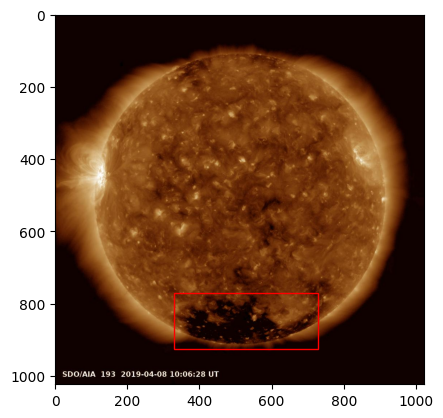

In [88]:
df_submission = pd.read_csv("submission.csv")

sample = df_submission.iloc[20]
sample_labels = eval(sample["labels"])

if len(sample_labels) == 0:
    print("예측결과: 해당 이미지에선 발견된 이벤트가 없습니다.")
else:
    fig, ax = plt.subplots()
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # 예측 결과 시각화
    for label in sample_labels:
        class_id = label["class_id"]
        cx = label["x"] * img.width
        cy = label["y"] * img.height
        w = label["w"] * img.width
        h = label["h"] * img.height

        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)

## Submission